# Cycle GAN 



## import libraries

In [72]:
!pip install tensorflow-addons

In [73]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random, seed
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

## Load images

In [74]:
#Resizing all the images and storing in compressed Numpy array.
def load_celeb_images(path, size=(128, 128), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'

# Load real data
dataA = load_celeb_images(celeb_path, max_images=400)
print('loaded dataA', dataA.shape)

loaded dataA (400, 128, 128, 3)


In [75]:
def load_style_images(path, size=(128, 128), max_images=None):
    data_list = []
    for folder_name in ['cropped_sketch']:
        folder_path = path + folder_name + '/'
        for filename in listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')): 
                pixels = load_img(folder_path + filename, target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
                if max_images and len(data_list) >= max_images:
                    break
    return np.asarray(data_list)

style_path = "../input/cuhk-face-sketch-database-cufs/"

# Load style data
dataB = load_style_images(style_path, max_images=400)
print('loaded dataB', dataB.shape)

loaded dataB (400, 128, 128, 3)


In [76]:
filename = 'celebrity2style.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)
print('Saved dataset:', filename)

Saved dataset: celebrity2style.npz


## Plotting images of Celebrity and Style

Loaded data: (400, 128, 128, 3) (400, 128, 128, 3)


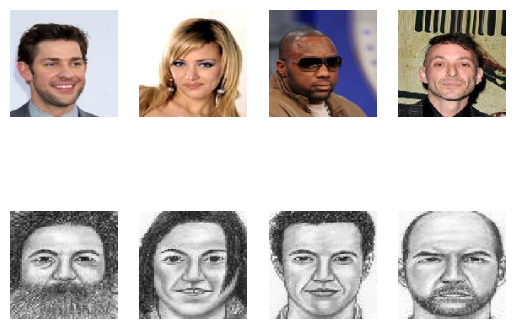

In [77]:
from numpy import load
data = load('celebrity2style.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)

n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot style image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. 

## Defining discriminator model

In [78]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (128, 128, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_31 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_243 (Conv2D)         (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu_36 (LeakyReLU)  (None, 64, 64, 64)        0         
                                                                 
 conv2d_244 (Conv2D)         (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization_243   (None, 32, 32, 128)      256       
 (InstanceNormalization)                                         
                                                                 
 leaky_re_lu_37 (LeakyReLU)  (None, 32, 32, 128)       0         
                                                          

## Defining generator model

In [79]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [80]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7), padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256 
    x = Conv2D(256,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3),  strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('relu')(x)

    model = Model(input_image, out_image)
    return model

image_shape = (128, 128, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_248 (Conv2D)            (None, 128, 128, 64  9472        ['input_32[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_246 (In  (None, 128, 128, 64  128        ['conv2d_248[0][0]']             
 stanceNormalization)           )                                                          

**adversarial loss**
The generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. 

**cycle loss**
The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. 

**identity loss**
Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).

MSE for label, MAE for graph.

4 outputs: discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

## Defining Composite model

In [81]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (128, 128), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    # adversarial loss, identity loss, forward cycle loss, backward cycle loss
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 10, 30, 30], optimizer=opt)
    
    return model

## Load real samples

In [82]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for target images
    return [X1,X2]

In [83]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


A sample of generated images is required to update each discriminator model in each training iteration.

In [84]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [85]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

In [86]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  #
 

In [87]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [88]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2style.npz')
        celeb, style = dataA[id], dataB[id]
        celeb_pred, style_pred = g_BA.predict(tf.expand_dims(style, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(style_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(style.astype('uint8'), title='Original style')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated style')
        
        
        plt.show()

Now the training the models which takes all 6 models ( 2 discriminator , 2 generator and 2 composite models) as input with dataset for training.

## Train cyclegan model

In [89]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=10, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    
    #manually enumerate epochs
    loss_history = []
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))
        
        loss_history.append([dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2])
            
        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Style.h5')
            g_model_BtoA.save('Generator_Style_to_Celebrity.h5')
    
    return loss_history
                

The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Loaded (400, 128, 128, 3) (400, 128, 128, 3)


Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   0%|          | 1/400 [01:19<8:45:55, 79.09s/it]

>1, dA[1.760 ,3.526 ] dB[1.531 ,4.140] g[47.027 ,49.553]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [01:19<3:38:22, 32.92s/it]

>2, dA[6.862 ,4.272 ] dB[12.467 ,2.330] g[55.747 ,56.803]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [01:20<2:00:08, 18.16s/it]

>3, dA[14.099 ,2.135 ] dB[32.073 ,4.299] g[65.364 ,45.659]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [01:20<1:14:04, 11.22s/it]

>4, dA[16.422 ,6.375 ] dB[3.535 ,10.620] g[57.826 ,70.404]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [01:21<48:38,  7.39s/it]  

>5, dA[21.526 ,8.757 ] dB[2.494 ,13.662] g[62.635 ,73.947]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [01:22<33:19,  5.08s/it]

>6, dA[14.493 ,2.910 ] dB[1.949 ,3.645] g[52.925 ,56.765]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [01:22<23:38,  3.61s/it]

>7, dA[2.148 ,0.654 ] dB[1.076 ,2.173] g[44.900 ,47.749]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [01:23<17:18,  2.65s/it]

>8, dA[1.877 ,0.560 ] dB[1.382 ,0.868] g[40.637 ,43.790]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [01:23<13:04,  2.01s/it]

>9, dA[0.637 ,0.443 ] dB[0.603 ,0.538] g[46.611 ,49.490]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [01:24<10:11,  1.57s/it]

>10, dA[0.174 ,0.286 ] dB[0.399 ,0.322] g[34.909 ,37.222]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [01:25<08:14,  1.27s/it]

>11, dA[0.249 ,0.200 ] dB[0.502 ,0.252] g[40.235 ,43.934]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [01:25<06:53,  1.06s/it]

>12, dA[0.153 ,0.098 ] dB[0.635 ,0.225] g[37.826 ,41.090]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [01:26<05:55,  1.09it/s]

>13, dA[0.484 ,0.165 ] dB[0.215 ,0.218] g[40.304 ,44.400]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 14/400 [01:26<05:16,  1.22it/s]

>14, dA[0.160 ,0.200 ] dB[0.337 ,0.131] g[40.420 ,46.840]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [01:27<04:49,  1.33it/s]

>15, dA[0.170 ,0.155 ] dB[0.280 ,0.135] g[46.353 ,52.728]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [01:27<04:29,  1.42it/s]

>16, dA[0.230 ,0.135 ] dB[0.147 ,0.129] g[32.761 ,36.160]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [01:28<04:15,  1.50it/s]

>17, dA[0.222 ,0.142 ] dB[0.217 ,0.155] g[32.182 ,35.437]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [01:29<04:05,  1.55it/s]

>18, dA[0.146 ,0.082 ] dB[0.408 ,0.119] g[33.165 ,35.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [01:29<04:01,  1.58it/s]

>19, dA[0.283 ,0.137 ] dB[0.218 ,0.095] g[32.710 ,37.604]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [01:30<03:55,  1.61it/s]

>20, dA[0.243 ,0.236 ] dB[0.094 ,0.207] g[33.097 ,33.410]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [01:30<03:51,  1.63it/s]

>21, dA[0.220 ,0.135 ] dB[0.143 ,0.209] g[32.851 ,35.036]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 22/400 [01:31<03:48,  1.65it/s]

>22, dA[0.121 ,0.252 ] dB[0.345 ,0.193] g[35.275 ,39.957]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [01:32<03:46,  1.66it/s]

>23, dA[0.152 ,0.124 ] dB[0.182 ,0.330] g[24.421 ,25.819]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [01:32<03:44,  1.67it/s]

>24, dA[0.081 ,0.070 ] dB[0.241 ,0.144] g[31.122 ,33.645]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [01:33<03:43,  1.68it/s]

>25, dA[0.247 ,0.250 ] dB[0.204 ,0.192] g[33.592 ,37.009]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [01:33<03:42,  1.68it/s]

>26, dA[0.194 ,0.102 ] dB[0.086 ,0.134] g[36.596 ,39.901]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 27/400 [01:34<03:41,  1.68it/s]

>27, dA[0.130 ,0.166 ] dB[0.094 ,0.294] g[25.381 ,26.800]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [01:35<03:40,  1.69it/s]

>28, dA[0.083 ,0.191 ] dB[0.739 ,0.425] g[28.808 ,31.492]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [01:35<03:39,  1.69it/s]

>29, dA[0.431 ,0.132 ] dB[0.241 ,0.372] g[39.764 ,46.524]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [01:36<03:38,  1.69it/s]

>30, dA[0.184 ,0.193 ] dB[0.302 ,0.251] g[29.450 ,33.373]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [01:36<03:38,  1.69it/s]

>31, dA[0.245 ,0.192 ] dB[0.268 ,0.228] g[28.630 ,28.725]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [01:37<03:37,  1.69it/s]

>32, dA[0.247 ,0.260 ] dB[0.167 ,0.581] g[24.100 ,27.492]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [01:38<03:37,  1.69it/s]

>33, dA[0.217 ,0.176 ] dB[0.316 ,0.257] g[29.033 ,31.640]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [01:38<03:37,  1.69it/s]

>34, dA[0.133 ,0.177 ] dB[0.134 ,0.143] g[26.120 ,29.107]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [01:39<03:36,  1.69it/s]

>35, dA[0.186 ,0.162 ] dB[0.110 ,0.139] g[33.584 ,38.106]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 36/400 [01:39<03:36,  1.68it/s]

>36, dA[0.114 ,0.150 ] dB[0.127 ,0.167] g[27.455 ,29.918]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 37/400 [01:40<03:35,  1.68it/s]

>37, dA[0.076 ,0.087 ] dB[0.136 ,0.132] g[28.568 ,31.267]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [01:40<03:33,  1.69it/s]

>38, dA[0.279 ,0.280 ] dB[0.091 ,0.305] g[31.496 ,38.523]
1/1 [==============================] - 0s 27ms/step



Batchs:  10%|▉         | 39/400 [01:41<03:35,  1.67it/s]

>39, dA[0.162 ,0.201 ] dB[0.385 ,0.106] g[32.696 ,36.526]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|█         | 40/400 [01:42<03:36,  1.67it/s]

>40, dA[0.145 ,0.093 ] dB[0.068 ,0.158] g[22.471 ,24.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [01:42<03:34,  1.67it/s]

>41, dA[0.267 ,0.225 ] dB[0.056 ,0.063] g[32.836 ,37.857]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [01:43<03:32,  1.68it/s]

>42, dA[0.140 ,0.147 ] dB[0.096 ,0.091] g[36.289 ,40.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [01:43<03:32,  1.68it/s]

>43, dA[0.157 ,0.370 ] dB[0.092 ,0.297] g[30.248 ,36.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [01:44<03:31,  1.68it/s]

>44, dA[0.242 ,0.143 ] dB[0.303 ,0.225] g[29.000 ,31.746]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 45/400 [01:45<03:29,  1.69it/s]

>45, dA[0.382 ,0.334 ] dB[0.144 ,0.100] g[25.055 ,26.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [01:45<03:28,  1.70it/s]

>46, dA[0.082 ,0.431 ] dB[0.279 ,0.339] g[28.218 ,31.968]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 47/400 [01:46<03:29,  1.69it/s]

>47, dA[0.415 ,0.169 ] dB[0.117 ,0.142] g[27.182 ,29.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [01:46<03:29,  1.68it/s]

>48, dA[0.174 ,0.179 ] dB[0.538 ,0.241] g[29.788 ,35.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [01:47<03:28,  1.68it/s]

>49, dA[0.216 ,0.259 ] dB[0.217 ,0.230] g[25.013 ,28.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 50/400 [01:48<03:27,  1.69it/s]

>50, dA[0.216 ,0.359 ] dB[0.275 ,0.116] g[24.620 ,28.721]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [01:48<03:27,  1.68it/s]

>51, dA[0.186 ,0.133 ] dB[0.096 ,0.198] g[26.731 ,30.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [01:49<03:26,  1.69it/s]

>52, dA[0.192 ,0.288 ] dB[0.171 ,0.126] g[27.461 ,29.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [01:49<03:25,  1.69it/s]

>53, dA[0.102 ,0.152 ] dB[0.157 ,0.043] g[25.118 ,28.311]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [01:50<03:23,  1.70it/s]

>54, dA[0.407 ,0.260 ] dB[0.082 ,0.313] g[20.819 ,22.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [01:51<03:24,  1.69it/s]

>55, dA[0.147 ,0.169 ] dB[0.420 ,0.094] g[27.673 ,29.658]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [01:51<03:25,  1.68it/s]

>56, dA[0.158 ,0.171 ] dB[0.077 ,0.076] g[25.873 ,28.585]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 57/400 [01:52<03:23,  1.68it/s]

>57, dA[0.111 ,0.363 ] dB[0.308 ,0.389] g[31.234 ,38.524]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [01:52<03:22,  1.69it/s]

>58, dA[0.354 ,0.247 ] dB[0.296 ,0.157] g[28.322 ,32.096]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [01:53<03:21,  1.69it/s]

>59, dA[0.373 ,0.312 ] dB[0.154 ,0.146] g[21.711 ,22.208]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 60/400 [01:54<03:21,  1.68it/s]

>60, dA[0.123 ,0.122 ] dB[0.097 ,0.344] g[25.576 ,26.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [01:54<03:21,  1.69it/s]

>61, dA[0.319 ,0.107 ] dB[0.195 ,0.911] g[28.440 ,33.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [01:55<03:19,  1.69it/s]

>62, dA[0.110 ,0.169 ] dB[0.386 ,1.545] g[31.570 ,34.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [01:55<03:19,  1.69it/s]

>63, dA[0.121 ,0.081 ] dB[0.766 ,1.422] g[27.033 ,25.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [01:56<03:18,  1.69it/s]

>64, dA[0.151 ,0.260 ] dB[0.289 ,0.506] g[32.945 ,37.057]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 65/400 [01:57<03:18,  1.69it/s]

>65, dA[0.268 ,0.079 ] dB[0.266 ,0.121] g[22.850 ,24.471]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 66/400 [01:57<03:17,  1.69it/s]

>66, dA[0.122 ,0.114 ] dB[0.423 ,0.241] g[22.997 ,23.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [01:58<03:16,  1.69it/s]

>67, dA[0.198 ,0.204 ] dB[0.154 ,0.436] g[28.355 ,31.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [01:58<03:16,  1.69it/s]

>68, dA[0.582 ,0.138 ] dB[0.262 ,0.354] g[32.536 ,36.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [01:59<03:16,  1.69it/s]

>69, dA[0.187 ,0.100 ] dB[0.512 ,0.234] g[21.753 ,23.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [01:59<03:15,  1.68it/s]

>70, dA[0.152 ,0.191 ] dB[0.292 ,0.212] g[25.244 ,28.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [02:00<03:16,  1.67it/s]

>71, dA[0.098 ,0.079 ] dB[0.327 ,0.211] g[29.672 ,33.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [02:01<03:16,  1.67it/s]

>72, dA[0.213 ,0.184 ] dB[0.207 ,0.101] g[29.918 ,34.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [02:01<03:15,  1.67it/s]

>73, dA[0.065 ,0.074 ] dB[0.118 ,0.075] g[30.011 ,35.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [02:02<03:14,  1.68it/s]

>74, dA[0.115 ,0.133 ] dB[0.346 ,0.191] g[27.159 ,29.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [02:02<03:14,  1.67it/s]

>75, dA[0.175 ,0.191 ] dB[0.273 ,0.087] g[23.949 ,27.040]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [02:03<03:13,  1.67it/s]

>76, dA[0.062 ,0.062 ] dB[0.178 ,0.152] g[28.063 ,32.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 77/400 [02:04<03:12,  1.68it/s]

>77, dA[0.175 ,0.093 ] dB[0.217 ,0.268] g[23.027 ,24.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [02:04<03:11,  1.68it/s]

>78, dA[0.155 ,0.384 ] dB[0.350 ,0.358] g[27.231 ,28.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 79/400 [02:05<03:11,  1.68it/s]

>79, dA[0.261 ,0.257 ] dB[0.112 ,0.067] g[28.604 ,32.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [02:05<03:10,  1.68it/s]

>80, dA[0.541 ,0.254 ] dB[0.172 ,0.054] g[19.566 ,22.333]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 81/400 [02:06<03:09,  1.68it/s]

>81, dA[0.198 ,0.115 ] dB[0.053 ,0.115] g[29.108 ,34.522]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [02:07<03:08,  1.68it/s]

>82, dA[0.336 ,0.101 ] dB[0.327 ,0.390] g[19.725 ,22.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [02:07<03:08,  1.68it/s]

>83, dA[0.080 ,0.145 ] dB[0.162 ,0.088] g[40.740 ,46.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [02:08<03:07,  1.68it/s]

>84, dA[0.249 ,0.144 ] dB[0.184 ,0.434] g[29.742 ,32.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [02:08<03:07,  1.68it/s]

>85, dA[0.084 ,0.136 ] dB[0.390 ,0.136] g[26.282 ,29.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [02:09<03:06,  1.69it/s]

>86, dA[0.134 ,0.087 ] dB[0.066 ,0.428] g[24.086 ,27.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [02:10<03:06,  1.68it/s]

>87, dA[0.148 ,0.108 ] dB[0.114 ,0.134] g[18.706 ,18.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [02:10<03:05,  1.69it/s]

>88, dA[0.097 ,0.097 ] dB[0.204 ,0.179] g[25.986 ,28.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 89/400 [02:11<03:04,  1.69it/s]

>89, dA[0.193 ,0.050 ] dB[0.284 ,0.324] g[23.373 ,27.774]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [02:11<03:04,  1.68it/s]

>90, dA[0.142 ,0.111 ] dB[0.120 ,0.054] g[29.467 ,32.245]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [02:12<03:04,  1.67it/s]

>91, dA[0.082 ,0.038 ] dB[0.127 ,0.142] g[27.104 ,30.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [02:13<03:03,  1.68it/s]

>92, dA[0.075 ,0.061 ] dB[0.107 ,0.081] g[29.345 ,30.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [02:13<03:02,  1.69it/s]

>93, dA[0.183 ,0.150 ] dB[0.126 ,0.049] g[21.038 ,23.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [02:14<03:00,  1.69it/s]

>94, dA[0.101 ,0.065 ] dB[0.276 ,0.254] g[26.284 ,27.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [02:14<03:00,  1.69it/s]

>95, dA[0.081 ,0.105 ] dB[0.118 ,0.176] g[23.226 ,26.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [02:15<02:59,  1.69it/s]

>96, dA[0.122 ,0.116 ] dB[0.178 ,0.085] g[23.457 ,26.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [02:16<02:59,  1.69it/s]

>97, dA[0.183 ,0.194 ] dB[0.085 ,0.102] g[25.423 ,28.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [02:16<02:58,  1.69it/s]

>98, dA[0.082 ,0.045 ] dB[0.074 ,0.082] g[22.733 ,25.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [02:17<02:58,  1.68it/s]

>99, dA[0.157 ,0.100 ] dB[0.056 ,0.038] g[23.585 ,26.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 100/400 [02:17<03:01,  1.65it/s]

>100, dA[0.107 ,0.106 ] dB[0.024 ,0.065] g[24.851 ,27.925]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 101/400 [02:18<03:00,  1.65it/s]

>101, dA[0.336 ,0.265 ] dB[0.250 ,0.221] g[15.866 ,17.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 102/400 [02:19<02:59,  1.66it/s]

>102, dA[0.177 ,0.200 ] dB[0.065 ,0.286] g[20.243 ,21.864]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [02:19<02:59,  1.65it/s]

>103, dA[0.203 ,0.109 ] dB[0.118 ,0.493] g[26.351 ,31.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 104/400 [02:20<02:59,  1.65it/s]

>104, dA[0.195 ,0.110 ] dB[0.217 ,0.256] g[31.015 ,35.399]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [02:20<02:57,  1.66it/s]

>105, dA[0.067 ,0.149 ] dB[0.124 ,0.261] g[32.432 ,37.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [02:21<02:56,  1.66it/s]

>106, dA[0.091 ,0.072 ] dB[0.129 ,0.099] g[31.911 ,37.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [02:22<02:56,  1.66it/s]

>107, dA[0.062 ,0.094 ] dB[0.055 ,0.198] g[29.899 ,33.902]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 108/400 [02:22<02:56,  1.66it/s]

>108, dA[0.089 ,0.056 ] dB[0.127 ,0.059] g[30.889 ,36.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [02:23<02:54,  1.67it/s]

>109, dA[0.113 ,0.214 ] dB[0.536 ,1.185] g[22.143 ,25.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [02:23<02:54,  1.66it/s]

>110, dA[0.401 ,0.101 ] dB[0.259 ,0.191] g[23.473 ,26.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [02:24<02:54,  1.66it/s]

>111, dA[0.067 ,0.252 ] dB[0.151 ,0.178] g[32.952 ,38.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [02:25<02:52,  1.67it/s]

>112, dA[0.282 ,0.156 ] dB[0.256 ,0.311] g[25.332 ,29.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [02:25<02:51,  1.67it/s]

>113, dA[0.154 ,0.184 ] dB[0.339 ,0.288] g[31.694 ,34.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [02:26<02:50,  1.68it/s]

>114, dA[0.335 ,0.179 ] dB[0.166 ,0.233] g[25.381 ,30.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [02:26<02:50,  1.67it/s]

>115, dA[0.049 ,0.148 ] dB[0.134 ,0.313] g[24.520 ,27.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [02:27<02:50,  1.67it/s]

>116, dA[0.268 ,0.107 ] dB[0.427 ,0.235] g[26.847 ,30.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [02:28<02:49,  1.67it/s]

>117, dA[0.235 ,0.129 ] dB[0.543 ,0.145] g[28.983 ,33.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [02:28<02:48,  1.67it/s]

>118, dA[0.165 ,0.238 ] dB[0.433 ,0.384] g[27.243 ,30.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [02:29<02:48,  1.67it/s]

>119, dA[0.152 ,0.145 ] dB[0.181 ,0.219] g[21.700 ,25.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [02:29<02:47,  1.67it/s]

>120, dA[0.091 ,0.080 ] dB[0.412 ,0.157] g[24.672 ,25.217]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [02:30<02:47,  1.67it/s]

>121, dA[0.083 ,0.102 ] dB[0.289 ,0.090] g[32.653 ,37.668]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 122/400 [02:31<02:46,  1.67it/s]

>122, dA[0.308 ,0.534 ] dB[0.209 ,0.087] g[20.275 ,21.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [02:31<02:48,  1.65it/s]

>123, dA[0.242 ,0.119 ] dB[0.132 ,0.184] g[20.428 ,20.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [02:32<02:46,  1.65it/s]

>124, dA[0.213 ,0.102 ] dB[0.085 ,0.103] g[31.370 ,35.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [02:32<02:45,  1.66it/s]

>125, dA[0.236 ,0.078 ] dB[0.110 ,0.052] g[21.869 ,24.876]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [02:33<02:44,  1.67it/s]

>126, dA[0.355 ,0.253 ] dB[0.207 ,0.075] g[22.100 ,24.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [02:34<02:43,  1.67it/s]

>127, dA[0.181 ,0.205 ] dB[0.054 ,0.069] g[17.835 ,22.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [02:34<02:42,  1.67it/s]

>128, dA[0.093 ,0.189 ] dB[0.053 ,0.108] g[25.695 ,28.484]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [02:35<02:41,  1.67it/s]

>129, dA[0.057 ,0.126 ] dB[0.024 ,0.104] g[26.154 ,28.463]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▎      | 130/400 [02:35<02:41,  1.67it/s]

>130, dA[0.165 ,0.103 ] dB[0.043 ,0.092] g[27.476 ,32.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [02:36<02:41,  1.67it/s]

>131, dA[0.113 ,0.125 ] dB[0.053 ,0.089] g[19.719 ,21.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 132/400 [02:37<02:40,  1.67it/s]

>132, dA[0.102 ,0.123 ] dB[0.036 ,0.064] g[31.495 ,38.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [02:37<02:39,  1.68it/s]

>133, dA[0.118 ,0.398 ] dB[0.102 ,0.421] g[21.780 ,23.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [02:38<02:37,  1.68it/s]

>134, dA[0.184 ,0.099 ] dB[0.136 ,0.082] g[20.659 ,22.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [02:38<02:38,  1.68it/s]

>135, dA[0.119 ,0.142 ] dB[0.031 ,0.076] g[18.820 ,20.101]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 136/400 [02:39<02:37,  1.68it/s]

>136, dA[0.106 ,0.122 ] dB[0.095 ,0.127] g[20.577 ,22.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [02:40<02:36,  1.68it/s]

>137, dA[0.114 ,0.210 ] dB[0.078 ,0.047] g[20.067 ,20.574]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 138/400 [02:40<02:35,  1.68it/s]

>138, dA[0.134 ,0.254 ] dB[0.258 ,0.254] g[22.722 ,27.490]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▍      | 139/400 [02:41<02:36,  1.67it/s]

>139, dA[0.141 ,0.135 ] dB[0.154 ,0.034] g[16.617 ,18.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [02:41<02:35,  1.67it/s]

>140, dA[0.127 ,0.243 ] dB[0.188 ,0.066] g[18.366 ,17.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [02:42<02:34,  1.68it/s]

>141, dA[0.346 ,0.288 ] dB[0.038 ,0.083] g[19.093 ,23.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [02:43<02:33,  1.69it/s]

>142, dA[0.250 ,0.128 ] dB[0.079 ,0.069] g[34.521 ,38.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [02:43<02:32,  1.68it/s]

>143, dA[0.213 ,0.131 ] dB[0.137 ,0.050] g[24.722 ,26.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [02:44<02:31,  1.69it/s]

>144, dA[0.187 ,0.203 ] dB[0.104 ,0.863] g[21.325 ,20.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [02:44<02:30,  1.69it/s]

>145, dA[0.255 ,0.313 ] dB[0.235 ,0.112] g[20.868 ,24.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [02:45<02:29,  1.70it/s]

>146, dA[0.180 ,0.217 ] dB[0.058 ,0.179] g[14.470 ,15.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [02:45<02:29,  1.69it/s]

>147, dA[0.225 ,0.114 ] dB[0.135 ,0.123] g[19.752 ,20.527]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [02:46<02:28,  1.69it/s]

>148, dA[0.284 ,0.300 ] dB[0.228 ,0.948] g[21.878 ,25.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [02:47<02:28,  1.69it/s]

>149, dA[0.183 ,0.096 ] dB[0.523 ,0.271] g[22.490 ,26.117]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 150/400 [02:47<02:27,  1.70it/s]

>150, dA[0.281 ,0.144 ] dB[0.066 ,0.132] g[22.082 ,24.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [02:48<02:27,  1.68it/s]

>151, dA[0.235 ,0.163 ] dB[0.091 ,0.101] g[25.856 ,30.656]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 152/400 [02:48<02:30,  1.65it/s]

>152, dA[0.193 ,0.102 ] dB[0.127 ,0.229] g[27.690 ,31.807]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 153/400 [02:49<02:30,  1.65it/s]

>153, dA[0.179 ,0.421 ] dB[0.308 ,0.466] g[14.521 ,16.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [02:50<02:27,  1.66it/s]

>154, dA[0.078 ,0.113 ] dB[0.156 ,0.226] g[29.865 ,33.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [02:50<02:27,  1.67it/s]

>155, dA[0.064 ,0.078 ] dB[0.245 ,0.191] g[24.667 ,29.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [02:51<02:27,  1.66it/s]

>156, dA[0.078 ,0.074 ] dB[0.148 ,0.165] g[36.617 ,42.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [02:51<02:25,  1.67it/s]

>157, dA[0.191 ,0.090 ] dB[0.178 ,0.122] g[23.119 ,27.116]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [02:52<02:24,  1.68it/s]

>158, dA[0.103 ,0.131 ] dB[0.110 ,0.063] g[21.834 ,24.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 159/400 [02:53<02:23,  1.68it/s]

>159, dA[0.063 ,0.065 ] dB[0.103 ,0.127] g[22.677 ,24.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [02:53<02:23,  1.68it/s]

>160, dA[0.330 ,0.717 ] dB[0.097 ,0.109] g[22.937 ,28.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [02:54<02:21,  1.69it/s]

>161, dA[0.902 ,0.501 ] dB[0.114 ,0.094] g[23.142 ,26.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [02:54<02:20,  1.69it/s]

>162, dA[0.756 ,0.308 ] dB[0.086 ,0.052] g[30.234 ,37.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [02:55<02:20,  1.69it/s]

>163, dA[0.489 ,0.174 ] dB[0.487 ,0.881] g[24.287 ,29.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [02:56<02:19,  1.69it/s]

>164, dA[0.192 ,0.222 ] dB[0.158 ,0.084] g[22.447 ,24.915]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████▏     | 165/400 [02:56<02:19,  1.69it/s]

>165, dA[0.252 ,0.132 ] dB[0.173 ,0.067] g[17.923 ,20.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [02:57<02:18,  1.69it/s]

>166, dA[0.268 ,0.171 ] dB[0.073 ,0.320] g[30.030 ,33.928]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [02:57<02:18,  1.68it/s]

>167, dA[0.185 ,0.149 ] dB[0.166 ,0.192] g[27.315 ,29.636]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 168/400 [02:58<02:17,  1.69it/s]

>168, dA[0.143 ,0.114 ] dB[0.373 ,0.784] g[17.047 ,20.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [02:59<02:16,  1.69it/s]

>169, dA[0.119 ,0.149 ] dB[0.162 ,0.660] g[32.966 ,38.991]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 170/400 [02:59<02:16,  1.69it/s]

>170, dA[0.109 ,0.040 ] dB[0.237 ,0.643] g[32.123 ,36.329]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 171/400 [03:00<02:15,  1.69it/s]

>171, dA[0.156 ,0.078 ] dB[0.112 ,0.285] g[24.910 ,28.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [03:00<02:15,  1.68it/s]

>172, dA[0.088 ,0.054 ] dB[1.144 ,1.040] g[28.960 ,31.388]
1/1 [==============================] - 0s 26ms/step



Batchs:  43%|████▎     | 173/400 [03:01<02:16,  1.66it/s]

>173, dA[0.099 ,0.131 ] dB[0.297 ,0.251] g[15.096 ,17.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [03:02<02:15,  1.67it/s]

>174, dA[0.131 ,0.108 ] dB[0.397 ,0.289] g[16.827 ,16.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [03:02<02:14,  1.67it/s]

>175, dA[0.110 ,0.104 ] dB[0.199 ,0.137] g[20.995 ,23.469]
1/1 [==============================] - 0s 29ms/step



Batchs:  44%|████▍     | 176/400 [03:03<02:13,  1.67it/s]

>176, dA[0.072 ,0.137 ] dB[0.087 ,0.184] g[15.892 ,15.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [03:03<02:12,  1.68it/s]

>177, dA[0.037 ,0.047 ] dB[0.152 ,0.219] g[22.139 ,23.097]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [03:04<02:12,  1.68it/s]

>178, dA[0.088 ,0.073 ] dB[0.386 ,0.406] g[16.202 ,18.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [03:05<02:11,  1.68it/s]

>179, dA[0.077 ,0.128 ] dB[0.079 ,0.110] g[33.345 ,39.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [03:05<02:10,  1.68it/s]

>180, dA[0.028 ,0.166 ] dB[0.072 ,0.187] g[17.590 ,18.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [03:06<02:10,  1.68it/s]

>181, dA[0.028 ,0.029 ] dB[0.087 ,0.111] g[21.795 ,22.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [03:06<02:09,  1.69it/s]

>182, dA[0.143 ,0.081 ] dB[0.094 ,0.116] g[20.819 ,26.037]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [03:07<02:09,  1.68it/s]

>183, dA[0.063 ,0.066 ] dB[0.062 ,0.117] g[24.324 ,25.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [03:08<02:08,  1.68it/s]

>184, dA[0.084 ,0.063 ] dB[0.065 ,0.198] g[24.764 ,29.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [03:08<02:07,  1.69it/s]

>185, dA[0.036 ,0.032 ] dB[0.131 ,0.174] g[25.652 ,29.046]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 186/400 [03:09<02:06,  1.69it/s]

>186, dA[0.029 ,0.035 ] dB[0.343 ,0.149] g[33.548 ,36.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [03:09<02:06,  1.68it/s]

>187, dA[0.061 ,0.050 ] dB[0.120 ,0.302] g[20.589 ,23.048]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [03:10<02:06,  1.68it/s]

>188, dA[0.034 ,0.039 ] dB[0.192 ,0.113] g[26.771 ,30.228]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [03:10<02:05,  1.68it/s]

>189, dA[0.099 ,0.051 ] dB[0.154 ,0.191] g[30.474 ,32.444]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [03:11<02:04,  1.68it/s]

>190, dA[0.044 ,0.052 ] dB[0.176 ,0.117] g[18.654 ,20.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [03:12<02:04,  1.68it/s]

>191, dA[0.053 ,0.056 ] dB[0.034 ,0.185] g[19.047 ,20.053]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [03:12<02:03,  1.68it/s]

>192, dA[0.178 ,0.094 ] dB[0.125 ,0.143] g[15.745 ,17.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [03:13<02:02,  1.69it/s]

>193, dA[0.034 ,0.032 ] dB[0.082 ,0.131] g[25.183 ,30.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [03:13<02:01,  1.70it/s]

>194, dA[0.039 ,0.062 ] dB[0.215 ,0.119] g[27.379 ,30.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [03:14<02:01,  1.69it/s]

>195, dA[0.047 ,0.043 ] dB[0.194 ,0.076] g[25.375 ,29.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [03:15<02:01,  1.69it/s]

>196, dA[0.053 ,0.077 ] dB[0.402 ,0.166] g[21.548 ,23.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [03:15<02:00,  1.69it/s]

>197, dA[0.031 ,0.045 ] dB[0.023 ,0.054] g[21.174 ,22.998]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 198/400 [03:16<01:59,  1.69it/s]

>198, dA[0.036 ,0.053 ] dB[0.054 ,0.027] g[19.021 ,20.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [03:16<01:59,  1.69it/s]

>199, dA[0.094 ,0.035 ] dB[0.026 ,0.049] g[18.689 ,20.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [03:17<01:58,  1.69it/s]

>200, dA[0.100 ,0.210 ] dB[0.099 ,0.033] g[22.326 ,26.588]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 201/400 [03:18<01:57,  1.69it/s]

>201, dA[0.093 ,0.086 ] dB[0.182 ,0.416] g[21.670 ,27.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [03:18<01:56,  1.70it/s]

>202, dA[0.048 ,0.141 ] dB[0.174 ,0.132] g[28.103 ,31.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [03:19<01:56,  1.69it/s]

>203, dA[0.123 ,0.099 ] dB[0.098 ,0.068] g[20.488 ,21.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [03:19<01:57,  1.66it/s]

>204, dA[0.137 ,0.142 ] dB[0.079 ,0.052] g[24.593 ,30.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [03:20<01:57,  1.66it/s]

>205, dA[0.034 ,0.113 ] dB[0.045 ,0.049] g[29.751 ,35.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [03:21<01:57,  1.66it/s]

>206, dA[0.096 ,0.072 ] dB[0.029 ,0.068] g[32.448 ,36.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [03:21<01:57,  1.65it/s]

>207, dA[0.139 ,0.222 ] dB[0.021 ,0.051] g[18.043 ,20.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [03:22<01:55,  1.66it/s]

>208, dA[0.152 ,0.326 ] dB[0.044 ,0.033] g[23.176 ,27.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [03:22<01:54,  1.67it/s]

>209, dA[0.375 ,0.405 ] dB[0.046 ,0.073] g[24.246 ,26.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [03:23<01:53,  1.67it/s]

>210, dA[0.267 ,0.184 ] dB[0.103 ,0.080] g[18.981 ,20.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [03:24<01:52,  1.68it/s]

>211, dA[0.406 ,0.085 ] dB[0.073 ,0.038] g[26.611 ,29.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [03:24<01:51,  1.68it/s]

>212, dA[0.128 ,0.107 ] dB[0.097 ,0.023] g[19.302 ,20.353]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [03:25<01:51,  1.68it/s]

>213, dA[0.069 ,0.084 ] dB[0.094 ,0.052] g[26.997 ,30.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [03:25<01:50,  1.69it/s]

>214, dA[0.116 ,0.134 ] dB[0.115 ,0.085] g[23.624 ,24.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [03:26<01:49,  1.69it/s]

>215, dA[0.137 ,0.063 ] dB[0.068 ,0.028] g[19.866 ,23.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [03:27<01:49,  1.69it/s]

>216, dA[0.227 ,0.125 ] dB[0.061 ,0.047] g[23.225 ,26.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [03:27<01:48,  1.69it/s]

>217, dA[0.334 ,0.265 ] dB[0.037 ,0.032] g[26.739 ,30.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [03:28<01:47,  1.69it/s]

>218, dA[0.180 ,0.168 ] dB[0.023 ,0.026] g[35.975 ,42.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [03:28<01:47,  1.68it/s]

>219, dA[0.063 ,0.109 ] dB[0.042 ,0.021] g[17.334 ,18.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [03:29<01:46,  1.68it/s]

>220, dA[0.123 ,0.040 ] dB[0.020 ,0.029] g[18.734 ,20.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [03:29<01:45,  1.69it/s]

>221, dA[0.112 ,0.038 ] dB[0.036 ,0.021] g[19.994 ,22.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [03:30<01:45,  1.69it/s]

>222, dA[0.069 ,0.092 ] dB[0.055 ,0.044] g[33.307 ,39.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [03:31<01:45,  1.68it/s]

>223, dA[0.044 ,0.165 ] dB[0.100 ,0.065] g[19.869 ,20.024]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 224/400 [03:31<01:45,  1.66it/s]

>224, dA[0.125 ,0.165 ] dB[0.058 ,0.057] g[15.590 ,16.935]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [03:32<01:44,  1.67it/s]

>225, dA[0.135 ,0.106 ] dB[0.064 ,0.083] g[32.243 ,40.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [03:32<01:43,  1.68it/s]

>226, dA[0.069 ,0.138 ] dB[0.044 ,0.083] g[20.637 ,21.055]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 227/400 [03:33<01:43,  1.67it/s]

>227, dA[0.074 ,0.129 ] dB[0.126 ,0.034] g[17.715 ,17.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [03:34<01:42,  1.67it/s]

>228, dA[0.103 ,0.147 ] dB[0.216 ,0.236] g[18.704 ,21.286]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [03:34<01:41,  1.68it/s]

>229, dA[0.317 ,0.127 ] dB[0.081 ,0.106] g[25.698 ,28.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [03:35<01:41,  1.68it/s]

>230, dA[0.266 ,0.173 ] dB[0.063 ,0.145] g[19.886 ,18.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [03:35<01:40,  1.68it/s]

>231, dA[0.176 ,0.085 ] dB[0.031 ,0.631] g[27.606 ,31.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [03:36<01:39,  1.69it/s]

>232, dA[0.110 ,0.101 ] dB[0.178 ,0.372] g[21.712 ,24.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [03:37<01:38,  1.69it/s]

>233, dA[0.180 ,0.102 ] dB[0.550 ,0.513] g[35.065 ,37.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 234/400 [03:37<01:38,  1.69it/s]

>234, dA[0.063 ,0.071 ] dB[0.300 ,0.221] g[26.562 ,28.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [03:38<01:37,  1.69it/s]

>235, dA[0.046 ,0.092 ] dB[0.087 ,0.190] g[21.455 ,23.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [03:38<01:37,  1.68it/s]

>236, dA[0.129 ,0.047 ] dB[0.284 ,0.140] g[23.260 ,24.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [03:39<01:36,  1.68it/s]

>237, dA[0.098 ,0.172 ] dB[0.092 ,0.056] g[19.994 ,22.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [03:40<01:35,  1.69it/s]

>238, dA[0.075 ,0.088 ] dB[0.045 ,0.046] g[20.357 ,24.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [03:40<01:35,  1.68it/s]

>239, dA[0.158 ,0.197 ] dB[0.150 ,0.193] g[23.417 ,26.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [03:41<01:35,  1.67it/s]

>240, dA[0.079 ,0.045 ] dB[0.037 ,0.257] g[22.799 ,25.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 241/400 [03:41<01:34,  1.68it/s]

>241, dA[0.040 ,0.040 ] dB[0.329 ,0.219] g[23.365 ,27.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [03:42<01:33,  1.68it/s]

>242, dA[0.097 ,0.086 ] dB[0.131 ,0.178] g[18.012 ,18.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [03:43<01:33,  1.68it/s]

>243, dA[0.074 ,0.080 ] dB[0.106 ,0.171] g[23.340 ,25.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [03:43<01:32,  1.68it/s]

>244, dA[0.191 ,0.337 ] dB[0.099 ,0.411] g[19.882 ,22.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [03:44<01:32,  1.68it/s]

>245, dA[0.050 ,0.091 ] dB[0.127 ,0.223] g[18.104 ,19.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [03:44<01:30,  1.69it/s]

>246, dA[0.171 ,0.092 ] dB[0.132 ,0.233] g[23.118 ,26.030]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 247/400 [03:45<01:30,  1.69it/s]

>247, dA[0.082 ,0.069 ] dB[0.062 ,0.214] g[17.613 ,17.074]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 248/400 [03:46<01:30,  1.69it/s]

>248, dA[0.027 ,0.045 ] dB[0.099 ,0.262] g[30.252 ,35.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [03:46<01:29,  1.69it/s]

>249, dA[0.055 ,0.086 ] dB[0.067 ,0.177] g[22.989 ,26.759]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [03:47<01:28,  1.70it/s]

>250, dA[0.050 ,0.161 ] dB[0.063 ,0.396] g[17.293 ,18.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [03:47<01:28,  1.69it/s]

>251, dA[0.202 ,0.072 ] dB[0.278 ,0.073] g[20.096 ,22.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [03:48<01:27,  1.69it/s]

>252, dA[0.138 ,0.179 ] dB[0.219 ,0.140] g[28.465 ,30.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [03:49<01:26,  1.69it/s]

>253, dA[0.037 ,0.043 ] dB[0.129 ,0.124] g[27.969 ,31.443]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [03:49<01:26,  1.69it/s]

>254, dA[0.067 ,0.188 ] dB[0.089 ,0.188] g[24.184 ,25.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [03:50<01:25,  1.69it/s]

>255, dA[0.111 ,0.089 ] dB[0.046 ,0.076] g[26.014 ,30.455]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [03:50<01:25,  1.68it/s]

>256, dA[0.023 ,0.061 ] dB[0.058 ,0.037] g[30.154 ,34.111]
1/1 [==============================] - 0s 28ms/step



Batchs:  64%|██████▍   | 257/400 [03:51<01:25,  1.66it/s]

>257, dA[0.088 ,0.035 ] dB[0.128 ,0.100] g[22.788 ,26.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [03:52<01:25,  1.66it/s]

>258, dA[0.032 ,0.091 ] dB[0.100 ,0.053] g[28.682 ,33.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [03:52<01:24,  1.66it/s]

>259, dA[0.061 ,0.050 ] dB[0.183 ,0.100] g[22.042 ,24.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [03:53<01:23,  1.67it/s]

>260, dA[0.038 ,0.014 ] dB[0.018 ,0.045] g[20.356 ,22.387]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [03:53<01:23,  1.67it/s]

>261, dA[0.112 ,0.056 ] dB[0.058 ,0.106] g[35.151 ,39.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [03:54<01:22,  1.68it/s]

>262, dA[0.067 ,0.041 ] dB[0.368 ,0.305] g[20.280 ,23.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [03:54<01:21,  1.68it/s]

>263, dA[0.110 ,0.032 ] dB[0.073 ,0.057] g[31.664 ,35.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [03:55<01:20,  1.69it/s]

>264, dA[0.073 ,0.046 ] dB[0.081 ,0.036] g[27.506 ,32.649]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [03:56<01:19,  1.69it/s]

>265, dA[0.143 ,0.476 ] dB[0.460 ,1.079] g[19.354 ,24.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [03:56<01:19,  1.69it/s]

>266, dA[0.264 ,0.038 ] dB[0.085 ,0.445] g[20.197 ,22.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [03:57<01:18,  1.69it/s]

>267, dA[0.122 ,0.129 ] dB[0.152 ,0.163] g[19.660 ,20.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [03:57<01:18,  1.69it/s]

>268, dA[0.078 ,0.171 ] dB[0.070 ,0.087] g[18.968 ,18.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [03:58<01:17,  1.69it/s]

>269, dA[0.057 ,0.076 ] dB[0.230 ,0.915] g[16.031 ,18.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [03:59<01:17,  1.69it/s]

>270, dA[0.179 ,0.066 ] dB[0.894 ,0.399] g[22.009 ,21.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [03:59<01:16,  1.68it/s]

>271, dA[0.196 ,0.184 ] dB[0.641 ,0.703] g[26.821 ,30.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 272/400 [04:00<01:16,  1.68it/s]

>272, dA[0.104 ,0.134 ] dB[0.177 ,0.115] g[21.712 ,22.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [04:00<01:16,  1.67it/s]

>273, dA[0.065 ,0.098 ] dB[0.108 ,0.169] g[20.172 ,21.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [04:01<01:15,  1.68it/s]

>274, dA[0.101 ,0.056 ] dB[0.215 ,0.228] g[21.584 ,24.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [04:02<01:14,  1.67it/s]

>275, dA[0.044 ,0.033 ] dB[0.261 ,0.177] g[27.587 ,32.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [04:02<01:14,  1.67it/s]

>276, dA[0.072 ,0.016 ] dB[0.222 ,0.292] g[27.146 ,28.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [04:03<01:13,  1.68it/s]

>277, dA[0.061 ,0.028 ] dB[0.242 ,0.073] g[33.048 ,36.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [04:03<01:12,  1.68it/s]

>278, dA[0.014 ,0.033 ] dB[0.085 ,0.152] g[26.871 ,31.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [04:04<01:11,  1.68it/s]

>279, dA[0.023 ,0.032 ] dB[0.613 ,0.445] g[16.895 ,18.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [04:05<01:11,  1.68it/s]

>280, dA[0.064 ,0.230 ] dB[0.302 ,0.090] g[26.484 ,30.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [04:05<01:10,  1.68it/s]

>281, dA[0.134 ,0.329 ] dB[0.056 ,0.110] g[16.807 ,17.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 282/400 [04:06<01:09,  1.69it/s]

>282, dA[0.201 ,0.034 ] dB[0.142 ,0.075] g[19.359 ,24.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [04:06<01:09,  1.69it/s]

>283, dA[0.194 ,0.085 ] dB[0.087 ,0.033] g[23.813 ,26.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 284/400 [04:07<01:08,  1.69it/s]

>284, dA[0.040 ,0.050 ] dB[0.120 ,0.237] g[18.239 ,17.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [04:08<01:08,  1.69it/s]

>285, dA[0.070 ,0.117 ] dB[0.138 ,0.205] g[20.811 ,22.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [04:08<01:07,  1.69it/s]

>286, dA[0.101 ,0.068 ] dB[0.111 ,0.035] g[20.680 ,24.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 287/400 [04:09<01:07,  1.68it/s]

>287, dA[0.035 ,0.042 ] dB[0.060 ,0.074] g[27.555 ,31.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 288/400 [04:09<01:06,  1.68it/s]

>288, dA[0.077 ,0.172 ] dB[0.038 ,0.061] g[21.262 ,23.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [04:10<01:05,  1.69it/s]

>289, dA[0.070 ,0.096 ] dB[0.087 ,0.058] g[31.374 ,35.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [04:11<01:05,  1.69it/s]

>290, dA[0.155 ,0.098 ] dB[0.113 ,0.086] g[19.520 ,22.221]
1/1 [==============================] - 0s 26ms/step



Batchs:  73%|███████▎  | 291/400 [04:11<01:05,  1.67it/s]

>291, dA[0.229 ,0.221 ] dB[0.060 ,0.121] g[17.116 ,18.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [04:12<01:04,  1.68it/s]

>292, dA[0.190 ,0.274 ] dB[0.059 ,0.137] g[25.419 ,29.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [04:12<01:03,  1.69it/s]

>293, dA[0.190 ,0.138 ] dB[0.041 ,0.084] g[22.365 ,25.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [04:13<01:02,  1.69it/s]

>294, dA[0.153 ,0.148 ] dB[0.040 ,0.054] g[23.907 ,26.145]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 295/400 [04:13<01:02,  1.69it/s]

>295, dA[0.038 ,0.038 ] dB[0.074 ,0.037] g[23.824 ,28.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [04:14<01:01,  1.69it/s]

>296, dA[0.083 ,0.104 ] dB[0.334 ,0.583] g[23.087 ,26.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [04:15<01:00,  1.69it/s]

>297, dA[0.079 ,0.066 ] dB[0.133 ,0.461] g[23.525 ,24.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [04:15<01:00,  1.69it/s]

>298, dA[0.055 ,0.039 ] dB[0.578 ,1.064] g[22.391 ,25.292]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 299/400 [04:16<00:59,  1.69it/s]

>299, dA[0.025 ,0.017 ] dB[0.171 ,0.570] g[19.152 ,20.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [04:16<00:59,  1.69it/s]

>300, dA[0.043 ,0.047 ] dB[0.303 ,0.294] g[27.023 ,27.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [04:17<00:58,  1.69it/s]

>301, dA[0.115 ,0.334 ] dB[0.065 ,0.085] g[20.892 ,23.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [04:18<00:57,  1.69it/s]

>302, dA[0.062 ,0.110 ] dB[0.158 ,0.068] g[29.556 ,34.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [04:18<00:57,  1.69it/s]

>303, dA[0.117 ,0.112 ] dB[0.051 ,0.042] g[24.562 ,29.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [04:19<00:57,  1.68it/s]

>304, dA[0.080 ,0.054 ] dB[0.056 ,0.053] g[29.952 ,34.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [04:19<00:56,  1.68it/s]

>305, dA[0.208 ,0.130 ] dB[0.027 ,0.057] g[20.300 ,22.754]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 306/400 [04:20<00:55,  1.69it/s]

>306, dA[0.318 ,0.295 ] dB[0.031 ,0.040] g[27.241 ,32.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [04:21<00:55,  1.66it/s]

>307, dA[0.501 ,1.489 ] dB[0.353 ,0.498] g[19.318 ,23.997]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 308/400 [04:21<00:55,  1.66it/s]

>308, dA[0.292 ,0.316 ] dB[0.061 ,0.170] g[26.673 ,31.404]
1/1 [==============================] - 0s 26ms/step



Batchs:  77%|███████▋  | 309/400 [04:22<00:55,  1.64it/s]

>309, dA[0.117 ,0.270 ] dB[0.066 ,0.044] g[17.337 ,18.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [04:22<00:54,  1.65it/s]

>310, dA[0.188 ,0.100 ] dB[0.075 ,0.048] g[25.477 ,28.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [04:23<00:53,  1.65it/s]

>311, dA[0.156 ,0.047 ] dB[0.047 ,0.027] g[22.815 ,24.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [04:24<00:52,  1.66it/s]

>312, dA[0.094 ,0.069 ] dB[0.074 ,0.037] g[22.222 ,24.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [04:24<00:52,  1.67it/s]

>313, dA[0.039 ,0.063 ] dB[0.047 ,0.026] g[26.040 ,30.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [04:25<00:51,  1.68it/s]

>314, dA[0.081 ,0.054 ] dB[0.046 ,0.067] g[25.052 ,27.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [04:25<00:50,  1.67it/s]

>315, dA[0.053 ,0.051 ] dB[0.114 ,0.159] g[37.296 ,42.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [04:26<00:50,  1.68it/s]

>316, dA[0.070 ,0.023 ] dB[0.198 ,0.075] g[19.258 ,20.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [04:27<00:49,  1.69it/s]

>317, dA[0.218 ,0.155 ] dB[0.395 ,0.725] g[15.708 ,19.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [04:27<00:48,  1.69it/s]

>318, dA[0.068 ,0.081 ] dB[0.064 ,0.152] g[22.329 ,24.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [04:28<00:48,  1.68it/s]

>319, dA[0.079 ,0.042 ] dB[0.290 ,0.266] g[30.408 ,33.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [04:28<00:47,  1.69it/s]

>320, dA[0.168 ,0.181 ] dB[0.224 ,0.250] g[30.879 ,37.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [04:29<00:46,  1.69it/s]

>321, dA[0.097 ,0.201 ] dB[0.208 ,0.255] g[28.921 ,33.484]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 322/400 [04:30<00:46,  1.68it/s]

>322, dA[0.089 ,0.067 ] dB[0.290 ,0.152] g[19.388 ,20.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [04:30<00:45,  1.68it/s]

>323, dA[0.105 ,0.239 ] dB[0.284 ,0.183] g[21.907 ,26.156]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 324/400 [04:31<00:45,  1.68it/s]

>324, dA[0.372 ,0.176 ] dB[0.188 ,0.207] g[22.352 ,19.614]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [04:31<00:44,  1.68it/s]

>325, dA[0.836 ,0.789 ] dB[0.095 ,0.219] g[18.519 ,22.479]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 326/400 [04:32<00:44,  1.67it/s]

>326, dA[0.208 ,0.163 ] dB[0.112 ,0.113] g[25.050 ,26.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [04:33<00:43,  1.68it/s]

>327, dA[0.714 ,0.956 ] dB[0.061 ,0.076] g[18.005 ,19.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [04:33<00:42,  1.68it/s]

>328, dA[0.336 ,0.810 ] dB[0.061 ,0.057] g[24.011 ,27.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [04:34<00:42,  1.68it/s]

>329, dA[0.310 ,0.415 ] dB[0.075 ,0.043] g[22.212 ,25.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [04:34<00:41,  1.68it/s]

>330, dA[0.141 ,0.223 ] dB[0.050 ,0.044] g[23.292 ,26.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [04:35<00:41,  1.68it/s]

>331, dA[0.073 ,0.197 ] dB[0.082 ,0.037] g[16.477 ,18.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [04:36<00:40,  1.68it/s]

>332, dA[0.064 ,0.111 ] dB[0.044 ,0.043] g[20.731 ,23.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [04:36<00:39,  1.68it/s]

>333, dA[0.081 ,0.076 ] dB[0.048 ,0.048] g[22.301 ,24.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [04:37<00:39,  1.69it/s]

>334, dA[0.089 ,0.051 ] dB[0.060 ,0.024] g[36.557 ,43.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [04:37<00:38,  1.69it/s]

>335, dA[0.058 ,0.029 ] dB[0.069 ,0.029] g[21.804 ,24.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [04:38<00:37,  1.69it/s]

>336, dA[0.081 ,0.031 ] dB[0.050 ,0.034] g[21.590 ,25.556]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [04:38<00:37,  1.69it/s]

>337, dA[0.079 ,0.155 ] dB[0.066 ,0.042] g[25.392 ,26.794]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [04:39<00:36,  1.68it/s]

>338, dA[0.217 ,0.146 ] dB[0.053 ,0.029] g[17.806 ,20.928]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [04:40<00:36,  1.68it/s]

>339, dA[0.076 ,0.076 ] dB[0.027 ,0.042] g[19.245 ,19.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [04:40<00:35,  1.68it/s]

>340, dA[0.016 ,0.061 ] dB[0.036 ,0.022] g[24.404 ,27.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [04:41<00:35,  1.67it/s]

>341, dA[0.013 ,0.027 ] dB[0.070 ,0.033] g[28.240 ,31.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [04:41<00:34,  1.68it/s]

>342, dA[0.022 ,0.010 ] dB[0.085 ,0.045] g[28.152 ,31.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [04:42<00:34,  1.68it/s]

>343, dA[0.046 ,0.047 ] dB[0.036 ,0.048] g[20.859 ,24.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [04:43<00:33,  1.68it/s]

>344, dA[0.058 ,0.027 ] dB[0.012 ,0.029] g[17.794 ,19.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [04:43<00:32,  1.68it/s]

>345, dA[0.037 ,0.045 ] dB[0.014 ,0.053] g[22.408 ,24.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [04:44<00:31,  1.69it/s]

>346, dA[0.049 ,0.099 ] dB[0.046 ,0.026] g[17.274 ,17.944]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [04:44<00:31,  1.68it/s]

>347, dA[0.066 ,0.080 ] dB[0.063 ,0.042] g[21.814 ,25.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [04:45<00:30,  1.68it/s]

>348, dA[0.093 ,0.232 ] dB[0.036 ,0.057] g[17.311 ,19.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [04:46<00:30,  1.69it/s]

>349, dA[0.074 ,0.062 ] dB[0.017 ,0.065] g[23.399 ,27.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [04:46<00:29,  1.69it/s]

>350, dA[0.097 ,0.053 ] dB[0.015 ,0.060] g[30.209 ,37.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [04:47<00:29,  1.69it/s]

>351, dA[0.059 ,0.044 ] dB[0.014 ,0.029] g[26.315 ,29.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [04:47<00:28,  1.69it/s]

>352, dA[0.072 ,0.070 ] dB[0.029 ,0.029] g[18.067 ,20.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [04:48<00:27,  1.69it/s]

>353, dA[0.018 ,0.046 ] dB[0.064 ,0.060] g[25.501 ,28.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [04:49<00:27,  1.69it/s]

>354, dA[0.038 ,0.043 ] dB[0.052 ,0.039] g[23.573 ,28.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [04:49<00:26,  1.69it/s]

>355, dA[0.121 ,0.184 ] dB[0.030 ,0.016] g[17.044 ,20.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [04:50<00:26,  1.69it/s]

>356, dA[0.041 ,0.031 ] dB[0.046 ,0.015] g[19.476 ,18.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [04:50<00:25,  1.69it/s]

>357, dA[0.029 ,0.015 ] dB[0.025 ,0.027] g[22.886 ,26.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [04:51<00:24,  1.68it/s]

>358, dA[0.022 ,0.044 ] dB[0.252 ,0.308] g[27.218 ,31.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [04:52<00:24,  1.68it/s]

>359, dA[0.108 ,0.018 ] dB[0.068 ,0.070] g[16.555 ,19.082]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [04:52<00:23,  1.68it/s]

>360, dA[0.084 ,0.039 ] dB[0.212 ,0.259] g[25.578 ,27.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [04:53<00:23,  1.67it/s]

>361, dA[0.102 ,0.033 ] dB[0.201 ,0.056] g[23.125 ,23.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 362/400 [04:53<00:22,  1.66it/s]

>362, dA[0.083 ,0.012 ] dB[0.074 ,0.044] g[16.806 ,19.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [04:54<00:22,  1.67it/s]

>363, dA[0.031 ,0.084 ] dB[0.068 ,0.073] g[16.304 ,15.473]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 364/400 [04:55<00:21,  1.67it/s]

>364, dA[0.025 ,0.075 ] dB[0.033 ,0.065] g[25.921 ,30.196]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [04:55<00:20,  1.67it/s]

>365, dA[0.029 ,0.083 ] dB[0.014 ,0.038] g[22.069 ,24.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [04:56<00:20,  1.68it/s]

>366, dA[0.028 ,0.051 ] dB[0.024 ,0.035] g[23.877 ,26.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 367/400 [04:56<00:19,  1.68it/s]

>367, dA[0.084 ,0.084 ] dB[0.043 ,0.127] g[21.138 ,23.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 368/400 [04:57<00:19,  1.68it/s]

>368, dA[0.023 ,0.032 ] dB[0.107 ,0.073] g[36.603 ,42.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [04:58<00:18,  1.68it/s]

>369, dA[0.052 ,0.053 ] dB[0.075 ,0.103] g[15.907 ,17.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [04:58<00:17,  1.69it/s]

>370, dA[0.030 ,0.030 ] dB[0.056 ,0.210] g[17.946 ,19.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [04:59<00:17,  1.68it/s]

>371, dA[0.017 ,0.048 ] dB[0.074 ,0.202] g[24.464 ,26.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [04:59<00:16,  1.68it/s]

>372, dA[0.048 ,0.024 ] dB[0.304 ,0.063] g[23.880 ,26.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [05:00<00:15,  1.69it/s]

>373, dA[0.044 ,0.026 ] dB[0.085 ,0.037] g[18.213 ,20.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 374/400 [05:00<00:15,  1.69it/s]

>374, dA[0.013 ,0.019 ] dB[0.028 ,0.078] g[22.046 ,25.262]
1/1 [==============================] - 0s 28ms/step



Batchs:  94%|█████████▍| 375/400 [05:01<00:14,  1.67it/s]

>375, dA[0.084 ,0.022 ] dB[0.061 ,0.125] g[15.142 ,17.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [05:02<00:14,  1.68it/s]

>376, dA[0.015 ,0.037 ] dB[0.031 ,0.108] g[22.856 ,26.498]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [05:02<00:13,  1.67it/s]

>377, dA[0.025 ,0.061 ] dB[0.074 ,0.080] g[21.535 ,24.163]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 378/400 [05:03<00:13,  1.67it/s]

>378, dA[0.308 ,0.344 ] dB[0.102 ,0.024] g[22.132 ,22.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [05:03<00:12,  1.67it/s]

>379, dA[0.135 ,0.211 ] dB[0.067 ,0.165] g[21.497 ,24.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [05:04<00:11,  1.68it/s]

>380, dA[0.073 ,0.091 ] dB[0.091 ,0.051] g[18.848 ,19.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [05:05<00:11,  1.68it/s]

>381, dA[0.128 ,0.057 ] dB[0.067 ,0.027] g[12.977 ,12.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [05:05<00:10,  1.68it/s]

>382, dA[0.030 ,0.036 ] dB[0.092 ,0.095] g[28.264 ,32.062]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 383/400 [05:06<00:10,  1.68it/s]

>383, dA[0.034 ,0.090 ] dB[0.073 ,0.156] g[22.514 ,25.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [05:06<00:09,  1.69it/s]

>384, dA[0.047 ,0.052 ] dB[0.101 ,0.106] g[23.498 ,23.839]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [05:07<00:08,  1.69it/s]

>385, dA[0.110 ,0.098 ] dB[0.022 ,0.158] g[21.878 ,23.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▋| 386/400 [05:08<00:08,  1.70it/s]

>386, dA[0.037 ,0.030 ] dB[0.036 ,0.150] g[20.568 ,23.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [05:08<00:07,  1.69it/s]

>387, dA[0.024 ,0.041 ] dB[0.109 ,0.033] g[24.119 ,23.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [05:09<00:07,  1.69it/s]

>388, dA[0.017 ,0.031 ] dB[0.031 ,0.025] g[16.377 ,17.881]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 389/400 [05:09<00:06,  1.68it/s]

>389, dA[0.023 ,0.029 ] dB[0.348 ,0.900] g[14.760 ,17.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [05:10<00:05,  1.69it/s]

>390, dA[0.064 ,0.026 ] dB[0.078 ,0.190] g[19.480 ,21.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [05:11<00:05,  1.68it/s]

>391, dA[0.031 ,0.029 ] dB[0.078 ,0.187] g[23.992 ,25.486]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 392/400 [05:11<00:04,  1.66it/s]

>392, dA[0.015 ,0.019 ] dB[0.095 ,0.106] g[21.377 ,25.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [05:12<00:04,  1.67it/s]

>393, dA[0.015 ,0.017 ] dB[0.082 ,0.215] g[30.416 ,33.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [05:12<00:03,  1.68it/s]

>394, dA[0.018 ,0.010 ] dB[0.332 ,0.255] g[17.514 ,20.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [05:13<00:02,  1.68it/s]

>395, dA[0.020 ,0.020 ] dB[0.230 ,0.147] g[22.404 ,21.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [05:14<00:02,  1.68it/s]

>396, dA[0.027 ,0.021 ] dB[0.079 ,0.052] g[19.834 ,21.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [05:14<00:01,  1.69it/s]

>397, dA[0.025 ,0.063 ] dB[0.061 ,0.069] g[21.190 ,26.031]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 398/400 [05:15<00:01,  1.69it/s]

>398, dA[0.016 ,0.054 ] dB[0.035 ,0.032] g[24.650 ,26.276]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [05:15<00:00,  1.69it/s]

>399, dA[0.070 ,0.045 ] dB[0.015 ,0.045] g[18.999 ,19.392]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|██████████| 400/400 [05:16<00:00,  1.26it/s]

>400, dA[0.053 ,0.071 ] dB[0.025 ,0.136] g[19.347 ,23.108]
1/1 [==============================] - 0s 20ms/step


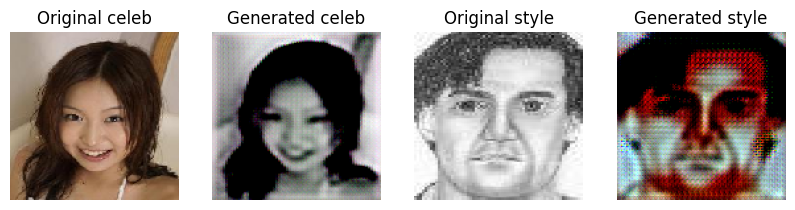

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.023 ,0.058 ] dB[0.189 ,0.076] g[24.581 ,26.901]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:54,  1.70it/s]

>2, dA[0.019 ,0.078 ] dB[0.288 ,0.150] g[34.481 ,40.750]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:53,  1.70it/s]

>3, dA[0.041 ,0.027 ] dB[0.118 ,0.048] g[24.479 ,28.125]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.089 ,0.025 ] dB[0.031 ,0.051] g[25.801 ,29.776]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.054 ,0.029 ] dB[0.104 ,0.051] g[31.511 ,35.184]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.69it/s]

>6, dA[0.026 ,0.042 ] dB[0.098 ,0.034] g[20.604 ,22.477]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:52,  1.69it/s]

>7, dA[0.013 ,0.020 ] dB[0.167 ,0.158] g[32.840 ,37.524]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.69it/s]

>8, dA[0.043 ,0.044 ] dB[0.058 ,0.098] g[22.121 ,25.031]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:51,  1.69it/s]

>9, dA[0.036 ,0.009 ] dB[0.064 ,0.166] g[19.176 ,21.323]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:50,  1.69it/s]

>10, dA[0.027 ,0.014 ] dB[0.082 ,0.211] g[22.672 ,26.789]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.68it/s]

>11, dA[0.016 ,0.006 ] dB[0.093 ,0.073] g[19.116 ,20.930]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:52,  1.67it/s]

>12, dA[0.009 ,0.013 ] dB[0.095 ,0.043] g[18.741 ,20.738]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.030 ,0.030 ] dB[0.034 ,0.045] g[24.589 ,27.615]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:48,  1.69it/s]

>14, dA[0.046 ,0.016 ] dB[0.085 ,0.080] g[17.768 ,18.077]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:47,  1.69it/s]

>15, dA[0.014 ,0.019 ] dB[0.087 ,0.063] g[23.123 ,25.235]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:47,  1.68it/s]

>16, dA[0.021 ,0.018 ] dB[0.548 ,1.066] g[21.004 ,25.817]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:46,  1.69it/s]

>17, dA[0.016 ,0.016 ] dB[0.104 ,0.753] g[26.435 ,27.880]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:45,  1.70it/s]

>18, dA[0.025 ,0.015 ] dB[0.296 ,1.202] g[19.670 ,23.260]
1/1 [==============================] - 0s 23ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:44,  1.69it/s]

>19, dA[0.033 ,0.025 ] dB[0.200 ,1.412] g[15.057 ,16.219]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.68it/s]

>20, dA[0.085 ,0.117 ] dB[0.681 ,1.126] g[36.115 ,41.354]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.064 ,0.079 ] dB[0.343 ,0.447] g[25.139 ,29.900]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.68it/s]

>22, dA[0.125 ,0.118 ] dB[0.387 ,0.408] g[20.958 ,20.670]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.199 ,0.066 ] dB[0.301 ,0.116] g[23.340 ,26.024]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.67it/s]

>24, dA[0.102 ,0.073 ] dB[0.185 ,0.283] g[19.800 ,23.823]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:44,  1.67it/s]

>25, dA[0.053 ,0.125 ] dB[0.640 ,0.083] g[27.782 ,30.450]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:43,  1.67it/s]

>26, dA[0.135 ,0.148 ] dB[0.720 ,0.152] g[26.339 ,27.840]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.066 ,0.208 ] dB[0.044 ,0.058] g[21.482 ,24.690]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.031 ,0.054 ] dB[0.049 ,0.120] g[24.010 ,28.150]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.014 ,0.034 ] dB[0.060 ,0.288] g[22.565 ,24.285]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.029 ,0.039 ] dB[0.178 ,0.101] g[25.391 ,27.559]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:37,  1.70it/s]

>31, dA[0.026 ,0.034 ] dB[0.077 ,0.127] g[26.905 ,28.552]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:18<03:37,  1.69it/s]

>32, dA[0.021 ,0.016 ] dB[0.049 ,0.080] g[27.122 ,32.427]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.022 ,0.028 ] dB[0.086 ,0.039] g[22.361 ,24.520]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:35,  1.70it/s]

>34, dA[0.029 ,0.067 ] dB[0.144 ,0.037] g[19.947 ,22.479]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:34,  1.70it/s]

>35, dA[0.027 ,0.098 ] dB[0.138 ,0.135] g[25.056 ,26.038]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:34,  1.69it/s]

>36, dA[0.109 ,0.051 ] dB[0.076 ,0.054] g[25.046 ,28.746]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:34,  1.69it/s]

>37, dA[0.040 ,0.102 ] dB[0.115 ,0.075] g[13.719 ,14.776]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:32,  1.70it/s]

>38, dA[0.036 ,0.037 ] dB[0.067 ,0.035] g[19.502 ,23.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:31,  1.70it/s]

>39, dA[0.023 ,0.021 ] dB[0.044 ,0.048] g[17.919 ,19.889]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.69it/s]

>40, dA[0.064 ,0.038 ] dB[0.078 ,0.062] g[21.097 ,23.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:31,  1.70it/s]

>41, dA[0.092 ,0.070 ] dB[0.087 ,0.103] g[19.985 ,24.762]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 42/400 [00:24<03:30,  1.70it/s]

>42, dA[0.058 ,0.036 ] dB[0.039 ,0.065] g[23.539 ,26.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:30,  1.70it/s]

>43, dA[0.064 ,0.062 ] dB[0.028 ,0.088] g[19.795 ,22.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:30,  1.69it/s]

>44, dA[0.032 ,0.040 ] dB[0.216 ,0.063] g[18.898 ,20.852]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:28,  1.70it/s]

>45, dA[0.082 ,0.042 ] dB[0.104 ,0.025] g[25.159 ,28.265]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:27,  1.70it/s]

>46, dA[0.087 ,0.038 ] dB[0.078 ,0.049] g[27.404 ,30.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:27,  1.70it/s]

>47, dA[0.043 ,0.039 ] dB[0.052 ,0.060] g[23.723 ,27.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:27,  1.69it/s]

>48, dA[0.059 ,0.069 ] dB[0.082 ,0.063] g[18.807 ,21.269]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 49/400 [00:28<03:26,  1.70it/s]

>49, dA[0.026 ,0.044 ] dB[0.111 ,0.109] g[28.572 ,31.575]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:25,  1.70it/s]

>50, dA[0.132 ,0.131 ] dB[0.037 ,0.070] g[17.634 ,20.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:25,  1.70it/s]

>51, dA[0.033 ,0.059 ] dB[0.086 ,0.043] g[22.179 ,22.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:25,  1.70it/s]

>52, dA[0.027 ,0.030 ] dB[0.123 ,0.381] g[15.052 ,17.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:24,  1.70it/s]

>53, dA[0.039 ,0.151 ] dB[0.180 ,0.156] g[17.589 ,17.139]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [00:31<03:23,  1.70it/s]

>54, dA[0.035 ,0.036 ] dB[0.322 ,0.313] g[20.645 ,21.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:23,  1.70it/s]

>55, dA[0.029 ,0.076 ] dB[0.132 ,0.107] g[15.594 ,16.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:22,  1.70it/s]

>56, dA[0.061 ,0.031 ] dB[0.061 ,0.055] g[15.172 ,15.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:22,  1.70it/s]

>57, dA[0.120 ,0.085 ] dB[0.068 ,0.044] g[22.511 ,24.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:21,  1.70it/s]

>58, dA[0.093 ,0.131 ] dB[0.041 ,0.037] g[26.287 ,31.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:34<03:20,  1.70it/s]

>59, dA[0.057 ,0.138 ] dB[0.044 ,0.076] g[20.405 ,22.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:20,  1.70it/s]

>60, dA[0.036 ,0.031 ] dB[0.082 ,0.064] g[25.724 ,29.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:19,  1.70it/s]

>61, dA[0.052 ,0.072 ] dB[0.097 ,0.023] g[25.721 ,28.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:18,  1.70it/s]

>62, dA[0.053 ,0.071 ] dB[0.062 ,0.068] g[22.238 ,23.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:17,  1.71it/s]

>63, dA[0.063 ,0.171 ] dB[0.094 ,0.033] g[20.917 ,20.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:19,  1.69it/s]

>64, dA[0.035 ,0.154 ] dB[0.088 ,0.048] g[24.096 ,27.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:20,  1.67it/s]

>65, dA[0.093 ,0.070 ] dB[0.043 ,0.033] g[24.051 ,27.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:19,  1.68it/s]

>66, dA[0.035 ,0.045 ] dB[0.071 ,0.094] g[19.577 ,21.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:17,  1.69it/s]

>67, dA[0.027 ,0.012 ] dB[0.020 ,0.228] g[20.044 ,22.036]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 68/400 [00:40<04:06,  1.35it/s]

>68, dA[0.029 ,0.017 ] dB[0.107 ,0.075] g[19.948 ,21.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:51,  1.43it/s]

>69, dA[0.016 ,0.024 ] dB[0.018 ,0.044] g[19.292 ,21.541]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:40,  1.50it/s]

>70, dA[0.055 ,0.072 ] dB[0.035 ,0.026] g[17.505 ,18.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:32,  1.55it/s]

>71, dA[0.039 ,0.058 ] dB[0.123 ,0.127] g[18.503 ,22.465]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:27,  1.58it/s]

>72, dA[0.057 ,0.035 ] dB[0.034 ,0.047] g[16.112 ,16.762]
1/1 [==============================] - 0s 23ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:24,  1.60it/s]

>73, dA[0.071 ,0.060 ] dB[0.144 ,0.149] g[22.026 ,25.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:20,  1.62it/s]

>74, dA[0.055 ,0.040 ] dB[0.081 ,0.108] g[25.574 ,32.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:18,  1.64it/s]

>75, dA[0.060 ,0.051 ] dB[0.177 ,0.265] g[21.016 ,23.296]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:16,  1.65it/s]

>76, dA[0.082 ,0.075 ] dB[0.045 ,0.167] g[28.044 ,33.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:15,  1.65it/s]

>77, dA[0.036 ,0.056 ] dB[0.059 ,0.139] g[16.891 ,20.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:13,  1.66it/s]

>78, dA[0.024 ,0.028 ] dB[0.220 ,0.177] g[17.372 ,18.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:12,  1.67it/s]

>79, dA[0.014 ,0.022 ] dB[0.026 ,0.050] g[25.223 ,27.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:11,  1.67it/s]

>80, dA[0.018 ,0.048 ] dB[0.024 ,0.024] g[17.418 ,19.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:10,  1.68it/s]

>81, dA[0.030 ,0.016 ] dB[0.029 ,0.050] g[31.473 ,37.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 82/400 [00:49<03:09,  1.68it/s]

>82, dA[0.015 ,0.012 ] dB[0.081 ,0.044] g[31.053 ,34.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.058 ,0.089 ] dB[0.070 ,0.034] g[19.689 ,22.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:50<03:07,  1.69it/s]

>84, dA[0.029 ,0.056 ] dB[0.033 ,0.031] g[21.120 ,23.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.033 ,0.059 ] dB[0.043 ,0.013] g[16.670 ,18.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.69it/s]

>86, dA[0.042 ,0.053 ] dB[0.023 ,0.023] g[23.860 ,27.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:04,  1.70it/s]

>87, dA[0.037 ,0.042 ] dB[0.030 ,0.032] g[19.494 ,22.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.69it/s]

>88, dA[0.015 ,0.022 ] dB[0.043 ,0.046] g[24.696 ,27.100]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.68it/s]

>89, dA[0.026 ,0.021 ] dB[0.113 ,0.046] g[23.778 ,29.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.043 ,0.056 ] dB[0.060 ,0.095] g[16.382 ,17.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:02,  1.69it/s]

>91, dA[0.027 ,0.027 ] dB[0.050 ,0.125] g[25.832 ,30.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.042 ,0.024 ] dB[0.058 ,0.042] g[23.363 ,25.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:02,  1.68it/s]

>93, dA[0.022 ,0.020 ] dB[0.034 ,0.031] g[20.993 ,24.855]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:01,  1.69it/s]

>94, dA[0.019 ,0.030 ] dB[0.049 ,0.029] g[18.282 ,20.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.009 ,0.027 ] dB[0.053 ,0.070] g[20.802 ,21.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:00,  1.68it/s]

>96, dA[0.028 ,0.073 ] dB[0.065 ,0.049] g[22.333 ,25.679]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.68it/s]

>97, dA[0.031 ,0.047 ] dB[0.048 ,0.033] g[30.838 ,36.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.69it/s]

>98, dA[0.020 ,0.039 ] dB[0.035 ,0.024] g[18.701 ,22.406]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:58,  1.69it/s]

>99, dA[0.018 ,0.037 ] dB[0.028 ,0.027] g[26.457 ,31.000]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.016 ,0.033 ] dB[0.018 ,0.013] g[20.352 ,22.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.69it/s]

>101, dA[0.037 ,0.336 ] dB[0.033 ,0.072] g[20.901 ,22.432]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.112 ,0.426 ] dB[0.098 ,0.024] g[18.739 ,20.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.69it/s]

>103, dA[0.082 ,0.304 ] dB[0.114 ,0.048] g[27.699 ,32.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:55,  1.68it/s]

>104, dA[0.382 ,0.231 ] dB[0.042 ,0.031] g[18.610 ,20.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.139 ,0.170 ] dB[0.032 ,0.024] g[20.060 ,22.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.68it/s]

>106, dA[0.161 ,0.089 ] dB[0.028 ,0.029] g[15.508 ,15.385]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:56,  1.66it/s]

>107, dA[0.082 ,0.124 ] dB[0.030 ,0.056] g[19.274 ,21.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:55,  1.67it/s]

>108, dA[0.050 ,0.182 ] dB[0.083 ,0.061] g[19.410 ,19.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.67it/s]

>109, dA[0.203 ,0.059 ] dB[0.031 ,0.118] g[23.537 ,27.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.039 ,0.081 ] dB[0.092 ,0.067] g[27.759 ,30.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.69it/s]

>111, dA[0.052 ,0.042 ] dB[0.064 ,0.021] g[18.101 ,20.280]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.073 ,0.128 ] dB[0.018 ,0.012] g[17.589 ,18.241]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.68it/s]

>113, dA[0.040 ,0.231 ] dB[0.024 ,0.016] g[29.897 ,35.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:49,  1.69it/s]

>114, dA[0.355 ,0.045 ] dB[0.017 ,0.014] g[26.499 ,32.007]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.69it/s]

>115, dA[0.119 ,0.096 ] dB[0.053 ,0.056] g[23.960 ,23.989]
1/1 [==============================] - 0s 33ms/step



Batchs:  29%|██▉       | 116/400 [01:09<03:01,  1.56it/s]

>116, dA[0.108 ,0.069 ] dB[0.343 ,0.537] g[19.185 ,21.966]
1/1 [==============================] - 0s 24ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:57,  1.59it/s]

>117, dA[0.144 ,0.074 ] dB[0.032 ,0.304] g[15.297 ,15.411]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:53,  1.62it/s]

>118, dA[0.107 ,0.109 ] dB[0.239 ,0.321] g[20.382 ,24.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:50,  1.65it/s]

>119, dA[0.133 ,0.189 ] dB[0.180 ,0.173] g[13.576 ,15.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:49,  1.65it/s]

>120, dA[0.125 ,0.301 ] dB[0.080 ,0.186] g[24.106 ,27.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:12<02:47,  1.66it/s]

>121, dA[0.137 ,0.110 ] dB[0.252 ,0.094] g[20.177 ,22.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.67it/s]

>122, dA[0.081 ,0.106 ] dB[0.035 ,0.048] g[21.278 ,24.213]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 123/400 [01:13<02:44,  1.68it/s]

>123, dA[0.075 ,0.222 ] dB[0.028 ,0.038] g[27.621 ,31.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:14<02:44,  1.68it/s]

>124, dA[0.119 ,0.080 ] dB[0.159 ,0.326] g[19.715 ,22.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.081 ,0.023 ] dB[0.077 ,0.209] g[19.415 ,21.612]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:42,  1.69it/s]

>126, dA[0.087 ,0.099 ] dB[0.095 ,0.275] g[24.868 ,29.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:42,  1.68it/s]

>127, dA[0.039 ,0.037 ] dB[0.104 ,0.293] g[22.615 ,23.623]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:43,  1.66it/s]

>128, dA[0.073 ,0.028 ] dB[0.156 ,0.230] g[26.034 ,27.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.061 ,0.110 ] dB[0.028 ,0.254] g[24.834 ,27.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.68it/s]

>130, dA[0.033 ,0.023 ] dB[0.201 ,0.084] g[32.057 ,38.338]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:40,  1.68it/s]

>131, dA[0.025 ,0.052 ] dB[0.050 ,0.062] g[18.117 ,20.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.009 ,0.023 ] dB[0.064 ,0.104] g[21.016 ,22.454]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.68it/s]

>133, dA[0.009 ,0.030 ] dB[0.054 ,0.101] g[19.147 ,22.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:38,  1.68it/s]

>134, dA[0.026 ,0.113 ] dB[0.046 ,0.293] g[18.383 ,17.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.67it/s]

>135, dA[0.121 ,0.021 ] dB[0.110 ,0.109] g[22.413 ,24.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.67it/s]

>136, dA[0.030 ,0.029 ] dB[0.093 ,0.051] g[22.226 ,23.922]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:37,  1.67it/s]

>137, dA[0.067 ,0.098 ] dB[0.020 ,0.045] g[17.300 ,18.461]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:36,  1.68it/s]

>138, dA[0.023 ,0.045 ] dB[0.048 ,0.012] g[22.801 ,25.763]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:35,  1.68it/s]

>139, dA[0.020 ,0.017 ] dB[0.039 ,0.036] g[20.963 ,23.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.68it/s]

>140, dA[0.021 ,0.018 ] dB[0.039 ,0.088] g[31.223 ,37.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:34,  1.67it/s]

>141, dA[0.024 ,0.032 ] dB[0.141 ,0.031] g[23.503 ,26.147]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:34,  1.67it/s]

>142, dA[0.021 ,0.012 ] dB[0.155 ,0.045] g[28.089 ,31.605]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:33,  1.68it/s]

>143, dA[0.025 ,0.037 ] dB[0.023 ,0.011] g[19.319 ,21.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:32,  1.68it/s]

>144, dA[0.021 ,0.052 ] dB[0.016 ,0.013] g[20.359 ,22.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:31,  1.68it/s]

>145, dA[0.026 ,0.016 ] dB[0.020 ,0.032] g[27.564 ,32.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:30,  1.69it/s]

>146, dA[0.017 ,0.012 ] dB[0.022 ,0.019] g[29.762 ,34.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.034 ,0.035 ] dB[0.014 ,0.014] g[20.764 ,21.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.69it/s]

>148, dA[0.028 ,0.100 ] dB[0.015 ,0.009] g[23.699 ,26.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:28,  1.69it/s]

>149, dA[0.058 ,0.016 ] dB[0.022 ,0.017] g[17.592 ,21.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:27,  1.69it/s]

>150, dA[0.017 ,0.007 ] dB[0.017 ,0.027] g[25.729 ,30.039]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:26,  1.70it/s]

>151, dA[0.040 ,0.107 ] dB[0.019 ,0.073] g[20.804 ,22.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.077 ,0.041 ] dB[0.019 ,0.054] g[21.082 ,24.884]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.69it/s]

>153, dA[0.080 ,0.031 ] dB[0.030 ,0.040] g[24.156 ,28.851]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.068 ,0.074 ] dB[0.019 ,0.033] g[22.911 ,22.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:24,  1.69it/s]

>155, dA[0.100 ,0.225 ] dB[0.015 ,0.035] g[21.623 ,22.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:25,  1.68it/s]

>156, dA[0.043 ,0.200 ] dB[0.012 ,0.028] g[19.000 ,20.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.035 ,0.331 ] dB[0.016 ,0.038] g[18.478 ,21.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:23,  1.69it/s]

>158, dA[0.117 ,0.114 ] dB[0.066 ,0.027] g[13.979 ,15.340]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.135 ,0.170 ] dB[0.065 ,0.047] g[27.030 ,32.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:22,  1.68it/s]

>160, dA[0.053 ,0.090 ] dB[0.062 ,0.024] g[31.612 ,35.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:21,  1.69it/s]

>161, dA[0.074 ,0.090 ] dB[0.035 ,0.017] g[19.393 ,23.822]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 162/400 [01:36<02:20,  1.69it/s]

>162, dA[0.033 ,0.251 ] dB[0.362 ,0.568] g[14.174 ,16.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.69it/s]

>163, dA[0.115 ,0.098 ] dB[0.080 ,0.071] g[16.903 ,18.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:19,  1.69it/s]

>164, dA[0.101 ,0.055 ] dB[0.155 ,0.086] g[32.389 ,40.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:19,  1.69it/s]

>165, dA[0.082 ,0.080 ] dB[0.072 ,0.030] g[22.325 ,26.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:18,  1.69it/s]

>166, dA[0.067 ,0.073 ] dB[0.040 ,0.014] g[27.756 ,31.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:17,  1.69it/s]

>167, dA[0.099 ,0.089 ] dB[0.056 ,0.035] g[21.886 ,24.511]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:19,  1.66it/s]

>168, dA[0.013 ,0.029 ] dB[0.047 ,0.024] g[22.704 ,23.145]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:19,  1.65it/s]

>169, dA[0.048 ,0.038 ] dB[0.102 ,0.024] g[19.116 ,21.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:18,  1.66it/s]

>170, dA[0.045 ,0.059 ] dB[0.103 ,0.086] g[24.730 ,26.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:17,  1.67it/s]

>171, dA[0.030 ,0.049 ] dB[0.033 ,0.041] g[20.984 ,22.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:16,  1.67it/s]

>172, dA[0.044 ,0.025 ] dB[0.351 ,0.487] g[16.581 ,18.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.67it/s]

>173, dA[0.019 ,0.029 ] dB[0.133 ,1.186] g[27.151 ,29.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:16,  1.66it/s]

>174, dA[0.022 ,0.044 ] dB[0.958 ,0.607] g[21.461 ,21.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:14,  1.67it/s]

>175, dA[0.024 ,0.021 ] dB[0.832 ,0.190] g[25.541 ,28.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:13,  1.67it/s]

>176, dA[0.060 ,0.117 ] dB[0.179 ,0.174] g[14.545 ,14.794]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:13,  1.67it/s]

>177, dA[0.037 ,0.281 ] dB[0.046 ,0.077] g[22.117 ,23.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.67it/s]

>178, dA[0.116 ,0.057 ] dB[0.140 ,0.224] g[18.684 ,22.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:12,  1.67it/s]

>179, dA[0.051 ,0.044 ] dB[0.201 ,0.097] g[18.909 ,20.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:11,  1.67it/s]

>180, dA[0.040 ,0.023 ] dB[0.205 ,0.091] g[20.001 ,22.915]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:11,  1.67it/s]

>181, dA[0.050 ,0.042 ] dB[0.191 ,0.312] g[25.255 ,27.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.68it/s]

>182, dA[0.032 ,0.041 ] dB[0.312 ,0.377] g[24.814 ,27.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:08,  1.68it/s]

>183, dA[0.049 ,0.054 ] dB[0.129 ,0.377] g[24.561 ,29.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.026 ,0.022 ] dB[0.234 ,0.429] g[22.479 ,26.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.68it/s]

>185, dA[0.027 ,0.039 ] dB[0.777 ,0.224] g[29.995 ,33.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:06,  1.69it/s]

>186, dA[0.064 ,0.062 ] dB[0.211 ,0.242] g[27.503 ,33.262]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.69it/s]

>187, dA[0.056 ,0.033 ] dB[0.278 ,0.092] g[20.708 ,20.788]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.028 ,0.045 ] dB[0.110 ,0.086] g[25.253 ,29.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.69it/s]

>189, dA[0.053 ,0.023 ] dB[0.155 ,0.213] g[21.210 ,22.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.69it/s]

>190, dA[0.034 ,0.027 ] dB[0.044 ,0.256] g[31.031 ,36.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:03,  1.69it/s]

>191, dA[0.013 ,0.019 ] dB[0.304 ,0.181] g[25.423 ,27.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.69it/s]

>192, dA[0.022 ,0.073 ] dB[0.297 ,0.088] g[32.413 ,35.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.69it/s]

>193, dA[0.025 ,0.052 ] dB[0.164 ,0.544] g[20.814 ,24.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:01,  1.70it/s]

>194, dA[0.051 ,0.071 ] dB[0.277 ,0.120] g[25.290 ,26.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:00,  1.70it/s]

>195, dA[0.033 ,0.030 ] dB[0.164 ,0.087] g[18.543 ,19.656]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:00,  1.70it/s]

>196, dA[0.023 ,0.067 ] dB[0.054 ,0.053] g[17.527 ,19.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<01:59,  1.70it/s]

>197, dA[0.036 ,0.085 ] dB[0.059 ,0.039] g[29.328 ,33.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<01:59,  1.70it/s]

>198, dA[0.076 ,0.076 ] dB[0.032 ,0.052] g[21.089 ,22.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:58,  1.70it/s]

>199, dA[0.051 ,0.046 ] dB[0.027 ,0.089] g[22.227 ,25.879]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.061 ,0.062 ] dB[0.049 ,0.058] g[25.451 ,27.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.69it/s]

>201, dA[0.038 ,0.057 ] dB[0.067 ,0.029] g[24.812 ,27.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.68it/s]

>202, dA[0.038 ,0.039 ] dB[0.049 ,0.036] g[21.801 ,26.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.69it/s]

>203, dA[0.053 ,0.016 ] dB[0.066 ,0.038] g[16.736 ,18.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.078 ,0.032 ] dB[0.030 ,0.031] g[16.741 ,17.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.68it/s]

>205, dA[0.026 ,0.027 ] dB[0.024 ,0.029] g[13.305 ,15.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.69it/s]

>206, dA[0.010 ,0.033 ] dB[0.020 ,0.021] g[25.421 ,29.324]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.69it/s]

>207, dA[0.019 ,0.013 ] dB[0.024 ,0.021] g[17.861 ,19.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:53,  1.69it/s]

>208, dA[0.012 ,0.016 ] dB[0.032 ,0.031] g[23.245 ,27.389]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.68it/s]

>209, dA[0.023 ,0.018 ] dB[0.021 ,0.091] g[35.883 ,41.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.69it/s]

>210, dA[0.019 ,0.017 ] dB[0.031 ,0.081] g[22.888 ,25.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:51,  1.69it/s]

>211, dA[0.032 ,0.066 ] dB[0.030 ,0.027] g[15.869 ,17.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.69it/s]

>212, dA[0.018 ,0.062 ] dB[0.019 ,0.052] g[26.341 ,31.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:50,  1.69it/s]

>213, dA[0.030 ,0.022 ] dB[0.067 ,0.094] g[23.505 ,28.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:49,  1.69it/s]

>214, dA[0.018 ,0.057 ] dB[0.082 ,0.111] g[22.258 ,25.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.69it/s]

>215, dA[0.018 ,0.059 ] dB[0.074 ,0.033] g[27.935 ,31.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.68it/s]

>216, dA[0.024 ,0.062 ] dB[0.046 ,0.030] g[18.400 ,19.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.68it/s]

>217, dA[0.053 ,0.026 ] dB[0.042 ,0.055] g[27.159 ,32.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:47,  1.69it/s]

>218, dA[0.045 ,0.094 ] dB[0.030 ,0.148] g[20.252 ,23.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.69it/s]

>219, dA[0.049 ,0.009 ] dB[0.243 ,0.153] g[16.086 ,17.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:47,  1.67it/s]

>220, dA[0.030 ,0.055 ] dB[0.048 ,0.060] g[15.651 ,16.856]
1/1 [==============================] - 0s 29ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:48,  1.65it/s]

>221, dA[0.015 ,0.031 ] dB[0.054 ,0.060] g[32.715 ,37.833]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:48,  1.64it/s]

>222, dA[0.061 ,0.090 ] dB[0.045 ,0.033] g[23.463 ,27.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:46,  1.65it/s]

>223, dA[0.037 ,0.036 ] dB[0.043 ,0.029] g[15.066 ,15.636]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:46,  1.65it/s]

>224, dA[0.045 ,0.082 ] dB[0.038 ,0.058] g[28.222 ,33.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:51,  1.57it/s]

>225, dA[0.053 ,0.010 ] dB[0.015 ,0.113] g[31.298 ,35.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:48,  1.60it/s]

>226, dA[0.027 ,0.019 ] dB[0.050 ,0.035] g[18.095 ,19.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:46,  1.63it/s]

>227, dA[0.035 ,0.106 ] dB[0.292 ,0.449] g[14.489 ,15.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:44,  1.65it/s]

>228, dA[0.456 ,1.244 ] dB[0.356 ,0.203] g[15.345 ,19.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:43,  1.66it/s]

>229, dA[0.240 ,0.873 ] dB[0.179 ,0.174] g[20.173 ,24.223]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:42,  1.65it/s]

>230, dA[0.985 ,0.485 ] dB[0.147 ,0.081] g[24.927 ,30.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:41,  1.66it/s]

>231, dA[1.179 ,1.232 ] dB[0.239 ,0.179] g[27.447 ,37.521]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.66it/s]

>232, dA[0.656 ,1.753 ] dB[0.082 ,0.080] g[31.172 ,37.125]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:40,  1.66it/s]

>233, dA[0.560 ,0.844 ] dB[0.056 ,0.026] g[16.920 ,18.854]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:39,  1.66it/s]

>234, dA[0.120 ,0.402 ] dB[0.025 ,0.033] g[19.301 ,21.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.67it/s]

>235, dA[0.378 ,0.169 ] dB[0.141 ,0.118] g[19.166 ,22.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:38,  1.67it/s]

>236, dA[0.256 ,0.323 ] dB[0.077 ,0.017] g[21.729 ,23.484]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:38,  1.66it/s]

>237, dA[0.092 ,0.093 ] dB[0.031 ,0.017] g[21.907 ,24.845]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:37,  1.66it/s]

>238, dA[0.220 ,0.353 ] dB[0.019 ,0.027] g[22.921 ,27.198]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:37,  1.66it/s]

>239, dA[0.088 ,0.135 ] dB[0.019 ,0.032] g[18.536 ,20.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:37,  1.64it/s]

>240, dA[0.119 ,0.080 ] dB[0.028 ,0.027] g[17.829 ,19.296]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:37,  1.64it/s]

>241, dA[0.218 ,0.138 ] dB[0.019 ,0.019] g[18.035 ,20.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:35,  1.65it/s]

>242, dA[0.199 ,0.205 ] dB[0.077 ,0.015] g[22.722 ,24.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:34,  1.66it/s]

>243, dA[0.233 ,0.341 ] dB[0.024 ,0.020] g[23.323 ,25.793]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:33,  1.66it/s]

>244, dA[0.058 ,0.116 ] dB[0.024 ,0.046] g[17.784 ,20.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.67it/s]

>245, dA[0.101 ,0.031 ] dB[0.016 ,0.063] g[25.808 ,31.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.139 ,0.228 ] dB[0.026 ,0.018] g[18.415 ,20.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.060 ,0.033 ] dB[0.029 ,0.015] g[25.547 ,28.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:31,  1.67it/s]

>248, dA[0.053 ,0.028 ] dB[0.013 ,0.006] g[15.809 ,17.654]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:30,  1.67it/s]

>249, dA[0.029 ,0.023 ] dB[0.025 ,0.018] g[15.378 ,16.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.062 ,0.081 ] dB[0.027 ,0.032] g[27.302 ,32.844]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.097 ,0.127 ] dB[0.013 ,0.040] g[14.211 ,15.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.67it/s]

>252, dA[0.046 ,0.024 ] dB[0.011 ,0.043] g[21.823 ,25.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:27,  1.68it/s]

>253, dA[0.023 ,0.013 ] dB[0.011 ,0.026] g[21.425 ,24.691]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:27,  1.67it/s]

>254, dA[0.033 ,0.028 ] dB[0.035 ,0.037] g[23.046 ,25.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.67it/s]

>255, dA[0.029 ,0.036 ] dB[0.056 ,0.102] g[32.077 ,39.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:26,  1.67it/s]

>256, dA[0.064 ,0.109 ] dB[0.068 ,0.029] g[27.691 ,29.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:25,  1.67it/s]

>257, dA[0.022 ,0.045 ] dB[0.046 ,0.037] g[22.846 ,23.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.68it/s]

>258, dA[0.036 ,0.013 ] dB[0.014 ,0.025] g[22.119 ,23.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.68it/s]

>259, dA[0.020 ,0.028 ] dB[0.011 ,0.029] g[18.252 ,18.590]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.68it/s]

>260, dA[0.024 ,0.039 ] dB[0.025 ,0.033] g[17.795 ,19.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.021 ,0.021 ] dB[0.043 ,0.022] g[21.475 ,24.087]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.68it/s]

>262, dA[0.021 ,0.019 ] dB[0.070 ,0.035] g[23.918 ,28.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:21,  1.69it/s]

>263, dA[0.041 ,0.013 ] dB[0.083 ,0.042] g[19.003 ,20.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.68it/s]

>264, dA[0.035 ,0.013 ] dB[0.180 ,0.369] g[20.608 ,25.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.68it/s]

>265, dA[0.025 ,0.009 ] dB[0.041 ,0.106] g[34.286 ,38.867]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.015 ,0.015 ] dB[0.023 ,0.062] g[16.309 ,17.906]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:18,  1.69it/s]

>267, dA[0.028 ,0.023 ] dB[0.038 ,0.036] g[28.064 ,31.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:18,  1.69it/s]

>268, dA[0.012 ,0.007 ] dB[0.018 ,0.010] g[25.156 ,29.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.68it/s]

>269, dA[0.009 ,0.011 ] dB[0.026 ,0.020] g[35.334 ,40.451]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.67it/s]

>270, dA[0.021 ,0.032 ] dB[0.058 ,0.054] g[18.254 ,20.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.017 ,0.015 ] dB[0.012 ,0.029] g[19.260 ,22.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:17,  1.66it/s]

>272, dA[0.025 ,0.021 ] dB[0.012 ,0.013] g[20.452 ,24.015]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:17,  1.63it/s]

>273, dA[0.009 ,0.016 ] dB[0.021 ,0.021] g[17.497 ,19.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:17,  1.64it/s]

>274, dA[0.010 ,0.009 ] dB[0.036 ,0.021] g[23.642 ,28.414]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:16,  1.64it/s]

>275, dA[0.008 ,0.009 ] dB[0.019 ,0.015] g[22.785 ,25.227]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:15,  1.65it/s]

>276, dA[0.012 ,0.009 ] dB[0.041 ,0.020] g[17.292 ,19.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:14,  1.65it/s]

>277, dA[0.017 ,0.018 ] dB[0.030 ,0.021] g[19.844 ,21.967]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:13,  1.66it/s]

>278, dA[0.027 ,0.018 ] dB[0.213 ,0.476] g[19.801 ,23.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.67it/s]

>279, dA[0.027 ,0.026 ] dB[0.060 ,0.244] g[26.643 ,31.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:12,  1.66it/s]

>280, dA[0.022 ,0.043 ] dB[0.081 ,0.122] g[18.510 ,21.439]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:11,  1.66it/s]

>281, dA[0.071 ,0.088 ] dB[0.081 ,0.196] g[18.060 ,17.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.67it/s]

>282, dA[0.151 ,0.364 ] dB[0.045 ,0.407] g[15.151 ,16.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:09,  1.67it/s]

>283, dA[0.071 ,0.038 ] dB[0.259 ,0.199] g[15.587 ,17.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.67it/s]

>284, dA[0.018 ,0.026 ] dB[0.055 ,0.425] g[26.374 ,29.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:08,  1.67it/s]

>285, dA[0.034 ,0.018 ] dB[0.131 ,0.164] g[24.232 ,26.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:08,  1.67it/s]

>286, dA[0.018 ,0.023 ] dB[0.075 ,0.131] g[21.793 ,26.550]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.68it/s]

>287, dA[0.043 ,0.066 ] dB[0.028 ,0.103] g[15.430 ,15.789]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:07,  1.67it/s]

>288, dA[0.018 ,0.032 ] dB[0.068 ,0.093] g[30.918 ,38.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.68it/s]

>289, dA[0.022 ,0.032 ] dB[0.128 ,0.151] g[20.577 ,24.420]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.68it/s]

>290, dA[0.009 ,0.043 ] dB[0.035 ,0.051] g[17.964 ,19.623]
1/1 [==============================] - 0s 29ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.67it/s]

>291, dA[0.015 ,0.019 ] dB[0.028 ,0.043] g[16.698 ,19.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.014 ,0.016 ] dB[0.010 ,0.036] g[25.934 ,31.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:03,  1.67it/s]

>293, dA[0.016 ,0.015 ] dB[0.015 ,0.065] g[17.385 ,19.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.68it/s]

>294, dA[0.010 ,0.013 ] dB[0.015 ,0.026] g[18.889 ,21.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.68it/s]

>295, dA[0.045 ,0.089 ] dB[0.029 ,0.022] g[20.519 ,23.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:02,  1.67it/s]

>296, dA[0.064 ,0.098 ] dB[0.021 ,0.028] g[19.243 ,20.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.67it/s]

>297, dA[0.020 ,0.037 ] dB[0.044 ,0.021] g[25.517 ,32.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:00,  1.67it/s]

>298, dA[0.015 ,0.028 ] dB[0.014 ,0.026] g[23.244 ,27.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.68it/s]

>299, dA[0.045 ,0.007 ] dB[0.053 ,0.023] g[16.126 ,17.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<01:02,  1.60it/s]

>300, dA[0.016 ,0.007 ] dB[0.033 ,0.022] g[23.299 ,25.891]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<01:03,  1.56it/s]

>301, dA[0.016 ,0.007 ] dB[0.027 ,0.040] g[24.972 ,28.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<01:01,  1.60it/s]

>302, dA[0.012 ,0.024 ] dB[0.025 ,0.022] g[33.184 ,39.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:59,  1.63it/s]

>303, dA[0.013 ,0.015 ] dB[0.009 ,0.029] g[17.231 ,19.415]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:58,  1.64it/s]

>304, dA[0.043 ,0.119 ] dB[0.017 ,0.019] g[16.069 ,16.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:57,  1.65it/s]

>305, dA[0.098 ,0.157 ] dB[0.015 ,0.018] g[22.884 ,25.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:56,  1.66it/s]

>306, dA[0.117 ,0.082 ] dB[0.012 ,0.016] g[23.428 ,26.928]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:56,  1.65it/s]

>307, dA[0.050 ,0.100 ] dB[0.009 ,0.017] g[22.041 ,24.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:55,  1.65it/s]

>308, dA[0.044 ,0.133 ] dB[0.015 ,0.010] g[21.274 ,23.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.66it/s]

>309, dA[0.089 ,0.064 ] dB[0.025 ,0.015] g[27.009 ,32.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.024 ,0.024 ] dB[0.032 ,0.017] g[22.964 ,25.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.67it/s]

>311, dA[0.012 ,0.014 ] dB[0.018 ,0.011] g[22.474 ,26.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.67it/s]

>312, dA[0.022 ,0.030 ] dB[0.012 ,0.013] g[20.787 ,22.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:52,  1.67it/s]

>313, dA[0.034 ,0.035 ] dB[0.018 ,0.030] g[15.899 ,16.855]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.68it/s]

>314, dA[0.037 ,0.076 ] dB[0.010 ,0.031] g[17.125 ,19.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.68it/s]

>315, dA[0.029 ,0.108 ] dB[0.009 ,0.022] g[20.973 ,22.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.066 ,0.097 ] dB[0.041 ,0.030] g[25.559 ,29.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.67it/s]

>317, dA[0.057 ,0.036 ] dB[0.026 ,0.016] g[28.748 ,32.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:48,  1.68it/s]

>318, dA[0.030 ,0.034 ] dB[0.069 ,0.022] g[22.510 ,25.653]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.67it/s]

>319, dA[0.042 ,0.016 ] dB[0.048 ,0.018] g[15.634 ,16.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.67it/s]

>320, dA[0.038 ,0.029 ] dB[0.009 ,0.015] g[20.134 ,24.497]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.67it/s]

>321, dA[0.019 ,0.081 ] dB[0.180 ,0.238] g[17.473 ,19.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.67it/s]

>322, dA[0.048 ,0.031 ] dB[0.041 ,0.040] g[25.989 ,30.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:45,  1.68it/s]

>323, dA[0.065 ,0.039 ] dB[0.014 ,0.028] g[19.864 ,23.585]
1/1 [==============================] - 0s 29ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:46,  1.65it/s]

>324, dA[0.071 ,0.039 ] dB[0.019 ,0.035] g[14.243 ,16.552]
1/1 [==============================] - 0s 23ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:45,  1.64it/s]

>325, dA[0.063 ,0.052 ] dB[0.020 ,0.036] g[25.643 ,29.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.66it/s]

>326, dA[0.083 ,0.082 ] dB[0.012 ,0.021] g[25.858 ,29.164]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.67it/s]

>327, dA[0.045 ,0.038 ] dB[0.151 ,0.166] g[25.133 ,29.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:43,  1.66it/s]

>328, dA[0.106 ,0.066 ] dB[0.017 ,0.036] g[27.941 ,32.548]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.66it/s]

>329, dA[0.099 ,0.104 ] dB[0.021 ,0.054] g[27.861 ,28.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.67it/s]

>330, dA[0.206 ,0.050 ] dB[0.046 ,0.056] g[16.038 ,18.143]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.67it/s]

>331, dA[0.066 ,0.063 ] dB[0.050 ,0.115] g[18.880 ,22.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.66it/s]

>332, dA[0.030 ,0.077 ] dB[0.072 ,0.091] g[27.607 ,34.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:40,  1.67it/s]

>333, dA[0.166 ,0.055 ] dB[0.018 ,0.096] g[23.856 ,26.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.67it/s]

>334, dA[0.281 ,0.221 ] dB[0.084 ,0.069] g[30.609 ,35.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.68it/s]

>335, dA[0.153 ,0.107 ] dB[0.044 ,0.069] g[20.519 ,23.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.67it/s]

>336, dA[0.128 ,0.075 ] dB[0.027 ,0.119] g[16.453 ,20.614]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.67it/s]

>337, dA[0.047 ,0.091 ] dB[0.008 ,0.094] g[19.040 ,23.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:37,  1.67it/s]

>338, dA[0.017 ,0.043 ] dB[0.032 ,0.041] g[22.856 ,24.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.68it/s]

>339, dA[0.022 ,0.041 ] dB[0.016 ,0.029] g[23.554 ,25.831]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:36,  1.66it/s]

>340, dA[0.033 ,0.026 ] dB[0.029 ,0.018] g[22.451 ,26.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.65it/s]

>341, dA[0.043 ,0.011 ] dB[0.017 ,0.022] g[21.014 ,24.185]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:35,  1.64it/s]

>342, dA[0.009 ,0.009 ] dB[0.034 ,0.065] g[23.926 ,28.261]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:34,  1.65it/s]

>343, dA[0.033 ,0.015 ] dB[0.012 ,0.042] g[17.232 ,18.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.66it/s]

>344, dA[0.009 ,0.013 ] dB[0.154 ,0.265] g[18.630 ,20.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:33,  1.66it/s]

>345, dA[0.034 ,0.023 ] dB[0.035 ,0.079] g[17.900 ,20.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:32,  1.66it/s]

>346, dA[0.039 ,0.051 ] dB[0.113 ,0.191] g[34.542 ,39.296]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.66it/s]

>347, dA[0.043 ,0.061 ] dB[0.062 ,0.141] g[27.338 ,30.170]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:31,  1.66it/s]

>348, dA[0.052 ,0.097 ] dB[0.150 ,0.062] g[30.735 ,35.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.66it/s]

>349, dA[0.017 ,0.043 ] dB[0.059 ,0.050] g[17.547 ,18.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.67it/s]

>350, dA[0.018 ,0.011 ] dB[0.035 ,0.041] g[21.793 ,26.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.68it/s]

>351, dA[0.039 ,0.062 ] dB[0.020 ,0.031] g[19.351 ,21.550]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.68it/s]

>352, dA[0.091 ,0.125 ] dB[0.042 ,0.031] g[18.204 ,20.157]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.68it/s]

>353, dA[0.034 ,0.073 ] dB[0.033 ,0.026] g[21.412 ,24.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.092 ,0.107 ] dB[0.010 ,0.022] g[19.643 ,23.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.68it/s]

>355, dA[0.182 ,0.222 ] dB[0.026 ,0.021] g[16.279 ,18.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.68it/s]

>356, dA[0.195 ,0.479 ] dB[0.157 ,0.228] g[20.438 ,28.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.67it/s]

>357, dA[0.162 ,0.059 ] dB[0.025 ,0.037] g[31.116 ,35.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:25,  1.68it/s]

>358, dA[0.050 ,0.073 ] dB[0.009 ,0.031] g[17.433 ,21.121]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.68it/s]

>359, dA[0.135 ,0.194 ] dB[0.030 ,0.020] g[16.744 ,19.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.68it/s]

>360, dA[0.233 ,0.360 ] dB[0.021 ,0.020] g[30.443 ,37.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.68it/s]

>361, dA[0.251 ,0.469 ] dB[0.022 ,0.018] g[26.527 ,30.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.69it/s]

>362, dA[0.327 ,0.203 ] dB[0.009 ,0.014] g[26.312 ,30.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:21,  1.69it/s]

>363, dA[0.216 ,0.158 ] dB[0.007 ,0.013] g[32.337 ,36.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.68it/s]

>364, dA[0.171 ,0.072 ] dB[0.007 ,0.015] g[23.946 ,26.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.69it/s]

>365, dA[0.102 ,0.046 ] dB[0.008 ,0.018] g[24.676 ,28.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.69it/s]

>366, dA[0.095 ,0.037 ] dB[0.010 ,0.034] g[32.042 ,38.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.69it/s]

>367, dA[0.061 ,0.028 ] dB[0.014 ,0.017] g[26.026 ,27.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.68it/s]

>368, dA[0.035 ,0.043 ] dB[0.101 ,0.091] g[27.785 ,33.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.69it/s]

>369, dA[0.070 ,0.042 ] dB[0.031 ,0.048] g[19.768 ,22.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.69it/s]

>370, dA[0.020 ,0.039 ] dB[0.028 ,0.022] g[15.400 ,16.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.68it/s]

>371, dA[0.031 ,0.014 ] dB[0.087 ,0.035] g[26.367 ,32.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.67it/s]

>372, dA[0.018 ,0.014 ] dB[0.047 ,0.025] g[22.435 ,25.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.67it/s]

>373, dA[0.013 ,0.008 ] dB[0.029 ,0.014] g[23.531 ,26.974]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.66it/s]

>374, dA[0.047 ,0.076 ] dB[0.022 ,0.012] g[30.121 ,33.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.67it/s]

>375, dA[0.032 ,0.024 ] dB[0.009 ,0.009] g[24.251 ,26.167]
1/1 [==============================] - 0s 24ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.65it/s]

>376, dA[0.022 ,0.013 ] dB[0.015 ,0.005] g[23.664 ,28.331]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:14,  1.64it/s]

>377, dA[0.036 ,0.040 ] dB[0.018 ,0.013] g[31.213 ,34.644]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.65it/s]

>378, dA[0.019 ,0.013 ] dB[0.026 ,0.012] g[22.325 ,24.056]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.66it/s]

>379, dA[0.024 ,0.036 ] dB[0.011 ,0.015] g[27.881 ,29.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:12,  1.66it/s]

>380, dA[0.024 ,0.028 ] dB[0.035 ,0.047] g[27.056 ,32.811]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.66it/s]

>381, dA[0.021 ,0.020 ] dB[0.016 ,0.032] g[23.140 ,26.226]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.66it/s]

>382, dA[0.013 ,0.051 ] dB[0.008 ,0.034] g[19.678 ,21.504]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.67it/s]

>383, dA[0.016 ,0.010 ] dB[0.026 ,0.035] g[25.020 ,29.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.67it/s]

>384, dA[0.008 ,0.021 ] dB[0.017 ,0.028] g[29.049 ,32.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.67it/s]

>385, dA[0.026 ,0.009 ] dB[0.067 ,0.022] g[21.324 ,23.885]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.68it/s]

>386, dA[0.023 ,0.035 ] dB[0.160 ,0.308] g[21.854 ,26.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.68it/s]

>387, dA[0.032 ,0.060 ] dB[0.040 ,0.261] g[31.657 ,37.925]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.67it/s]

>388, dA[0.062 ,0.085 ] dB[0.053 ,0.063] g[22.691 ,25.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.67it/s]

>389, dA[0.084 ,0.107 ] dB[0.104 ,0.098] g[17.546 ,19.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.68it/s]

>390, dA[0.060 ,0.064 ] dB[0.033 ,0.050] g[28.147 ,33.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.66it/s]

>391, dA[0.086 ,0.020 ] dB[0.095 ,0.050] g[16.069 ,17.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.65it/s]

>392, dA[0.027 ,0.023 ] dB[0.069 ,0.040] g[27.108 ,32.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:55<00:04,  1.66it/s]

>393, dA[0.106 ,0.095 ] dB[0.056 ,0.038] g[16.214 ,16.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.67it/s]

>394, dA[0.087 ,0.080 ] dB[0.054 ,0.023] g[23.109 ,26.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:02,  1.67it/s]

>395, dA[0.055 ,0.098 ] dB[0.059 ,0.012] g[15.254 ,16.612]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.67it/s]

>396, dA[0.056 ,0.045 ] dB[0.050 ,0.047] g[23.154 ,27.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.67it/s]

>397, dA[0.077 ,0.128 ] dB[0.053 ,0.072] g[24.150 ,27.491]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:58<00:01,  1.68it/s]

>398, dA[0.025 ,0.074 ] dB[0.027 ,0.047] g[30.910 ,34.650]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.68it/s]

>399, dA[0.047 ,0.024 ] dB[0.036 ,0.073] g[21.315 ,23.806]
1/1 [==============================] - 0s 21ms/step



Epochs:  20%|██        | 2/10 [09:17<36:12, 271.60s/it]

>400, dA[0.051 ,0.029 ] dB[0.039 ,0.031] g[22.796 ,26.882]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.031 ,0.021 ] dB[0.028 ,0.057] g[19.558 ,20.186]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:56,  1.68it/s]

>2, dA[0.028 ,0.030 ] dB[0.023 ,0.134] g[16.621 ,21.360]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.031 ,0.050 ] dB[0.040 ,0.172] g[28.911 ,33.281]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:56,  1.68it/s]

>4, dA[0.012 ,0.009 ] dB[0.033 ,0.051] g[18.361 ,19.867]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.009 ,0.011 ] dB[0.088 ,0.030] g[21.011 ,22.946]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.68it/s]

>6, dA[0.024 ,0.019 ] dB[0.037 ,0.083] g[20.778 ,20.896]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.108 ,0.190 ] dB[0.085 ,0.014] g[19.688 ,20.484]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:55,  1.67it/s]

>8, dA[0.064 ,0.184 ] dB[0.045 ,0.030] g[24.518 ,29.596]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:54,  1.67it/s]

>9, dA[0.055 ,0.040 ] dB[0.039 ,0.085] g[20.924 ,21.897]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:53,  1.67it/s]

>10, dA[0.164 ,0.119 ] dB[0.048 ,0.284] g[14.170 ,16.530]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:52,  1.68it/s]

>11, dA[0.174 ,0.082 ] dB[0.180 ,0.306] g[19.811 ,23.326]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:51,  1.67it/s]

>12, dA[0.175 ,0.078 ] dB[0.214 ,0.046] g[18.762 ,20.559]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:51,  1.67it/s]

>13, dA[0.153 ,0.052 ] dB[0.092 ,0.189] g[24.596 ,29.191]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.68it/s]

>14, dA[0.207 ,0.163 ] dB[0.041 ,0.104] g[20.532 ,21.116]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.68it/s]

>15, dA[0.055 ,0.077 ] dB[0.076 ,0.054] g[19.703 ,20.866]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:49,  1.68it/s]

>16, dA[0.040 ,0.019 ] dB[0.021 ,0.052] g[25.768 ,30.256]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:48,  1.67it/s]

>17, dA[0.012 ,0.024 ] dB[0.025 ,0.032] g[24.239 ,28.564]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:47,  1.68it/s]

>18, dA[0.022 ,0.019 ] dB[0.020 ,0.017] g[21.355 ,23.381]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.028 ,0.015 ] dB[0.135 ,0.176] g[21.656 ,25.993]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:47,  1.67it/s]

>20, dA[0.025 ,0.014 ] dB[0.091 ,0.106] g[16.067 ,20.663]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:46,  1.67it/s]

>21, dA[0.032 ,0.033 ] dB[0.028 ,0.103] g[14.331 ,15.742]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:45,  1.67it/s]

>22, dA[0.030 ,0.028 ] dB[0.080 ,0.057] g[35.129 ,41.220]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:45,  1.67it/s]

>23, dA[0.016 ,0.024 ] dB[0.106 ,0.080] g[18.464 ,18.986]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:49,  1.64it/s]

>24, dA[0.017 ,0.011 ] dB[0.053 ,0.050] g[27.542 ,31.773]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:48,  1.64it/s]

>25, dA[0.018 ,0.016 ] dB[0.067 ,0.069] g[17.950 ,21.513]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:46,  1.65it/s]

>26, dA[0.036 ,0.025 ] dB[0.102 ,0.159] g[21.816 ,26.126]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:45,  1.66it/s]

>27, dA[0.050 ,0.039 ] dB[0.044 ,0.072] g[26.369 ,30.544]
1/1 [==============================] - 0s 25ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:48,  1.63it/s]

>28, dA[0.020 ,0.048 ] dB[0.037 ,0.029] g[22.023 ,22.472]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:47,  1.63it/s]

>29, dA[0.032 ,0.030 ] dB[0.029 ,0.064] g[18.897 ,19.907]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:45,  1.64it/s]

>30, dA[0.019 ,0.013 ] dB[0.030 ,0.127] g[16.769 ,20.115]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:43,  1.65it/s]

>31, dA[0.015 ,0.014 ] dB[0.048 ,0.032] g[27.152 ,29.379]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:42,  1.65it/s]

>32, dA[0.010 ,0.021 ] dB[0.071 ,0.038] g[17.991 ,18.521]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:41,  1.66it/s]

>33, dA[0.007 ,0.021 ] dB[0.023 ,0.030] g[20.799 ,24.207]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:41,  1.66it/s]

>34, dA[0.013 ,0.029 ] dB[0.019 ,0.032] g[23.142 ,27.035]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:40,  1.66it/s]

>35, dA[0.016 ,0.014 ] dB[0.070 ,0.023] g[17.994 ,21.679]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:40,  1.65it/s]

>36, dA[0.012 ,0.013 ] dB[0.009 ,0.029] g[20.947 ,24.169]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:41,  1.64it/s]

>37, dA[0.008 ,0.014 ] dB[0.009 ,0.018] g[27.017 ,30.507]
1/1 [==============================] - 0s 26ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:41,  1.63it/s]

>38, dA[0.014 ,0.029 ] dB[0.017 ,0.017] g[15.363 ,16.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:39,  1.65it/s]

>39, dA[0.028 ,0.028 ] dB[0.010 ,0.017] g[24.440 ,27.837]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 40/400 [00:24<03:40,  1.64it/s]

>40, dA[0.017 ,0.035 ] dB[0.021 ,0.043] g[19.418 ,19.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:39,  1.64it/s]

>41, dA[0.039 ,0.034 ] dB[0.013 ,0.012] g[30.577 ,35.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:36,  1.65it/s]

>42, dA[0.061 ,0.062 ] dB[0.010 ,0.015] g[31.075 ,35.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:35,  1.66it/s]

>43, dA[0.024 ,0.040 ] dB[0.016 ,0.013] g[18.146 ,18.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:35,  1.65it/s]

>44, dA[0.088 ,0.044 ] dB[0.010 ,0.015] g[19.846 ,22.573]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:35,  1.65it/s]

>45, dA[0.108 ,0.071 ] dB[0.013 ,0.017] g[29.488 ,32.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:33,  1.66it/s]

>46, dA[0.041 ,0.026 ] dB[0.016 ,0.016] g[19.883 ,21.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:31,  1.67it/s]

>47, dA[0.024 ,0.023 ] dB[0.015 ,0.011] g[16.477 ,18.330]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:31,  1.66it/s]

>48, dA[0.017 ,0.024 ] dB[0.018 ,0.016] g[17.806 ,17.348]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:30,  1.67it/s]

>49, dA[0.012 ,0.008 ] dB[0.011 ,0.016] g[19.960 ,23.864]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:29,  1.67it/s]

>50, dA[0.014 ,0.008 ] dB[0.025 ,0.016] g[18.563 ,20.825]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:28,  1.67it/s]

>51, dA[0.043 ,0.042 ] dB[0.017 ,0.010] g[24.379 ,26.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:29,  1.66it/s]

>52, dA[0.024 ,0.037 ] dB[0.010 ,0.021] g[30.131 ,35.358]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:28,  1.66it/s]

>53, dA[0.062 ,0.082 ] dB[0.035 ,0.010] g[28.140 ,31.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:27,  1.67it/s]

>54, dA[0.044 ,0.023 ] dB[0.030 ,0.012] g[20.162 ,22.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:26,  1.67it/s]

>55, dA[0.024 ,0.011 ] dB[0.006 ,0.029] g[22.013 ,24.255]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:27,  1.66it/s]

>56, dA[0.017 ,0.012 ] dB[0.024 ,0.050] g[20.544 ,21.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:29,  1.64it/s]

>57, dA[0.028 ,0.030 ] dB[0.018 ,0.040] g[21.926 ,25.700]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:27,  1.64it/s]

>58, dA[0.031 ,0.034 ] dB[0.224 ,0.200] g[17.701 ,22.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:26,  1.65it/s]

>59, dA[0.029 ,0.023 ] dB[0.076 ,0.175] g[20.876 ,24.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:25,  1.65it/s]

>60, dA[0.046 ,0.031 ] dB[0.063 ,0.385] g[17.971 ,21.143]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:23,  1.66it/s]

>61, dA[0.017 ,0.017 ] dB[0.517 ,0.193] g[22.353 ,22.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:21,  1.68it/s]

>62, dA[0.019 ,0.020 ] dB[0.090 ,0.047] g[19.255 ,20.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.031 ,0.024 ] dB[0.067 ,0.064] g[18.405 ,20.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.68it/s]

>64, dA[0.051 ,0.034 ] dB[0.213 ,0.414] g[13.245 ,15.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:19,  1.68it/s]

>65, dA[0.028 ,0.028 ] dB[0.260 ,0.174] g[17.980 ,19.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:18,  1.68it/s]

>66, dA[0.024 ,0.020 ] dB[0.155 ,0.389] g[21.296 ,22.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:18,  1.68it/s]

>67, dA[0.035 ,0.014 ] dB[0.109 ,0.121] g[17.084 ,17.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:18,  1.68it/s]

>68, dA[0.014 ,0.037 ] dB[0.053 ,0.113] g[22.035 ,25.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.68it/s]

>69, dA[0.025 ,0.009 ] dB[0.171 ,0.147] g[22.408 ,25.400]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:15,  1.69it/s]

>70, dA[0.023 ,0.014 ] dB[0.162 ,0.079] g[27.868 ,33.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:15,  1.68it/s]

>71, dA[0.017 ,0.006 ] dB[0.245 ,0.092] g[17.671 ,18.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.68it/s]

>72, dA[0.015 ,0.017 ] dB[0.343 ,0.120] g[17.130 ,18.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:16,  1.66it/s]

>73, dA[0.006 ,0.007 ] dB[0.317 ,0.065] g[17.363 ,18.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:15,  1.66it/s]

>74, dA[0.016 ,0.013 ] dB[0.119 ,0.111] g[28.784 ,34.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:14,  1.67it/s]

>75, dA[0.008 ,0.007 ] dB[0.068 ,0.081] g[20.216 ,23.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:14,  1.67it/s]

>76, dA[0.010 ,0.007 ] dB[0.141 ,0.020] g[20.937 ,27.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:12,  1.67it/s]

>77, dA[0.011 ,0.012 ] dB[0.279 ,0.459] g[17.122 ,19.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.006 ,0.009 ] dB[0.030 ,0.240] g[35.224 ,40.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:10,  1.68it/s]

>79, dA[0.008 ,0.004 ] dB[0.040 ,0.154] g[19.989 ,21.534]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 80/400 [00:48<03:16,  1.63it/s]

>80, dA[0.007 ,0.008 ] dB[0.180 ,0.134] g[26.832 ,28.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 81/400 [00:48<03:15,  1.64it/s]

>81, dA[0.007 ,0.005 ] dB[0.120 ,0.048] g[17.907 ,18.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:49<03:12,  1.65it/s]

>82, dA[0.005 ,0.004 ] dB[0.068 ,0.051] g[19.957 ,22.395]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 83/400 [00:49<03:10,  1.67it/s]

>83, dA[0.013 ,0.010 ] dB[0.311 ,0.497] g[18.170 ,20.994]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:09,  1.67it/s]

>84, dA[0.011 ,0.012 ] dB[0.039 ,0.089] g[19.875 ,23.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:08,  1.67it/s]

>85, dA[0.006 ,0.007 ] dB[0.064 ,0.032] g[18.791 ,18.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.009 ,0.004 ] dB[0.047 ,0.040] g[21.573 ,25.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:07,  1.67it/s]

>87, dA[0.018 ,0.007 ] dB[0.023 ,0.052] g[23.166 ,28.804]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:08,  1.66it/s]

>88, dA[0.004 ,0.005 ] dB[0.053 ,0.025] g[24.305 ,27.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:07,  1.66it/s]

>89, dA[0.009 ,0.005 ] dB[0.038 ,0.014] g[25.079 ,28.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:07,  1.65it/s]

>90, dA[0.027 ,0.020 ] dB[0.047 ,0.018] g[29.918 ,35.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:06,  1.66it/s]

>91, dA[0.007 ,0.007 ] dB[0.047 ,0.022] g[19.371 ,21.632]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:05,  1.66it/s]

>92, dA[0.005 ,0.005 ] dB[0.016 ,0.044] g[24.782 ,27.793]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:04,  1.66it/s]

>93, dA[0.009 ,0.021 ] dB[0.023 ,0.071] g[26.333 ,31.192]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.67it/s]

>94, dA[0.007 ,0.006 ] dB[0.041 ,0.071] g[24.374 ,26.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:02,  1.67it/s]

>95, dA[0.011 ,0.016 ] dB[0.044 ,0.059] g[27.459 ,30.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.67it/s]

>96, dA[0.012 ,0.018 ] dB[0.056 ,0.052] g[16.137 ,16.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:01,  1.67it/s]

>97, dA[0.008 ,0.006 ] dB[0.016 ,0.024] g[20.288 ,21.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:00,  1.67it/s]

>98, dA[0.005 ,0.006 ] dB[0.019 ,0.026] g[20.959 ,26.255]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:59,  1.68it/s]

>99, dA[0.015 ,0.014 ] dB[0.017 ,0.019] g[25.073 ,26.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [01:00<03:00,  1.66it/s]

>100, dA[0.025 ,0.032 ] dB[0.013 ,0.023] g[20.426 ,22.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 101/400 [01:00<03:00,  1.66it/s]

>101, dA[0.031 ,0.059 ] dB[0.006 ,0.008] g[17.530 ,20.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:59,  1.66it/s]

>102, dA[0.036 ,0.040 ] dB[0.025 ,0.019] g[25.431 ,31.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:57,  1.67it/s]

>103, dA[0.025 ,0.027 ] dB[0.029 ,0.026] g[17.014 ,18.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:57,  1.67it/s]

>104, dA[0.016 ,0.027 ] dB[0.008 ,0.023] g[25.715 ,30.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:57,  1.67it/s]

>105, dA[0.011 ,0.020 ] dB[0.017 ,0.058] g[30.322 ,36.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:56,  1.67it/s]

>106, dA[0.010 ,0.039 ] dB[0.104 ,0.030] g[18.311 ,20.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:57,  1.65it/s]

>107, dA[0.026 ,0.009 ] dB[0.161 ,0.079] g[18.732 ,21.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:57,  1.65it/s]

>108, dA[0.015 ,0.008 ] dB[0.070 ,0.039] g[23.557 ,26.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:56,  1.65it/s]

>109, dA[0.007 ,0.005 ] dB[0.024 ,0.056] g[17.082 ,17.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:54,  1.66it/s]

>110, dA[0.009 ,0.010 ] dB[0.013 ,0.018] g[21.902 ,24.687]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:53,  1.66it/s]

>111, dA[0.005 ,0.018 ] dB[0.025 ,0.012] g[26.886 ,32.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:52,  1.67it/s]

>112, dA[0.018 ,0.033 ] dB[0.024 ,0.046] g[15.115 ,16.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:51,  1.68it/s]

>113, dA[0.015 ,0.017 ] dB[0.023 ,0.050] g[16.453 ,17.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:50,  1.68it/s]

>114, dA[0.025 ,0.011 ] dB[0.030 ,0.015] g[21.680 ,21.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:49,  1.68it/s]

>115, dA[0.016 ,0.012 ] dB[0.021 ,0.014] g[30.785 ,36.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.010 ,0.009 ] dB[0.024 ,0.029] g[29.220 ,33.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:48,  1.68it/s]

>117, dA[0.010 ,0.008 ] dB[0.012 ,0.021] g[27.403 ,32.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.68it/s]

>118, dA[0.012 ,0.006 ] dB[0.021 ,0.011] g[23.442 ,26.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:46,  1.69it/s]

>119, dA[0.020 ,0.005 ] dB[0.023 ,0.028] g[12.762 ,14.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:12<02:46,  1.68it/s]

>120, dA[0.009 ,0.011 ] dB[0.030 ,0.013] g[23.525 ,26.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.013 ,0.012 ] dB[0.020 ,0.037] g[22.207 ,26.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:13<02:45,  1.68it/s]

>122, dA[0.016 ,0.010 ] dB[0.017 ,0.039] g[12.401 ,13.529]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 123/400 [01:13<02:44,  1.68it/s]

>123, dA[0.010 ,0.007 ] dB[0.013 ,0.053] g[18.182 ,20.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:14<02:44,  1.67it/s]

>124, dA[0.004 ,0.010 ] dB[0.024 ,0.057] g[26.663 ,32.629]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:44,  1.68it/s]

>125, dA[0.016 ,0.042 ] dB[0.197 ,0.152] g[14.630 ,15.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:43,  1.68it/s]

>126, dA[0.019 ,0.061 ] dB[0.072 ,0.070] g[27.794 ,33.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:42,  1.68it/s]

>127, dA[0.014 ,0.011 ] dB[0.081 ,0.066] g[25.198 ,29.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.67it/s]

>128, dA[0.045 ,0.078 ] dB[0.032 ,0.029] g[14.959 ,15.060]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.075 ,0.182 ] dB[0.022 ,0.019] g[19.001 ,18.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:41,  1.67it/s]

>130, dA[0.067 ,0.106 ] dB[0.027 ,0.043] g[18.899 ,20.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:41,  1.67it/s]

>131, dA[0.138 ,0.030 ] dB[0.039 ,0.057] g[26.184 ,30.768]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:44,  1.63it/s]

>132, dA[0.166 ,0.187 ] dB[0.065 ,0.081] g[23.907 ,28.054]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:43,  1.64it/s]

>133, dA[0.118 ,0.081 ] dB[0.034 ,0.135] g[20.029 ,23.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:41,  1.65it/s]

>134, dA[0.051 ,0.065 ] dB[0.032 ,0.064] g[22.538 ,27.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:39,  1.66it/s]

>135, dA[0.061 ,0.049 ] dB[0.042 ,0.017] g[23.692 ,27.396]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:39,  1.66it/s]

>136, dA[0.050 ,0.043 ] dB[0.015 ,0.009] g[22.351 ,25.001]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:38,  1.66it/s]

>137, dA[0.017 ,0.017 ] dB[0.011 ,0.023] g[18.014 ,20.611]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:38,  1.66it/s]

>138, dA[0.014 ,0.013 ] dB[0.023 ,0.045] g[31.820 ,37.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:36,  1.66it/s]

>139, dA[0.023 ,0.019 ] dB[0.023 ,0.025] g[21.111 ,25.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:37,  1.65it/s]

>140, dA[0.011 ,0.009 ] dB[0.010 ,0.012] g[24.346 ,28.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:36,  1.65it/s]

>141, dA[0.026 ,0.026 ] dB[0.007 ,0.024] g[14.727 ,15.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:35,  1.66it/s]

>142, dA[0.016 ,0.020 ] dB[0.043 ,0.020] g[19.345 ,19.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:33,  1.67it/s]

>143, dA[0.006 ,0.014 ] dB[0.018 ,0.018] g[22.438 ,24.816]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:33,  1.66it/s]

>144, dA[0.012 ,0.012 ] dB[0.008 ,0.036] g[15.820 ,16.797]
1/1 [==============================] - 0s 24ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:33,  1.66it/s]

>145, dA[0.035 ,0.017 ] dB[0.061 ,0.020] g[20.599 ,21.326]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:32,  1.66it/s]

>146, dA[0.033 ,0.024 ] dB[0.113 ,0.086] g[23.812 ,25.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:31,  1.67it/s]

>147, dA[0.012 ,0.018 ] dB[0.044 ,0.096] g[26.198 ,31.488]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:31,  1.66it/s]

>148, dA[0.011 ,0.016 ] dB[0.015 ,0.051] g[23.957 ,28.760]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:30,  1.66it/s]

>149, dA[0.016 ,0.015 ] dB[0.032 ,0.035] g[14.475 ,15.911]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 150/400 [01:30<02:29,  1.67it/s]

>150, dA[0.017 ,0.027 ] dB[0.117 ,0.115] g[14.902 ,16.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:29,  1.67it/s]

>151, dA[0.026 ,0.048 ] dB[0.016 ,0.110] g[33.669 ,38.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:31<02:29,  1.66it/s]

>152, dA[0.020 ,0.063 ] dB[0.070 ,0.018] g[32.264 ,35.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:28,  1.66it/s]

>153, dA[0.014 ,0.028 ] dB[0.040 ,0.030] g[21.052 ,21.954]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:27,  1.66it/s]

>154, dA[0.014 ,0.016 ] dB[0.010 ,0.016] g[14.234 ,14.889]
1/1 [==============================] - 0s 24ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:27,  1.66it/s]

>155, dA[0.020 ,0.006 ] dB[0.014 ,0.019] g[22.110 ,25.908]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:27,  1.66it/s]

>156, dA[0.008 ,0.008 ] dB[0.021 ,0.027] g[24.338 ,28.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:34<02:27,  1.64it/s]

>157, dA[0.010 ,0.009 ] dB[0.019 ,0.015] g[22.299 ,25.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:26,  1.66it/s]

>158, dA[0.011 ,0.008 ] dB[0.037 ,0.020] g[15.391 ,17.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:24,  1.67it/s]

>159, dA[0.011 ,0.013 ] dB[0.020 ,0.040] g[27.180 ,31.835]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:36<02:23,  1.67it/s]

>160, dA[0.007 ,0.007 ] dB[0.018 ,0.026] g[21.803 ,23.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:22,  1.67it/s]

>161, dA[0.004 ,0.003 ] dB[0.010 ,0.016] g[18.275 ,20.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:37<02:21,  1.68it/s]

>162, dA[0.010 ,0.011 ] dB[0.008 ,0.018] g[21.120 ,22.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.69it/s]

>163, dA[0.032 ,0.044 ] dB[0.053 ,0.020] g[12.219 ,12.664]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:38<02:20,  1.68it/s]

>164, dA[0.023 ,0.025 ] dB[0.021 ,0.020] g[24.102 ,27.453]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:19,  1.68it/s]

>165, dA[0.021 ,0.034 ] dB[0.019 ,0.020] g[15.037 ,17.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.013 ,0.011 ] dB[0.024 ,0.015] g[19.852 ,25.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:40<02:18,  1.69it/s]

>167, dA[0.051 ,0.050 ] dB[0.013 ,0.005] g[27.866 ,30.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:18,  1.68it/s]

>168, dA[0.009 ,0.025 ] dB[0.013 ,0.010] g[24.040 ,27.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.68it/s]

>169, dA[0.010 ,0.020 ] dB[0.011 ,0.011] g[20.764 ,23.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:17,  1.67it/s]

>170, dA[0.006 ,0.012 ] dB[0.028 ,0.045] g[23.613 ,26.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.67it/s]

>171, dA[0.015 ,0.037 ] dB[0.045 ,0.022] g[27.048 ,31.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:43<02:16,  1.67it/s]

>172, dA[0.015 ,0.040 ] dB[0.017 ,0.019] g[16.260 ,17.792]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:17,  1.65it/s]

>173, dA[0.030 ,0.025 ] dB[0.011 ,0.014] g[21.567 ,22.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:16,  1.66it/s]

>174, dA[0.038 ,0.035 ] dB[0.013 ,0.024] g[16.611 ,17.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:14,  1.67it/s]

>175, dA[0.058 ,0.077 ] dB[0.027 ,0.058] g[18.275 ,19.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:14,  1.67it/s]

>176, dA[0.050 ,0.138 ] dB[0.026 ,0.155] g[22.876 ,25.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:46<02:14,  1.66it/s]

>177, dA[0.027 ,0.016 ] dB[0.116 ,0.085] g[21.994 ,25.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.67it/s]

>178, dA[0.034 ,0.010 ] dB[0.156 ,0.044] g[25.727 ,30.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:11,  1.68it/s]

>179, dA[0.021 ,0.009 ] dB[0.048 ,0.039] g[17.698 ,22.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:11,  1.68it/s]

>180, dA[0.029 ,0.029 ] dB[0.012 ,0.040] g[13.204 ,13.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:10,  1.68it/s]

>181, dA[0.007 ,0.013 ] dB[0.041 ,0.039] g[20.863 ,27.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:49<02:09,  1.68it/s]

>182, dA[0.008 ,0.010 ] dB[0.042 ,0.057] g[15.726 ,15.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.68it/s]

>183, dA[0.030 ,0.018 ] dB[0.019 ,0.066] g[17.989 ,19.602]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:11,  1.65it/s]

>184, dA[0.023 ,0.032 ] dB[0.013 ,0.037] g[18.632 ,18.502]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 185/400 [01:51<02:10,  1.64it/s]

>185, dA[0.009 ,0.017 ] dB[0.009 ,0.034] g[16.289 ,19.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:09,  1.65it/s]

>186, dA[0.013 ,0.020 ] dB[0.034 ,0.044] g[16.212 ,17.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:52<02:08,  1.66it/s]

>187, dA[0.008 ,0.008 ] dB[0.030 ,0.051] g[21.906 ,24.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:07,  1.66it/s]

>188, dA[0.012 ,0.008 ] dB[0.053 ,0.023] g[18.688 ,19.391]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:07,  1.65it/s]

>189, dA[0.009 ,0.008 ] dB[0.015 ,0.011] g[20.075 ,22.314]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 190/400 [01:54<02:07,  1.65it/s]

>190, dA[0.007 ,0.013 ] dB[0.006 ,0.019] g[26.573 ,31.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:06,  1.66it/s]

>191, dA[0.006 ,0.010 ] dB[0.012 ,0.024] g[18.197 ,19.279]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:55<02:05,  1.66it/s]

>192, dA[0.011 ,0.013 ] dB[0.154 ,0.400] g[16.623 ,19.314]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:03,  1.67it/s]

>193, dA[0.009 ,0.007 ] dB[0.135 ,0.357] g[24.549 ,26.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:02,  1.68it/s]

>194, dA[0.011 ,0.031 ] dB[0.174 ,0.083] g[26.372 ,30.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:57<02:01,  1.69it/s]

>195, dA[0.010 ,0.020 ] dB[0.099 ,0.054] g[32.963 ,37.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:01,  1.68it/s]

>196, dA[0.044 ,0.048 ] dB[0.085 ,0.112] g[35.068 ,40.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:58<02:00,  1.68it/s]

>197, dA[0.046 ,0.036 ] dB[0.213 ,0.041] g[30.808 ,35.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<01:59,  1.69it/s]

>198, dA[0.040 ,0.042 ] dB[0.144 ,0.050] g[26.723 ,31.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:59<01:58,  1.69it/s]

>199, dA[0.036 ,0.016 ] dB[0.038 ,0.076] g[21.225 ,22.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [02:00<01:58,  1.69it/s]

>200, dA[0.028 ,0.035 ] dB[0.037 ,0.074] g[19.596 ,20.440]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:57,  1.69it/s]

>201, dA[0.041 ,0.095 ] dB[0.192 ,0.186] g[21.242 ,25.455]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 202/400 [02:01<01:57,  1.69it/s]

>202, dA[0.014 ,0.016 ] dB[0.122 ,0.040] g[21.097 ,23.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.70it/s]

>203, dA[0.009 ,0.020 ] dB[0.091 ,0.052] g[21.454 ,24.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:56,  1.68it/s]

>204, dA[0.007 ,0.007 ] dB[0.040 ,0.028] g[22.356 ,25.649]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████▏    | 205/400 [02:03<01:56,  1.68it/s]

>205, dA[0.016 ,0.012 ] dB[0.030 ,0.059] g[20.086 ,20.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.68it/s]

>206, dA[0.007 ,0.005 ] dB[0.017 ,0.027] g[26.225 ,27.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:04<01:54,  1.68it/s]

>207, dA[0.020 ,0.008 ] dB[0.019 ,0.020] g[18.518 ,19.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.67it/s]

>208, dA[0.005 ,0.006 ] dB[0.011 ,0.018] g[22.956 ,24.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:54,  1.67it/s]

>209, dA[0.008 ,0.007 ] dB[0.015 ,0.014] g[22.752 ,28.020]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.68it/s]

>210, dA[0.014 ,0.007 ] dB[0.009 ,0.023] g[15.122 ,16.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:51,  1.69it/s]

>211, dA[0.017 ,0.033 ] dB[0.011 ,0.047] g[25.638 ,29.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:07<01:51,  1.69it/s]

>212, dA[0.014 ,0.010 ] dB[0.009 ,0.027] g[15.175 ,17.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:51,  1.68it/s]

>213, dA[0.009 ,0.008 ] dB[0.010 ,0.018] g[17.122 ,16.198]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:50,  1.68it/s]

>214, dA[0.022 ,0.014 ] dB[0.027 ,0.009] g[29.124 ,33.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:50,  1.68it/s]

>215, dA[0.010 ,0.011 ] dB[0.256 ,0.396] g[16.696 ,19.469]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:49,  1.68it/s]

>216, dA[0.012 ,0.026 ] dB[0.027 ,0.048] g[18.740 ,18.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:10<01:49,  1.67it/s]

>217, dA[0.016 ,0.016 ] dB[0.017 ,0.069] g[27.850 ,33.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:48,  1.68it/s]

>218, dA[0.034 ,0.013 ] dB[0.039 ,0.030] g[24.655 ,28.504]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:47,  1.68it/s]

>219, dA[0.029 ,0.014 ] dB[0.008 ,0.018] g[20.812 ,22.792]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:47,  1.67it/s]

>220, dA[0.017 ,0.029 ] dB[0.014 ,0.017] g[21.243 ,26.616]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:47,  1.67it/s]

>221, dA[0.017 ,0.027 ] dB[0.019 ,0.027] g[18.017 ,19.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:13<01:46,  1.67it/s]

>222, dA[0.014 ,0.008 ] dB[0.011 ,0.037] g[17.783 ,20.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.68it/s]

>223, dA[0.014 ,0.017 ] dB[0.035 ,0.042] g[26.510 ,29.715]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:45,  1.67it/s]

>224, dA[0.029 ,0.046 ] dB[0.016 ,0.012] g[24.310 ,26.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.67it/s]

>225, dA[0.023 ,0.032 ] dB[0.017 ,0.017] g[21.379 ,24.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:43,  1.68it/s]

>226, dA[0.022 ,0.035 ] dB[0.017 ,0.014] g[17.008 ,19.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:16<01:42,  1.69it/s]

>227, dA[0.025 ,0.032 ] dB[0.022 ,0.011] g[25.069 ,30.928]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:42,  1.68it/s]

>228, dA[0.051 ,0.025 ] dB[0.015 ,0.016] g[25.640 ,29.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:41,  1.68it/s]

>229, dA[0.027 ,0.011 ] dB[0.023 ,0.020] g[24.349 ,25.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.024 ,0.079 ] dB[0.008 ,0.013] g[13.281 ,13.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:40,  1.69it/s]

>231, dA[0.023 ,0.051 ] dB[0.017 ,0.018] g[26.309 ,29.211]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:19<01:40,  1.68it/s]

>232, dA[0.038 ,0.050 ] dB[0.020 ,0.011] g[24.075 ,27.701]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:39,  1.68it/s]

>233, dA[0.016 ,0.033 ] dB[0.007 ,0.009] g[18.829 ,22.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:38,  1.68it/s]

>234, dA[0.053 ,0.057 ] dB[0.008 ,0.007] g[20.383 ,23.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:37,  1.69it/s]

>235, dA[0.110 ,0.039 ] dB[0.007 ,0.017] g[18.630 ,20.408]
1/1 [==============================] - 0s 29ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:39,  1.65it/s]

>236, dA[0.064 ,0.022 ] dB[0.008 ,0.011] g[19.716 ,22.542]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 237/400 [02:22<01:39,  1.64it/s]

>237, dA[0.102 ,0.037 ] dB[0.011 ,0.010] g[19.138 ,20.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:38,  1.65it/s]

>238, dA[0.118 ,0.049 ] dB[0.011 ,0.007] g[22.660 ,26.532]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 239/400 [02:23<01:36,  1.67it/s]

>239, dA[0.115 ,0.014 ] dB[0.012 ,0.011] g[24.411 ,29.543]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:36,  1.66it/s]

>240, dA[0.127 ,0.029 ] dB[0.012 ,0.013] g[20.617 ,24.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:35,  1.66it/s]

>241, dA[0.041 ,0.020 ] dB[0.016 ,0.013] g[23.201 ,26.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 242/400 [02:25<01:35,  1.66it/s]

>242, dA[0.054 ,0.037 ] dB[0.018 ,0.014] g[14.255 ,16.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:34,  1.66it/s]

>243, dA[0.075 ,0.068 ] dB[0.023 ,0.020] g[22.348 ,23.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:26<01:33,  1.66it/s]

>244, dA[0.136 ,0.173 ] dB[0.028 ,0.031] g[18.396 ,19.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:33,  1.66it/s]

>245, dA[0.150 ,0.093 ] dB[0.020 ,0.027] g[20.519 ,19.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:31,  1.68it/s]

>246, dA[0.228 ,0.208 ] dB[0.024 ,0.025] g[16.650 ,17.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 247/400 [02:28<01:30,  1.69it/s]

>247, dA[0.225 ,0.101 ] dB[0.017 ,0.014] g[21.099 ,24.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:30,  1.68it/s]

>248, dA[0.060 ,0.066 ] dB[0.013 ,0.009] g[25.805 ,29.285]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:29<01:29,  1.69it/s]

>249, dA[0.069 ,0.050 ] dB[0.014 ,0.004] g[23.149 ,26.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:28,  1.69it/s]

>250, dA[0.042 ,0.041 ] dB[0.008 ,0.011] g[20.333 ,23.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:27,  1.70it/s]

>251, dA[0.040 ,0.051 ] dB[0.011 ,0.009] g[15.103 ,16.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:31<01:27,  1.69it/s]

>252, dA[0.140 ,0.306 ] dB[0.012 ,0.010] g[13.028 ,14.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:26,  1.69it/s]

>253, dA[0.096 ,0.041 ] dB[0.011 ,0.011] g[23.167 ,26.967]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 254/400 [02:32<01:25,  1.70it/s]

>254, dA[0.050 ,0.035 ] dB[0.015 ,0.005] g[19.989 ,23.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:25,  1.70it/s]

>255, dA[0.047 ,0.062 ] dB[0.004 ,0.005] g[16.479 ,18.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:25,  1.69it/s]

>256, dA[0.090 ,0.088 ] dB[0.009 ,0.018] g[19.622 ,20.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:34<01:24,  1.69it/s]

>257, dA[0.047 ,0.055 ] dB[0.010 ,0.011] g[22.158 ,24.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.68it/s]

>258, dA[0.067 ,0.042 ] dB[0.024 ,0.051] g[16.641 ,19.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:35<01:23,  1.69it/s]

>259, dA[0.137 ,0.121 ] dB[0.012 ,0.084] g[12.390 ,12.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:22,  1.69it/s]

>260, dA[0.195 ,0.219 ] dB[0.029 ,0.041] g[26.499 ,29.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:22,  1.69it/s]

>261, dA[0.050 ,0.294 ] dB[0.087 ,0.033] g[15.913 ,17.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.69it/s]

>262, dA[0.097 ,0.087 ] dB[0.023 ,0.041] g[29.036 ,34.983]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:20,  1.70it/s]

>263, dA[0.017 ,0.114 ] dB[0.042 ,0.023] g[21.234 ,22.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:38<01:20,  1.70it/s]

>264, dA[0.066 ,0.063 ] dB[0.034 ,0.036] g[15.234 ,18.470]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:19,  1.70it/s]

>265, dA[0.081 ,0.040 ] dB[0.043 ,0.096] g[17.155 ,20.163]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:18,  1.70it/s]

>266, dA[0.130 ,0.078 ] dB[0.056 ,0.081] g[22.496 ,26.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:18,  1.70it/s]

>267, dA[0.055 ,0.047 ] dB[0.052 ,0.043] g[25.514 ,28.799]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:17,  1.70it/s]

>268, dA[0.043 ,0.042 ] dB[0.016 ,0.027] g[21.674 ,24.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:41<01:17,  1.70it/s]

>269, dA[0.027 ,0.035 ] dB[0.008 ,0.032] g[21.537 ,26.177]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:16,  1.70it/s]

>270, dA[0.022 ,0.030 ] dB[0.024 ,0.041] g[22.063 ,24.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:15,  1.70it/s]

>271, dA[0.052 ,0.013 ] dB[0.021 ,0.051] g[22.598 ,24.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:15,  1.70it/s]

>272, dA[0.022 ,0.012 ] dB[0.011 ,0.051] g[18.855 ,20.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:14,  1.70it/s]

>273, dA[0.010 ,0.009 ] dB[0.051 ,0.033] g[17.464 ,18.662]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 274/400 [02:44<01:14,  1.70it/s]

>274, dA[0.018 ,0.029 ] dB[0.041 ,0.011] g[18.233 ,19.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.68it/s]

>275, dA[0.010 ,0.033 ] dB[0.018 ,0.014] g[27.110 ,30.148]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:13,  1.68it/s]

>276, dA[0.045 ,0.016 ] dB[0.005 ,0.021] g[19.106 ,20.835]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:12,  1.69it/s]

>277, dA[0.009 ,0.005 ] dB[0.010 ,0.017] g[18.152 ,19.537]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:12,  1.69it/s]

>278, dA[0.006 ,0.010 ] dB[0.007 ,0.008] g[16.703 ,19.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.70it/s]

>279, dA[0.013 ,0.015 ] dB[0.004 ,0.015] g[12.828 ,13.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:10,  1.69it/s]

>280, dA[0.019 ,0.016 ] dB[0.017 ,0.020] g[15.920 ,16.823]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:10,  1.69it/s]

>281, dA[0.010 ,0.013 ] dB[0.010 ,0.029] g[30.585 ,35.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:09,  1.69it/s]

>282, dA[0.026 ,0.015 ] dB[0.010 ,0.010] g[28.279 ,33.415]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:08,  1.70it/s]

>283, dA[0.022 ,0.009 ] dB[0.005 ,0.005] g[17.080 ,18.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.70it/s]

>284, dA[0.010 ,0.006 ] dB[0.211 ,0.461] g[21.053 ,25.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:07,  1.69it/s]

>285, dA[0.010 ,0.004 ] dB[0.027 ,0.120] g[20.252 ,23.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:07,  1.70it/s]

>286, dA[0.012 ,0.020 ] dB[0.045 ,0.101] g[27.392 ,29.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:06,  1.70it/s]

>287, dA[0.009 ,0.013 ] dB[0.044 ,0.066] g[17.897 ,19.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:06,  1.69it/s]

>288, dA[0.011 ,0.005 ] dB[0.021 ,0.056] g[21.656 ,23.745]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:07,  1.63it/s]

>289, dA[0.014 ,0.016 ] dB[0.021 ,0.024] g[16.632 ,19.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:06,  1.65it/s]

>290, dA[0.030 ,0.052 ] dB[0.009 ,0.036] g[19.508 ,20.868]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:05,  1.66it/s]

>291, dA[0.013 ,0.046 ] dB[0.041 ,0.023] g[15.741 ,17.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:05,  1.66it/s]

>292, dA[0.030 ,0.051 ] dB[0.081 ,0.024] g[18.767 ,22.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:04,  1.66it/s]

>293, dA[0.026 ,0.054 ] dB[0.146 ,0.033] g[16.508 ,17.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.68it/s]

>294, dA[0.020 ,0.025 ] dB[0.304 ,0.034] g[22.440 ,26.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.69it/s]

>295, dA[0.021 ,0.008 ] dB[0.219 ,0.024] g[17.348 ,20.156]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:01,  1.69it/s]

>296, dA[0.021 ,0.022 ] dB[0.070 ,0.023] g[15.003 ,16.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:00,  1.69it/s]

>297, dA[0.020 ,0.031 ] dB[0.048 ,0.018] g[22.559 ,26.773]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:00,  1.69it/s]

>298, dA[0.011 ,0.024 ] dB[0.022 ,0.019] g[24.144 ,26.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<00:59,  1.69it/s]

>299, dA[0.012 ,0.006 ] dB[0.035 ,0.035] g[21.715 ,25.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.012 ,0.014 ] dB[0.078 ,0.026] g[21.224 ,23.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<00:58,  1.69it/s]

>301, dA[0.005 ,0.012 ] dB[0.033 ,0.033] g[23.562 ,26.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:57,  1.69it/s]

>302, dA[0.009 ,0.005 ] dB[0.036 ,0.037] g[18.712 ,21.167]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:57,  1.69it/s]

>303, dA[0.011 ,0.005 ] dB[0.034 ,0.028] g[27.882 ,31.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.69it/s]

>304, dA[0.012 ,0.019 ] dB[0.024 ,0.020] g[26.957 ,29.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:56,  1.69it/s]

>305, dA[0.008 ,0.018 ] dB[0.016 ,0.029] g[26.620 ,31.713]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:55,  1.69it/s]

>306, dA[0.012 ,0.023 ] dB[0.031 ,0.074] g[26.526 ,32.112]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:54,  1.69it/s]

>307, dA[0.029 ,0.009 ] dB[0.032 ,0.046] g[15.804 ,17.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:54,  1.68it/s]

>308, dA[0.015 ,0.006 ] dB[0.036 ,0.044] g[26.920 ,28.587]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.68it/s]

>309, dA[0.030 ,0.017 ] dB[0.072 ,0.069] g[20.978 ,25.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.68it/s]

>310, dA[0.033 ,0.015 ] dB[0.027 ,0.066] g[20.153 ,22.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.69it/s]

>311, dA[0.014 ,0.008 ] dB[0.023 ,0.070] g[27.137 ,31.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.68it/s]

>312, dA[0.009 ,0.011 ] dB[0.029 ,0.051] g[30.368 ,36.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:51,  1.69it/s]

>313, dA[0.012 ,0.007 ] dB[0.014 ,0.020] g[20.819 ,24.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:50,  1.69it/s]

>314, dA[0.010 ,0.010 ] dB[0.021 ,0.009] g[19.464 ,21.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.69it/s]

>315, dA[0.022 ,0.033 ] dB[0.020 ,0.020] g[16.239 ,18.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.69it/s]

>316, dA[0.022 ,0.012 ] dB[0.010 ,0.032] g[22.693 ,26.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.69it/s]

>317, dA[0.016 ,0.003 ] dB[0.008 ,0.017] g[25.160 ,27.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:48,  1.70it/s]

>318, dA[0.088 ,0.151 ] dB[0.010 ,0.008] g[21.743 ,23.095]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:47,  1.70it/s]

>319, dA[0.061 ,0.038 ] dB[0.012 ,0.019] g[26.768 ,30.827]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.69it/s]

>320, dA[0.108 ,0.128 ] dB[0.012 ,0.012] g[25.054 ,29.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.109 ,0.169 ] dB[0.017 ,0.028] g[30.582 ,34.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.087 ,0.075 ] dB[0.025 ,0.035] g[18.892 ,22.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:45,  1.69it/s]

>323, dA[0.022 ,0.057 ] dB[0.008 ,0.022] g[22.432 ,26.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.68it/s]

>324, dA[0.065 ,0.047 ] dB[0.011 ,0.039] g[19.447 ,22.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.67it/s]

>325, dA[0.018 ,0.043 ] dB[0.009 ,0.019] g[17.777 ,20.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.68it/s]

>326, dA[0.043 ,0.052 ] dB[0.011 ,0.022] g[20.850 ,28.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.69it/s]

>327, dA[0.068 ,0.059 ] dB[0.014 ,0.022] g[19.303 ,22.498]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:42,  1.69it/s]

>328, dA[0.086 ,0.062 ] dB[0.008 ,0.008] g[15.872 ,17.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:41,  1.70it/s]

>329, dA[0.018 ,0.025 ] dB[0.007 ,0.010] g[23.861 ,25.914]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.70it/s]

>330, dA[0.018 ,0.026 ] dB[0.011 ,0.015] g[20.710 ,22.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:40,  1.70it/s]

>331, dA[0.052 ,0.020 ] dB[0.008 ,0.027] g[17.405 ,20.211]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.70it/s]

>332, dA[0.030 ,0.020 ] dB[0.009 ,0.012] g[16.855 ,17.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.70it/s]

>333, dA[0.015 ,0.012 ] dB[0.014 ,0.009] g[22.693 ,27.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:38,  1.70it/s]

>334, dA[0.027 ,0.011 ] dB[0.024 ,0.011] g[16.420 ,18.500]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.70it/s]

>335, dA[0.018 ,0.018 ] dB[0.014 ,0.031] g[18.802 ,20.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:37,  1.70it/s]

>336, dA[0.018 ,0.019 ] dB[0.027 ,0.057] g[16.135 ,18.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.70it/s]

>337, dA[0.010 ,0.013 ] dB[0.017 ,0.051] g[24.454 ,28.719]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.70it/s]

>338, dA[0.012 ,0.010 ] dB[0.008 ,0.013] g[16.882 ,16.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:35,  1.70it/s]

>339, dA[0.006 ,0.028 ] dB[0.019 ,0.010] g[24.059 ,26.906]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.69it/s]

>340, dA[0.017 ,0.011 ] dB[0.020 ,0.009] g[20.615 ,21.926]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:39,  1.50it/s]

>341, dA[0.028 ,0.021 ] dB[0.028 ,0.017] g[19.443 ,20.694]
1/1 [==============================] - 0s 33ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:38,  1.52it/s]

>342, dA[0.018 ,0.006 ] dB[0.015 ,0.023] g[17.372 ,19.291]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:36,  1.57it/s]

>343, dA[0.033 ,0.015 ] dB[0.045 ,0.043] g[25.815 ,30.944]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:34,  1.60it/s]

>344, dA[0.019 ,0.011 ] dB[0.019 ,0.020] g[19.727 ,19.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:33,  1.63it/s]

>345, dA[0.023 ,0.009 ] dB[0.008 ,0.009] g[21.287 ,24.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.65it/s]

>346, dA[0.006 ,0.003 ] dB[0.007 ,0.011] g[16.272 ,18.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.67it/s]

>347, dA[0.013 ,0.008 ] dB[0.015 ,0.033] g[26.711 ,29.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:31,  1.67it/s]

>348, dA[0.011 ,0.029 ] dB[0.040 ,0.019] g[19.124 ,19.997]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.68it/s]

>349, dA[0.011 ,0.012 ] dB[0.032 ,0.020] g[14.141 ,14.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.68it/s]

>350, dA[0.010 ,0.009 ] dB[0.048 ,0.072] g[15.749 ,17.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.68it/s]

>351, dA[0.038 ,0.035 ] dB[0.015 ,0.024] g[15.879 ,18.216]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.68it/s]

>352, dA[0.025 ,0.015 ] dB[0.061 ,0.080] g[16.799 ,18.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.67it/s]

>353, dA[0.040 ,0.038 ] dB[0.027 ,0.113] g[18.366 ,19.381]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.017 ,0.023 ] dB[0.042 ,0.061] g[21.237 ,25.816]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.68it/s]

>355, dA[0.015 ,0.017 ] dB[0.024 ,0.063] g[17.429 ,22.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.68it/s]

>356, dA[0.017 ,0.007 ] dB[0.064 ,0.032] g[22.335 ,25.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.68it/s]

>357, dA[0.027 ,0.017 ] dB[0.041 ,0.018] g[18.979 ,21.785]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:25,  1.66it/s]

>358, dA[0.016 ,0.016 ] dB[0.016 ,0.014] g[24.434 ,27.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.67it/s]

>359, dA[0.012 ,0.005 ] dB[0.007 ,0.010] g[26.311 ,29.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.67it/s]

>360, dA[0.021 ,0.009 ] dB[0.004 ,0.007] g[26.058 ,28.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.68it/s]

>361, dA[0.023 ,0.020 ] dB[0.023 ,0.037] g[19.769 ,23.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.68it/s]

>362, dA[0.015 ,0.012 ] dB[0.025 ,0.033] g[20.315 ,23.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:21,  1.69it/s]

>363, dA[0.029 ,0.029 ] dB[0.006 ,0.020] g[19.500 ,21.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.68it/s]

>364, dA[0.091 ,0.193 ] dB[0.012 ,0.012] g[19.003 ,24.094]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.68it/s]

>365, dA[0.100 ,0.140 ] dB[0.011 ,0.017] g[14.672 ,17.633]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.68it/s]

>366, dA[0.164 ,0.083 ] dB[0.022 ,0.007] g[15.178 ,17.089]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.68it/s]

>367, dA[0.131 ,0.050 ] dB[0.012 ,0.009] g[30.037 ,33.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.68it/s]

>368, dA[0.099 ,0.058 ] dB[0.027 ,0.016] g[19.290 ,23.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.69it/s]

>369, dA[0.351 ,0.198 ] dB[0.015 ,0.031] g[18.618 ,21.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.69it/s]

>370, dA[0.385 ,0.151 ] dB[0.036 ,0.031] g[17.893 ,20.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.69it/s]

>371, dA[0.091 ,0.114 ] dB[0.039 ,0.032] g[18.320 ,23.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.69it/s]

>372, dA[0.132 ,0.124 ] dB[0.028 ,0.030] g[21.683 ,26.005]
1/1 [==============================] - 0s 23ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.68it/s]

>373, dA[0.155 ,0.085 ] dB[0.010 ,0.037] g[21.378 ,24.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.69it/s]

>374, dA[0.214 ,0.082 ] dB[0.025 ,0.035] g[21.809 ,24.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.69it/s]

>375, dA[0.082 ,0.055 ] dB[0.032 ,0.027] g[13.770 ,15.410]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.68it/s]

>376, dA[0.111 ,0.040 ] dB[0.010 ,0.020] g[16.330 ,16.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.68it/s]

>377, dA[0.039 ,0.078 ] dB[0.015 ,0.011] g[32.776 ,39.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.69it/s]

>378, dA[0.079 ,0.033 ] dB[0.012 ,0.006] g[18.233 ,21.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.68it/s]

>379, dA[0.080 ,0.111 ] dB[0.017 ,0.022] g[17.938 ,19.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.67it/s]

>380, dA[0.051 ,0.110 ] dB[0.021 ,0.025] g[14.350 ,15.295]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.047 ,0.085 ] dB[0.026 ,0.016] g[14.202 ,14.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.69it/s]

>382, dA[0.040 ,0.070 ] dB[0.010 ,0.017] g[26.974 ,34.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.69it/s]

>383, dA[0.026 ,0.049 ] dB[0.007 ,0.012] g[26.327 ,31.539]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.69it/s]

>384, dA[0.081 ,0.060 ] dB[0.009 ,0.027] g[20.305 ,24.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.70it/s]

>385, dA[0.135 ,0.032 ] dB[0.007 ,0.024] g[17.948 ,20.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.70it/s]

>386, dA[0.070 ,0.030 ] dB[0.012 ,0.016] g[23.420 ,28.390]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.70it/s]

>387, dA[0.028 ,0.060 ] dB[0.016 ,0.025] g[20.624 ,22.940]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.70it/s]

>388, dA[0.031 ,0.030 ] dB[0.047 ,0.014] g[21.396 ,27.354]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.69it/s]

>389, dA[0.027 ,0.029 ] dB[0.023 ,0.018] g[23.647 ,26.683]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.69it/s]

>390, dA[0.024 ,0.007 ] dB[0.036 ,0.056] g[18.681 ,21.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.70it/s]

>391, dA[0.039 ,0.009 ] dB[0.016 ,0.044] g[16.132 ,19.722]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.69it/s]

>392, dA[0.040 ,0.019 ] dB[0.010 ,0.014] g[16.892 ,18.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.011 ,0.016 ] dB[0.016 ,0.014] g[21.047 ,24.406]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.65it/s]

>394, dA[0.010 ,0.004 ] dB[0.031 ,0.015] g[28.201 ,33.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:03,  1.66it/s]

>395, dA[0.018 ,0.015 ] dB[0.036 ,0.076] g[18.676 ,23.477]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.67it/s]

>396, dA[0.029 ,0.034 ] dB[0.018 ,0.026] g[23.727 ,26.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.68it/s]

>397, dA[0.041 ,0.022 ] dB[0.023 ,0.021] g[18.168 ,20.993]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.69it/s]

>398, dA[0.034 ,0.008 ] dB[0.029 ,0.036] g[19.822 ,23.391]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.69it/s]

>399, dA[0.013 ,0.011 ] dB[0.007 ,0.020] g[28.817 ,34.898]
1/1 [==============================] - 0s 20ms/step



Epochs:  30%|███       | 3/10 [13:16<29:57, 256.73s/it]

>400, dA[0.041 ,0.026 ] dB[0.020 ,0.012] g[23.330 ,24.793]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:54,  1.70it/s]

>1, dA[0.033 ,0.019 ] dB[0.014 ,0.015] g[21.903 ,24.276]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/400 [00:01<03:53,  1.70it/s]

>2, dA[0.028 ,0.023 ] dB[0.010 ,0.030] g[17.889 ,20.229]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:52,  1.70it/s]

>3, dA[0.019 ,0.007 ] dB[0.006 ,0.023] g[24.021 ,28.710]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.038 ,0.015 ] dB[0.014 ,0.006] g[15.494 ,17.043]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:54,  1.68it/s]

>5, dA[0.027 ,0.026 ] dB[0.007 ,0.014] g[21.350 ,23.352]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.69it/s]

>6, dA[0.012 ,0.016 ] dB[0.009 ,0.065] g[23.718 ,28.111]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:52,  1.69it/s]

>7, dA[0.011 ,0.007 ] dB[0.025 ,0.043] g[17.381 ,20.955]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:51,  1.69it/s]

>8, dA[0.008 ,0.009 ] dB[0.016 ,0.039] g[17.626 ,18.463]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.010 ,0.006 ] dB[0.022 ,0.030] g[26.779 ,29.782]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.68it/s]

>10, dA[0.006 ,0.008 ] dB[0.031 ,0.037] g[24.602 ,28.085]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.69it/s]

>11, dA[0.016 ,0.014 ] dB[0.027 ,0.026] g[18.122 ,21.285]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.031 ,0.016 ] dB[0.036 ,0.014] g[22.981 ,28.462]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:48,  1.69it/s]

>13, dA[0.010 ,0.008 ] dB[0.027 ,0.029] g[22.124 ,24.949]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:47,  1.70it/s]

>14, dA[0.012 ,0.011 ] dB[0.010 ,0.029] g[26.784 ,32.137]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:46,  1.70it/s]

>15, dA[0.009 ,0.015 ] dB[0.025 ,0.011] g[25.973 ,29.477]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:46,  1.70it/s]

>16, dA[0.125 ,0.208 ] dB[0.148 ,0.336] g[13.748 ,18.044]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:45,  1.70it/s]

>17, dA[0.067 ,0.039 ] dB[0.050 ,0.108] g[30.337 ,32.927]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:44,  1.70it/s]

>18, dA[0.077 ,0.095 ] dB[0.022 ,0.091] g[14.268 ,15.746]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:43,  1.70it/s]

>19, dA[0.129 ,0.085 ] dB[0.079 ,0.052] g[25.916 ,30.412]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:43,  1.70it/s]

>20, dA[0.061 ,0.045 ] dB[0.044 ,0.072] g[15.856 ,16.792]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:43,  1.69it/s]

>21, dA[0.060 ,0.035 ] dB[0.029 ,0.063] g[18.530 ,19.886]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:12<03:42,  1.70it/s]

>22, dA[0.024 ,0.021 ] dB[0.065 ,0.022] g[21.536 ,25.804]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:42,  1.70it/s]

>23, dA[0.017 ,0.011 ] dB[0.052 ,0.030] g[19.854 ,22.493]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:43,  1.68it/s]

>24, dA[0.053 ,0.055 ] dB[0.027 ,0.026] g[20.011 ,19.935]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:42,  1.69it/s]

>25, dA[0.021 ,0.028 ] dB[0.029 ,0.027] g[26.962 ,32.490]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:41,  1.69it/s]

>26, dA[0.028 ,0.013 ] dB[0.062 ,0.025] g[21.146 ,21.956]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:15<03:39,  1.70it/s]

>27, dA[0.026 ,0.023 ] dB[0.055 ,0.030] g[16.354 ,19.243]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:39,  1.69it/s]

>28, dA[0.021 ,0.018 ] dB[0.023 ,0.041] g[29.352 ,33.863]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:38,  1.70it/s]

>29, dA[0.033 ,0.031 ] dB[0.012 ,0.034] g[13.273 ,15.539]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:37,  1.70it/s]

>30, dA[0.010 ,0.033 ] dB[0.039 ,0.058] g[24.663 ,26.087]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:36,  1.70it/s]

>31, dA[0.016 ,0.013 ] dB[0.051 ,0.059] g[22.979 ,27.197]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:18<03:36,  1.70it/s]

>32, dA[0.012 ,0.021 ] dB[0.020 ,0.050] g[19.946 ,22.637]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:35,  1.70it/s]

>33, dA[0.025 ,0.027 ] dB[0.049 ,0.138] g[12.109 ,12.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:34,  1.70it/s]

>34, dA[0.025 ,0.029 ] dB[0.081 ,0.066] g[16.998 ,19.841]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:34,  1.71it/s]

>35, dA[0.028 ,0.025 ] dB[0.034 ,0.067] g[20.609 ,20.874]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:33,  1.70it/s]

>36, dA[0.037 ,0.038 ] dB[0.060 ,0.021] g[27.962 ,32.040]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:33,  1.70it/s]

>37, dA[0.021 ,0.011 ] dB[0.067 ,0.015] g[21.799 ,21.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:32,  1.70it/s]

>38, dA[0.020 ,0.024 ] dB[0.049 ,0.034] g[24.484 ,28.924]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:22<03:31,  1.70it/s]

>39, dA[0.040 ,0.040 ] dB[0.027 ,0.020] g[27.913 ,31.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.69it/s]

>40, dA[0.035 ,0.028 ] dB[0.026 ,0.014] g[19.001 ,22.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.019 ,0.016 ] dB[0.021 ,0.025] g[19.477 ,23.847]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 42/400 [00:24<03:31,  1.70it/s]

>42, dA[0.011 ,0.012 ] dB[0.032 ,0.039] g[18.318 ,22.235]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 43/400 [00:25<03:31,  1.69it/s]

>43, dA[0.008 ,0.009 ] dB[0.024 ,0.036] g[30.674 ,35.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:25<03:31,  1.68it/s]

>44, dA[0.030 ,0.031 ] dB[0.016 ,0.044] g[19.824 ,21.881]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.68it/s]

>45, dA[0.009 ,0.042 ] dB[0.012 ,0.018] g[28.434 ,32.110]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:31,  1.67it/s]

>46, dA[0.016 ,0.024 ] dB[0.133 ,0.131] g[13.400 ,16.711]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:33,  1.65it/s]

>47, dA[0.011 ,0.018 ] dB[0.063 ,0.120] g[18.757 ,18.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:32,  1.66it/s]

>48, dA[0.009 ,0.015 ] dB[0.049 ,0.090] g[19.345 ,26.050]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:28<03:29,  1.67it/s]

>49, dA[0.015 ,0.013 ] dB[0.031 ,0.040] g[19.417 ,21.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:27,  1.68it/s]

>50, dA[0.007 ,0.007 ] dB[0.024 ,0.065] g[23.459 ,26.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.019 ,0.026 ] dB[0.022 ,0.086] g[19.604 ,19.023]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.68it/s]

>52, dA[0.012 ,0.033 ] dB[0.039 ,0.050] g[26.024 ,29.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:25,  1.69it/s]

>53, dA[0.008 ,0.012 ] dB[0.108 ,0.028] g[19.903 ,20.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:31<03:24,  1.69it/s]

>54, dA[0.010 ,0.003 ] dB[0.090 ,0.018] g[19.541 ,22.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:23,  1.69it/s]

>55, dA[0.010 ,0.007 ] dB[0.056 ,0.015] g[19.006 ,21.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.019 ,0.011 ] dB[0.049 ,0.030] g[16.122 ,17.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.68it/s]

>57, dA[0.012 ,0.016 ] dB[0.020 ,0.041] g[16.481 ,20.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.011 ,0.011 ] dB[0.023 ,0.021] g[20.568 ,24.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:34<03:21,  1.69it/s]

>59, dA[0.013 ,0.007 ] dB[0.025 ,0.074] g[18.965 ,23.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:22,  1.68it/s]

>60, dA[0.012 ,0.004 ] dB[0.037 ,0.060] g[25.182 ,29.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.011 ,0.007 ] dB[0.056 ,0.049] g[30.768 ,34.767]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:19,  1.69it/s]

>62, dA[0.024 ,0.015 ] dB[0.012 ,0.022] g[19.147 ,22.765]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:18,  1.70it/s]

>63, dA[0.006 ,0.006 ] dB[0.043 ,0.040] g[20.286 ,21.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:18,  1.69it/s]

>64, dA[0.015 ,0.009 ] dB[0.023 ,0.018] g[25.024 ,29.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:17,  1.70it/s]

>65, dA[0.008 ,0.006 ] dB[0.030 ,0.030] g[21.040 ,22.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:16,  1.70it/s]

>66, dA[0.011 ,0.006 ] dB[0.014 ,0.016] g[18.267 ,20.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:15,  1.70it/s]

>67, dA[0.005 ,0.008 ] dB[0.022 ,0.018] g[25.378 ,28.503]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.70it/s]

>68, dA[0.013 ,0.005 ] dB[0.010 ,0.013] g[20.850 ,25.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:14,  1.70it/s]

>69, dA[0.008 ,0.006 ] dB[0.012 ,0.010] g[15.888 ,17.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:13,  1.71it/s]

>70, dA[0.010 ,0.009 ] dB[0.019 ,0.045] g[12.552 ,13.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:41<03:12,  1.71it/s]

>71, dA[0.007 ,0.009 ] dB[0.024 ,0.012] g[18.226 ,20.768]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:12,  1.70it/s]

>72, dA[0.014 ,0.012 ] dB[0.011 ,0.013] g[19.592 ,21.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:12,  1.70it/s]

>73, dA[0.011 ,0.005 ] dB[0.015 ,0.021] g[24.031 ,28.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:11,  1.70it/s]

>74, dA[0.015 ,0.011 ] dB[0.013 ,0.011] g[29.609 ,36.777]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:10,  1.70it/s]

>75, dA[0.006 ,0.008 ] dB[0.009 ,0.010] g[25.002 ,29.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:44<03:10,  1.70it/s]

>76, dA[0.029 ,0.022 ] dB[0.014 ,0.015] g[26.795 ,31.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:10,  1.69it/s]

>77, dA[0.017 ,0.010 ] dB[0.011 ,0.025] g[17.871 ,19.772]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.008 ,0.003 ] dB[0.020 ,0.020] g[26.091 ,29.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:09,  1.69it/s]

>79, dA[0.008 ,0.011 ] dB[0.008 ,0.030] g[16.587 ,17.958]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.69it/s]

>80, dA[0.011 ,0.022 ] dB[0.036 ,0.021] g[19.155 ,20.804]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:47<03:09,  1.69it/s]

>81, dA[0.019 ,0.045 ] dB[0.015 ,0.024] g[17.270 ,17.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.010 ,0.060 ] dB[0.011 ,0.010] g[26.867 ,33.796]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.009 ,0.033 ] dB[0.029 ,0.020] g[20.621 ,24.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:49<03:07,  1.69it/s]

>84, dA[0.015 ,0.025 ] dB[0.016 ,0.023] g[25.422 ,27.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.014 ,0.010 ] dB[0.019 ,0.015] g[22.611 ,23.769]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:50<03:05,  1.69it/s]

>86, dA[0.017 ,0.020 ] dB[0.016 ,0.026] g[16.667 ,27.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:04,  1.69it/s]

>87, dA[0.044 ,0.070 ] dB[0.007 ,0.035] g[18.189 ,19.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.69it/s]

>88, dA[0.034 ,0.032 ] dB[0.020 ,0.011] g[20.536 ,23.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:04,  1.69it/s]

>89, dA[0.019 ,0.017 ] dB[0.012 ,0.025] g[20.619 ,22.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.032 ,0.022 ] dB[0.008 ,0.020] g[19.588 ,22.505]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:53<03:02,  1.69it/s]

>91, dA[0.019 ,0.013 ] dB[0.008 ,0.028] g[22.864 ,26.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.69it/s]

>92, dA[0.024 ,0.008 ] dB[0.019 ,0.031] g[18.347 ,21.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:54<03:01,  1.69it/s]

>93, dA[0.009 ,0.009 ] dB[0.028 ,0.038] g[15.481 ,17.215]
1/1 [==============================] - 0s 26ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:02,  1.67it/s]

>94, dA[0.016 ,0.015 ] dB[0.090 ,0.020] g[11.963 ,11.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.011 ,0.011 ] dB[0.035 ,0.027] g[25.264 ,29.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:56<03:02,  1.67it/s]

>96, dA[0.013 ,0.021 ] dB[0.029 ,0.024] g[17.420 ,18.726]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:01,  1.67it/s]

>97, dA[0.029 ,0.027 ] dB[0.033 ,0.015] g[17.013 ,17.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:57<03:00,  1.68it/s]

>98, dA[0.081 ,0.049 ] dB[0.009 ,0.032] g[20.639 ,23.149]
1/1 [==============================] - 0s 27ms/step



Batchs:  25%|██▍       | 99/400 [00:58<03:02,  1.65it/s]

>99, dA[0.079 ,0.136 ] dB[0.021 ,0.024] g[27.897 ,33.775]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 100/400 [00:59<03:02,  1.64it/s]

>100, dA[0.044 ,0.050 ] dB[0.015 ,0.018] g[25.144 ,30.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [00:59<03:00,  1.66it/s]

>101, dA[0.043 ,0.025 ] dB[0.017 ,0.013] g[26.149 ,29.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:58,  1.67it/s]

>102, dA[0.036 ,0.024 ] dB[0.012 ,0.015] g[26.569 ,29.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [01:00<02:57,  1.68it/s]

>103, dA[0.022 ,0.007 ] dB[0.013 ,0.016] g[15.014 ,16.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:56,  1.68it/s]

>104, dA[0.018 ,0.010 ] dB[0.013 ,0.025] g[17.052 ,18.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.016 ,0.021 ] dB[0.017 ,0.013] g[19.614 ,22.376]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:54,  1.69it/s]

>106, dA[0.020 ,0.008 ] dB[0.008 ,0.017] g[18.852 ,22.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.018 ,0.008 ] dB[0.017 ,0.017] g[11.796 ,12.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:03<02:53,  1.68it/s]

>108, dA[0.020 ,0.007 ] dB[0.012 ,0.040] g[16.131 ,17.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:53,  1.68it/s]

>109, dA[0.008 ,0.007 ] dB[0.018 ,0.020] g[21.060 ,24.659]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.010 ,0.005 ] dB[0.297 ,0.346] g[13.693 ,15.060]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:52,  1.68it/s]

>111, dA[0.012 ,0.007 ] dB[0.051 ,0.243] g[24.598 ,28.606]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:52,  1.67it/s]

>112, dA[0.015 ,0.009 ] dB[0.032 ,0.265] g[16.771 ,19.388]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:06<02:51,  1.67it/s]

>113, dA[0.017 ,0.009 ] dB[0.168 ,0.081] g[21.801 ,23.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:50,  1.68it/s]

>114, dA[0.005 ,0.004 ] dB[0.023 ,0.086] g[22.539 ,26.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.009 ,0.016 ] dB[0.049 ,0.048] g[10.867 ,11.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:48,  1.68it/s]

>116, dA[0.019 ,0.006 ] dB[0.014 ,0.057] g[20.762 ,24.143]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.010 ,0.006 ] dB[0.065 ,0.064] g[15.262 ,15.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:09<02:47,  1.69it/s]

>118, dA[0.013 ,0.015 ] dB[0.028 ,0.044] g[17.944 ,19.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.69it/s]

>119, dA[0.029 ,0.018 ] dB[0.046 ,0.028] g[16.424 ,20.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.69it/s]

>120, dA[0.025 ,0.015 ] dB[0.042 ,0.028] g[18.932 ,18.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:11<02:44,  1.69it/s]

>121, dA[0.029 ,0.015 ] dB[0.015 ,0.024] g[18.155 ,19.711]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 122/400 [01:12<02:44,  1.69it/s]

>122, dA[0.017 ,0.006 ] dB[0.029 ,0.032] g[18.764 ,21.923]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 123/400 [01:12<02:43,  1.70it/s]

>123, dA[0.013 ,0.011 ] dB[0.013 ,0.015] g[32.046 ,37.625]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 124/400 [01:13<02:42,  1.69it/s]

>124, dA[0.010 ,0.018 ] dB[0.024 ,0.038] g[19.239 ,22.255]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:42,  1.69it/s]

>125, dA[0.029 ,0.026 ] dB[0.008 ,0.030] g[18.182 ,20.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:41,  1.69it/s]

>126, dA[0.046 ,0.032 ] dB[0.015 ,0.013] g[25.633 ,30.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.076 ,0.037 ] dB[0.013 ,0.014] g[20.025 ,21.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:41,  1.69it/s]

>128, dA[0.068 ,0.046 ] dB[0.011 ,0.008] g[15.780 ,17.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.69it/s]

>129, dA[0.025 ,0.023 ] dB[0.011 ,0.007] g[19.997 ,21.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 130/400 [01:16<02:39,  1.69it/s]

>130, dA[0.028 ,0.014 ] dB[0.012 ,0.020] g[13.195 ,14.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:38,  1.69it/s]

>131, dA[0.023 ,0.049 ] dB[0.010 ,0.022] g[18.217 ,20.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.022 ,0.030 ] dB[0.019 ,0.051] g[11.319 ,12.289]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:38,  1.69it/s]

>133, dA[0.023 ,0.022 ] dB[0.016 ,0.045] g[16.503 ,19.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.078 ,0.073 ] dB[0.009 ,0.031] g[15.596 ,17.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:19<02:36,  1.69it/s]

>135, dA[0.053 ,0.017 ] dB[0.010 ,0.032] g[22.508 ,25.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:36,  1.69it/s]

>136, dA[0.026 ,0.037 ] dB[0.017 ,0.029] g[21.759 ,23.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:35,  1.69it/s]

>137, dA[0.036 ,0.016 ] dB[0.042 ,0.061] g[21.860 ,26.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:34,  1.69it/s]

>138, dA[0.022 ,0.016 ] dB[0.011 ,0.078] g[17.150 ,19.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:33,  1.70it/s]

>139, dA[0.019 ,0.020 ] dB[0.014 ,0.024] g[27.676 ,32.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 140/400 [01:22<02:33,  1.69it/s]

>140, dA[0.021 ,0.009 ] dB[0.038 ,0.037] g[17.426 ,19.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:33,  1.68it/s]

>141, dA[0.017 ,0.011 ] dB[0.040 ,0.027] g[14.506 ,14.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:32,  1.69it/s]

>142, dA[0.014 ,0.012 ] dB[0.015 ,0.010] g[19.391 ,22.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:32,  1.69it/s]

>143, dA[0.029 ,0.029 ] dB[0.011 ,0.009] g[16.930 ,18.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:33,  1.67it/s]

>144, dA[0.067 ,0.057 ] dB[0.013 ,0.011] g[23.546 ,26.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:25<02:32,  1.67it/s]

>145, dA[0.071 ,0.012 ] dB[0.025 ,0.021] g[22.427 ,26.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:31,  1.68it/s]

>146, dA[0.023 ,0.013 ] dB[0.059 ,0.018] g[15.165 ,14.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.017 ,0.028 ] dB[0.064 ,0.024] g[27.632 ,33.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:31,  1.67it/s]

>148, dA[0.011 ,0.014 ] dB[0.054 ,0.020] g[22.377 ,25.521]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:30,  1.67it/s]

>149, dA[0.014 ,0.010 ] dB[0.012 ,0.012] g[27.473 ,32.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:28<02:28,  1.68it/s]

>150, dA[0.017 ,0.007 ] dB[0.014 ,0.009] g[24.982 ,29.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:28,  1.67it/s]

>151, dA[0.023 ,0.015 ] dB[0.022 ,0.025] g[20.309 ,19.903]
1/1 [==============================] - 0s 25ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:30,  1.65it/s]

>152, dA[0.011 ,0.007 ] dB[0.007 ,0.009] g[19.602 ,21.849]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:29,  1.65it/s]

>153, dA[0.015 ,0.012 ] dB[0.005 ,0.011] g[29.173 ,34.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:27,  1.67it/s]

>154, dA[0.021 ,0.015 ] dB[0.007 ,0.018] g[17.741 ,18.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:31<02:25,  1.68it/s]

>155, dA[0.025 ,0.021 ] dB[0.010 ,0.034] g[11.914 ,14.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:25,  1.68it/s]

>156, dA[0.010 ,0.026 ] dB[0.010 ,0.069] g[13.351 ,12.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.68it/s]

>157, dA[0.009 ,0.013 ] dB[0.015 ,0.035] g[19.555 ,23.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:24,  1.68it/s]

>158, dA[0.017 ,0.010 ] dB[0.028 ,0.018] g[17.853 ,19.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.029 ,0.046 ] dB[0.015 ,0.024] g[24.012 ,28.567]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:34<02:22,  1.68it/s]

>160, dA[0.013 ,0.007 ] dB[0.007 ,0.012] g[15.655 ,17.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:35<02:22,  1.68it/s]

>161, dA[0.011 ,0.017 ] dB[0.009 ,0.016] g[24.762 ,27.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.68it/s]

>162, dA[0.018 ,0.026 ] dB[0.007 ,0.007] g[19.345 ,21.480]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:36<02:20,  1.68it/s]

>163, dA[0.011 ,0.034 ] dB[0.013 ,0.006] g[24.308 ,27.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:20,  1.68it/s]

>164, dA[0.019 ,0.030 ] dB[0.005 ,0.006] g[19.323 ,21.512]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:19,  1.68it/s]

>165, dA[0.025 ,0.011 ] dB[0.006 ,0.007] g[15.116 ,15.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:18,  1.69it/s]

>166, dA[0.030 ,0.046 ] dB[0.008 ,0.008] g[28.527 ,31.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:38<02:17,  1.69it/s]

>167, dA[0.013 ,0.016 ] dB[0.004 ,0.008] g[17.227 ,19.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:17,  1.69it/s]

>168, dA[0.011 ,0.007 ] dB[0.009 ,0.021] g[27.779 ,33.026]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:16,  1.69it/s]

>169, dA[0.019 ,0.007 ] dB[0.006 ,0.023] g[18.252 ,20.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:40<02:16,  1.69it/s]

>170, dA[0.016 ,0.009 ] dB[0.006 ,0.014] g[22.294 ,23.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.69it/s]

>171, dA[0.023 ,0.017 ] dB[0.024 ,0.010] g[20.658 ,24.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:41<02:14,  1.69it/s]

>172, dA[0.008 ,0.033 ] dB[0.022 ,0.025] g[18.339 ,20.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:14,  1.69it/s]

>173, dA[0.031 ,0.022 ] dB[0.012 ,0.013] g[22.500 ,26.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:13,  1.69it/s]

>174, dA[0.043 ,0.048 ] dB[0.010 ,0.015] g[29.887 ,32.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:13,  1.69it/s]

>175, dA[0.027 ,0.035 ] dB[0.074 ,0.086] g[15.837 ,17.717]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:12,  1.69it/s]

>176, dA[0.022 ,0.025 ] dB[0.018 ,0.069] g[25.811 ,29.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:44<02:12,  1.69it/s]

>177, dA[0.015 ,0.010 ] dB[0.034 ,0.050] g[14.285 ,17.459]
1/1 [==============================] - 0s 29ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:12,  1.68it/s]

>178, dA[0.011 ,0.012 ] dB[0.028 ,0.036] g[27.248 ,29.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.017 ,0.010 ] dB[0.032 ,0.020] g[12.109 ,13.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:10,  1.68it/s]

>180, dA[0.007 ,0.006 ] dB[0.027 ,0.019] g[21.487 ,25.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.009 ,0.007 ] dB[0.032 ,0.034] g[13.597 ,15.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:47<02:08,  1.69it/s]

>182, dA[0.019 ,0.005 ] dB[0.021 ,0.014] g[15.011 ,16.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:07,  1.70it/s]

>183, dA[0.023 ,0.008 ] dB[0.025 ,0.014] g[14.583 ,14.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.69it/s]

>184, dA[0.032 ,0.010 ] dB[0.011 ,0.005] g[17.928 ,18.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:07,  1.69it/s]

>185, dA[0.005 ,0.013 ] dB[0.014 ,0.017] g[23.630 ,27.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:06,  1.69it/s]

>186, dA[0.020 ,0.006 ] dB[0.011 ,0.009] g[23.682 ,26.098]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 187/400 [01:50<02:05,  1.70it/s]

>187, dA[0.010 ,0.007 ] dB[0.007 ,0.014] g[25.209 ,28.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.016 ,0.033 ] dB[0.006 ,0.013] g[21.263 ,23.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:04,  1.69it/s]

>189, dA[0.009 ,0.042 ] dB[0.019 ,0.010] g[29.708 ,33.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:03,  1.69it/s]

>190, dA[0.010 ,0.011 ] dB[0.011 ,0.009] g[19.970 ,22.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.70it/s]

>191, dA[0.011 ,0.008 ] dB[0.014 ,0.028] g[12.547 ,13.796]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 192/400 [01:53<02:03,  1.69it/s]

>192, dA[0.023 ,0.032 ] dB[0.018 ,0.010] g[26.377 ,28.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.020 ,0.008 ] dB[0.020 ,0.010] g[23.723 ,27.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:54<02:01,  1.69it/s]

>194, dA[0.032 ,0.028 ] dB[0.011 ,0.019] g[22.202 ,24.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:02,  1.67it/s]

>195, dA[0.033 ,0.004 ] dB[0.009 ,0.021] g[13.497 ,15.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.015 ,0.014 ] dB[0.147 ,0.377] g[20.480 ,24.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:56<02:00,  1.68it/s]

>197, dA[0.011 ,0.019 ] dB[0.053 ,0.390] g[19.344 ,20.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.68it/s]

>198, dA[0.013 ,0.011 ] dB[0.121 ,1.008] g[13.408 ,16.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:57<01:59,  1.68it/s]

>199, dA[0.009 ,0.004 ] dB[0.365 ,1.662] g[30.713 ,31.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:58<01:59,  1.67it/s]

>200, dA[0.022 ,0.038 ] dB[0.339 ,1.571] g[27.143 ,32.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.68it/s]

>201, dA[0.018 ,0.021 ] dB[0.406 ,0.349] g[17.534 ,19.716]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [01:59<01:57,  1.68it/s]

>202, dA[0.012 ,0.015 ] dB[0.519 ,0.814] g[30.349 ,33.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:56,  1.69it/s]

>203, dA[0.020 ,0.028 ] dB[0.120 ,0.307] g[17.270 ,19.397]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 204/400 [02:00<01:58,  1.65it/s]

>204, dA[0.016 ,0.025 ] dB[0.470 ,0.256] g[29.570 ,33.928]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:57,  1.66it/s]

>205, dA[0.033 ,0.023 ] dB[0.249 ,0.419] g[21.750 ,24.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:56,  1.67it/s]

>206, dA[0.030 ,0.024 ] dB[0.367 ,0.140] g[18.009 ,19.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:54,  1.68it/s]

>207, dA[0.021 ,0.022 ] dB[0.102 ,0.133] g[19.732 ,23.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:54,  1.68it/s]

>208, dA[0.014 ,0.022 ] dB[0.141 ,0.119] g[13.079 ,13.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 209/400 [02:03<01:53,  1.68it/s]

>209, dA[0.011 ,0.009 ] dB[0.053 ,0.062] g[15.257 ,17.501]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:52,  1.69it/s]

>210, dA[0.011 ,0.008 ] dB[0.053 ,0.048] g[25.810 ,30.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:51,  1.69it/s]

>211, dA[0.007 ,0.003 ] dB[0.258 ,0.321] g[16.611 ,19.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:51,  1.69it/s]

>212, dA[0.012 ,0.010 ] dB[0.075 ,0.082] g[19.640 ,22.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:51,  1.68it/s]

>213, dA[0.016 ,0.006 ] dB[0.209 ,0.067] g[19.788 ,20.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:06<01:50,  1.68it/s]

>214, dA[0.016 ,0.007 ] dB[0.034 ,0.061] g[21.402 ,23.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:49,  1.68it/s]

>215, dA[0.013 ,0.006 ] dB[0.042 ,0.036] g[22.356 ,26.684]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.68it/s]

>216, dA[0.015 ,0.020 ] dB[0.024 ,0.026] g[18.037 ,20.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:49,  1.68it/s]

>217, dA[0.008 ,0.010 ] dB[0.095 ,0.114] g[23.850 ,24.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:48,  1.68it/s]

>218, dA[0.005 ,0.008 ] dB[0.051 ,0.081] g[19.930 ,20.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:09<01:47,  1.69it/s]

>219, dA[0.010 ,0.004 ] dB[0.048 ,0.074] g[21.342 ,23.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:46,  1.68it/s]

>220, dA[0.005 ,0.011 ] dB[0.055 ,0.034] g[26.686 ,31.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.69it/s]

>221, dA[0.005 ,0.009 ] dB[0.024 ,0.054] g[21.248 ,22.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:45,  1.69it/s]

>222, dA[0.008 ,0.006 ] dB[0.035 ,0.057] g[27.870 ,33.353]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:44,  1.70it/s]

>223, dA[0.006 ,0.007 ] dB[0.036 ,0.034] g[16.166 ,18.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:12<01:44,  1.69it/s]

>224, dA[0.003 ,0.003 ] dB[0.045 ,0.060] g[14.816 ,17.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:43,  1.69it/s]

>225, dA[0.010 ,0.010 ] dB[0.022 ,0.049] g[21.166 ,22.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.69it/s]

>226, dA[0.004 ,0.004 ] dB[0.027 ,0.053] g[18.592 ,21.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:42,  1.69it/s]

>227, dA[0.008 ,0.004 ] dB[0.041 ,0.067] g[20.806 ,21.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.69it/s]

>228, dA[0.005 ,0.007 ] dB[0.067 ,0.015] g[19.780 ,21.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:15<01:41,  1.69it/s]

>229, dA[0.008 ,0.004 ] dB[0.025 ,0.029] g[11.199 ,12.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:40,  1.69it/s]

>230, dA[0.007 ,0.004 ] dB[0.012 ,0.043] g[17.189 ,19.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:16<01:39,  1.70it/s]

>231, dA[0.005 ,0.003 ] dB[0.018 ,0.035] g[17.252 ,18.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:39,  1.69it/s]

>232, dA[0.016 ,0.019 ] dB[0.022 ,0.050] g[14.443 ,17.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:38,  1.69it/s]

>233, dA[0.011 ,0.033 ] dB[0.042 ,0.056] g[26.626 ,31.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:18<01:37,  1.69it/s]

>234, dA[0.011 ,0.022 ] dB[0.271 ,0.329] g[16.042 ,18.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:37,  1.70it/s]

>235, dA[0.031 ,0.052 ] dB[0.118 ,0.205] g[28.232 ,32.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:19<01:36,  1.70it/s]

>236, dA[0.033 ,0.041 ] dB[0.098 ,0.190] g[24.445 ,29.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:20<01:36,  1.70it/s]

>237, dA[0.014 ,0.012 ] dB[0.036 ,0.057] g[18.205 ,20.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:35,  1.70it/s]

>238, dA[0.008 ,0.014 ] dB[0.152 ,0.124] g[24.695 ,28.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:21<01:34,  1.70it/s]

>239, dA[0.011 ,0.020 ] dB[0.121 ,0.119] g[26.632 ,31.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:34,  1.70it/s]

>240, dA[0.007 ,0.010 ] dB[0.106 ,0.064] g[19.941 ,23.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:22<01:33,  1.70it/s]

>241, dA[0.012 ,0.004 ] dB[0.108 ,0.078] g[17.452 ,19.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:23<01:33,  1.70it/s]

>242, dA[0.011 ,0.013 ] dB[0.041 ,0.067] g[23.036 ,26.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:32,  1.69it/s]

>243, dA[0.006 ,0.016 ] dB[0.047 ,0.045] g[27.233 ,31.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:24<01:32,  1.69it/s]

>244, dA[0.006 ,0.009 ] dB[0.019 ,0.034] g[15.330 ,19.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.69it/s]

>245, dA[0.016 ,0.008 ] dB[0.034 ,0.036] g[14.613 ,15.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:25<01:30,  1.69it/s]

>246, dA[0.009 ,0.014 ] dB[0.531 ,0.188] g[22.551 ,25.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:26<01:30,  1.70it/s]

>247, dA[0.006 ,0.009 ] dB[0.116 ,0.185] g[17.717 ,22.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:26<01:29,  1.69it/s]

>248, dA[0.004 ,0.004 ] dB[0.346 ,0.215] g[31.349 ,34.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:27<01:29,  1.69it/s]

>249, dA[0.004 ,0.003 ] dB[0.070 ,0.098] g[22.352 ,23.935]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:28,  1.69it/s]

>250, dA[0.017 ,0.012 ] dB[0.025 ,0.049] g[24.879 ,28.249]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:28<01:28,  1.69it/s]

>251, dA[0.015 ,0.013 ] dB[0.060 ,0.072] g[30.049 ,35.891]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 252/400 [02:29<01:27,  1.69it/s]

>252, dA[0.017 ,0.016 ] dB[0.056 ,0.038] g[21.655 ,24.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:29<01:27,  1.69it/s]

>253, dA[0.008 ,0.005 ] dB[0.048 ,0.032] g[28.403 ,33.499]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:30<01:26,  1.69it/s]

>254, dA[0.016 ,0.004 ] dB[0.023 ,0.043] g[24.661 ,27.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:25,  1.70it/s]

>255, dA[0.006 ,0.005 ] dB[0.029 ,0.031] g[26.311 ,28.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 256/400 [02:31<01:25,  1.68it/s]

>256, dA[0.011 ,0.008 ] dB[0.040 ,0.019] g[32.030 ,35.538]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:25,  1.67it/s]

>257, dA[0.006 ,0.009 ] dB[0.028 ,0.019] g[18.668 ,21.135]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 258/400 [02:32<01:24,  1.68it/s]

>258, dA[0.009 ,0.007 ] dB[0.095 ,0.089] g[16.939 ,19.497]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▍   | 259/400 [02:33<01:23,  1.68it/s]

>259, dA[0.012 ,0.009 ] dB[0.035 ,0.031] g[15.325 ,17.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:23,  1.68it/s]

>260, dA[0.031 ,0.032 ] dB[0.040 ,0.011] g[19.395 ,24.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:34<01:22,  1.68it/s]

>261, dA[0.037 ,0.015 ] dB[0.050 ,0.014] g[21.523 ,26.361]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:22,  1.67it/s]

>262, dA[0.023 ,0.004 ] dB[0.016 ,0.024] g[27.330 ,30.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:35<01:21,  1.68it/s]

>263, dA[0.012 ,0.004 ] dB[0.023 ,0.013] g[18.318 ,20.585]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:36<01:20,  1.68it/s]

>264, dA[0.006 ,0.007 ] dB[0.036 ,0.024] g[23.660 ,28.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:20,  1.69it/s]

>265, dA[0.005 ,0.005 ] dB[0.014 ,0.016] g[18.845 ,21.867]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 266/400 [02:37<01:19,  1.69it/s]

>266, dA[0.003 ,0.007 ] dB[0.011 ,0.017] g[25.006 ,29.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:18,  1.69it/s]

>267, dA[0.007 ,0.011 ] dB[0.017 ,0.014] g[26.403 ,33.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:38<01:18,  1.69it/s]

>268, dA[0.011 ,0.007 ] dB[0.020 ,0.017] g[18.661 ,24.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:39<01:17,  1.69it/s]

>269, dA[0.010 ,0.009 ] dB[0.013 ,0.017] g[19.338 ,22.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:16,  1.70it/s]

>270, dA[0.005 ,0.007 ] dB[0.008 ,0.014] g[18.088 ,19.588]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 271/400 [02:40<01:15,  1.70it/s]

>271, dA[0.007 ,0.007 ] dB[0.009 ,0.014] g[18.806 ,21.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:15,  1.70it/s]

>272, dA[0.006 ,0.005 ] dB[0.007 ,0.012] g[20.450 ,23.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:41<01:14,  1.70it/s]

>273, dA[0.004 ,0.004 ] dB[0.010 ,0.019] g[16.350 ,18.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:42<01:13,  1.70it/s]

>274, dA[0.008 ,0.005 ] dB[0.037 ,0.024] g[20.792 ,25.006]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 275/400 [02:42<01:13,  1.70it/s]

>275, dA[0.011 ,0.016 ] dB[0.018 ,0.051] g[15.555 ,17.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:43<01:13,  1.69it/s]

>276, dA[0.012 ,0.011 ] dB[0.012 ,0.070] g[23.267 ,25.424]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.69it/s]

>277, dA[0.012 ,0.015 ] dB[0.011 ,0.063] g[26.436 ,32.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:44<01:12,  1.69it/s]

>278, dA[0.014 ,0.005 ] dB[0.036 ,0.030] g[24.041 ,26.566]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 279/400 [02:45<01:12,  1.68it/s]

>279, dA[0.014 ,0.023 ] dB[0.046 ,0.026] g[26.831 ,30.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:45<01:11,  1.68it/s]

>280, dA[0.009 ,0.010 ] dB[0.014 ,0.010] g[26.168 ,30.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:46<01:10,  1.68it/s]

>281, dA[0.009 ,0.005 ] dB[0.004 ,0.025] g[13.793 ,15.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.68it/s]

>282, dA[0.018 ,0.027 ] dB[0.016 ,0.026] g[17.913 ,17.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:47<01:09,  1.69it/s]

>283, dA[0.011 ,0.021 ] dB[0.019 ,0.030] g[14.739 ,18.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:48<01:08,  1.68it/s]

>284, dA[0.018 ,0.010 ] dB[0.014 ,0.010] g[20.564 ,23.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:48<01:08,  1.68it/s]

>285, dA[0.018 ,0.011 ] dB[0.008 ,0.024] g[14.592 ,17.897]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 286/400 [02:49<01:07,  1.69it/s]

>286, dA[0.032 ,0.022 ] dB[0.014 ,0.018] g[22.706 ,24.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.039 ,0.036 ] dB[0.018 ,0.017] g[18.579 ,21.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:50<01:06,  1.68it/s]

>288, dA[0.017 ,0.017 ] dB[0.015 ,0.031] g[21.535 ,23.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:05,  1.68it/s]

>289, dA[0.011 ,0.009 ] dB[0.009 ,0.023] g[23.642 ,27.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:51<01:05,  1.69it/s]

>290, dA[0.009 ,0.019 ] dB[0.036 ,0.020] g[21.283 ,25.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:52<01:04,  1.69it/s]

>291, dA[0.011 ,0.012 ] dB[0.031 ,0.018] g[17.940 ,22.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.69it/s]

>292, dA[0.007 ,0.014 ] dB[0.009 ,0.020] g[30.062 ,35.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:53<01:03,  1.69it/s]

>293, dA[0.007 ,0.011 ] dB[0.006 ,0.014] g[21.111 ,24.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:02,  1.69it/s]

>294, dA[0.011 ,0.016 ] dB[0.007 ,0.013] g[20.354 ,22.735]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:54<01:02,  1.68it/s]

>295, dA[0.011 ,0.012 ] dB[0.018 ,0.003] g[28.033 ,32.000]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 296/400 [02:55<01:01,  1.68it/s]

>296, dA[0.014 ,0.008 ] dB[0.010 ,0.009] g[14.093 ,17.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:01,  1.69it/s]

>297, dA[0.019 ,0.004 ] dB[0.016 ,0.011] g[18.817 ,21.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:56<01:00,  1.69it/s]

>298, dA[0.007 ,0.006 ] dB[0.017 ,0.011] g[20.672 ,23.555]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<00:59,  1.70it/s]

>299, dA[0.004 ,0.011 ] dB[0.009 ,0.010] g[21.594 ,25.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 300/400 [02:57<00:58,  1.70it/s]

>300, dA[0.007 ,0.009 ] dB[0.006 ,0.007] g[19.279 ,22.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:58<00:58,  1.69it/s]

>301, dA[0.009 ,0.013 ] dB[0.004 ,0.006] g[18.640 ,20.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [02:58<00:58,  1.68it/s]

>302, dA[0.018 ,0.037 ] dB[0.007 ,0.018] g[31.384 ,35.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 303/400 [02:59<00:57,  1.68it/s]

>303, dA[0.035 ,0.025 ] dB[0.012 ,0.016] g[33.213 ,38.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:57,  1.68it/s]

>304, dA[0.038 ,0.051 ] dB[0.010 ,0.007] g[15.709 ,16.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:00<00:56,  1.68it/s]

>305, dA[0.046 ,0.036 ] dB[0.007 ,0.009] g[18.773 ,19.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:01<00:55,  1.69it/s]

>306, dA[0.052 ,0.022 ] dB[0.005 ,0.008] g[13.593 ,14.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:01<00:55,  1.68it/s]

>307, dA[0.093 ,0.059 ] dB[0.006 ,0.005] g[18.734 ,22.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:02<00:55,  1.66it/s]

>308, dA[0.063 ,0.031 ] dB[0.005 ,0.007] g[22.373 ,26.299]
1/1 [==============================] - 0s 32ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:55,  1.63it/s]

>309, dA[0.015 ,0.025 ] dB[0.005 ,0.005] g[20.371 ,23.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:03<00:55,  1.63it/s]

>310, dA[0.020 ,0.055 ] dB[0.013 ,0.020] g[26.848 ,29.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:04<00:53,  1.65it/s]

>311, dA[0.035 ,0.065 ] dB[0.013 ,0.014] g[19.591 ,21.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:53,  1.65it/s]

>312, dA[0.018 ,0.041 ] dB[0.005 ,0.015] g[20.188 ,23.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:05<00:52,  1.65it/s]

>313, dA[0.024 ,0.044 ] dB[0.011 ,0.017] g[18.621 ,21.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.66it/s]

>314, dA[0.012 ,0.026 ] dB[0.020 ,0.033] g[18.416 ,21.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:06<00:50,  1.67it/s]

>315, dA[0.020 ,0.014 ] dB[0.007 ,0.019] g[27.207 ,31.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:07<00:50,  1.67it/s]

>316, dA[0.020 ,0.029 ] dB[0.019 ,0.016] g[24.770 ,26.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:49,  1.68it/s]

>317, dA[0.009 ,0.025 ] dB[0.044 ,0.028] g[20.303 ,20.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:08<00:48,  1.69it/s]

>318, dA[0.013 ,0.020 ] dB[0.021 ,0.034] g[19.110 ,20.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:47,  1.69it/s]

>319, dA[0.010 ,0.007 ] dB[0.012 ,0.022] g[22.732 ,26.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:09<00:47,  1.68it/s]

>320, dA[0.010 ,0.007 ] dB[0.005 ,0.018] g[21.527 ,25.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:10<00:47,  1.68it/s]

>321, dA[0.014 ,0.014 ] dB[0.008 ,0.009] g[29.895 ,35.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:10<00:46,  1.68it/s]

>322, dA[0.054 ,0.121 ] dB[0.020 ,0.010] g[18.413 ,20.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:11<00:45,  1.69it/s]

>323, dA[0.044 ,0.026 ] dB[0.051 ,0.017] g[20.642 ,23.526]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.68it/s]

>324, dA[0.110 ,0.118 ] dB[0.122 ,0.054] g[19.129 ,22.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:12<00:44,  1.69it/s]

>325, dA[0.138 ,0.108 ] dB[0.035 ,0.049] g[21.143 ,25.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 326/400 [03:13<00:43,  1.69it/s]

>326, dA[0.057 ,0.076 ] dB[0.041 ,0.076] g[20.321 ,22.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:13<00:43,  1.69it/s]

>327, dA[0.028 ,0.037 ] dB[0.016 ,0.092] g[13.624 ,15.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 328/400 [03:14<00:42,  1.69it/s]

>328, dA[0.024 ,0.071 ] dB[0.043 ,0.063] g[19.681 ,22.368]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:42,  1.69it/s]

>329, dA[0.092 ,0.026 ] dB[0.023 ,0.027] g[29.064 ,35.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:15<00:41,  1.69it/s]

>330, dA[0.069 ,0.167 ] dB[0.013 ,0.038] g[20.004 ,22.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:40,  1.70it/s]

>331, dA[0.052 ,0.139 ] dB[0.021 ,0.039] g[25.967 ,28.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:16<00:40,  1.69it/s]

>332, dA[0.122 ,0.091 ] dB[0.033 ,0.025] g[15.801 ,17.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:17<00:39,  1.69it/s]

>333, dA[0.174 ,0.372 ] dB[0.015 ,0.009] g[14.904 ,17.038]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:38,  1.70it/s]

>334, dA[0.064 ,0.140 ] dB[0.011 ,0.013] g[19.343 ,23.118]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 335/400 [03:18<00:38,  1.70it/s]

>335, dA[0.081 ,0.089 ] dB[0.003 ,0.016] g[27.037 ,31.407]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 336/400 [03:19<00:37,  1.70it/s]

>336, dA[0.058 ,0.039 ] dB[0.012 ,0.013] g[23.764 ,25.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:19<00:37,  1.70it/s]

>337, dA[0.052 ,0.037 ] dB[0.098 ,0.065] g[14.337 ,20.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [03:20<00:36,  1.71it/s]

>338, dA[0.033 ,0.046 ] dB[0.022 ,0.023] g[22.173 ,26.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:20<00:35,  1.71it/s]

>339, dA[0.015 ,0.017 ] dB[0.011 ,0.019] g[20.091 ,23.930]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 340/400 [03:21<00:35,  1.70it/s]

>340, dA[0.010 ,0.008 ] dB[0.019 ,0.027] g[24.203 ,26.807]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:35,  1.69it/s]

>341, dA[0.013 ,0.008 ] dB[0.011 ,0.014] g[16.884 ,19.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:22<00:34,  1.69it/s]

>342, dA[0.020 ,0.014 ] dB[0.013 ,0.011] g[25.167 ,28.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:23<00:33,  1.69it/s]

>343, dA[0.013 ,0.010 ] dB[0.011 ,0.020] g[17.873 ,18.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:23<00:33,  1.69it/s]

>344, dA[0.015 ,0.006 ] dB[0.006 ,0.029] g[22.564 ,25.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:24<00:32,  1.69it/s]

>345, dA[0.010 ,0.008 ] dB[0.019 ,0.011] g[16.513 ,17.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:31,  1.69it/s]

>346, dA[0.021 ,0.017 ] dB[0.013 ,0.007] g[13.506 ,15.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:25<00:31,  1.69it/s]

>347, dA[0.029 ,0.042 ] dB[0.009 ,0.007] g[27.016 ,31.918]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 348/400 [03:26<00:31,  1.67it/s]

>348, dA[0.021 ,0.027 ] dB[0.010 ,0.014] g[21.734 ,25.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:26<00:30,  1.68it/s]

>349, dA[0.026 ,0.026 ] dB[0.006 ,0.012] g[16.223 ,17.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:27<00:29,  1.68it/s]

>350, dA[0.007 ,0.011 ] dB[0.012 ,0.020] g[17.713 ,20.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.69it/s]

>351, dA[0.022 ,0.027 ] dB[0.024 ,0.009] g[16.700 ,16.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:28<00:28,  1.68it/s]

>352, dA[0.034 ,0.033 ] dB[0.008 ,0.008] g[17.262 ,20.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:29<00:28,  1.67it/s]

>353, dA[0.023 ,0.028 ] dB[0.005 ,0.013] g[26.570 ,30.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:29<00:27,  1.67it/s]

>354, dA[0.028 ,0.023 ] dB[0.007 ,0.014] g[23.372 ,27.946]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 355/400 [03:30<00:26,  1.68it/s]

>355, dA[0.046 ,0.019 ] dB[0.004 ,0.004] g[14.736 ,16.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.68it/s]

>356, dA[0.020 ,0.015 ] dB[0.006 ,0.015] g[27.645 ,30.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:31<00:25,  1.68it/s]

>357, dA[0.017 ,0.020 ] dB[0.006 ,0.009] g[19.823 ,23.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:32<00:24,  1.69it/s]

>358, dA[0.031 ,0.013 ] dB[0.004 ,0.009] g[19.346 ,21.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:32<00:24,  1.69it/s]

>359, dA[0.013 ,0.024 ] dB[0.005 ,0.005] g[15.585 ,18.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:33<00:23,  1.68it/s]

>360, dA[0.020 ,0.028 ] dB[0.061 ,0.118] g[13.635 ,15.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:24,  1.58it/s]

>361, dA[0.082 ,0.112 ] dB[0.010 ,0.072] g[22.733 ,27.127]
1/1 [==============================] - 0s 33ms/step



Batchs:  90%|█████████ | 362/400 [03:34<00:23,  1.60it/s]

>362, dA[0.105 ,0.147 ] dB[0.029 ,0.045] g[14.183 ,15.706]
1/1 [==============================] - 0s 23ms/step



Batchs:  91%|█████████ | 363/400 [03:35<00:22,  1.62it/s]

>363, dA[0.027 ,0.028 ] dB[0.053 ,0.054] g[19.804 ,20.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:35<00:21,  1.64it/s]

>364, dA[0.014 ,0.020 ] dB[0.035 ,0.059] g[18.993 ,20.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:36<00:21,  1.66it/s]

>365, dA[0.036 ,0.036 ] dB[0.018 ,0.016] g[17.908 ,17.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.67it/s]

>366, dA[0.049 ,0.023 ] dB[0.027 ,0.012] g[27.253 ,31.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:37<00:19,  1.68it/s]

>367, dA[0.031 ,0.011 ] dB[0.039 ,0.016] g[23.372 ,26.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:38<00:19,  1.68it/s]

>368, dA[0.036 ,0.019 ] dB[0.009 ,0.012] g[13.939 ,15.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:38<00:18,  1.68it/s]

>369, dA[0.041 ,0.041 ] dB[0.012 ,0.017] g[29.880 ,33.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:39<00:17,  1.69it/s]

>370, dA[0.058 ,0.048 ] dB[0.008 ,0.025] g[22.759 ,27.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.69it/s]

>371, dA[0.057 ,0.034 ] dB[0.029 ,0.011] g[23.405 ,26.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:40<00:16,  1.68it/s]

>372, dA[0.047 ,0.034 ] dB[0.010 ,0.021] g[20.863 ,24.455]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:41<00:16,  1.68it/s]

>373, dA[0.028 ,0.009 ] dB[0.029 ,0.025] g[15.894 ,17.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:41<00:15,  1.68it/s]

>374, dA[0.022 ,0.009 ] dB[0.020 ,0.033] g[19.663 ,20.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:42<00:14,  1.68it/s]

>375, dA[0.049 ,0.038 ] dB[0.022 ,0.013] g[18.343 ,20.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.68it/s]

>376, dA[0.110 ,0.026 ] dB[0.016 ,0.012] g[17.684 ,19.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:43<00:13,  1.67it/s]

>377, dA[0.073 ,0.023 ] dB[0.007 ,0.028] g[18.683 ,21.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:44<00:13,  1.68it/s]

>378, dA[0.044 ,0.028 ] dB[0.010 ,0.014] g[24.199 ,26.754]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:44<00:12,  1.68it/s]

>379, dA[0.022 ,0.048 ] dB[0.009 ,0.029] g[21.150 ,23.879]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 380/400 [03:45<00:11,  1.67it/s]

>380, dA[0.020 ,0.044 ] dB[0.038 ,0.018] g[23.555 ,26.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.67it/s]

>381, dA[0.044 ,0.066 ] dB[0.016 ,0.019] g[22.724 ,26.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:46<00:10,  1.68it/s]

>382, dA[0.081 ,0.028 ] dB[0.012 ,0.009] g[26.238 ,29.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:47<00:10,  1.68it/s]

>383, dA[0.105 ,0.037 ] dB[0.157 ,0.189] g[23.749 ,28.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 384/400 [03:47<00:09,  1.67it/s]

>384, dA[0.056 ,0.055 ] dB[0.030 ,0.134] g[13.244 ,16.070]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:48<00:08,  1.67it/s]

>385, dA[0.030 ,0.039 ] dB[0.043 ,0.076] g[16.823 ,20.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.68it/s]

>386, dA[0.013 ,0.022 ] dB[0.101 ,0.051] g[21.411 ,22.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:49<00:07,  1.68it/s]

>387, dA[0.020 ,0.028 ] dB[0.147 ,0.066] g[31.900 ,35.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:50<00:07,  1.68it/s]

>388, dA[0.013 ,0.006 ] dB[0.130 ,0.060] g[23.643 ,27.500]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:50<00:06,  1.68it/s]

>389, dA[0.052 ,0.046 ] dB[0.197 ,0.110] g[11.946 ,13.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:51<00:05,  1.68it/s]

>390, dA[0.049 ,0.054 ] dB[0.018 ,0.035] g[13.852 ,18.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.69it/s]

>391, dA[0.128 ,0.124 ] dB[0.013 ,0.030] g[14.786 ,16.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:52<00:04,  1.68it/s]

>392, dA[0.140 ,0.035 ] dB[0.061 ,0.051] g[18.920 ,22.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.68it/s]

>393, dA[0.171 ,0.060 ] dB[0.034 ,0.019] g[18.602 ,21.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:53<00:03,  1.68it/s]

>394, dA[0.117 ,0.046 ] dB[0.036 ,0.030] g[24.035 ,28.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:54<00:02,  1.68it/s]

>395, dA[0.074 ,0.077 ] dB[0.031 ,0.069] g[22.822 ,25.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.68it/s]

>396, dA[0.063 ,0.108 ] dB[0.052 ,0.094] g[16.038 ,17.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:55<00:01,  1.67it/s]

>397, dA[0.030 ,0.171 ] dB[0.083 ,0.142] g[18.535 ,21.689]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.67it/s]

>398, dA[0.080 ,0.025 ] dB[0.078 ,0.051] g[17.925 ,17.366]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:56<00:00,  1.68it/s]

>399, dA[0.021 ,0.028 ] dB[0.014 ,0.016] g[26.993 ,30.857]
1/1 [==============================] - 0s 20ms/step



Epochs:  40%|████      | 4/10 [17:13<24:54, 249.10s/it]

>400, dA[0.033 ,0.008 ] dB[0.022 ,0.016] g[19.756 ,21.099]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:55,  1.69it/s]

>1, dA[0.042 ,0.039 ] dB[0.014 ,0.024] g[14.400 ,14.386]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.035 ,0.021 ] dB[0.023 ,0.019] g[17.596 ,17.282]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.69it/s]

>3, dA[0.030 ,0.016 ] dB[0.036 ,0.023] g[23.515 ,28.713]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 4/400 [00:02<03:57,  1.67it/s]

>4, dA[0.023 ,0.024 ] dB[0.018 ,0.029] g[20.665 ,23.432]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:56,  1.67it/s]

>5, dA[0.036 ,0.013 ] dB[0.009 ,0.014] g[15.529 ,16.848]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<04:10,  1.57it/s]

>6, dA[0.042 ,0.015 ] dB[0.009 ,0.013] g[16.795 ,19.544]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<04:04,  1.61it/s]

>7, dA[0.054 ,0.053 ] dB[0.009 ,0.031] g[26.262 ,29.164]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<04:01,  1.63it/s]

>8, dA[0.058 ,0.087 ] dB[0.016 ,0.019] g[17.783 ,20.511]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:58,  1.64it/s]

>9, dA[0.040 ,0.023 ] dB[0.075 ,0.045] g[22.370 ,25.958]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:06<03:56,  1.65it/s]

>10, dA[0.024 ,0.016 ] dB[0.025 ,0.009] g[14.565 ,16.217]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:54,  1.66it/s]

>11, dA[0.026 ,0.011 ] dB[0.012 ,0.010] g[18.922 ,21.885]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:54,  1.65it/s]

>12, dA[0.020 ,0.020 ] dB[0.010 ,0.017] g[24.784 ,27.052]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 13/400 [00:08<04:11,  1.54it/s]

>13, dA[0.023 ,0.021 ] dB[0.031 ,0.008] g[24.537 ,26.087]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:08<04:07,  1.56it/s]

>14, dA[0.010 ,0.012 ] dB[0.012 ,0.016] g[23.772 ,25.870]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:09<04:01,  1.59it/s]

>15, dA[0.016 ,0.006 ] dB[0.011 ,0.008] g[12.999 ,14.664]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:57,  1.62it/s]

>16, dA[0.015 ,0.024 ] dB[0.012 ,0.008] g[30.192 ,34.901]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:54,  1.63it/s]

>17, dA[0.020 ,0.023 ] dB[0.027 ,0.025] g[15.470 ,18.483]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:11<03:51,  1.65it/s]

>18, dA[0.016 ,0.008 ] dB[0.006 ,0.012] g[18.308 ,20.195]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:49,  1.66it/s]

>19, dA[0.022 ,0.015 ] dB[0.009 ,0.005] g[13.951 ,14.452]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:12<03:48,  1.66it/s]

>20, dA[0.007 ,0.010 ] dB[0.005 ,0.009] g[14.637 ,15.104]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:47,  1.67it/s]

>21, dA[0.020 ,0.011 ] dB[0.011 ,0.009] g[16.159 ,18.816]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:46,  1.67it/s]

>22, dA[0.023 ,0.013 ] dB[0.006 ,0.017] g[16.556 ,18.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:14<03:44,  1.68it/s]

>23, dA[0.041 ,0.044 ] dB[0.004 ,0.027] g[13.983 ,14.381]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.68it/s]

>24, dA[0.121 ,0.059 ] dB[0.005 ,0.037] g[17.310 ,20.227]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:43,  1.68it/s]

>25, dA[0.104 ,0.063 ] dB[0.011 ,0.014] g[21.290 ,24.509]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.099 ,0.060 ] dB[0.043 ,0.022] g[17.577 ,20.887]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:41,  1.68it/s]

>27, dA[0.147 ,0.088 ] dB[0.012 ,0.012] g[28.245 ,34.606]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:17<03:41,  1.68it/s]

>28, dA[0.121 ,0.050 ] dB[0.007 ,0.008] g[20.668 ,23.184]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.052 ,0.046 ] dB[0.017 ,0.016] g[24.840 ,24.971]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:41,  1.67it/s]

>30, dA[0.028 ,0.039 ] dB[0.004 ,0.013] g[21.181 ,26.796]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.68it/s]

>31, dA[0.030 ,0.036 ] dB[0.007 ,0.017] g[19.948 ,22.739]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.050 ,0.027 ] dB[0.008 ,0.011] g[18.061 ,20.579]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.065 ,0.034 ] dB[0.006 ,0.010] g[21.177 ,23.844]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.023 ,0.028 ] dB[0.009 ,0.005] g[23.886 ,26.238]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:36,  1.69it/s]

>35, dA[0.045 ,0.048 ] dB[0.007 ,0.006] g[16.163 ,16.964]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.039 ,0.068 ] dB[0.008 ,0.011] g[22.348 ,23.588]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.69it/s]

>37, dA[0.017 ,0.072 ] dB[0.008 ,0.011] g[17.019 ,18.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:34,  1.69it/s]

>38, dA[0.025 ,0.024 ] dB[0.009 ,0.008] g[12.949 ,14.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:33,  1.69it/s]

>39, dA[0.025 ,0.013 ] dB[0.109 ,0.141] g[14.242 ,18.699]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:24<03:33,  1.69it/s]

>40, dA[0.020 ,0.015 ] dB[0.015 ,0.064] g[20.634 ,22.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.020 ,0.018 ] dB[0.011 ,0.061] g[18.188 ,18.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.68it/s]

>42, dA[0.028 ,0.035 ] dB[0.021 ,0.040] g[14.327 ,15.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.025 ,0.018 ] dB[0.023 ,0.036] g[18.137 ,20.486]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 44/400 [00:26<03:32,  1.68it/s]

>44, dA[0.022 ,0.017 ] dB[0.009 ,0.045] g[14.036 ,16.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:31,  1.68it/s]

>45, dA[0.034 ,0.013 ] dB[0.036 ,0.044] g[19.093 ,19.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.68it/s]

>46, dA[0.056 ,0.033 ] dB[0.028 ,0.041] g[22.749 ,27.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:29,  1.69it/s]

>47, dA[0.087 ,0.047 ] dB[0.018 ,0.027] g[16.178 ,17.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.68it/s]

>48, dA[0.028 ,0.050 ] dB[0.015 ,0.038] g[25.943 ,29.064]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:28,  1.68it/s]

>49, dA[0.013 ,0.016 ] dB[0.017 ,0.015] g[20.425 ,23.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:27,  1.69it/s]

>50, dA[0.013 ,0.007 ] dB[0.011 ,0.011] g[18.922 ,21.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.006 ,0.004 ] dB[0.005 ,0.015] g[18.100 ,21.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:26,  1.68it/s]

>52, dA[0.014 ,0.013 ] dB[0.013 ,0.016] g[17.629 ,23.407]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.012 ,0.006 ] dB[0.013 ,0.016] g[27.852 ,32.674]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:25,  1.68it/s]

>54, dA[0.030 ,0.014 ] dB[0.009 ,0.020] g[17.700 ,21.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:26,  1.67it/s]

>55, dA[0.029 ,0.011 ] dB[0.013 ,0.024] g[27.006 ,33.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:25,  1.67it/s]

>56, dA[0.044 ,0.029 ] dB[0.026 ,0.012] g[18.159 ,19.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:24,  1.68it/s]

>57, dA[0.038 ,0.020 ] dB[0.012 ,0.009] g[23.678 ,27.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.040 ,0.027 ] dB[0.011 ,0.006] g[29.537 ,33.663]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:21,  1.69it/s]

>59, dA[0.030 ,0.014 ] dB[0.013 ,0.012] g[22.824 ,25.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:21,  1.69it/s]

>60, dA[0.020 ,0.018 ] dB[0.008 ,0.013] g[23.446 ,26.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.69it/s]

>61, dA[0.057 ,0.042 ] dB[0.007 ,0.012] g[14.526 ,15.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:20,  1.69it/s]

>62, dA[0.046 ,0.057 ] dB[0.022 ,0.016] g[20.717 ,22.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.074 ,0.033 ] dB[0.066 ,0.067] g[21.144 ,26.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:20,  1.68it/s]

>64, dA[0.068 ,0.032 ] dB[0.018 ,0.079] g[17.575 ,22.173]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:20,  1.67it/s]

>65, dA[0.030 ,0.015 ] dB[0.007 ,0.056] g[14.651 ,16.868]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:21,  1.66it/s]

>66, dA[0.052 ,0.015 ] dB[0.011 ,0.032] g[20.796 ,23.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:20,  1.66it/s]

>67, dA[0.040 ,0.016 ] dB[0.025 ,0.025] g[29.972 ,33.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:19,  1.66it/s]

>68, dA[0.023 ,0.018 ] dB[0.010 ,0.038] g[13.304 ,14.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:18,  1.67it/s]

>69, dA[0.008 ,0.009 ] dB[0.015 ,0.029] g[19.634 ,22.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:16,  1.68it/s]

>70, dA[0.009 ,0.006 ] dB[0.020 ,0.017] g[26.479 ,29.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:15,  1.68it/s]

>71, dA[0.010 ,0.008 ] dB[0.018 ,0.007] g[28.109 ,32.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.68it/s]

>72, dA[0.018 ,0.008 ] dB[0.017 ,0.017] g[22.614 ,26.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:15,  1.68it/s]

>73, dA[0.018 ,0.012 ] dB[0.011 ,0.007] g[12.735 ,14.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:14,  1.68it/s]

>74, dA[0.009 ,0.007 ] dB[0.006 ,0.011] g[25.855 ,31.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.012 ,0.005 ] dB[0.009 ,0.007] g[21.843 ,27.697]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:13,  1.67it/s]

>76, dA[0.013 ,0.023 ] dB[0.006 ,0.028] g[17.016 ,18.116]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:13,  1.67it/s]

>77, dA[0.004 ,0.009 ] dB[0.037 ,0.105] g[23.858 ,29.183]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:13,  1.67it/s]

>78, dA[0.008 ,0.007 ] dB[0.015 ,0.123] g[19.183 ,19.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:12,  1.67it/s]

>79, dA[0.025 ,0.010 ] dB[0.022 ,0.127] g[24.998 ,29.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:48<03:13,  1.65it/s]

>80, dA[0.015 ,0.004 ] dB[0.035 ,0.048] g[21.928 ,22.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 81/400 [00:48<03:12,  1.66it/s]

>81, dA[0.005 ,0.006 ] dB[0.016 ,0.013] g[22.016 ,25.543]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 82/400 [00:49<03:10,  1.67it/s]

>82, dA[0.005 ,0.003 ] dB[0.025 ,0.018] g[24.341 ,25.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.67it/s]

>83, dA[0.008 ,0.003 ] dB[0.042 ,0.010] g[14.250 ,15.556]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:09,  1.67it/s]

>84, dA[0.005 ,0.003 ] dB[0.009 ,0.016] g[15.752 ,16.664]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:09,  1.66it/s]

>85, dA[0.046 ,0.037 ] dB[0.006 ,0.018] g[17.977 ,19.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:08,  1.67it/s]

>86, dA[0.012 ,0.010 ] dB[0.028 ,0.009] g[20.005 ,20.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:07,  1.67it/s]

>87, dA[0.008 ,0.005 ] dB[0.034 ,0.017] g[17.401 ,16.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:07,  1.66it/s]

>88, dA[0.011 ,0.004 ] dB[0.008 ,0.017] g[16.212 ,18.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:08,  1.65it/s]

>89, dA[0.014 ,0.007 ] dB[0.007 ,0.012] g[16.176 ,17.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:07,  1.66it/s]

>90, dA[0.014 ,0.011 ] dB[0.010 ,0.012] g[25.518 ,31.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:05,  1.66it/s]

>91, dA[0.017 ,0.021 ] dB[0.014 ,0.007] g[20.880 ,26.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:05,  1.66it/s]

>92, dA[0.013 ,0.008 ] dB[0.008 ,0.024] g[24.728 ,28.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:03,  1.67it/s]

>93, dA[0.017 ,0.007 ] dB[0.021 ,0.008] g[16.992 ,20.376]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.67it/s]

>94, dA[0.021 ,0.015 ] dB[0.008 ,0.013] g[27.544 ,32.475]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:02,  1.67it/s]

>95, dA[0.012 ,0.013 ] dB[0.018 ,0.011] g[26.883 ,28.949]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.67it/s]

>96, dA[0.013 ,0.007 ] dB[0.005 ,0.012] g[19.795 ,22.884]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:03,  1.66it/s]

>97, dA[0.030 ,0.031 ] dB[0.013 ,0.012] g[21.461 ,25.444]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:01,  1.66it/s]

>98, dA[0.050 ,0.077 ] dB[0.004 ,0.005] g[29.966 ,33.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:00,  1.67it/s]

>99, dA[0.021 ,0.018 ] dB[0.007 ,0.008] g[21.764 ,23.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [01:00<02:59,  1.67it/s]

>100, dA[0.020 ,0.009 ] dB[0.011 ,0.010] g[15.892 ,17.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:58,  1.67it/s]

>101, dA[0.018 ,0.016 ] dB[0.003 ,0.006] g[16.710 ,17.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:57,  1.68it/s]

>102, dA[0.011 ,0.009 ] dB[0.011 ,0.011] g[21.386 ,23.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.68it/s]

>103, dA[0.008 ,0.007 ] dB[0.007 ,0.013] g[23.359 ,23.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.67it/s]

>104, dA[0.016 ,0.010 ] dB[0.006 ,0.013] g[21.977 ,25.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:57,  1.66it/s]

>105, dA[0.013 ,0.011 ] dB[0.006 ,0.010] g[21.033 ,21.179]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:57,  1.66it/s]

>106, dA[0.004 ,0.007 ] dB[0.094 ,0.063] g[16.936 ,21.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:56,  1.66it/s]

>107, dA[0.009 ,0.014 ] dB[0.015 ,0.037] g[25.530 ,27.956]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:55,  1.66it/s]

>108, dA[0.006 ,0.004 ] dB[0.031 ,0.025] g[23.177 ,23.651]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:54,  1.67it/s]

>109, dA[0.008 ,0.007 ] dB[0.018 ,0.021] g[22.048 ,26.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:53,  1.67it/s]

>110, dA[0.007 ,0.005 ] dB[0.016 ,0.022] g[18.222 ,20.586]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:52,  1.68it/s]

>111, dA[0.005 ,0.004 ] dB[0.025 ,0.060] g[19.965 ,24.602]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:53,  1.66it/s]

>112, dA[0.006 ,0.008 ] dB[0.018 ,0.054] g[17.071 ,23.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:52,  1.66it/s]

>113, dA[0.010 ,0.006 ] dB[0.034 ,0.034] g[18.732 ,20.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:51,  1.67it/s]

>114, dA[0.010 ,0.005 ] dB[0.011 ,0.029] g[22.577 ,25.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:51,  1.67it/s]

>115, dA[0.006 ,0.007 ] dB[0.003 ,0.013] g[19.977 ,22.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:50,  1.66it/s]

>116, dA[0.008 ,0.017 ] dB[0.016 ,0.016] g[19.494 ,23.821]
1/1 [==============================] - 0s 23ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:51,  1.65it/s]

>117, dA[0.007 ,0.011 ] dB[0.006 ,0.010] g[22.149 ,24.713]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:51,  1.64it/s]

>118, dA[0.004 ,0.003 ] dB[0.005 ,0.011] g[23.638 ,33.500]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:50,  1.65it/s]

>119, dA[0.013 ,0.006 ] dB[0.020 ,0.021] g[20.130 ,23.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 120/400 [01:12<02:48,  1.66it/s]

>120, dA[0.007 ,0.004 ] dB[0.013 ,0.022] g[18.036 ,22.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:47,  1.67it/s]

>121, dA[0.013 ,0.015 ] dB[0.013 ,0.012] g[24.082 ,28.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:13<02:45,  1.68it/s]

>122, dA[0.010 ,0.029 ] dB[0.006 ,0.009] g[23.639 ,26.372]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 123/400 [01:13<02:44,  1.69it/s]

>123, dA[0.011 ,0.020 ] dB[0.004 ,0.008] g[18.631 ,18.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:14<02:43,  1.68it/s]

>124, dA[0.009 ,0.010 ] dB[0.004 ,0.013] g[13.732 ,14.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.69it/s]

>125, dA[0.018 ,0.016 ] dB[0.002 ,0.018] g[18.620 ,20.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:42,  1.69it/s]

>126, dA[0.019 ,0.013 ] dB[0.015 ,0.012] g[25.172 ,27.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:41,  1.69it/s]

>127, dA[0.026 ,0.020 ] dB[0.013 ,0.015] g[17.890 ,20.812]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:41,  1.69it/s]

>128, dA[0.016 ,0.018 ] dB[0.009 ,0.023] g[15.792 ,21.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:40,  1.69it/s]

>129, dA[0.016 ,0.014 ] dB[0.011 ,0.024] g[19.852 ,21.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.69it/s]

>130, dA[0.012 ,0.013 ] dB[0.010 ,0.018] g[21.049 ,23.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:39,  1.69it/s]

>131, dA[0.016 ,0.009 ] dB[0.007 ,0.010] g[25.496 ,29.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:38,  1.69it/s]

>132, dA[0.018 ,0.006 ] dB[0.008 ,0.007] g[13.763 ,16.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.69it/s]

>133, dA[0.015 ,0.006 ] dB[0.011 ,0.011] g[19.587 ,22.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:37,  1.69it/s]

>134, dA[0.006 ,0.009 ] dB[0.008 ,0.015] g[21.000 ,23.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:36,  1.69it/s]

>135, dA[0.005 ,0.003 ] dB[0.011 ,0.007] g[22.124 ,25.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:36,  1.69it/s]

>136, dA[0.005 ,0.003 ] dB[0.009 ,0.010] g[23.626 ,27.700]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:35,  1.69it/s]

>137, dA[0.005 ,0.002 ] dB[0.016 ,0.012] g[23.204 ,24.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:34,  1.69it/s]

>138, dA[0.006 ,0.002 ] dB[0.010 ,0.012] g[27.569 ,33.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:33,  1.70it/s]

>139, dA[0.007 ,0.009 ] dB[0.009 ,0.009] g[16.501 ,18.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:33,  1.69it/s]

>140, dA[0.015 ,0.009 ] dB[0.008 ,0.007] g[17.936 ,19.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:33,  1.69it/s]

>141, dA[0.012 ,0.007 ] dB[0.003 ,0.008] g[16.091 ,16.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:32,  1.69it/s]

>142, dA[0.041 ,0.024 ] dB[0.005 ,0.006] g[15.936 ,19.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:31,  1.70it/s]

>143, dA[0.078 ,0.024 ] dB[0.010 ,0.008] g[14.877 ,19.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:31,  1.69it/s]

>144, dA[0.049 ,0.032 ] dB[0.006 ,0.008] g[19.652 ,22.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:30,  1.69it/s]

>145, dA[0.012 ,0.010 ] dB[0.005 ,0.004] g[17.504 ,17.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:30,  1.69it/s]

>146, dA[0.011 ,0.005 ] dB[0.006 ,0.008] g[15.829 ,17.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.016 ,0.024 ] dB[0.004 ,0.007] g[25.107 ,27.312]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.69it/s]

>148, dA[0.020 ,0.014 ] dB[0.004 ,0.012] g[20.917 ,23.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:28,  1.69it/s]

>149, dA[0.084 ,0.057 ] dB[0.005 ,0.008] g[17.699 ,20.105]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:27,  1.69it/s]

>150, dA[0.130 ,0.056 ] dB[0.005 ,0.005] g[24.985 ,28.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:26,  1.70it/s]

>151, dA[0.070 ,0.055 ] dB[0.006 ,0.008] g[17.825 ,20.536]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.087 ,0.055 ] dB[0.004 ,0.010] g[18.989 ,21.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:25,  1.69it/s]

>153, dA[0.033 ,0.027 ] dB[0.005 ,0.004] g[25.977 ,31.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:25,  1.69it/s]

>154, dA[0.028 ,0.009 ] dB[0.010 ,0.008] g[12.394 ,13.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:24,  1.70it/s]

>155, dA[0.012 ,0.011 ] dB[0.004 ,0.016] g[17.102 ,17.110]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:24,  1.69it/s]

>156, dA[0.013 ,0.010 ] dB[0.004 ,0.011] g[27.266 ,32.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:23,  1.69it/s]

>157, dA[0.021 ,0.010 ] dB[0.005 ,0.006] g[16.707 ,17.070]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:22,  1.69it/s]

>158, dA[0.017 ,0.005 ] dB[0.004 ,0.010] g[25.670 ,28.043]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:22,  1.70it/s]

>159, dA[0.009 ,0.009 ] dB[0.004 ,0.014] g[20.576 ,22.560]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 160/400 [01:35<02:21,  1.69it/s]

>160, dA[0.017 ,0.017 ] dB[0.003 ,0.009] g[20.284 ,23.175]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:21,  1.69it/s]

>161, dA[0.008 ,0.013 ] dB[0.004 ,0.007] g[17.856 ,18.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:20,  1.69it/s]

>162, dA[0.005 ,0.007 ] dB[0.004 ,0.006] g[21.603 ,26.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:19,  1.69it/s]

>163, dA[0.014 ,0.027 ] dB[0.003 ,0.009] g[16.750 ,18.027]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:38<02:19,  1.69it/s]

>164, dA[0.009 ,0.011 ] dB[0.004 ,0.005] g[16.260 ,17.708]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:18,  1.69it/s]

>165, dA[0.012 ,0.010 ] dB[0.005 ,0.003] g[29.804 ,33.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:17,  1.70it/s]

>166, dA[0.008 ,0.008 ] dB[0.003 ,0.006] g[14.968 ,16.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:17,  1.70it/s]

>167, dA[0.004 ,0.005 ] dB[0.004 ,0.009] g[20.237 ,22.241]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.009 ,0.009 ] dB[0.004 ,0.006] g[18.096 ,18.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.68it/s]

>169, dA[0.007 ,0.011 ] dB[0.007 ,0.004] g[28.138 ,32.148]
1/1 [==============================] - 0s 25ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:18,  1.66it/s]

>170, dA[0.006 ,0.005 ] dB[0.011 ,0.005] g[17.789 ,18.622]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:17,  1.67it/s]

>171, dA[0.003 ,0.004 ] dB[0.006 ,0.003] g[21.886 ,23.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:16,  1.67it/s]

>172, dA[0.004 ,0.002 ] dB[0.012 ,0.010] g[18.948 ,19.278]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.68it/s]

>173, dA[0.007 ,0.003 ] dB[0.019 ,0.023] g[24.626 ,27.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.68it/s]

>174, dA[0.008 ,0.002 ] dB[0.016 ,0.009] g[23.879 ,25.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:13,  1.69it/s]

>175, dA[0.008 ,0.004 ] dB[0.013 ,0.003] g[16.556 ,18.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:13,  1.68it/s]

>176, dA[0.004 ,0.004 ] dB[0.005 ,0.008] g[20.171 ,24.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.69it/s]

>177, dA[0.006 ,0.006 ] dB[0.007 ,0.004] g[21.542 ,25.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:11,  1.69it/s]

>178, dA[0.004 ,0.001 ] dB[0.003 ,0.003] g[16.631 ,18.781]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.007 ,0.005 ] dB[0.007 ,0.005] g[26.844 ,31.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:10,  1.68it/s]

>180, dA[0.006 ,0.004 ] dB[0.003 ,0.005] g[12.808 ,13.756]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:11,  1.67it/s]

>181, dA[0.007 ,0.002 ] dB[0.001 ,0.003] g[14.828 ,16.467]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.68it/s]

>182, dA[0.011 ,0.009 ] dB[0.006 ,0.007] g[20.406 ,21.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:08,  1.68it/s]

>183, dA[0.009 ,0.007 ] dB[0.006 ,0.004] g[28.010 ,31.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.007 ,0.002 ] dB[0.004 ,0.005] g[13.318 ,14.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.67it/s]

>185, dA[0.005 ,0.003 ] dB[0.002 ,0.005] g[17.230 ,20.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:07,  1.68it/s]

>186, dA[0.006 ,0.003 ] dB[0.002 ,0.003] g[26.480 ,31.843]
1/1 [==============================] - 0s 19ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.69it/s]

>187, dA[0.007 ,0.003 ] dB[0.006 ,0.008] g[27.436 ,31.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:05,  1.68it/s]

>188, dA[0.006 ,0.004 ] dB[0.008 ,0.008] g[19.642 ,22.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.010 ,0.006 ] dB[0.007 ,0.005] g[23.234 ,25.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.69it/s]

>190, dA[0.005 ,0.003 ] dB[0.008 ,0.005] g[17.340 ,18.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:03,  1.69it/s]

>191, dA[0.004 ,0.004 ] dB[0.004 ,0.005] g[17.629 ,19.886]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.69it/s]

>192, dA[0.003 ,0.004 ] dB[0.002 ,0.007] g[18.609 ,24.313]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.69it/s]

>193, dA[0.003 ,0.003 ] dB[0.007 ,0.006] g[20.983 ,22.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:01,  1.69it/s]

>194, dA[0.008 ,0.004 ] dB[0.003 ,0.003] g[18.016 ,20.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:01,  1.69it/s]

>195, dA[0.005 ,0.002 ] dB[0.006 ,0.003] g[21.704 ,24.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:01,  1.68it/s]

>196, dA[0.003 ,0.001 ] dB[0.016 ,0.013] g[14.516 ,18.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:01,  1.67it/s]

>197, dA[0.006 ,0.003 ] dB[0.005 ,0.011] g[16.284 ,18.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.006 ,0.004 ] dB[0.031 ,0.023] g[19.778 ,22.685]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.69it/s]

>199, dA[0.003 ,0.002 ] dB[0.015 ,0.012] g[19.932 ,21.569]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.68it/s]

>200, dA[0.009 ,0.004 ] dB[0.023 ,0.006] g[21.286 ,24.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:58,  1.68it/s]

>201, dA[0.008 ,0.002 ] dB[0.028 ,0.008] g[23.333 ,25.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.69it/s]

>202, dA[0.015 ,0.005 ] dB[0.033 ,0.018] g[18.570 ,18.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.70it/s]

>203, dA[0.008 ,0.002 ] dB[0.046 ,0.014] g[26.239 ,31.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:55,  1.69it/s]

>204, dA[0.008 ,0.004 ] dB[0.031 ,0.010] g[18.743 ,20.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.69it/s]

>205, dA[0.012 ,0.004 ] dB[0.013 ,0.009] g[16.018 ,18.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.70it/s]

>206, dA[0.012 ,0.009 ] dB[0.006 ,0.012] g[22.498 ,26.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:53,  1.70it/s]

>207, dA[0.007 ,0.005 ] dB[0.010 ,0.008] g[20.803 ,22.916]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:53,  1.70it/s]

>208, dA[0.007 ,0.003 ] dB[0.003 ,0.008] g[20.434 ,23.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:52,  1.70it/s]

>209, dA[0.009 ,0.005 ] dB[0.003 ,0.008] g[23.797 ,28.245]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:51,  1.70it/s]

>210, dA[0.002 ,0.003 ] dB[0.008 ,0.011] g[19.504 ,23.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:50,  1.70it/s]

>211, dA[0.005 ,0.005 ] dB[0.016 ,0.007] g[28.398 ,30.552]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.68it/s]

>212, dA[0.006 ,0.006 ] dB[0.007 ,0.005] g[18.213 ,20.644]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:51,  1.68it/s]

>213, dA[0.023 ,0.007 ] dB[0.004 ,0.009] g[15.338 ,17.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.69it/s]

>214, dA[0.026 ,0.010 ] dB[0.012 ,0.008] g[18.160 ,18.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.69it/s]

>215, dA[0.034 ,0.016 ] dB[0.120 ,0.080] g[16.362 ,19.382]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:48,  1.69it/s]

>216, dA[0.056 ,0.049 ] dB[0.041 ,0.024] g[20.287 ,25.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.69it/s]

>217, dA[0.066 ,0.016 ] dB[0.024 ,0.027] g[22.260 ,28.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:47,  1.69it/s]

>218, dA[0.058 ,0.020 ] dB[0.018 ,0.021] g[22.958 ,25.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:46,  1.70it/s]

>219, dA[0.049 ,0.060 ] dB[0.037 ,0.028] g[20.153 ,22.072]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.033 ,0.032 ] dB[0.018 ,0.022] g[28.511 ,33.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.69it/s]

>221, dA[0.039 ,0.017 ] dB[0.025 ,0.014] g[26.188 ,29.075]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.031 ,0.019 ] dB[0.008 ,0.017] g[21.840 ,26.552]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.67it/s]

>223, dA[0.049 ,0.016 ] dB[0.017 ,0.016] g[15.201 ,16.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:45,  1.68it/s]

>224, dA[0.029 ,0.007 ] dB[0.011 ,0.019] g[15.983 ,17.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.68it/s]

>225, dA[0.022 ,0.024 ] dB[0.009 ,0.008] g[20.386 ,23.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.69it/s]

>226, dA[0.030 ,0.017 ] dB[0.011 ,0.035] g[18.684 ,21.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:42,  1.69it/s]

>227, dA[0.030 ,0.018 ] dB[0.016 ,0.023] g[24.677 ,28.974]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:42,  1.68it/s]

>228, dA[0.024 ,0.013 ] dB[0.014 ,0.013] g[18.679 ,21.641]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:41,  1.68it/s]

>229, dA[0.011 ,0.028 ] dB[0.013 ,0.012] g[21.993 ,23.738]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.008 ,0.007 ] dB[0.007 ,0.008] g[19.095 ,22.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.69it/s]

>231, dA[0.010 ,0.004 ] dB[0.004 ,0.013] g[22.813 ,26.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.68it/s]

>232, dA[0.010 ,0.004 ] dB[0.004 ,0.006] g[26.418 ,28.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.68it/s]

>233, dA[0.015 ,0.006 ] dB[0.007 ,0.007] g[16.478 ,19.183]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.014 ,0.007 ] dB[0.005 ,0.006] g[17.809 ,20.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.68it/s]

>235, dA[0.032 ,0.039 ] dB[0.004 ,0.004] g[15.738 ,17.865]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:38,  1.67it/s]

>236, dA[0.021 ,0.007 ] dB[0.033 ,0.023] g[18.578 ,21.503]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.67it/s]

>237, dA[0.011 ,0.008 ] dB[0.009 ,0.010] g[27.053 ,32.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.67it/s]

>238, dA[0.015 ,0.012 ] dB[0.006 ,0.010] g[21.803 ,25.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:36,  1.67it/s]

>239, dA[0.018 ,0.009 ] dB[0.012 ,0.007] g[24.214 ,26.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.67it/s]

>240, dA[0.014 ,0.007 ] dB[0.006 ,0.007] g[20.831 ,24.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.016 ,0.008 ] dB[0.015 ,0.007] g[15.322 ,18.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.68it/s]

>242, dA[0.009 ,0.008 ] dB[0.009 ,0.012] g[15.190 ,17.553]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:32,  1.69it/s]

>243, dA[0.012 ,0.008 ] dB[0.015 ,0.015] g[30.048 ,33.984]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.69it/s]

>244, dA[0.013 ,0.005 ] dB[0.007 ,0.015] g[18.538 ,21.212]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:31,  1.69it/s]

>245, dA[0.013 ,0.004 ] dB[0.012 ,0.008] g[17.068 ,19.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.69it/s]

>246, dA[0.010 ,0.003 ] dB[0.006 ,0.010] g[20.636 ,23.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:30,  1.69it/s]

>247, dA[0.011 ,0.006 ] dB[0.010 ,0.007] g[25.014 ,28.322]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.010 ,0.008 ] dB[0.009 ,0.008] g[17.154 ,17.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.69it/s]

>249, dA[0.015 ,0.008 ] dB[0.014 ,0.009] g[20.796 ,21.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:28,  1.69it/s]

>250, dA[0.017 ,0.014 ] dB[0.031 ,0.010] g[35.624 ,41.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.69it/s]

>251, dA[0.034 ,0.009 ] dB[0.013 ,0.006] g[15.734 ,18.230]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:27,  1.69it/s]

>252, dA[0.018 ,0.010 ] dB[0.007 ,0.017] g[20.812 ,23.714]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:26,  1.69it/s]

>253, dA[0.011 ,0.006 ] dB[0.018 ,0.016] g[28.575 ,34.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.008 ,0.004 ] dB[0.013 ,0.006] g[22.194 ,25.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:25,  1.70it/s]

>255, dA[0.003 ,0.004 ] dB[0.008 ,0.009] g[16.684 ,20.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.69it/s]

>256, dA[0.011 ,0.002 ] dB[0.009 ,0.008] g[26.978 ,31.655]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:24,  1.69it/s]

>257, dA[0.006 ,0.002 ] dB[0.006 ,0.009] g[14.660 ,16.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:23,  1.69it/s]

>258, dA[0.003 ,0.003 ] dB[0.010 ,0.010] g[28.981 ,31.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.70it/s]

>259, dA[0.008 ,0.003 ] dB[0.007 ,0.005] g[17.057 ,20.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:22,  1.69it/s]

>260, dA[0.011 ,0.005 ] dB[0.008 ,0.005] g[18.648 ,18.361]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.69it/s]

>261, dA[0.007 ,0.009 ] dB[0.005 ,0.008] g[19.827 ,23.405]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.69it/s]

>262, dA[0.007 ,0.007 ] dB[0.012 ,0.012] g[18.249 ,24.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:20,  1.69it/s]

>263, dA[0.006 ,0.008 ] dB[0.008 ,0.014] g[18.961 ,21.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.68it/s]

>264, dA[0.012 ,0.011 ] dB[0.004 ,0.006] g[11.715 ,12.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:20,  1.67it/s]

>265, dA[0.007 ,0.011 ] dB[0.002 ,0.024] g[18.811 ,22.743]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.006 ,0.007 ] dB[0.010 ,0.026] g[22.826 ,26.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:18,  1.69it/s]

>267, dA[0.003 ,0.004 ] dB[0.026 ,0.025] g[18.179 ,18.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.68it/s]

>268, dA[0.005 ,0.003 ] dB[0.037 ,0.011] g[28.684 ,32.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.69it/s]

>269, dA[0.016 ,0.006 ] dB[0.008 ,0.015] g[14.361 ,15.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:16,  1.69it/s]

>270, dA[0.025 ,0.012 ] dB[0.006 ,0.034] g[21.641 ,22.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.69it/s]

>271, dA[0.049 ,0.041 ] dB[0.019 ,0.025] g[23.211 ,26.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:15,  1.69it/s]

>272, dA[0.081 ,0.094 ] dB[0.020 ,0.040] g[26.608 ,30.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.015 ,0.057 ] dB[0.013 ,0.020] g[19.671 ,21.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.044 ,0.023 ] dB[0.013 ,0.011] g[20.730 ,22.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:18,  1.59it/s]

>275, dA[0.022 ,0.038 ] dB[0.008 ,0.008] g[26.504 ,29.120]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:17,  1.60it/s]

>276, dA[0.015 ,0.031 ] dB[0.007 ,0.009] g[18.752 ,21.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:15,  1.63it/s]

>277, dA[0.012 ,0.005 ] dB[0.010 ,0.007] g[17.297 ,19.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:13,  1.65it/s]

>278, dA[0.035 ,0.024 ] dB[0.003 ,0.006] g[28.582 ,32.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.67it/s]

>279, dA[0.020 ,0.010 ] dB[0.017 ,0.018] g[15.354 ,18.236]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.67it/s]

>280, dA[0.010 ,0.007 ] dB[0.016 ,0.013] g[22.758 ,24.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.68it/s]

>281, dA[0.011 ,0.012 ] dB[0.020 ,0.020] g[21.604 ,22.833]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.67it/s]

>282, dA[0.008 ,0.016 ] dB[0.049 ,0.012] g[23.580 ,25.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.68it/s]

>283, dA[0.008 ,0.005 ] dB[0.013 ,0.020] g[19.815 ,21.519]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.68it/s]

>284, dA[0.009 ,0.007 ] dB[0.019 ,0.005] g[16.802 ,17.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:08,  1.68it/s]

>285, dA[0.015 ,0.012 ] dB[0.009 ,0.010] g[20.329 ,20.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.69it/s]

>286, dA[0.005 ,0.003 ] dB[0.013 ,0.014] g[23.139 ,28.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:06,  1.69it/s]

>287, dA[0.008 ,0.006 ] dB[0.010 ,0.008] g[24.938 ,28.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.009 ,0.006 ] dB[0.016 ,0.012] g[24.703 ,29.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.68it/s]

>289, dA[0.006 ,0.006 ] dB[0.017 ,0.016] g[27.072 ,30.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.69it/s]

>290, dA[0.010 ,0.013 ] dB[0.021 ,0.034] g[19.031 ,21.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.69it/s]

>291, dA[0.007 ,0.004 ] dB[0.030 ,0.016] g[19.732 ,21.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.69it/s]

>292, dA[0.014 ,0.007 ] dB[0.023 ,0.014] g[22.936 ,25.726]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.69it/s]

>293, dA[0.011 ,0.011 ] dB[0.009 ,0.016] g[15.771 ,18.900]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:02,  1.70it/s]

>294, dA[0.016 ,0.005 ] dB[0.006 ,0.024] g[17.858 ,17.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.016 ,0.006 ] dB[0.016 ,0.046] g[21.320 ,25.271]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.68it/s]

>296, dA[0.005 ,0.006 ] dB[0.164 ,0.220] g[18.396 ,22.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.68it/s]

>297, dA[0.011 ,0.007 ] dB[0.037 ,0.055] g[14.371 ,16.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.67it/s]

>298, dA[0.018 ,0.008 ] dB[0.125 ,0.056] g[22.709 ,24.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.68it/s]

>299, dA[0.022 ,0.018 ] dB[0.091 ,0.022] g[23.653 ,30.008]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.68it/s]

>300, dA[0.007 ,0.012 ] dB[0.027 ,0.041] g[16.208 ,16.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.69it/s]

>301, dA[0.008 ,0.002 ] dB[0.016 ,0.037] g[14.180 ,15.762]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:57,  1.69it/s]

>302, dA[0.008 ,0.007 ] dB[0.034 ,0.068] g[19.404 ,20.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.70it/s]

>303, dA[0.006 ,0.004 ] dB[0.077 ,0.064] g[13.803 ,16.834]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.69it/s]

>304, dA[0.008 ,0.005 ] dB[0.027 ,0.041] g[21.431 ,24.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.009 ,0.003 ] dB[0.039 ,0.064] g[24.832 ,27.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.69it/s]

>306, dA[0.008 ,0.005 ] dB[0.029 ,0.021] g[15.676 ,16.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:54,  1.70it/s]

>307, dA[0.007 ,0.004 ] dB[0.020 ,0.028] g[15.712 ,15.534]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.69it/s]

>308, dA[0.014 ,0.018 ] dB[0.011 ,0.024] g[28.277 ,33.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:53,  1.69it/s]

>309, dA[0.008 ,0.006 ] dB[0.012 ,0.036] g[29.528 ,34.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.69it/s]

>310, dA[0.010 ,0.004 ] dB[0.014 ,0.023] g[29.201 ,32.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.70it/s]

>311, dA[0.007 ,0.004 ] dB[0.014 ,0.019] g[20.543 ,22.447]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.69it/s]

>312, dA[0.010 ,0.011 ] dB[0.049 ,0.012] g[26.731 ,30.159]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.015 ,0.007 ] dB[0.043 ,0.022] g[18.508 ,20.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.69it/s]

>314, dA[0.009 ,0.003 ] dB[0.023 ,0.019] g[24.569 ,29.820]
1/1 [==============================] - 0s 23ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.67it/s]

>315, dA[0.006 ,0.004 ] dB[0.020 ,0.032] g[24.007 ,29.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.006 ,0.010 ] dB[0.030 ,0.029] g[21.838 ,24.992]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:49,  1.67it/s]

>317, dA[0.007 ,0.003 ] dB[0.039 ,0.066] g[11.315 ,13.436]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:49,  1.66it/s]

>318, dA[0.026 ,0.010 ] dB[0.017 ,0.024] g[14.392 ,17.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.67it/s]

>319, dA[0.011 ,0.007 ] dB[0.008 ,0.012] g[20.020 ,22.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.67it/s]

>320, dA[0.013 ,0.013 ] dB[0.005 ,0.023] g[14.522 ,16.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.67it/s]

>321, dA[0.020 ,0.014 ] dB[0.011 ,0.018] g[23.521 ,27.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.67it/s]

>322, dA[0.008 ,0.006 ] dB[0.008 ,0.021] g[18.251 ,19.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.68it/s]

>323, dA[0.007 ,0.002 ] dB[0.007 ,0.012] g[21.599 ,24.512]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.68it/s]

>324, dA[0.003 ,0.002 ] dB[0.010 ,0.012] g[31.273 ,37.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.68it/s]

>325, dA[0.011 ,0.017 ] dB[0.015 ,0.015] g[21.414 ,25.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.69it/s]

>326, dA[0.022 ,0.008 ] dB[0.011 ,0.017] g[13.318 ,14.573]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.67it/s]

>327, dA[0.029 ,0.009 ] dB[0.016 ,0.012] g[19.817 ,23.896]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.65it/s]

>328, dA[0.023 ,0.009 ] dB[0.024 ,0.029] g[18.546 ,20.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.66it/s]

>329, dA[0.011 ,0.019 ] dB[0.018 ,0.025] g[22.908 ,26.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.67it/s]

>330, dA[0.025 ,0.005 ] dB[0.028 ,0.012] g[20.849 ,23.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.68it/s]

>331, dA[0.005 ,0.005 ] dB[0.013 ,0.019] g[18.130 ,20.446]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.67it/s]

>332, dA[0.005 ,0.004 ] dB[0.010 ,0.019] g[23.610 ,27.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:40,  1.67it/s]

>333, dA[0.007 ,0.007 ] dB[0.005 ,0.015] g[19.988 ,22.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.68it/s]

>334, dA[0.003 ,0.005 ] dB[0.004 ,0.015] g[22.207 ,25.996]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.69it/s]

>335, dA[0.007 ,0.013 ] dB[0.008 ,0.011] g[22.872 ,27.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.005 ,0.005 ] dB[0.007 ,0.017] g[15.837 ,18.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.68it/s]

>337, dA[0.012 ,0.005 ] dB[0.006 ,0.018] g[21.979 ,26.226]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.69it/s]

>338, dA[0.007 ,0.004 ] dB[0.011 ,0.061] g[24.316 ,27.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:35,  1.69it/s]

>339, dA[0.006 ,0.007 ] dB[0.015 ,0.067] g[15.705 ,17.320]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.69it/s]

>340, dA[0.007 ,0.007 ] dB[0.034 ,0.072] g[27.320 ,32.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:34,  1.69it/s]

>341, dA[0.004 ,0.003 ] dB[0.033 ,0.051] g[31.713 ,37.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.007 ,0.006 ] dB[0.025 ,0.038] g[15.204 ,15.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.70it/s]

>343, dA[0.008 ,0.006 ] dB[0.049 ,0.046] g[10.497 ,11.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:32,  1.70it/s]

>344, dA[0.003 ,0.002 ] dB[0.032 ,0.029] g[22.706 ,25.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.70it/s]

>345, dA[0.009 ,0.007 ] dB[0.032 ,0.024] g[16.201 ,18.195]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:31,  1.70it/s]

>346, dA[0.014 ,0.009 ] dB[0.022 ,0.041] g[25.936 ,28.139]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.70it/s]

>347, dA[0.016 ,0.022 ] dB[0.025 ,0.077] g[21.726 ,25.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.69it/s]

>348, dA[0.011 ,0.021 ] dB[0.022 ,0.048] g[20.944 ,24.267]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.69it/s]

>349, dA[0.020 ,0.009 ] dB[0.017 ,0.050] g[12.595 ,13.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.70it/s]

>350, dA[0.021 ,0.012 ] dB[0.035 ,0.025] g[16.015 ,18.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:28,  1.70it/s]

>351, dA[0.010 ,0.006 ] dB[0.017 ,0.015] g[15.880 ,18.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.70it/s]

>352, dA[0.008 ,0.008 ] dB[0.009 ,0.014] g[22.744 ,26.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.70it/s]

>353, dA[0.007 ,0.012 ] dB[0.007 ,0.018] g[25.536 ,29.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.70it/s]

>354, dA[0.024 ,0.026 ] dB[0.010 ,0.036] g[21.579 ,25.349]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.70it/s]

>355, dA[0.059 ,0.020 ] dB[0.016 ,0.024] g[15.458 ,19.531]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:25,  1.70it/s]

>356, dA[0.109 ,0.038 ] dB[0.013 ,0.027] g[15.315 ,16.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.062 ,0.061 ] dB[0.030 ,0.028] g[24.495 ,29.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.70it/s]

>358, dA[0.019 ,0.022 ] dB[0.013 ,0.054] g[12.691 ,14.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.70it/s]

>359, dA[0.012 ,0.006 ] dB[0.048 ,0.035] g[19.238 ,20.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.69it/s]

>360, dA[0.014 ,0.005 ] dB[0.064 ,0.038] g[18.590 ,20.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.69it/s]

>361, dA[0.010 ,0.006 ] dB[0.022 ,0.028] g[12.918 ,13.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.70it/s]

>362, dA[0.012 ,0.012 ] dB[0.016 ,0.020] g[19.266 ,21.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:21,  1.70it/s]

>363, dA[0.010 ,0.012 ] dB[0.022 ,0.023] g[14.808 ,15.971]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.023 ,0.030 ] dB[0.009 ,0.010] g[20.518 ,23.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.69it/s]

>365, dA[0.012 ,0.020 ] dB[0.016 ,0.032] g[21.089 ,23.304]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.68it/s]

>366, dA[0.007 ,0.013 ] dB[0.008 ,0.031] g[19.720 ,22.490]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.68it/s]

>367, dA[0.009 ,0.015 ] dB[0.007 ,0.015] g[19.726 ,22.338]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:18,  1.69it/s]

>368, dA[0.009 ,0.013 ] dB[0.005 ,0.019] g[20.898 ,23.876]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.69it/s]

>369, dA[0.013 ,0.004 ] dB[0.007 ,0.015] g[27.435 ,32.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.69it/s]

>370, dA[0.006 ,0.008 ] dB[0.023 ,0.008] g[20.909 ,21.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.70it/s]

>371, dA[0.007 ,0.003 ] dB[0.015 ,0.009] g[24.152 ,28.549]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.70it/s]

>372, dA[0.012 ,0.007 ] dB[0.005 ,0.005] g[21.922 ,25.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.70it/s]

>373, dA[0.006 ,0.007 ] dB[0.069 ,0.058] g[20.857 ,25.737]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.70it/s]

>374, dA[0.002 ,0.003 ] dB[0.030 ,0.016] g[21.595 ,24.552]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.71it/s]

>375, dA[0.015 ,0.005 ] dB[0.025 ,0.020] g[19.955 ,22.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.70it/s]

>376, dA[0.022 ,0.010 ] dB[0.026 ,0.045] g[17.525 ,21.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.70it/s]

>377, dA[0.024 ,0.010 ] dB[0.031 ,0.044] g[17.204 ,18.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:12,  1.71it/s]

>378, dA[0.022 ,0.003 ] dB[0.009 ,0.088] g[17.458 ,20.905]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.70it/s]

>379, dA[0.009 ,0.011 ] dB[0.025 ,0.063] g[26.750 ,30.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.68it/s]

>380, dA[0.010 ,0.010 ] dB[0.007 ,0.050] g[16.748 ,19.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.66it/s]

>381, dA[0.006 ,0.007 ] dB[0.004 ,0.034] g[24.565 ,28.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.66it/s]

>382, dA[0.009 ,0.009 ] dB[0.014 ,0.033] g[19.302 ,23.146]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.67it/s]

>383, dA[0.006 ,0.006 ] dB[0.054 ,0.016] g[29.488 ,33.979]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.67it/s]

>384, dA[0.003 ,0.006 ] dB[0.044 ,0.007] g[21.384 ,24.336]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.68it/s]

>385, dA[0.010 ,0.005 ] dB[0.030 ,0.037] g[16.934 ,16.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.68it/s]

>386, dA[0.004 ,0.002 ] dB[0.020 ,0.015] g[12.031 ,14.923]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.006 ,0.003 ] dB[0.013 ,0.014] g[20.233 ,23.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.68it/s]

>388, dA[0.005 ,0.002 ] dB[0.008 ,0.043] g[22.056 ,26.157]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.68it/s]

>389, dA[0.004 ,0.002 ] dB[0.020 ,0.044] g[28.741 ,33.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.69it/s]

>390, dA[0.003 ,0.003 ] dB[0.021 ,0.022] g[13.794 ,14.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.69it/s]

>391, dA[0.009 ,0.004 ] dB[0.012 ,0.018] g[17.751 ,18.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.69it/s]

>392, dA[0.007 ,0.005 ] dB[0.003 ,0.028] g[22.108 ,26.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.69it/s]

>393, dA[0.008 ,0.004 ] dB[0.014 ,0.019] g[20.706 ,22.949]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.69it/s]

>394, dA[0.005 ,0.003 ] dB[0.013 ,0.009] g[24.935 ,29.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.70it/s]

>395, dA[0.004 ,0.005 ] dB[0.014 ,0.011] g[25.617 ,29.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.69it/s]

>396, dA[0.007 ,0.002 ] dB[0.005 ,0.010] g[14.834 ,16.151]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.69it/s]

>397, dA[0.008 ,0.003 ] dB[0.015 ,0.008] g[13.803 ,15.306]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.70it/s]

>398, dA[0.004 ,0.005 ] dB[0.009 ,0.009] g[24.186 ,27.972]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.70it/s]

>399, dA[0.002 ,0.005 ] dB[0.004 ,0.004] g[20.656 ,24.238]
1/1 [==============================] - 0s 25ms/step



Epochs:  50%|█████     | 5/10 [21:11<20:25, 245.14s/it]

>400, dA[0.003 ,0.003 ] dB[0.008 ,0.011] g[19.945 ,23.264]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:53,  1.71it/s]

>1, dA[0.008 ,0.004 ] dB[0.012 ,0.012] g[18.046 ,18.028]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/400 [00:01<03:53,  1.71it/s]

>2, dA[0.006 ,0.004 ] dB[0.197 ,0.162] g[22.224 ,26.181]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:52,  1.71it/s]

>3, dA[0.003 ,0.003 ] dB[0.058 ,0.076] g[18.616 ,20.903]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:52,  1.70it/s]

>4, dA[0.006 ,0.004 ] dB[0.055 ,0.056] g[19.153 ,22.510]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:52,  1.70it/s]

>5, dA[0.004 ,0.003 ] dB[0.019 ,0.063] g[17.692 ,19.343]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s]

>6, dA[0.003 ,0.004 ] dB[0.034 ,0.026] g[23.177 ,26.556]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:50,  1.70it/s]

>7, dA[0.008 ,0.004 ] dB[0.014 ,0.032] g[21.438 ,24.999]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:50,  1.70it/s]

>8, dA[0.008 ,0.003 ] dB[0.027 ,0.024] g[15.940 ,16.145]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:50,  1.70it/s]

>9, dA[0.006 ,0.003 ] dB[0.007 ,0.017] g[17.789 ,20.218]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:49,  1.70it/s]

>10, dA[0.008 ,0.008 ] dB[0.006 ,0.022] g[19.217 ,22.559]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:49,  1.70it/s]

>11, dA[0.005 ,0.005 ] dB[0.021 ,0.020] g[25.403 ,31.212]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:59,  1.62it/s]

>12, dA[0.008 ,0.003 ] dB[0.006 ,0.012] g[14.251 ,15.974]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:55,  1.64it/s]

>13, dA[0.008 ,0.002 ] dB[0.020 ,0.019] g[20.089 ,24.971]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:52,  1.66it/s]

>14, dA[0.015 ,0.004 ] dB[0.009 ,0.015] g[16.510 ,18.954]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:50,  1.67it/s]

>15, dA[0.003 ,0.005 ] dB[0.006 ,0.015] g[22.761 ,26.396]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:51,  1.66it/s]

>16, dA[0.004 ,0.006 ] dB[0.011 ,0.012] g[32.839 ,37.620]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:51,  1.65it/s]

>17, dA[0.006 ,0.002 ] dB[0.003 ,0.009] g[14.206 ,16.841]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:50,  1.66it/s]

>18, dA[0.003 ,0.003 ] dB[0.005 ,0.004] g[17.680 ,17.539]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:48,  1.67it/s]

>19, dA[0.006 ,0.005 ] dB[0.003 ,0.003] g[14.638 ,16.357]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:47,  1.67it/s]

>20, dA[0.006 ,0.005 ] dB[0.004 ,0.005] g[22.213 ,26.781]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:45,  1.68it/s]

>21, dA[0.011 ,0.006 ] dB[0.007 ,0.003] g[21.779 ,23.472]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.69it/s]

>22, dA[0.004 ,0.004 ] dB[0.010 ,0.008] g[28.282 ,33.209]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:42,  1.69it/s]

>23, dA[0.003 ,0.004 ] dB[0.014 ,0.012] g[19.598 ,23.799]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:42,  1.69it/s]

>24, dA[0.007 ,0.006 ] dB[0.029 ,0.021] g[20.944 ,25.431]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:41,  1.69it/s]

>25, dA[0.007 ,0.012 ] dB[0.007 ,0.021] g[16.679 ,18.028]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:40,  1.70it/s]

>26, dA[0.003 ,0.014 ] dB[0.009 ,0.014] g[13.927 ,15.842]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:39,  1.70it/s]

>27, dA[0.012 ,0.007 ] dB[0.005 ,0.012] g[26.951 ,32.740]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:39,  1.70it/s]

>28, dA[0.009 ,0.007 ] dB[0.005 ,0.014] g[14.422 ,15.550]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:38,  1.70it/s]

>29, dA[0.016 ,0.007 ] dB[0.003 ,0.008] g[18.897 ,20.514]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:37,  1.70it/s]

>30, dA[0.017 ,0.006 ] dB[0.009 ,0.006] g[17.179 ,20.144]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:37,  1.70it/s]

>31, dA[0.010 ,0.003 ] dB[0.003 ,0.007] g[18.412 ,20.938]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:38,  1.68it/s]

>32, dA[0.005 ,0.006 ] dB[0.004 ,0.012] g[24.276 ,26.950]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:40,  1.66it/s]

>33, dA[0.013 ,0.014 ] dB[0.009 ,0.010] g[14.808 ,15.508]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:39,  1.67it/s]

>34, dA[0.009 ,0.012 ] dB[0.040 ,0.045] g[20.509 ,25.090]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.015 ,0.016 ] dB[0.037 ,0.026] g[29.326 ,34.314]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.011 ,0.008 ] dB[0.033 ,0.033] g[17.230 ,19.051]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:34,  1.69it/s]

>37, dA[0.024 ,0.011 ] dB[0.015 ,0.010] g[13.782 ,14.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:33,  1.69it/s]

>38, dA[0.038 ,0.015 ] dB[0.013 ,0.013] g[15.559 ,18.423]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:32,  1.70it/s]

>39, dA[0.024 ,0.012 ] dB[0.009 ,0.009] g[25.129 ,29.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.69it/s]

>40, dA[0.017 ,0.012 ] dB[0.008 ,0.009] g[24.699 ,27.823]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:31,  1.69it/s]

>41, dA[0.024 ,0.029 ] dB[0.005 ,0.007] g[22.562 ,28.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:24<03:31,  1.69it/s]

>42, dA[0.022 ,0.055 ] dB[0.017 ,0.010] g[25.450 ,31.120]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:30,  1.70it/s]

>43, dA[0.022 ,0.014 ] dB[0.013 ,0.007] g[17.184 ,19.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:30,  1.69it/s]

>44, dA[0.007 ,0.015 ] dB[0.004 ,0.017] g[29.666 ,37.377]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.68it/s]

>45, dA[0.016 ,0.025 ] dB[0.004 ,0.021] g[19.200 ,19.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.029 ,0.012 ] dB[0.006 ,0.024] g[20.113 ,23.790]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.69it/s]

>47, dA[0.019 ,0.013 ] dB[0.012 ,0.014] g[18.128 ,20.748]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.014 ,0.008 ] dB[0.006 ,0.015] g[21.564 ,24.961]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.022 ,0.043 ] dB[0.004 ,0.022] g[27.513 ,33.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:26,  1.69it/s]

>50, dA[0.012 ,0.024 ] dB[0.008 ,0.021] g[16.485 ,20.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.016 ,0.007 ] dB[0.017 ,0.025] g[25.236 ,31.383]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.68it/s]

>52, dA[0.023 ,0.014 ] dB[0.010 ,0.013] g[13.799 ,14.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:25,  1.69it/s]

>53, dA[0.034 ,0.022 ] dB[0.004 ,0.011] g[20.077 ,26.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:24,  1.69it/s]

>54, dA[0.035 ,0.028 ] dB[0.007 ,0.013] g[13.369 ,15.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:23,  1.70it/s]

>55, dA[0.025 ,0.020 ] dB[0.010 ,0.016] g[18.408 ,20.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.028 ,0.015 ] dB[0.008 ,0.027] g[27.160 ,29.738]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:22,  1.69it/s]

>57, dA[0.036 ,0.030 ] dB[0.010 ,0.012] g[21.896 ,22.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:21,  1.70it/s]

>58, dA[0.019 ,0.012 ] dB[0.004 ,0.005] g[28.229 ,33.184]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [00:34<03:20,  1.70it/s]

>59, dA[0.020 ,0.010 ] dB[0.009 ,0.004] g[12.491 ,13.895]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:20,  1.70it/s]

>60, dA[0.007 ,0.006 ] dB[0.009 ,0.005] g[17.177 ,16.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:19,  1.70it/s]

>61, dA[0.006 ,0.007 ] dB[0.008 ,0.012] g[19.945 ,22.297]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:18,  1.70it/s]

>62, dA[0.031 ,0.022 ] dB[0.014 ,0.020] g[11.376 ,15.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:18,  1.70it/s]

>63, dA[0.015 ,0.010 ] dB[0.014 ,0.008] g[24.010 ,26.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:19,  1.69it/s]

>64, dA[0.015 ,0.020 ] dB[0.005 ,0.018] g[17.425 ,20.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.015 ,0.014 ] dB[0.008 ,0.016] g[20.155 ,20.721]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.020 ,0.016 ] dB[0.005 ,0.024] g[23.010 ,26.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:17,  1.68it/s]

>67, dA[0.013 ,0.009 ] dB[0.008 ,0.021] g[16.396 ,17.538]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.013 ,0.013 ] dB[0.015 ,0.021] g[20.640 ,25.360]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:19,  1.66it/s]

>69, dA[0.018 ,0.010 ] dB[0.010 ,0.023] g[18.495 ,18.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:17,  1.67it/s]

>70, dA[0.013 ,0.009 ] dB[0.008 ,0.044] g[25.684 ,29.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.67it/s]

>71, dA[0.011 ,0.011 ] dB[0.017 ,0.045] g[17.562 ,19.302]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:16,  1.67it/s]

>72, dA[0.015 ,0.028 ] dB[0.013 ,0.036] g[19.228 ,22.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:15,  1.67it/s]

>73, dA[0.011 ,0.007 ] dB[0.033 ,0.024] g[19.704 ,24.394]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:14,  1.68it/s]

>74, dA[0.008 ,0.009 ] dB[0.030 ,0.018] g[23.387 ,26.620]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.012 ,0.019 ] dB[0.026 ,0.024] g[13.537 ,16.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.011 ,0.019 ] dB[0.029 ,0.010] g[20.717 ,21.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:11,  1.69it/s]

>77, dA[0.006 ,0.009 ] dB[0.020 ,0.009] g[19.085 ,20.761]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.007 ,0.004 ] dB[0.008 ,0.013] g[18.192 ,22.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:08,  1.70it/s]

>79, dA[0.005 ,0.004 ] dB[0.005 ,0.010] g[21.933 ,25.325]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:08,  1.70it/s]

>80, dA[0.004 ,0.005 ] dB[0.005 ,0.016] g[22.757 ,25.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:07,  1.70it/s]

>81, dA[0.009 ,0.010 ] dB[0.014 ,0.025] g[13.658 ,16.674]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 82/400 [00:48<03:07,  1.70it/s]

>82, dA[0.017 ,0.007 ] dB[0.003 ,0.029] g[17.682 ,20.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:06,  1.70it/s]

>83, dA[0.025 ,0.015 ] dB[0.005 ,0.018] g[13.795 ,15.867]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 84/400 [00:49<03:07,  1.68it/s]

>84, dA[0.075 ,0.083 ] dB[0.004 ,0.040] g[14.260 ,15.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:07,  1.68it/s]

>85, dA[0.023 ,0.020 ] dB[0.013 ,0.047] g[16.282 ,19.474]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.030 ,0.020 ] dB[0.011 ,0.015] g[26.951 ,30.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:06,  1.68it/s]

>87, dA[0.020 ,0.013 ] dB[0.007 ,0.009] g[13.656 ,14.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.021 ,0.021 ] dB[0.008 ,0.011] g[28.418 ,32.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:04,  1.69it/s]

>89, dA[0.022 ,0.012 ] dB[0.011 ,0.017] g[22.240 ,25.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:02,  1.70it/s]

>90, dA[0.015 ,0.008 ] dB[0.009 ,0.008] g[15.733 ,17.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 91/400 [00:53<03:01,  1.70it/s]

>91, dA[0.009 ,0.010 ] dB[0.005 ,0.010] g[22.332 ,23.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:01,  1.70it/s]

>92, dA[0.005 ,0.006 ] dB[0.011 ,0.009] g[24.051 ,25.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:00,  1.70it/s]

>93, dA[0.018 ,0.009 ] dB[0.007 ,0.022] g[19.964 ,21.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:01,  1.69it/s]

>94, dA[0.009 ,0.024 ] dB[0.007 ,0.017] g[23.495 ,27.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.013 ,0.006 ] dB[0.007 ,0.021] g[21.464 ,24.330]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 96/400 [00:56<02:59,  1.69it/s]

>96, dA[0.011 ,0.003 ] dB[0.034 ,0.098] g[19.656 ,24.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:58,  1.69it/s]

>97, dA[0.006 ,0.004 ] dB[0.022 ,0.039] g[19.274 ,22.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:58,  1.70it/s]

>98, dA[0.010 ,0.005 ] dB[0.022 ,0.016] g[28.752 ,31.976]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:57,  1.70it/s]

>99, dA[0.025 ,0.030 ] dB[0.016 ,0.029] g[20.749 ,23.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.050 ,0.040 ] dB[0.019 ,0.017] g[16.209 ,16.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:57,  1.69it/s]

>101, dA[0.058 ,0.023 ] dB[0.003 ,0.020] g[17.190 ,19.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:55,  1.69it/s]

>102, dA[0.097 ,0.039 ] dB[0.007 ,0.009] g[15.215 ,18.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.70it/s]

>103, dA[0.046 ,0.013 ] dB[0.005 ,0.010] g[18.009 ,20.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:54,  1.69it/s]

>104, dA[0.027 ,0.008 ] dB[0.005 ,0.016] g[19.888 ,22.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.019 ,0.004 ] dB[0.020 ,0.015] g[18.665 ,22.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:53,  1.70it/s]

>106, dA[0.017 ,0.011 ] dB[0.009 ,0.008] g[28.465 ,32.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:52,  1.70it/s]

>107, dA[0.015 ,0.006 ] dB[0.006 ,0.010] g[24.801 ,29.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:03<02:52,  1.69it/s]

>108, dA[0.018 ,0.004 ] dB[0.008 ,0.010] g[19.767 ,22.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:51,  1.69it/s]

>109, dA[0.016 ,0.013 ] dB[0.003 ,0.006] g[14.618 ,17.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:50,  1.70it/s]

>110, dA[0.014 ,0.006 ] dB[0.006 ,0.006] g[26.183 ,27.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:49,  1.70it/s]

>111, dA[0.012 ,0.004 ] dB[0.004 ,0.005] g[15.010 ,16.965]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:49,  1.70it/s]

>112, dA[0.009 ,0.005 ] dB[0.003 ,0.010] g[21.726 ,25.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 113/400 [01:06<02:49,  1.69it/s]

>113, dA[0.014 ,0.005 ] dB[0.005 ,0.005] g[18.700 ,23.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.69it/s]

>114, dA[0.008 ,0.004 ] dB[0.003 ,0.003] g[26.626 ,31.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.69it/s]

>115, dA[0.007 ,0.005 ] dB[0.004 ,0.006] g[23.009 ,26.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:47,  1.69it/s]

>116, dA[0.008 ,0.010 ] dB[0.005 ,0.010] g[32.269 ,39.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.023 ,0.010 ] dB[0.005 ,0.014] g[18.984 ,22.029]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|██▉       | 118/400 [01:09<02:46,  1.69it/s]

>118, dA[0.026 ,0.009 ] dB[0.006 ,0.012] g[19.640 ,22.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:45,  1.69it/s]

>119, dA[0.013 ,0.010 ] dB[0.010 ,0.010] g[19.684 ,21.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:47,  1.68it/s]

>120, dA[0.012 ,0.008 ] dB[0.007 ,0.012] g[18.002 ,18.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:11<02:46,  1.68it/s]

>121, dA[0.006 ,0.003 ] dB[0.010 ,0.008] g[23.003 ,27.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.008 ,0.008 ] dB[0.005 ,0.006] g[22.122 ,21.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:12<02:44,  1.69it/s]

>123, dA[0.011 ,0.006 ] dB[0.007 ,0.003] g[19.857 ,22.780]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 124/400 [01:13<02:43,  1.69it/s]

>124, dA[0.010 ,0.006 ] dB[0.004 ,0.004] g[19.737 ,26.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:42,  1.69it/s]

>125, dA[0.009 ,0.005 ] dB[0.006 ,0.007] g[27.510 ,32.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:41,  1.69it/s]

>126, dA[0.008 ,0.009 ] dB[0.022 ,0.038] g[19.339 ,23.153]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:40,  1.70it/s]

>127, dA[0.013 ,0.007 ] dB[0.016 ,0.008] g[19.447 ,20.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:40,  1.69it/s]

>128, dA[0.006 ,0.006 ] dB[0.010 ,0.016] g[23.854 ,24.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.69it/s]

>129, dA[0.004 ,0.003 ] dB[0.019 ,0.019] g[20.768 ,22.304]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:39,  1.69it/s]

>130, dA[0.004 ,0.002 ] dB[0.012 ,0.005] g[20.718 ,24.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:38,  1.70it/s]

>131, dA[0.003 ,0.003 ] dB[0.008 ,0.010] g[19.041 ,21.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.008 ,0.011 ] dB[0.005 ,0.018] g[15.626 ,15.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:37,  1.69it/s]

>133, dA[0.015 ,0.007 ] dB[0.010 ,0.010] g[21.664 ,24.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.013 ,0.003 ] dB[0.022 ,0.007] g[16.407 ,24.259]
1/1 [==============================] - 0s 24ms/step



Batchs:  34%|███▍      | 135/400 [01:19<02:37,  1.69it/s]

>135, dA[0.007 ,0.002 ] dB[0.009 ,0.016] g[23.746 ,28.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:36,  1.68it/s]

>136, dA[0.006 ,0.003 ] dB[0.017 ,0.026] g[20.509 ,22.873]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.005 ,0.008 ] dB[0.016 ,0.025] g[17.282 ,19.531]
1/1 [==============================] - 0s 30ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:38,  1.66it/s]

>138, dA[0.006 ,0.006 ] dB[0.026 ,0.034] g[15.141 ,18.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:37,  1.66it/s]

>139, dA[0.012 ,0.007 ] dB[0.012 ,0.045] g[25.671 ,29.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:22<02:36,  1.67it/s]

>140, dA[0.011 ,0.006 ] dB[0.023 ,0.014] g[16.600 ,17.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:34,  1.68it/s]

>141, dA[0.005 ,0.005 ] dB[0.015 ,0.012] g[20.497 ,21.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.003 ,0.004 ] dB[0.003 ,0.008] g[19.476 ,22.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:32,  1.69it/s]

>143, dA[0.003 ,0.001 ] dB[0.007 ,0.010] g[15.129 ,17.393]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.003 ,0.005 ] dB[0.008 ,0.023] g[28.026 ,34.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:25<02:31,  1.69it/s]

>145, dA[0.004 ,0.003 ] dB[0.006 ,0.020] g[18.890 ,22.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:30,  1.69it/s]

>146, dA[0.006 ,0.001 ] dB[0.007 ,0.023] g[24.716 ,27.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.004 ,0.001 ] dB[0.010 ,0.018] g[22.358 ,26.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:29,  1.69it/s]

>148, dA[0.005 ,0.005 ] dB[0.005 ,0.013] g[18.054 ,21.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:29,  1.68it/s]

>149, dA[0.010 ,0.002 ] dB[0.005 ,0.009] g[13.550 ,14.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:28<02:28,  1.68it/s]

>150, dA[0.008 ,0.003 ] dB[0.007 ,0.029] g[22.403 ,24.545]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:28,  1.67it/s]

>151, dA[0.004 ,0.006 ] dB[0.011 ,0.028] g[26.497 ,31.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:29,  1.66it/s]

>152, dA[0.005 ,0.004 ] dB[0.012 ,0.016] g[18.846 ,21.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:28,  1.66it/s]

>153, dA[0.008 ,0.005 ] dB[0.011 ,0.018] g[24.067 ,28.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:27,  1.67it/s]

>154, dA[0.011 ,0.009 ] dB[0.009 ,0.024] g[33.324 ,38.351]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:31<02:26,  1.68it/s]

>155, dA[0.010 ,0.008 ] dB[0.010 ,0.007] g[18.939 ,21.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:25,  1.67it/s]

>156, dA[0.014 ,0.010 ] dB[0.011 ,0.010] g[23.749 ,24.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.68it/s]

>157, dA[0.024 ,0.018 ] dB[0.011 ,0.008] g[22.645 ,25.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:24,  1.68it/s]

>158, dA[0.018 ,0.015 ] dB[0.006 ,0.006] g[24.676 ,28.246]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:23,  1.68it/s]

>159, dA[0.013 ,0.014 ] dB[0.010 ,0.006] g[15.541 ,16.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:34<02:23,  1.67it/s]

>160, dA[0.013 ,0.011 ] dB[0.010 ,0.010] g[16.984 ,20.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:35<02:22,  1.67it/s]

>161, dA[0.012 ,0.021 ] dB[0.004 ,0.007] g[18.805 ,20.044]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:36<02:35,  1.53it/s]

>162, dA[0.018 ,0.017 ] dB[0.005 ,0.004] g[29.589 ,34.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:36<02:30,  1.58it/s]

>163, dA[0.019 ,0.024 ] dB[0.004 ,0.010] g[27.809 ,32.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:27,  1.60it/s]

>164, dA[0.022 ,0.013 ] dB[0.008 ,0.011] g[17.653 ,18.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:24,  1.63it/s]

>165, dA[0.005 ,0.005 ] dB[0.005 ,0.008] g[23.301 ,26.986]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:22,  1.64it/s]

>166, dA[0.020 ,0.005 ] dB[0.002 ,0.010] g[16.213 ,18.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:20,  1.66it/s]

>167, dA[0.031 ,0.026 ] dB[0.004 ,0.006] g[22.032 ,27.586]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:20,  1.65it/s]

>168, dA[0.009 ,0.013 ] dB[0.004 ,0.007] g[18.518 ,20.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:19,  1.66it/s]

>169, dA[0.021 ,0.024 ] dB[0.003 ,0.005] g[19.866 ,22.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:18,  1.66it/s]

>170, dA[0.017 ,0.005 ] dB[0.004 ,0.003] g[19.356 ,21.574]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:18,  1.66it/s]

>171, dA[0.015 ,0.005 ] dB[0.005 ,0.006] g[15.901 ,17.893]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:17,  1.66it/s]

>172, dA[0.006 ,0.005 ] dB[0.004 ,0.006] g[23.452 ,26.606]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:16,  1.66it/s]

>173, dA[0.013 ,0.010 ] dB[0.004 ,0.006] g[25.887 ,28.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:15,  1.67it/s]

>174, dA[0.011 ,0.012 ] dB[0.002 ,0.007] g[18.892 ,21.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:14,  1.68it/s]

>175, dA[0.010 ,0.005 ] dB[0.003 ,0.009] g[15.927 ,19.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.67it/s]

>176, dA[0.018 ,0.009 ] dB[0.004 ,0.022] g[17.677 ,19.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:13,  1.67it/s]

>177, dA[0.012 ,0.007 ] dB[0.056 ,0.043] g[11.736 ,14.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:12,  1.68it/s]

>178, dA[0.012 ,0.010 ] dB[0.019 ,0.014] g[22.753 ,26.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:11,  1.68it/s]

>179, dA[0.012 ,0.007 ] dB[0.027 ,0.009] g[19.932 ,24.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:11,  1.68it/s]

>180, dA[0.011 ,0.008 ] dB[0.007 ,0.010] g[13.040 ,14.037]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:11,  1.67it/s]

>181, dA[0.011 ,0.030 ] dB[0.008 ,0.015] g[31.932 ,37.163]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:10,  1.67it/s]

>182, dA[0.012 ,0.018 ] dB[0.008 ,0.029] g[26.519 ,32.096]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:09,  1.67it/s]

>183, dA[0.014 ,0.009 ] dB[0.022 ,0.040] g[25.782 ,32.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:09,  1.67it/s]

>184, dA[0.010 ,0.011 ] dB[0.015 ,0.016] g[21.894 ,23.172]
1/1 [==============================] - 0s 28ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:10,  1.65it/s]

>185, dA[0.004 ,0.007 ] dB[0.016 ,0.019] g[22.914 ,27.433]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:08,  1.66it/s]

>186, dA[0.011 ,0.008 ] dB[0.013 ,0.022] g[15.260 ,15.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.018 ,0.010 ] dB[0.017 ,0.024] g[12.963 ,14.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:07,  1.67it/s]

>188, dA[0.024 ,0.017 ] dB[0.021 ,0.023] g[24.191 ,27.007]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:07,  1.66it/s]

>189, dA[0.015 ,0.011 ] dB[0.031 ,0.013] g[22.381 ,25.694]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:07,  1.64it/s]

>190, dA[0.007 ,0.006 ] dB[0.018 ,0.010] g[21.358 ,24.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:07,  1.65it/s]

>191, dA[0.008 ,0.009 ] dB[0.015 ,0.013] g[17.213 ,17.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:05,  1.65it/s]

>192, dA[0.008 ,0.005 ] dB[0.005 ,0.013] g[22.395 ,23.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:04,  1.66it/s]

>193, dA[0.008 ,0.005 ] dB[0.005 ,0.020] g[16.865 ,18.593]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:03,  1.67it/s]

>194, dA[0.013 ,0.009 ] dB[0.014 ,0.027] g[20.284 ,23.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.67it/s]

>195, dA[0.005 ,0.006 ] dB[0.014 ,0.013] g[13.017 ,13.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:02,  1.67it/s]

>196, dA[0.011 ,0.009 ] dB[0.009 ,0.053] g[18.773 ,22.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:01,  1.66it/s]

>197, dA[0.017 ,0.005 ] dB[0.013 ,0.031] g[21.956 ,26.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:57<02:01,  1.67it/s]

>198, dA[0.007 ,0.005 ] dB[0.024 ,0.012] g[19.845 ,21.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:58<02:00,  1.67it/s]

>199, dA[0.004 ,0.005 ] dB[0.015 ,0.012] g[15.681 ,17.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<02:01,  1.65it/s]

>200, dA[0.005 ,0.003 ] dB[0.013 ,0.019] g[19.663 ,21.766]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 201/400 [01:59<02:01,  1.64it/s]

>201, dA[0.006 ,0.002 ] dB[0.006 ,0.011] g[14.000 ,15.043]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 202/400 [02:00<02:00,  1.64it/s]

>202, dA[0.004 ,0.002 ] dB[0.007 ,0.010] g[20.578 ,24.008]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:59,  1.65it/s]

>203, dA[0.002 ,0.007 ] dB[0.006 ,0.021] g[22.611 ,26.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:58,  1.65it/s]

>204, dA[0.004 ,0.003 ] dB[0.010 ,0.019] g[22.790 ,25.595]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:58,  1.65it/s]

>205, dA[0.004 ,0.007 ] dB[0.014 ,0.013] g[17.320 ,19.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:57,  1.66it/s]

>206, dA[0.011 ,0.010 ] dB[0.007 ,0.011] g[15.632 ,17.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:56,  1.66it/s]

>207, dA[0.009 ,0.005 ] dB[0.007 ,0.015] g[19.450 ,21.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:55,  1.66it/s]

>208, dA[0.003 ,0.011 ] dB[0.008 ,0.005] g[27.764 ,32.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:54,  1.66it/s]

>209, dA[0.004 ,0.007 ] dB[0.006 ,0.021] g[18.613 ,20.411]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.67it/s]

>210, dA[0.008 ,0.002 ] dB[0.008 ,0.024] g[19.355 ,22.808]
1/1 [==============================] - 0s 24ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:54,  1.65it/s]

>211, dA[0.009 ,0.007 ] dB[0.006 ,0.012] g[15.595 ,16.107]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:53,  1.65it/s]

>212, dA[0.005 ,0.008 ] dB[0.005 ,0.015] g[19.815 ,23.005]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:53,  1.65it/s]

>213, dA[0.005 ,0.001 ] dB[0.004 ,0.020] g[20.907 ,24.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:51,  1.66it/s]

>214, dA[0.005 ,0.004 ] dB[0.005 ,0.008] g[22.445 ,25.591]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:51,  1.66it/s]

>215, dA[0.004 ,0.003 ] dB[0.006 ,0.011] g[24.511 ,27.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:50,  1.66it/s]

>216, dA[0.005 ,0.009 ] dB[0.004 ,0.011] g[19.316 ,20.907]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:50,  1.66it/s]

>217, dA[0.005 ,0.003 ] dB[0.007 ,0.005] g[18.988 ,21.004]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:49,  1.66it/s]

>218, dA[0.004 ,0.005 ] dB[0.007 ,0.004] g[12.113 ,15.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:48,  1.67it/s]

>219, dA[0.004 ,0.011 ] dB[0.038 ,0.033] g[19.322 ,23.288]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:49,  1.65it/s]

>220, dA[0.004 ,0.010 ] dB[0.006 ,0.021] g[22.732 ,25.024]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:48,  1.65it/s]

>221, dA[0.006 ,0.003 ] dB[0.010 ,0.021] g[20.618 ,23.865]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:47,  1.65it/s]

>222, dA[0.003 ,0.002 ] dB[0.005 ,0.006] g[19.437 ,23.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:46,  1.67it/s]

>223, dA[0.003 ,0.005 ] dB[0.017 ,0.021] g[21.092 ,20.217]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:45,  1.67it/s]

>224, dA[0.017 ,0.014 ] dB[0.005 ,0.033] g[33.116 ,39.456]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.67it/s]

>225, dA[0.030 ,0.015 ] dB[0.007 ,0.009] g[15.714 ,16.795]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.67it/s]

>226, dA[0.007 ,0.013 ] dB[0.009 ,0.009] g[13.654 ,15.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.68it/s]

>227, dA[0.006 ,0.006 ] dB[0.011 ,0.017] g[16.417 ,18.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.68it/s]

>228, dA[0.007 ,0.010 ] dB[0.007 ,0.015] g[16.236 ,18.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.67it/s]

>229, dA[0.010 ,0.006 ] dB[0.006 ,0.008] g[23.349 ,26.659]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.67it/s]

>230, dA[0.010 ,0.007 ] dB[0.009 ,0.017] g[21.259 ,24.874]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.011 ,0.003 ] dB[0.024 ,0.013] g[18.373 ,18.977]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.67it/s]

>232, dA[0.007 ,0.008 ] dB[0.020 ,0.013] g[25.679 ,30.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:40,  1.67it/s]

>233, dA[0.005 ,0.007 ] dB[0.008 ,0.009] g[30.077 ,35.817]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:40,  1.66it/s]

>234, dA[0.015 ,0.017 ] dB[0.004 ,0.017] g[28.648 ,34.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:39,  1.66it/s]

>235, dA[0.063 ,0.114 ] dB[0.013 ,0.034] g[25.692 ,26.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:38,  1.66it/s]

>236, dA[0.057 ,0.132 ] dB[0.011 ,0.015] g[22.730 ,24.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:38,  1.66it/s]

>237, dA[0.092 ,0.205 ] dB[0.008 ,0.017] g[18.030 ,20.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:37,  1.67it/s]

>238, dA[0.117 ,0.046 ] dB[0.022 ,0.013] g[29.616 ,35.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:36,  1.67it/s]

>239, dA[0.033 ,0.033 ] dB[0.010 ,0.025] g[25.084 ,28.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.67it/s]

>240, dA[0.061 ,0.026 ] dB[0.009 ,0.030] g[17.050 ,21.669]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:35,  1.66it/s]

>241, dA[0.273 ,0.473 ] dB[0.009 ,0.025] g[18.330 ,21.402]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:36,  1.63it/s]

>242, dA[0.594 ,0.693 ] dB[0.008 ,0.007] g[18.793 ,23.392]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:36,  1.64it/s]

>243, dA[0.593 ,0.310 ] dB[0.009 ,0.007] g[21.366 ,23.120]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:35,  1.63it/s]

>244, dA[1.000 ,0.731 ] dB[0.003 ,0.009] g[18.155 ,20.537]
1/1 [==============================] - 0s 24ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:35,  1.63it/s]

>245, dA[0.499 ,0.309 ] dB[0.006 ,0.008] g[21.354 ,23.003]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:34,  1.63it/s]

>246, dA[0.248 ,0.157 ] dB[0.012 ,0.008] g[21.616 ,24.954]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:33,  1.63it/s]

>247, dA[0.188 ,0.056 ] dB[0.010 ,0.007] g[16.339 ,18.292]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:33,  1.62it/s]

>248, dA[0.160 ,0.139 ] dB[0.012 ,0.004] g[15.744 ,19.408]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:32,  1.63it/s]

>249, dA[0.089 ,0.030 ] dB[0.008 ,0.004] g[25.173 ,28.590]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:32,  1.63it/s]

>250, dA[0.179 ,0.065 ] dB[0.008 ,0.006] g[21.095 ,23.400]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:31,  1.63it/s]

>251, dA[0.102 ,0.055 ] dB[0.005 ,0.006] g[18.629 ,22.174]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:30,  1.63it/s]

>252, dA[0.113 ,0.050 ] dB[0.009 ,0.008] g[12.499 ,15.696]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:30,  1.63it/s]

>253, dA[0.077 ,0.026 ] dB[0.005 ,0.005] g[26.861 ,32.583]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:29,  1.63it/s]

>254, dA[0.079 ,0.014 ] dB[0.007 ,0.010] g[22.939 ,25.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:28,  1.64it/s]

>255, dA[0.050 ,0.030 ] dB[0.009 ,0.009] g[20.367 ,22.020]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:28,  1.63it/s]

>256, dA[0.065 ,0.033 ] dB[0.005 ,0.007] g[17.682 ,21.032]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:27,  1.64it/s]

>257, dA[0.086 ,0.035 ] dB[0.008 ,0.012] g[17.532 ,21.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:26,  1.64it/s]

>258, dA[0.305 ,0.442 ] dB[0.009 ,0.010] g[17.255 ,19.302]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:25,  1.64it/s]

>259, dA[0.190 ,0.129 ] dB[0.010 ,0.011] g[17.251 ,20.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:25,  1.64it/s]

>260, dA[0.178 ,0.139 ] dB[0.008 ,0.008] g[23.817 ,29.751]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:24,  1.64it/s]

>261, dA[0.170 ,0.112 ] dB[0.010 ,0.013] g[26.555 ,30.076]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:24,  1.64it/s]

>262, dA[0.125 ,0.168 ] dB[0.008 ,0.010] g[15.031 ,17.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:23,  1.64it/s]

>263, dA[0.070 ,0.077 ] dB[0.010 ,0.007] g[26.481 ,29.310]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:23,  1.63it/s]

>264, dA[0.101 ,0.042 ] dB[0.013 ,0.008] g[12.631 ,14.416]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:22,  1.63it/s]

>265, dA[0.073 ,0.072 ] dB[0.006 ,0.009] g[27.354 ,31.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:22,  1.63it/s]

>266, dA[0.113 ,0.029 ] dB[0.007 ,0.005] g[20.562 ,24.223]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:21,  1.64it/s]

>267, dA[0.128 ,0.318 ] dB[0.004 ,0.004] g[14.623 ,16.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:20,  1.63it/s]

>268, dA[0.043 ,0.074 ] dB[0.006 ,0.004] g[12.744 ,15.754]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:20,  1.63it/s]

>269, dA[0.116 ,0.049 ] dB[0.006 ,0.005] g[24.525 ,28.871]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:19,  1.64it/s]

>270, dA[0.066 ,0.025 ] dB[0.003 ,0.004] g[19.098 ,23.615]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:19,  1.62it/s]

>271, dA[0.075 ,0.029 ] dB[0.007 ,0.010] g[12.935 ,13.994]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:18,  1.62it/s]

>272, dA[0.034 ,0.019 ] dB[0.004 ,0.015] g[20.167 ,21.852]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:18,  1.62it/s]

>273, dA[0.050 ,0.024 ] dB[0.007 ,0.013] g[17.165 ,20.549]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:17,  1.63it/s]

>274, dA[0.024 ,0.025 ] dB[0.007 ,0.015] g[27.978 ,30.390]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:16,  1.64it/s]

>275, dA[0.045 ,0.067 ] dB[0.008 ,0.014] g[11.919 ,13.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:16,  1.63it/s]

>276, dA[0.034 ,0.028 ] dB[0.008 ,0.010] g[18.131 ,17.465]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:15,  1.63it/s]

>277, dA[0.055 ,0.037 ] dB[0.003 ,0.010] g[19.651 ,23.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:14,  1.65it/s]

>278, dA[0.041 ,0.024 ] dB[0.008 ,0.019] g[19.016 ,23.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:47<01:13,  1.66it/s]

>279, dA[0.027 ,0.024 ] dB[0.004 ,0.012] g[19.922 ,22.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:12,  1.66it/s]

>280, dA[0.014 ,0.015 ] dB[0.017 ,0.013] g[26.955 ,32.557]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:11,  1.66it/s]

>281, dA[0.030 ,0.014 ] dB[0.014 ,0.013] g[19.206 ,20.273]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.66it/s]

>282, dA[0.022 ,0.017 ] dB[0.004 ,0.012] g[24.532 ,28.725]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:10,  1.67it/s]

>283, dA[0.013 ,0.009 ] dB[0.003 ,0.005] g[20.346 ,23.930]
1/1 [==============================] - 0s 31ms/step



Batchs:  71%|███████   | 284/400 [02:50<01:10,  1.64it/s]

>284, dA[0.064 ,0.031 ] dB[0.006 ,0.007] g[15.541 ,17.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:09,  1.66it/s]

>285, dA[0.022 ,0.014 ] dB[0.004 ,0.009] g[23.968 ,26.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:08,  1.67it/s]

>286, dA[0.032 ,0.012 ] dB[0.004 ,0.011] g[19.248 ,22.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.67it/s]

>287, dA[0.017 ,0.013 ] dB[0.006 ,0.012] g[14.477 ,15.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:07,  1.67it/s]

>288, dA[0.009 ,0.022 ] dB[0.012 ,0.005] g[21.053 ,20.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:53<01:06,  1.67it/s]

>289, dA[0.013 ,0.023 ] dB[0.009 ,0.014] g[19.991 ,24.559]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.67it/s]

>290, dA[0.016 ,0.009 ] dB[0.008 ,0.005] g[21.907 ,25.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:04,  1.68it/s]

>291, dA[0.019 ,0.009 ] dB[0.008 ,0.010] g[21.414 ,23.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:08,  1.58it/s]

>292, dA[0.009 ,0.010 ] dB[0.008 ,0.013] g[19.027 ,20.893]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:13,  1.46it/s]

>293, dA[0.019 ,0.013 ] dB[0.011 ,0.009] g[20.533 ,22.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:56<01:09,  1.52it/s]

>294, dA[0.017 ,0.010 ] dB[0.003 ,0.010] g[17.863 ,19.687]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:07,  1.56it/s]

>295, dA[0.008 ,0.009 ] dB[0.009 ,0.011] g[15.303 ,16.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:05,  1.59it/s]

>296, dA[0.013 ,0.013 ] dB[0.004 ,0.009] g[32.236 ,39.110]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:58<01:03,  1.61it/s]

>297, dA[0.018 ,0.010 ] dB[0.004 ,0.013] g[17.703 ,20.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:02,  1.63it/s]

>298, dA[0.017 ,0.006 ] dB[0.008 ,0.012] g[20.274 ,22.577]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:59<01:01,  1.64it/s]

>299, dA[0.019 ,0.006 ] dB[0.004 ,0.008] g[15.371 ,17.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<01:01,  1.64it/s]

>300, dA[0.017 ,0.009 ] dB[0.013 ,0.018] g[23.004 ,26.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<01:00,  1.65it/s]

>301, dA[0.008 ,0.009 ] dB[0.007 ,0.017] g[19.044 ,21.999]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [03:01<00:59,  1.65it/s]

>302, dA[0.013 ,0.005 ] dB[0.010 ,0.025] g[29.394 ,32.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:58,  1.66it/s]

>303, dA[0.014 ,0.009 ] dB[0.021 ,0.027] g[15.615 ,16.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:02<00:57,  1.66it/s]

>304, dA[0.022 ,0.009 ] dB[0.048 ,0.023] g[17.877 ,19.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:57,  1.66it/s]

>305, dA[0.024 ,0.003 ] dB[0.039 ,0.011] g[18.492 ,20.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:56,  1.67it/s]

>306, dA[0.013 ,0.009 ] dB[0.026 ,0.018] g[20.672 ,22.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:04<00:55,  1.67it/s]

>307, dA[0.008 ,0.008 ] dB[0.024 ,0.018] g[23.311 ,25.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:55,  1.67it/s]

>308, dA[0.009 ,0.007 ] dB[0.009 ,0.011] g[23.909 ,27.522]
1/1 [==============================] - 0s 23ms/step



Batchs:  77%|███████▋  | 309/400 [03:05<00:54,  1.66it/s]

>309, dA[0.006 ,0.005 ] dB[0.006 ,0.009] g[14.850 ,17.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.009 ,0.004 ] dB[0.010 ,0.004] g[29.688 ,33.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:06<00:53,  1.67it/s]

>311, dA[0.011 ,0.005 ] dB[0.010 ,0.004] g[23.570 ,26.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:07<00:52,  1.67it/s]

>312, dA[0.006 ,0.003 ] dB[0.003 ,0.003] g[26.361 ,29.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:52,  1.67it/s]

>313, dA[0.005 ,0.003 ] dB[0.003 ,0.004] g[26.663 ,30.715]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:08<00:51,  1.68it/s]

>314, dA[0.006 ,0.006 ] dB[0.003 ,0.012] g[21.167 ,23.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.68it/s]

>315, dA[0.004 ,0.004 ] dB[0.003 ,0.016] g[29.434 ,35.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:09<00:50,  1.66it/s]

>316, dA[0.011 ,0.008 ] dB[0.014 ,0.014] g[18.453 ,18.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:10<00:50,  1.65it/s]

>317, dA[0.051 ,0.015 ] dB[0.007 ,0.023] g[21.409 ,23.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:49,  1.66it/s]

>318, dA[0.101 ,0.024 ] dB[0.006 ,0.020] g[20.646 ,24.174]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:11<00:48,  1.67it/s]

>319, dA[0.119 ,0.037 ] dB[0.008 ,0.009] g[19.287 ,20.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:48,  1.66it/s]

>320, dA[0.012 ,0.023 ] dB[0.007 ,0.013] g[27.964 ,32.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:12<00:47,  1.66it/s]

>321, dA[0.027 ,0.011 ] dB[0.005 ,0.008] g[18.123 ,20.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:13<00:47,  1.66it/s]

>322, dA[0.009 ,0.005 ] dB[0.004 ,0.007] g[17.205 ,20.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:46,  1.67it/s]

>323, dA[0.015 ,0.009 ] dB[0.007 ,0.010] g[28.323 ,34.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:14<00:45,  1.67it/s]

>324, dA[0.011 ,0.005 ] dB[0.009 ,0.014] g[22.758 ,23.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.67it/s]

>325, dA[0.011 ,0.006 ] dB[0.006 ,0.007] g[20.432 ,22.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:15<00:44,  1.67it/s]

>326, dA[0.015 ,0.006 ] dB[0.003 ,0.007] g[16.468 ,17.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:16<00:43,  1.68it/s]

>327, dA[0.007 ,0.003 ] dB[0.010 ,0.005] g[23.014 ,25.546]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:43,  1.67it/s]

>328, dA[0.006 ,0.005 ] dB[0.014 ,0.012] g[18.180 ,24.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:17<00:42,  1.67it/s]

>329, dA[0.006 ,0.004 ] dB[0.007 ,0.019] g[25.085 ,30.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.67it/s]

>330, dA[0.011 ,0.005 ] dB[0.011 ,0.023] g[17.120 ,19.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:41,  1.67it/s]

>331, dA[0.010 ,0.005 ] dB[0.007 ,0.009] g[15.058 ,16.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:19<00:40,  1.67it/s]

>332, dA[0.008 ,0.003 ] dB[0.010 ,0.007] g[17.943 ,19.972]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:40,  1.66it/s]

>333, dA[0.006 ,0.005 ] dB[0.008 ,0.009] g[25.908 ,30.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:20<00:39,  1.67it/s]

>334, dA[0.009 ,0.005 ] dB[0.005 ,0.006] g[24.370 ,26.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.67it/s]

>335, dA[0.007 ,0.003 ] dB[0.006 ,0.007] g[22.647 ,24.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:38,  1.67it/s]

>336, dA[0.006 ,0.005 ] dB[0.004 ,0.009] g[18.181 ,20.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:22<00:37,  1.67it/s]

>337, dA[0.007 ,0.003 ] dB[0.004 ,0.010] g[30.615 ,34.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:36,  1.68it/s]

>338, dA[0.007 ,0.002 ] dB[0.003 ,0.004] g[24.049 ,28.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:23<00:36,  1.68it/s]

>339, dA[0.010 ,0.002 ] dB[0.004 ,0.003] g[15.109 ,16.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:35,  1.67it/s]

>340, dA[0.011 ,0.004 ] dB[0.005 ,0.006] g[28.500 ,34.507]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 341/400 [03:24<00:35,  1.67it/s]

>341, dA[0.014 ,0.004 ] dB[0.004 ,0.002] g[16.113 ,19.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:25<00:34,  1.68it/s]

>342, dA[0.006 ,0.008 ] dB[0.004 ,0.006] g[23.442 ,26.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:33,  1.68it/s]

>343, dA[0.005 ,0.005 ] dB[0.004 ,0.011] g[24.939 ,29.899]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:26<00:33,  1.66it/s]

>344, dA[0.004 ,0.005 ] dB[0.004 ,0.009] g[29.398 ,33.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:33,  1.64it/s]

>345, dA[0.005 ,0.005 ] dB[0.003 ,0.007] g[24.320 ,29.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:32,  1.65it/s]

>346, dA[0.005 ,0.004 ] dB[0.004 ,0.002] g[19.894 ,23.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:28<00:31,  1.66it/s]

>347, dA[0.009 ,0.005 ] dB[0.002 ,0.004] g[21.981 ,23.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:31,  1.66it/s]

>348, dA[0.006 ,0.004 ] dB[0.002 ,0.003] g[17.780 ,18.612]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 349/400 [03:29<00:30,  1.66it/s]

>349, dA[0.007 ,0.003 ] dB[0.002 ,0.005] g[13.588 ,14.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.67it/s]

>350, dA[0.007 ,0.003 ] dB[0.003 ,0.003] g[20.443 ,24.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 351/400 [03:30<00:29,  1.67it/s]

>351, dA[0.010 ,0.005 ] dB[0.006 ,0.006] g[28.064 ,29.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:31<00:28,  1.67it/s]

>352, dA[0.005 ,0.004 ] dB[0.008 ,0.008] g[24.048 ,28.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.67it/s]

>353, dA[0.005 ,0.003 ] dB[0.008 ,0.003] g[29.227 ,32.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:32<00:27,  1.68it/s]

>354, dA[0.007 ,0.006 ] dB[0.005 ,0.005] g[18.376 ,20.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.68it/s]

>355, dA[0.006 ,0.005 ] dB[0.003 ,0.006] g[28.160 ,32.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:33<00:26,  1.67it/s]

>356, dA[0.005 ,0.004 ] dB[0.008 ,0.011] g[20.530 ,22.979]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:34<00:25,  1.67it/s]

>357, dA[0.009 ,0.003 ] dB[0.011 ,0.012] g[23.505 ,27.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:24,  1.68it/s]

>358, dA[0.007 ,0.001 ] dB[0.013 ,0.013] g[15.031 ,20.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:35<00:24,  1.68it/s]

>359, dA[0.011 ,0.001 ] dB[0.005 ,0.010] g[16.970 ,19.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.68it/s]

>360, dA[0.016 ,0.009 ] dB[0.002 ,0.008] g[18.717 ,21.331]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:36<00:23,  1.68it/s]

>361, dA[0.018 ,0.004 ] dB[0.005 ,0.006] g[19.814 ,19.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [03:37<00:22,  1.67it/s]

>362, dA[0.031 ,0.007 ] dB[0.006 ,0.005] g[29.345 ,35.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:22,  1.67it/s]

>363, dA[0.012 ,0.005 ] dB[0.005 ,0.005] g[26.989 ,31.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:38<00:21,  1.67it/s]

>364, dA[0.006 ,0.007 ] dB[0.005 ,0.002] g[25.682 ,29.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.67it/s]

>365, dA[0.006 ,0.006 ] dB[0.003 ,0.006] g[18.601 ,21.296]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:39<00:20,  1.67it/s]

>366, dA[0.017 ,0.005 ] dB[0.004 ,0.006] g[20.673 ,24.249]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:40<00:19,  1.66it/s]

>367, dA[0.008 ,0.003 ] dB[0.005 ,0.004] g[19.414 ,21.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.66it/s]

>368, dA[0.010 ,0.003 ] dB[0.002 ,0.005] g[16.015 ,19.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:41<00:18,  1.67it/s]

>369, dA[0.008 ,0.011 ] dB[0.003 ,0.010] g[17.440 ,18.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.67it/s]

>370, dA[0.014 ,0.003 ] dB[0.005 ,0.012] g[32.941 ,37.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:42<00:17,  1.67it/s]

>371, dA[0.020 ,0.008 ] dB[0.003 ,0.006] g[16.207 ,17.838]
1/1 [==============================] - 0s 25ms/step



Batchs:  93%|█████████▎| 372/400 [03:43<00:16,  1.65it/s]

>372, dA[0.017 ,0.013 ] dB[0.009 ,0.012] g[14.700 ,15.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.66it/s]

>373, dA[0.023 ,0.010 ] dB[0.006 ,0.009] g[28.773 ,32.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:44<00:15,  1.67it/s]

>374, dA[0.004 ,0.008 ] dB[0.003 ,0.004] g[29.253 ,34.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.68it/s]

>375, dA[0.004 ,0.004 ] dB[0.006 ,0.004] g[26.913 ,30.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:45<00:14,  1.67it/s]

>376, dA[0.014 ,0.006 ] dB[0.004 ,0.003] g[15.855 ,15.055]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:46<00:13,  1.67it/s]

>377, dA[0.007 ,0.004 ] dB[0.002 ,0.004] g[19.742 ,22.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.68it/s]

>378, dA[0.010 ,0.006 ] dB[0.002 ,0.005] g[16.643 ,18.611]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:47<00:12,  1.68it/s]

>379, dA[0.007 ,0.004 ] dB[0.005 ,0.004] g[20.543 ,25.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.67it/s]

>380, dA[0.005 ,0.006 ] dB[0.008 ,0.009] g[15.408 ,17.963]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▌| 381/400 [03:48<00:11,  1.67it/s]

>381, dA[0.005 ,0.005 ] dB[0.006 ,0.003] g[16.819 ,19.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:49<00:10,  1.67it/s]

>382, dA[0.006 ,0.006 ] dB[0.011 ,0.005] g[16.525 ,18.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.67it/s]

>383, dA[0.005 ,0.004 ] dB[0.007 ,0.008] g[16.292 ,17.693]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 384/400 [03:50<00:09,  1.67it/s]

>384, dA[0.012 ,0.009 ] dB[0.006 ,0.006] g[22.167 ,25.726]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:09,  1.67it/s]

>385, dA[0.014 ,0.010 ] dB[0.009 ,0.004] g[24.479 ,27.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:51<00:08,  1.67it/s]

>386, dA[0.019 ,0.010 ] dB[0.011 ,0.003] g[29.719 ,33.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 387/400 [03:52<00:07,  1.68it/s]

>387, dA[0.023 ,0.011 ] dB[0.005 ,0.004] g[15.462 ,16.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.67it/s]

>388, dA[0.071 ,0.019 ] dB[0.008 ,0.007] g[17.570 ,17.502]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:53<00:06,  1.67it/s]

>389, dA[0.016 ,0.013 ] dB[0.006 ,0.004] g[12.986 ,13.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:05,  1.68it/s]

>390, dA[0.005 ,0.003 ] dB[0.008 ,0.004] g[15.648 ,17.118]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:54<00:05,  1.68it/s]

>391, dA[0.008 ,0.005 ] dB[0.011 ,0.004] g[20.971 ,24.556]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:55<00:04,  1.68it/s]

>392, dA[0.006 ,0.003 ] dB[0.004 ,0.005] g[19.270 ,22.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:55<00:04,  1.67it/s]

>393, dA[0.007 ,0.004 ] dB[0.003 ,0.003] g[17.765 ,18.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:56<00:03,  1.68it/s]

>394, dA[0.006 ,0.002 ] dB[0.004 ,0.003] g[22.218 ,25.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:02,  1.68it/s]

>395, dA[0.008 ,0.002 ] dB[0.006 ,0.005] g[18.388 ,21.570]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:57<00:02,  1.66it/s]

>396, dA[0.008 ,0.005 ] dB[0.002 ,0.002] g[12.961 ,13.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:58<00:01,  1.64it/s]

>397, dA[0.016 ,0.005 ] dB[0.002 ,0.004] g[16.687 ,15.968]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [03:58<00:01,  1.65it/s]

>398, dA[0.007 ,0.005 ] dB[0.001 ,0.003] g[19.641 ,22.966]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:59<00:00,  1.66it/s]

>399, dA[0.003 ,0.004 ] dB[0.002 ,0.003] g[23.077 ,24.680]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|██████████| 400/400 [03:59<00:00,  1.67it/s]

>400, dA[0.011 ,0.001 ] dB[0.004 ,0.012] g[23.017 ,28.431]
1/1 [==============================] - 0s 22ms/step


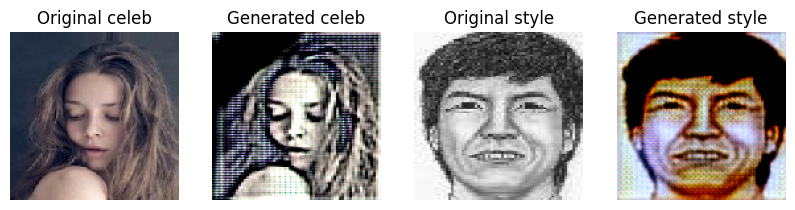

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:58,  1.67it/s]

>1, dA[0.007 ,0.005 ] dB[0.008 ,0.015] g[23.856 ,28.299]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:57,  1.67it/s]

>2, dA[0.005 ,0.003 ] dB[0.019 ,0.010] g[11.915 ,13.724]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.002 ,0.003 ] dB[0.010 ,0.015] g[30.120 ,33.631]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:55,  1.68it/s]

>4, dA[0.004 ,0.003 ] dB[0.011 ,0.009] g[21.096 ,22.713]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.68it/s]

>5, dA[0.005 ,0.003 ] dB[0.007 ,0.004] g[15.151 ,17.037]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:54,  1.68it/s]

>6, dA[0.003 ,0.003 ] dB[0.007 ,0.004] g[32.110 ,37.348]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.008 ,0.003 ] dB[0.006 ,0.004] g[17.615 ,20.004]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.68it/s]

>8, dA[0.007 ,0.004 ] dB[0.003 ,0.003] g[18.106 ,19.188]
1/1 [==============================] - 0s 25ms/step



Batchs:   2%|▏         | 9/400 [00:05<04:55,  1.32it/s]

>9, dA[0.007 ,0.003 ] dB[0.008 ,0.005] g[24.336 ,27.163]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 10/400 [00:06<04:36,  1.41it/s]

>10, dA[0.007 ,0.003 ] dB[0.002 ,0.004] g[22.925 ,26.551]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 11/400 [00:07<04:36,  1.41it/s]

>11, dA[0.005 ,0.005 ] dB[0.002 ,0.005] g[21.406 ,25.796]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<04:22,  1.48it/s]

>12, dA[0.004 ,0.004 ] dB[0.003 ,0.004] g[19.877 ,22.315]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 13/400 [00:08<04:14,  1.52it/s]

>13, dA[0.003 ,0.003 ] dB[0.003 ,0.005] g[28.695 ,33.115]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:09<04:08,  1.56it/s]

>14, dA[0.003 ,0.005 ] dB[0.002 ,0.002] g[23.657 ,28.087]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:09<04:01,  1.59it/s]

>15, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[22.000 ,22.779]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:10<03:58,  1.61it/s]

>16, dA[0.003 ,0.002 ] dB[0.003 ,0.004] g[23.055 ,25.640]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:56,  1.62it/s]

>17, dA[0.004 ,0.003 ] dB[0.002 ,0.003] g[21.258 ,22.998]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:11<03:53,  1.64it/s]

>18, dA[0.004 ,0.006 ] dB[0.003 ,0.006] g[14.883 ,16.696]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [00:12<03:51,  1.64it/s]

>19, dA[0.004 ,0.003 ] dB[0.005 ,0.006] g[15.050 ,17.622]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 20/400 [00:12<03:51,  1.64it/s]

>20, dA[0.002 ,0.003 ] dB[0.006 ,0.008] g[22.372 ,26.827]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 21/400 [00:13<03:50,  1.65it/s]

>21, dA[0.002 ,0.002 ] dB[0.002 ,0.008] g[21.477 ,24.334]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:48,  1.66it/s]

>22, dA[0.003 ,0.003 ] dB[0.002 ,0.010] g[20.389 ,23.465]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:14<03:46,  1.66it/s]

>23, dA[0.008 ,0.004 ] dB[0.005 ,0.017] g[14.520 ,16.434]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:15<03:44,  1.67it/s]

>24, dA[0.012 ,0.002 ] dB[0.006 ,0.009] g[24.938 ,28.977]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:44,  1.67it/s]

>25, dA[0.005 ,0.002 ] dB[0.011 ,0.003] g[19.906 ,23.198]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:16<03:43,  1.67it/s]

>26, dA[0.003 ,0.002 ] dB[0.012 ,0.005] g[28.075 ,29.519]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.007 ,0.005 ] dB[0.016 ,0.005] g[20.619 ,25.281]
1/1 [==============================] - 0s 23ms/step



Batchs:   7%|▋         | 28/400 [00:17<03:42,  1.67it/s]

>28, dA[0.012 ,0.003 ] dB[0.011 ,0.008] g[18.747 ,19.509]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:18<03:43,  1.66it/s]

>29, dA[0.006 ,0.004 ] dB[0.007 ,0.009] g[14.468 ,16.699]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:43,  1.65it/s]

>30, dA[0.007 ,0.004 ] dB[0.003 ,0.013] g[26.172 ,31.097]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:19<03:41,  1.66it/s]

>31, dA[0.005 ,0.005 ] dB[0.003 ,0.007] g[17.480 ,18.282]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:40,  1.67it/s]

>32, dA[0.004 ,0.005 ] dB[0.002 ,0.011] g[19.197 ,22.666]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:20<03:40,  1.67it/s]

>33, dA[0.008 ,0.006 ] dB[0.006 ,0.010] g[16.033 ,17.230]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 34/400 [00:21<03:39,  1.67it/s]

>34, dA[0.009 ,0.008 ] dB[0.017 ,0.029] g[13.181 ,16.144]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:38,  1.67it/s]

>35, dA[0.005 ,0.010 ] dB[0.010 ,0.048] g[25.065 ,30.154]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:22<03:37,  1.68it/s]

>36, dA[0.003 ,0.004 ] dB[0.014 ,0.014] g[22.295 ,26.029]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:36,  1.67it/s]

>37, dA[0.002 ,0.002 ] dB[0.012 ,0.012] g[30.138 ,37.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:23<03:36,  1.67it/s]

>38, dA[0.004 ,0.002 ] dB[0.009 ,0.018] g[28.230 ,31.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:35,  1.68it/s]

>39, dA[0.008 ,0.003 ] dB[0.011 ,0.011] g[15.536 ,15.883]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 40/400 [00:24<03:34,  1.68it/s]

>40, dA[0.007 ,0.003 ] dB[0.013 ,0.007] g[25.957 ,28.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:25<03:34,  1.67it/s]

>41, dA[0.005 ,0.002 ] dB[0.002 ,0.010] g[17.388 ,20.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.67it/s]

>42, dA[0.005 ,0.006 ] dB[0.009 ,0.006] g[14.699 ,17.236]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:26<03:32,  1.68it/s]

>43, dA[0.004 ,0.002 ] dB[0.009 ,0.003] g[17.006 ,17.198]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:32,  1.68it/s]

>44, dA[0.003 ,0.002 ] dB[0.009 ,0.008] g[26.998 ,32.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:34,  1.65it/s]

>45, dA[0.009 ,0.003 ] dB[0.005 ,0.004] g[17.349 ,18.920]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 46/400 [00:28<03:35,  1.64it/s]

>46, dA[0.008 ,0.007 ] dB[0.004 ,0.005] g[16.824 ,17.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:33,  1.65it/s]

>47, dA[0.005 ,0.005 ] dB[0.007 ,0.006] g[13.660 ,15.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:29<03:31,  1.66it/s]

>48, dA[0.004 ,0.004 ] dB[0.003 ,0.003] g[20.358 ,22.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:30<03:31,  1.66it/s]

>49, dA[0.002 ,0.002 ] dB[0.001 ,0.012] g[24.487 ,29.177]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:29,  1.67it/s]

>50, dA[0.004 ,0.004 ] dB[0.005 ,0.020] g[15.575 ,16.596]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:31<03:28,  1.68it/s]

>51, dA[0.012 ,0.004 ] dB[0.020 ,0.014] g[17.107 ,19.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:26,  1.68it/s]

>52, dA[0.005 ,0.007 ] dB[0.023 ,0.006] g[27.743 ,31.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:32<03:27,  1.67it/s]

>53, dA[0.010 ,0.007 ] dB[0.008 ,0.008] g[16.686 ,19.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.67it/s]

>54, dA[0.005 ,0.004 ] dB[0.015 ,0.003] g[28.799 ,32.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:25,  1.68it/s]

>55, dA[0.007 ,0.006 ] dB[0.017 ,0.006] g[15.877 ,17.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:34<03:24,  1.68it/s]

>56, dA[0.005 ,0.003 ] dB[0.012 ,0.009] g[24.265 ,26.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:24,  1.68it/s]

>57, dA[0.005 ,0.003 ] dB[0.006 ,0.008] g[21.650 ,24.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:35<03:23,  1.68it/s]

>58, dA[0.006 ,0.007 ] dB[0.010 ,0.004] g[16.660 ,15.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:22,  1.68it/s]

>59, dA[0.003 ,0.002 ] dB[0.016 ,0.006] g[21.470 ,23.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:22,  1.68it/s]

>60, dA[0.008 ,0.002 ] dB[0.013 ,0.004] g[19.133 ,23.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:37<03:22,  1.67it/s]

>61, dA[0.012 ,0.002 ] dB[0.011 ,0.007] g[13.974 ,17.263]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:22,  1.67it/s]

>62, dA[0.008 ,0.003 ] dB[0.021 ,0.011] g[15.686 ,18.315]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:38<03:21,  1.68it/s]

>63, dA[0.004 ,0.002 ] dB[0.002 ,0.006] g[17.394 ,19.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:22,  1.66it/s]

>64, dA[0.006 ,0.004 ] dB[0.007 ,0.007] g[23.312 ,28.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:21,  1.66it/s]

>65, dA[0.005 ,0.003 ] dB[0.011 ,0.008] g[18.819 ,21.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:40<03:20,  1.67it/s]

>66, dA[0.004 ,0.002 ] dB[0.010 ,0.012] g[19.660 ,22.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:19,  1.67it/s]

>67, dA[0.059 ,0.048 ] dB[0.007 ,0.003] g[13.744 ,15.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:41<03:17,  1.68it/s]

>68, dA[0.035 ,0.089 ] dB[0.012 ,0.011] g[25.328 ,31.029]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:17,  1.67it/s]

>69, dA[0.040 ,0.030 ] dB[0.006 ,0.013] g[22.564 ,26.349]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:18,  1.66it/s]

>70, dA[0.025 ,0.029 ] dB[0.011 ,0.024] g[18.120 ,22.287]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 71/400 [00:43<03:17,  1.67it/s]

>71, dA[0.018 ,0.020 ] dB[0.008 ,0.027] g[27.168 ,33.347]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:16,  1.67it/s]

>72, dA[0.056 ,0.021 ] dB[0.006 ,0.025] g[16.324 ,19.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:44<03:15,  1.67it/s]

>73, dA[0.066 ,0.026 ] dB[0.009 ,0.017] g[24.877 ,29.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:14,  1.67it/s]

>74, dA[0.026 ,0.008 ] dB[0.015 ,0.022] g[31.187 ,35.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:13,  1.68it/s]

>75, dA[0.008 ,0.019 ] dB[0.006 ,0.018] g[16.934 ,18.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:46<03:13,  1.68it/s]

>76, dA[0.006 ,0.019 ] dB[0.008 ,0.007] g[20.068 ,23.316]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:12,  1.67it/s]

>77, dA[0.007 ,0.017 ] dB[0.004 ,0.008] g[15.636 ,18.300]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|█▉        | 78/400 [00:47<03:13,  1.67it/s]

>78, dA[0.007 ,0.013 ] dB[0.005 ,0.008] g[18.897 ,22.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.67it/s]

>79, dA[0.013 ,0.005 ] dB[0.007 ,0.011] g[12.986 ,14.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:48<03:10,  1.68it/s]

>80, dA[0.011 ,0.005 ] dB[0.005 ,0.009] g[29.221 ,36.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 81/400 [00:49<03:10,  1.68it/s]

>81, dA[0.012 ,0.004 ] dB[0.007 ,0.006] g[18.740 ,21.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 82/400 [00:49<03:09,  1.67it/s]

>82, dA[0.004 ,0.006 ] dB[0.003 ,0.007] g[25.797 ,30.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:50<03:08,  1.68it/s]

>83, dA[0.009 ,0.003 ] dB[0.002 ,0.012] g[19.802 ,22.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.68it/s]

>84, dA[0.003 ,0.006 ] dB[0.004 ,0.005] g[21.132 ,24.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:07,  1.68it/s]

>85, dA[0.011 ,0.004 ] dB[0.003 ,0.004] g[16.529 ,18.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:52<03:07,  1.68it/s]

>86, dA[0.014 ,0.004 ] dB[0.004 ,0.007] g[14.936 ,15.924]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:06,  1.68it/s]

>87, dA[0.007 ,0.009 ] dB[0.009 ,0.004] g[20.329 ,24.594]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:53<03:05,  1.68it/s]

>88, dA[0.015 ,0.008 ] dB[0.012 ,0.006] g[20.129 ,21.802]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:05,  1.68it/s]

>89, dA[0.043 ,0.035 ] dB[0.007 ,0.008] g[14.622 ,18.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:04,  1.68it/s]

>90, dA[0.024 ,0.005 ] dB[0.008 ,0.012] g[13.414 ,15.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:55<03:03,  1.68it/s]

>91, dA[0.015 ,0.016 ] dB[0.009 ,0.007] g[19.634 ,21.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:02,  1.69it/s]

>92, dA[0.015 ,0.007 ] dB[0.005 ,0.005] g[17.307 ,19.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:56<03:02,  1.68it/s]

>93, dA[0.006 ,0.005 ] dB[0.002 ,0.005] g[22.583 ,26.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:02,  1.68it/s]

>94, dA[0.006 ,0.002 ] dB[0.005 ,0.008] g[23.461 ,24.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:01,  1.68it/s]

>95, dA[0.004 ,0.002 ] dB[0.006 ,0.006] g[23.823 ,28.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:58<03:01,  1.68it/s]

>96, dA[0.020 ,0.004 ] dB[0.004 ,0.011] g[14.250 ,14.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:05,  1.63it/s]

>97, dA[0.008 ,0.003 ] dB[0.003 ,0.008] g[15.748 ,19.524]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 98/400 [00:59<03:05,  1.62it/s]

>98, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[17.638 ,19.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:03,  1.64it/s]

>99, dA[0.005 ,0.003 ] dB[0.002 ,0.002] g[18.831 ,21.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [01:00<03:01,  1.65it/s]

>100, dA[0.009 ,0.008 ] dB[0.004 ,0.003] g[18.996 ,24.429]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [01:01<03:00,  1.65it/s]

>101, dA[0.008 ,0.004 ] dB[0.002 ,0.003] g[19.373 ,20.487]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:59,  1.66it/s]

>102, dA[0.012 ,0.005 ] dB[0.005 ,0.004] g[20.302 ,22.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:02<02:58,  1.67it/s]

>103, dA[0.006 ,0.009 ] dB[0.004 ,0.002] g[19.244 ,22.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.67it/s]

>104, dA[0.009 ,0.009 ] dB[0.002 ,0.004] g[15.409 ,17.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:57,  1.67it/s]

>105, dA[0.016 ,0.009 ] dB[0.003 ,0.005] g[16.277 ,17.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:04<02:56,  1.67it/s]

>106, dA[0.015 ,0.005 ] dB[0.007 ,0.005] g[18.861 ,20.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:55,  1.67it/s]

>107, dA[0.007 ,0.004 ] dB[0.005 ,0.005] g[19.705 ,21.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:05<02:54,  1.68it/s]

>108, dA[0.014 ,0.007 ] dB[0.004 ,0.004] g[14.813 ,18.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:54,  1.67it/s]

>109, dA[0.026 ,0.008 ] dB[0.005 ,0.004] g[23.848 ,28.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:53,  1.67it/s]

>110, dA[0.014 ,0.005 ] dB[0.004 ,0.003] g[19.935 ,20.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:07<02:52,  1.67it/s]

>111, dA[0.009 ,0.005 ] dB[0.004 ,0.003] g[26.616 ,32.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:51,  1.68it/s]

>112, dA[0.012 ,0.006 ] dB[0.031 ,0.017] g[17.475 ,20.765]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:08<02:51,  1.67it/s]

>113, dA[0.007 ,0.003 ] dB[0.011 ,0.016] g[23.702 ,28.114]
1/1 [==============================] - 0s 26ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:52,  1.66it/s]

>114, dA[0.004 ,0.006 ] dB[0.017 ,0.016] g[16.592 ,20.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:50,  1.67it/s]

>115, dA[0.006 ,0.007 ] dB[0.012 ,0.017] g[28.975 ,33.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:10<02:49,  1.68it/s]

>116, dA[0.013 ,0.013 ] dB[0.007 ,0.018] g[14.807 ,16.815]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:48,  1.67it/s]

>117, dA[0.011 ,0.010 ] dB[0.014 ,0.020] g[28.753 ,30.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:11<02:47,  1.68it/s]

>118, dA[0.003 ,0.004 ] dB[0.031 ,0.024] g[15.120 ,17.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:46,  1.69it/s]

>119, dA[0.008 ,0.003 ] dB[0.022 ,0.015] g[24.714 ,26.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:12<02:45,  1.69it/s]

>120, dA[0.008 ,0.002 ] dB[0.078 ,0.041] g[19.464 ,20.583]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:13<02:45,  1.68it/s]

>121, dA[0.005 ,0.002 ] dB[0.036 ,0.051] g[15.483 ,17.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:13<02:44,  1.69it/s]

>122, dA[0.003 ,0.003 ] dB[0.023 ,0.033] g[20.228 ,21.252]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:14<02:43,  1.69it/s]

>123, dA[0.008 ,0.003 ] dB[0.020 ,0.049] g[15.302 ,17.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:14<02:42,  1.69it/s]

>124, dA[0.007 ,0.004 ] dB[0.026 ,0.057] g[34.518 ,38.538]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:42,  1.69it/s]

>125, dA[0.003 ,0.004 ] dB[0.054 ,0.044] g[15.455 ,16.491]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:41,  1.69it/s]

>126, dA[0.004 ,0.003 ] dB[0.045 ,0.017] g[16.348 ,17.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:41,  1.69it/s]

>127, dA[0.003 ,0.002 ] dB[0.025 ,0.019] g[25.730 ,30.463]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:17<02:40,  1.69it/s]

>128, dA[0.005 ,0.002 ] dB[0.018 ,0.022] g[19.596 ,22.789]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:40,  1.69it/s]

>129, dA[0.004 ,0.003 ] dB[0.019 ,0.025] g[14.060 ,16.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:40,  1.68it/s]

>130, dA[0.007 ,0.002 ] dB[0.015 ,0.016] g[20.129 ,21.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:41,  1.67it/s]

>131, dA[0.010 ,0.001 ] dB[0.025 ,0.019] g[18.318 ,20.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:39,  1.68it/s]

>132, dA[0.005 ,0.005 ] dB[0.035 ,0.042] g[10.495 ,11.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:20<02:38,  1.68it/s]

>133, dA[0.005 ,0.003 ] dB[0.041 ,0.014] g[17.075 ,18.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:37,  1.69it/s]

>134, dA[0.027 ,0.003 ] dB[0.028 ,0.040] g[32.806 ,37.162]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:36,  1.69it/s]

>135, dA[0.010 ,0.003 ] dB[0.029 ,0.028] g[18.011 ,21.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:35,  1.69it/s]

>136, dA[0.003 ,0.003 ] dB[0.025 ,0.034] g[23.185 ,26.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:35,  1.69it/s]

>137, dA[0.006 ,0.003 ] dB[0.047 ,0.020] g[29.348 ,35.485]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:23<02:34,  1.69it/s]

>138, dA[0.007 ,0.003 ] dB[0.054 ,0.030] g[17.528 ,19.474]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:33,  1.70it/s]

>139, dA[0.002 ,0.003 ] dB[0.032 ,0.016] g[20.121 ,21.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:33,  1.70it/s]

>140, dA[0.002 ,0.003 ] dB[0.015 ,0.015] g[17.605 ,19.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:33,  1.69it/s]

>141, dA[0.004 ,0.002 ] dB[0.022 ,0.027] g[18.770 ,21.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:33,  1.68it/s]

>142, dA[0.005 ,0.002 ] dB[0.017 ,0.039] g[22.743 ,27.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:26<02:32,  1.68it/s]

>143, dA[0.006 ,0.002 ] dB[0.029 ,0.020] g[17.519 ,17.751]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:31,  1.69it/s]

>144, dA[0.002 ,0.002 ] dB[0.039 ,0.018] g[22.605 ,27.120]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:31,  1.68it/s]

>145, dA[0.010 ,0.004 ] dB[0.033 ,0.013] g[13.082 ,13.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:30,  1.68it/s]

>146, dA[0.005 ,0.004 ] dB[0.010 ,0.015] g[11.858 ,12.988]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:30,  1.68it/s]

>147, dA[0.010 ,0.003 ] dB[0.012 ,0.027] g[16.605 ,17.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:29<02:29,  1.68it/s]

>148, dA[0.006 ,0.001 ] dB[0.017 ,0.033] g[17.969 ,21.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:30,  1.67it/s]

>149, dA[0.006 ,0.002 ] dB[0.026 ,0.017] g[18.428 ,20.931]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 150/400 [01:30<02:31,  1.65it/s]

>150, dA[0.011 ,0.004 ] dB[0.025 ,0.014] g[18.731 ,20.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:30,  1.65it/s]

>151, dA[0.012 ,0.005 ] dB[0.027 ,0.017] g[18.222 ,20.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:31<02:28,  1.67it/s]

>152, dA[0.024 ,0.022 ] dB[0.038 ,0.011] g[13.895 ,15.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:32<02:27,  1.67it/s]

>153, dA[0.037 ,0.031 ] dB[0.037 ,0.014] g[17.917 ,17.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:26,  1.68it/s]

>154, dA[0.018 ,0.005 ] dB[0.028 ,0.020] g[23.408 ,26.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:25,  1.69it/s]

>155, dA[0.009 ,0.005 ] dB[0.022 ,0.021] g[27.090 ,30.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:24,  1.69it/s]

>156, dA[0.014 ,0.011 ] dB[0.054 ,0.023] g[28.518 ,30.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:34<02:24,  1.69it/s]

>157, dA[0.006 ,0.009 ] dB[0.028 ,0.011] g[25.552 ,28.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:35<02:23,  1.68it/s]

>158, dA[0.009 ,0.004 ] dB[0.018 ,0.046] g[19.026 ,21.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:22,  1.69it/s]

>159, dA[0.006 ,0.005 ] dB[0.011 ,0.043] g[16.023 ,18.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:36<02:21,  1.69it/s]

>160, dA[0.006 ,0.010 ] dB[0.015 ,0.060] g[27.940 ,33.431]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 161/400 [01:36<02:21,  1.69it/s]

>161, dA[0.008 ,0.008 ] dB[0.029 ,0.061] g[15.582 ,16.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:37<02:20,  1.69it/s]

>162, dA[0.005 ,0.002 ] dB[0.013 ,0.022] g[22.770 ,26.225]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:37<02:19,  1.69it/s]

>163, dA[0.004 ,0.005 ] dB[0.014 ,0.030] g[19.964 ,22.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:38<02:18,  1.70it/s]

>164, dA[0.003 ,0.002 ] dB[0.012 ,0.038] g[22.346 ,24.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:18,  1.69it/s]

>165, dA[0.004 ,0.003 ] dB[0.013 ,0.037] g[16.500 ,18.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:18,  1.69it/s]

>166, dA[0.003 ,0.004 ] dB[0.007 ,0.042] g[28.197 ,31.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:40<02:17,  1.70it/s]

>167, dA[0.005 ,0.005 ] dB[0.010 ,0.019] g[23.176 ,24.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:16,  1.70it/s]

>168, dA[0.010 ,0.004 ] dB[0.039 ,0.015] g[23.740 ,28.769]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:16,  1.70it/s]

>169, dA[0.013 ,0.008 ] dB[0.017 ,0.033] g[18.437 ,21.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:15,  1.70it/s]

>170, dA[0.011 ,0.010 ] dB[0.014 ,0.040] g[15.514 ,16.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:14,  1.70it/s]

>171, dA[0.013 ,0.011 ] dB[0.045 ,0.041] g[19.890 ,21.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:43<02:14,  1.69it/s]

>172, dA[0.006 ,0.007 ] dB[0.039 ,0.016] g[10.934 ,14.219]
1/1 [==============================] - 0s 23ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.68it/s]

>173, dA[0.005 ,0.005 ] dB[0.022 ,0.026] g[32.370 ,37.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:14,  1.68it/s]

>174, dA[0.010 ,0.009 ] dB[0.021 ,0.012] g[17.886 ,18.955]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:13,  1.69it/s]

>175, dA[0.007 ,0.006 ] dB[0.019 ,0.016] g[15.271 ,17.360]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:12,  1.69it/s]

>176, dA[0.015 ,0.007 ] dB[0.011 ,0.023] g[12.994 ,17.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:46<02:12,  1.69it/s]

>177, dA[0.007 ,0.006 ] dB[0.004 ,0.020] g[29.915 ,35.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:11,  1.69it/s]

>178, dA[0.006 ,0.005 ] dB[0.003 ,0.012] g[19.555 ,22.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:11,  1.69it/s]

>179, dA[0.004 ,0.004 ] dB[0.014 ,0.010] g[22.272 ,26.299]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:10,  1.69it/s]

>180, dA[0.003 ,0.003 ] dB[0.009 ,0.007] g[23.138 ,25.928]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:10,  1.67it/s]

>181, dA[0.004 ,0.003 ] dB[0.003 ,0.005] g[17.227 ,17.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:49<02:10,  1.68it/s]

>182, dA[0.004 ,0.005 ] dB[0.003 ,0.006] g[20.720 ,23.025]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:08,  1.69it/s]

>183, dA[0.067 ,0.054 ] dB[0.074 ,0.128] g[12.916 ,14.149]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:07,  1.69it/s]

>184, dA[0.049 ,0.069 ] dB[0.008 ,0.169] g[27.510 ,30.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.69it/s]

>185, dA[0.042 ,0.025 ] dB[0.297 ,0.161] g[26.668 ,26.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:06,  1.69it/s]

>186, dA[0.037 ,0.017 ] dB[0.229 ,0.817] g[21.573 ,24.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:52<02:05,  1.69it/s]

>187, dA[0.037 ,0.022 ] dB[0.750 ,1.420] g[26.978 ,28.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:04,  1.70it/s]

>188, dA[0.025 ,0.013 ] dB[1.132 ,3.293] g[17.415 ,16.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:04,  1.69it/s]

>189, dA[0.023 ,0.007 ] dB[1.477 ,3.071] g[19.685 ,16.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:03,  1.70it/s]

>190, dA[0.022 ,0.012 ] dB[11.709 ,0.728] g[57.342 ,26.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:03,  1.70it/s]

>191, dA[0.010 ,0.014 ] dB[1.845 ,7.753] g[32.252 ,33.885]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 192/400 [01:55<02:02,  1.70it/s]

>192, dA[0.007 ,0.021 ] dB[5.719 ,1.565] g[45.783 ,20.902]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.70it/s]

>193, dA[0.008 ,0.017 ] dB[4.973 ,1.308] g[43.120 ,31.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:01,  1.69it/s]

>194, dA[0.009 ,0.005 ] dB[4.530 ,0.491] g[34.932 ,34.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:01,  1.69it/s]

>195, dA[0.014 ,0.006 ] dB[3.053 ,0.242] g[20.831 ,21.202]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:00,  1.70it/s]

>196, dA[0.017 ,0.009 ] dB[0.541 ,0.201] g[18.843 ,22.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:58<02:00,  1.69it/s]

>197, dA[0.011 ,0.009 ] dB[0.209 ,0.319] g[29.612 ,29.387]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:01,  1.67it/s]

>198, dA[0.016 ,0.006 ] dB[0.090 ,0.164] g[22.309 ,24.712]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:59<01:59,  1.68it/s]

>199, dA[0.024 ,0.006 ] dB[0.160 ,0.090] g[32.750 ,42.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.006 ,0.005 ] dB[0.373 ,0.187] g[28.756 ,30.951]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:58,  1.68it/s]

>201, dA[0.006 ,0.003 ] dB[0.212 ,0.308] g[24.976 ,26.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [02:01<01:58,  1.67it/s]

>202, dA[0.002 ,0.003 ] dB[0.136 ,0.127] g[30.565 ,34.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:59,  1.65it/s]

>203, dA[0.005 ,0.001 ] dB[0.140 ,0.104] g[29.717 ,30.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:57,  1.66it/s]

>204, dA[0.007 ,0.003 ] dB[0.340 ,0.143] g[16.914 ,19.875]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.67it/s]

>205, dA[0.004 ,0.003 ] dB[0.213 ,0.085] g[18.734 ,21.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.68it/s]

>206, dA[0.003 ,0.002 ] dB[0.142 ,0.171] g[24.947 ,28.092]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 207/400 [02:04<01:54,  1.68it/s]

>207, dA[0.011 ,0.007 ] dB[0.027 ,0.047] g[20.691 ,23.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:53,  1.69it/s]

>208, dA[0.006 ,0.003 ] dB[0.117 ,0.059] g[17.825 ,19.490]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:53,  1.69it/s]

>209, dA[0.002 ,0.004 ] dB[0.040 ,0.062] g[24.536 ,32.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.68it/s]

>210, dA[0.017 ,0.003 ] dB[0.080 ,0.121] g[24.044 ,24.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:52,  1.69it/s]

>211, dA[0.011 ,0.004 ] dB[0.085 ,0.055] g[22.809 ,26.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:07<01:51,  1.69it/s]

>212, dA[0.012 ,0.006 ] dB[0.044 ,0.088] g[27.634 ,30.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:51,  1.68it/s]

>213, dA[0.011 ,0.005 ] dB[0.075 ,0.104] g[23.127 ,26.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:50,  1.68it/s]

>214, dA[0.010 ,0.006 ] dB[0.029 ,0.037] g[33.128 ,39.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.69it/s]

>215, dA[0.009 ,0.002 ] dB[0.348 ,0.112] g[18.677 ,21.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:48,  1.70it/s]

>216, dA[0.008 ,0.014 ] dB[0.062 ,0.105] g[15.691 ,16.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.69it/s]

>217, dA[0.008 ,0.006 ] dB[0.084 ,0.092] g[24.383 ,25.957]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:47,  1.69it/s]

>218, dA[0.006 ,0.004 ] dB[0.145 ,0.079] g[25.490 ,28.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:47,  1.69it/s]

>219, dA[0.012 ,0.005 ] dB[0.021 ,0.062] g[16.330 ,18.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.013 ,0.005 ] dB[0.033 ,0.082] g[21.067 ,25.135]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:45,  1.69it/s]

>221, dA[0.015 ,0.004 ] dB[0.034 ,0.054] g[17.098 ,18.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.004 ,0.006 ] dB[0.043 ,0.039] g[23.555 ,26.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:44,  1.69it/s]

>223, dA[0.005 ,0.005 ] dB[0.031 ,0.030] g[28.577 ,31.362]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:44,  1.69it/s]

>224, dA[0.003 ,0.004 ] dB[0.069 ,0.035] g[30.299 ,36.333]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:43,  1.69it/s]

>225, dA[0.009 ,0.004 ] dB[0.060 ,0.105] g[28.623 ,29.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:42,  1.69it/s]

>226, dA[0.006 ,0.003 ] dB[0.106 ,0.183] g[21.035 ,23.803]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:41,  1.70it/s]

>227, dA[0.008 ,0.004 ] dB[0.214 ,0.055] g[25.952 ,31.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:41,  1.70it/s]

>228, dA[0.004 ,0.002 ] dB[0.055 ,0.060] g[18.838 ,20.938]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:41,  1.69it/s]

>229, dA[0.007 ,0.004 ] dB[0.020 ,0.040] g[26.067 ,30.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:40,  1.69it/s]

>230, dA[0.005 ,0.003 ] dB[0.038 ,0.021] g[20.592 ,19.227]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:39,  1.69it/s]

>231, dA[0.009 ,0.005 ] dB[0.027 ,0.034] g[22.385 ,23.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.69it/s]

>232, dA[0.007 ,0.004 ] dB[0.033 ,0.059] g[22.809 ,26.691]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:38,  1.69it/s]

>233, dA[0.009 ,0.004 ] dB[0.051 ,0.043] g[18.403 ,21.544]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:38,  1.69it/s]

>234, dA[0.009 ,0.006 ] dB[0.030 ,0.022] g[15.178 ,15.962]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:37,  1.70it/s]

>235, dA[0.011 ,0.003 ] dB[0.018 ,0.040] g[23.997 ,27.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:36,  1.70it/s]

>236, dA[0.023 ,0.008 ] dB[0.021 ,0.022] g[17.888 ,20.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.69it/s]

>237, dA[0.018 ,0.002 ] dB[0.035 ,0.045] g[21.300 ,22.334]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:35,  1.70it/s]

>238, dA[0.004 ,0.003 ] dB[0.021 ,0.021] g[19.629 ,22.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.69it/s]

>239, dA[0.004 ,0.003 ] dB[0.011 ,0.024] g[15.612 ,16.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:34,  1.69it/s]

>240, dA[0.004 ,0.003 ] dB[0.055 ,0.055] g[22.861 ,25.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:34,  1.68it/s]

>241, dA[0.003 ,0.002 ] dB[0.015 ,0.039] g[31.783 ,37.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.69it/s]

>242, dA[0.009 ,0.003 ] dB[0.013 ,0.045] g[22.537 ,25.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:32,  1.69it/s]

>243, dA[0.008 ,0.006 ] dB[0.018 ,0.025] g[14.862 ,15.103]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:31,  1.70it/s]

>244, dA[0.003 ,0.005 ] dB[0.176 ,0.038] g[18.030 ,21.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:31,  1.69it/s]

>245, dA[0.002 ,0.001 ] dB[0.054 ,0.029] g[24.018 ,29.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:31,  1.68it/s]

>246, dA[0.003 ,0.003 ] dB[0.018 ,0.035] g[31.844 ,38.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:30,  1.69it/s]

>247, dA[0.002 ,0.003 ] dB[0.088 ,0.027] g[28.631 ,33.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:29,  1.70it/s]

>248, dA[0.007 ,0.003 ] dB[0.039 ,0.022] g[21.138 ,24.491]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:30,  1.68it/s]

>249, dA[0.009 ,0.003 ] dB[0.046 ,0.027] g[21.799 ,24.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.003 ,0.005 ] dB[0.012 ,0.034] g[22.800 ,28.900]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:28,  1.68it/s]

>251, dA[0.008 ,0.004 ] dB[0.048 ,0.038] g[25.729 ,31.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:27,  1.69it/s]

>252, dA[0.007 ,0.008 ] dB[0.007 ,0.021] g[24.480 ,28.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:27,  1.69it/s]

>253, dA[0.009 ,0.005 ] dB[0.012 ,0.023] g[11.235 ,12.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.007 ,0.005 ] dB[0.029 ,0.018] g[20.181 ,23.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:27,  1.65it/s]

>255, dA[0.017 ,0.009 ] dB[0.163 ,0.119] g[18.605 ,21.694]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:26,  1.66it/s]

>256, dA[0.013 ,0.007 ] dB[0.029 ,0.103] g[23.820 ,25.790]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:25,  1.67it/s]

>257, dA[0.011 ,0.007 ] dB[0.019 ,0.036] g[22.811 ,23.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:24,  1.68it/s]

>258, dA[0.004 ,0.009 ] dB[0.040 ,0.021] g[33.497 ,36.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.69it/s]

>259, dA[0.005 ,0.005 ] dB[0.009 ,0.028] g[20.406 ,23.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:22,  1.69it/s]

>260, dA[0.004 ,0.008 ] dB[0.006 ,0.055] g[15.786 ,17.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:22,  1.69it/s]

>261, dA[0.014 ,0.003 ] dB[0.025 ,0.026] g[20.203 ,18.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.69it/s]

>262, dA[0.006 ,0.004 ] dB[0.017 ,0.028] g[19.815 ,22.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:21,  1.69it/s]

>263, dA[0.004 ,0.003 ] dB[0.037 ,0.015] g[24.285 ,27.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:20,  1.69it/s]

>264, dA[0.003 ,0.003 ] dB[0.023 ,0.015] g[19.293 ,21.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.68it/s]

>265, dA[0.003 ,0.002 ] dB[0.426 ,0.036] g[18.795 ,22.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:19,  1.68it/s]

>266, dA[0.002 ,0.001 ] dB[0.028 ,0.048] g[19.896 ,27.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:18,  1.69it/s]

>267, dA[0.003 ,0.002 ] dB[0.040 ,0.071] g[25.635 ,27.836]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:18,  1.69it/s]

>268, dA[0.003 ,0.003 ] dB[0.244 ,0.050] g[13.424 ,16.628]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.68it/s]

>269, dA[0.002 ,0.002 ] dB[0.054 ,0.188] g[24.487 ,29.106]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.68it/s]

>270, dA[0.003 ,0.001 ] dB[0.044 ,0.241] g[35.016 ,37.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.003 ,0.003 ] dB[0.018 ,0.208] g[22.484 ,26.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:15,  1.69it/s]

>272, dA[0.003 ,0.002 ] dB[0.011 ,0.034] g[19.733 ,24.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:15,  1.68it/s]

>273, dA[0.005 ,0.002 ] dB[0.040 ,0.037] g[15.234 ,15.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.68it/s]

>274, dA[0.002 ,0.002 ] dB[0.119 ,0.049] g[20.391 ,24.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.68it/s]

>275, dA[0.002 ,0.002 ] dB[0.015 ,0.052] g[18.888 ,23.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.69it/s]

>276, dA[0.006 ,0.004 ] dB[0.013 ,0.015] g[20.313 ,24.211]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:12,  1.69it/s]

>277, dA[0.002 ,0.003 ] dB[0.037 ,0.017] g[14.436 ,15.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:12,  1.69it/s]

>278, dA[0.003 ,0.002 ] dB[0.159 ,0.058] g[19.406 ,24.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.70it/s]

>279, dA[0.003 ,0.004 ] dB[0.017 ,0.058] g[16.988 ,18.164]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:10,  1.69it/s]

>280, dA[0.004 ,0.003 ] dB[0.008 ,0.039] g[13.713 ,15.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.69it/s]

>281, dA[0.004 ,0.004 ] dB[0.045 ,0.016] g[21.286 ,24.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:09,  1.69it/s]

>282, dA[0.004 ,0.003 ] dB[0.014 ,0.034] g[18.459 ,21.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:09,  1.69it/s]

>283, dA[0.007 ,0.005 ] dB[0.025 ,0.013] g[22.167 ,24.726]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.70it/s]

>284, dA[0.008 ,0.002 ] dB[0.030 ,0.013] g[21.361 ,23.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:07,  1.70it/s]

>285, dA[0.006 ,0.002 ] dB[0.014 ,0.033] g[13.160 ,13.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.70it/s]

>286, dA[0.007 ,0.002 ] dB[0.006 ,0.016] g[14.437 ,18.003]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:06,  1.70it/s]

>287, dA[0.009 ,0.002 ] dB[0.019 ,0.024] g[22.623 ,26.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:05,  1.70it/s]

>288, dA[0.019 ,0.006 ] dB[0.026 ,0.094] g[18.690 ,23.972]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.70it/s]

>289, dA[0.022 ,0.006 ] dB[0.025 ,0.007] g[20.225 ,20.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:04,  1.70it/s]

>290, dA[0.017 ,0.010 ] dB[0.039 ,0.022] g[13.375 ,15.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.70it/s]

>291, dA[0.009 ,0.005 ] dB[0.027 ,0.015] g[23.704 ,23.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:03,  1.70it/s]

>292, dA[0.023 ,0.020 ] dB[0.014 ,0.007] g[14.150 ,13.972]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.70it/s]

>293, dA[0.022 ,0.028 ] dB[0.041 ,0.026] g[15.093 ,16.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:02,  1.70it/s]

>294, dA[0.017 ,0.014 ] dB[0.042 ,0.018] g[17.385 ,18.894]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:01,  1.70it/s]

>295, dA[0.015 ,0.011 ] dB[0.011 ,0.013] g[15.171 ,15.899]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.70it/s]

>296, dA[0.005 ,0.004 ] dB[0.188 ,0.033] g[18.301 ,23.531]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:00,  1.69it/s]

>297, dA[0.005 ,0.003 ] dB[0.010 ,0.035] g[17.370 ,19.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.69it/s]

>298, dA[0.009 ,0.004 ] dB[0.014 ,0.020] g[22.003 ,25.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<00:59,  1.70it/s]

>299, dA[0.005 ,0.003 ] dB[0.035 ,0.026] g[32.604 ,36.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:58,  1.70it/s]

>300, dA[0.005 ,0.003 ] dB[0.015 ,0.030] g[30.523 ,36.687]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.69it/s]

>301, dA[0.010 ,0.003 ] dB[0.114 ,0.026] g[15.835 ,18.172]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:57,  1.69it/s]

>302, dA[0.017 ,0.005 ] dB[0.016 ,0.092] g[15.624 ,18.633]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.70it/s]

>303, dA[0.005 ,0.004 ] dB[0.015 ,0.012] g[24.737 ,28.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.70it/s]

>304, dA[0.008 ,0.004 ] dB[0.351 ,0.030] g[19.268 ,27.765]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:55,  1.70it/s]

>305, dA[0.013 ,0.008 ] dB[0.056 ,0.046] g[26.531 ,30.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.70it/s]

>306, dA[0.020 ,0.011 ] dB[0.095 ,0.023] g[24.350 ,25.891]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:54,  1.69it/s]

>307, dA[0.013 ,0.009 ] dB[0.110 ,0.048] g[24.335 ,28.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.67it/s]

>308, dA[0.007 ,0.004 ] dB[0.043 ,0.046] g[23.913 ,25.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.67it/s]

>309, dA[0.008 ,0.005 ] dB[0.087 ,0.021] g[14.724 ,18.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:53,  1.67it/s]

>310, dA[0.029 ,0.003 ] dB[0.011 ,0.035] g[21.537 ,23.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.68it/s]

>311, dA[0.018 ,0.019 ] dB[0.005 ,0.019] g[20.833 ,24.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.68it/s]

>312, dA[0.048 ,0.039 ] dB[0.021 ,0.016] g[23.477 ,27.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.129 ,0.052 ] dB[0.010 ,0.032] g[23.836 ,25.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.68it/s]

>314, dA[0.086 ,0.028 ] dB[0.062 ,0.045] g[22.446 ,27.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.68it/s]

>315, dA[0.044 ,0.037 ] dB[0.017 ,0.084] g[19.378 ,20.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.69it/s]

>316, dA[0.018 ,0.040 ] dB[0.016 ,0.045] g[22.755 ,25.832]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.68it/s]

>317, dA[0.020 ,0.013 ] dB[0.011 ,0.014] g[21.719 ,25.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.69it/s]

>318, dA[0.056 ,0.028 ] dB[0.013 ,0.007] g[25.887 ,29.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:47,  1.69it/s]

>319, dA[0.066 ,0.022 ] dB[0.009 ,0.010] g[15.861 ,16.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.69it/s]

>320, dA[0.034 ,0.012 ] dB[0.009 ,0.006] g[23.777 ,28.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.022 ,0.008 ] dB[0.007 ,0.020] g[15.040 ,16.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.017 ,0.018 ] dB[0.007 ,0.005] g[23.536 ,25.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.69it/s]

>323, dA[0.026 ,0.010 ] dB[0.006 ,0.007] g[16.327 ,19.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:44,  1.69it/s]

>324, dA[0.028 ,0.004 ] dB[0.039 ,0.017] g[14.332 ,16.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.016 ,0.005 ] dB[0.005 ,0.011] g[18.458 ,19.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.68it/s]

>326, dA[0.018 ,0.005 ] dB[0.008 ,0.025] g[14.505 ,15.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.68it/s]

>327, dA[0.007 ,0.004 ] dB[0.032 ,0.008] g[17.773 ,20.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.69it/s]

>328, dA[0.017 ,0.004 ] dB[0.007 ,0.027] g[19.540 ,20.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.68it/s]

>329, dA[0.010 ,0.002 ] dB[0.028 ,0.052] g[23.975 ,25.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.69it/s]

>330, dA[0.005 ,0.005 ] dB[0.027 ,0.049] g[19.015 ,20.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:40,  1.69it/s]

>331, dA[0.007 ,0.006 ] dB[0.015 ,0.042] g[16.589 ,18.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.70it/s]

>332, dA[0.005 ,0.003 ] dB[0.008 ,0.013] g[18.582 ,19.334]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.68it/s]

>333, dA[0.002 ,0.002 ] dB[0.009 ,0.004] g[24.680 ,28.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.68it/s]

>334, dA[0.005 ,0.003 ] dB[0.020 ,0.007] g[15.722 ,18.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.69it/s]

>335, dA[0.008 ,0.008 ] dB[0.017 ,0.005] g[24.535 ,27.272]
1/1 [==============================] - 0s 23ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.016 ,0.002 ] dB[0.006 ,0.018] g[18.885 ,19.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.68it/s]

>337, dA[0.005 ,0.003 ] dB[0.006 ,0.014] g[13.818 ,14.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.68it/s]

>338, dA[0.006 ,0.006 ] dB[0.004 ,0.006] g[20.199 ,22.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.69it/s]

>339, dA[0.006 ,0.003 ] dB[0.002 ,0.009] g[21.643 ,26.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.69it/s]

>340, dA[0.005 ,0.002 ] dB[0.005 ,0.005] g[22.591 ,27.053]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:34,  1.69it/s]

>341, dA[0.003 ,0.002 ] dB[0.008 ,0.010] g[19.408 ,20.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.005 ,0.002 ] dB[0.009 ,0.009] g[20.015 ,22.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.70it/s]

>343, dA[0.003 ,0.002 ] dB[0.006 ,0.020] g[17.630 ,19.328]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:32,  1.70it/s]

>344, dA[0.004 ,0.002 ] dB[0.006 ,0.021] g[19.605 ,22.660]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.70it/s]

>345, dA[0.008 ,0.003 ] dB[0.007 ,0.008] g[19.526 ,21.301]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:31,  1.70it/s]

>346, dA[0.006 ,0.003 ] dB[0.004 ,0.020] g[25.280 ,28.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.70it/s]

>347, dA[0.013 ,0.008 ] dB[0.140 ,0.012] g[30.401 ,37.657]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.70it/s]

>348, dA[0.016 ,0.004 ] dB[0.017 ,0.028] g[20.822 ,22.648]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.70it/s]

>349, dA[0.007 ,0.003 ] dB[0.012 ,0.009] g[18.297 ,22.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.69it/s]

>350, dA[0.007 ,0.004 ] dB[0.007 ,0.020] g[25.128 ,29.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:28,  1.69it/s]

>351, dA[0.009 ,0.007 ] dB[0.097 ,0.023] g[16.614 ,18.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.70it/s]

>352, dA[0.020 ,0.007 ] dB[0.025 ,0.027] g[18.931 ,21.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.70it/s]

>353, dA[0.054 ,0.025 ] dB[0.005 ,0.010] g[14.863 ,17.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.70it/s]

>354, dA[0.019 ,0.013 ] dB[0.019 ,0.005] g[32.732 ,39.048]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.70it/s]

>355, dA[0.015 ,0.008 ] dB[0.007 ,0.007] g[26.804 ,29.769]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:25,  1.70it/s]

>356, dA[0.029 ,0.006 ] dB[0.009 ,0.013] g[26.361 ,30.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.70it/s]

>357, dA[0.026 ,0.008 ] dB[0.014 ,0.029] g[21.338 ,22.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.70it/s]

>358, dA[0.012 ,0.002 ] dB[0.010 ,0.028] g[19.117 ,22.204]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.70it/s]

>359, dA[0.019 ,0.013 ] dB[0.009 ,0.018] g[13.467 ,14.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.69it/s]

>360, dA[0.018 ,0.008 ] dB[0.012 ,0.003] g[26.985 ,33.283]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.67it/s]

>361, dA[0.016 ,0.006 ] dB[0.007 ,0.024] g[13.005 ,13.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.68it/s]

>362, dA[0.010 ,0.012 ] dB[0.005 ,0.030] g[18.640 ,18.824]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:21,  1.69it/s]

>363, dA[0.010 ,0.005 ] dB[0.021 ,0.008] g[18.200 ,19.417]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.017 ,0.007 ] dB[0.032 ,0.009] g[19.860 ,21.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.69it/s]

>365, dA[0.025 ,0.012 ] dB[0.015 ,0.009] g[18.458 ,21.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.69it/s]

>366, dA[0.015 ,0.004 ] dB[0.006 ,0.005] g[20.722 ,22.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.69it/s]

>367, dA[0.011 ,0.010 ] dB[0.003 ,0.009] g[16.338 ,15.961]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:18,  1.69it/s]

>368, dA[0.005 ,0.004 ] dB[0.021 ,0.010] g[12.780 ,14.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.69it/s]

>369, dA[0.008 ,0.006 ] dB[0.006 ,0.020] g[14.947 ,17.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.69it/s]

>370, dA[0.005 ,0.003 ] dB[0.028 ,0.009] g[20.682 ,22.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.70it/s]

>371, dA[0.028 ,0.009 ] dB[0.063 ,0.019] g[26.102 ,32.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.70it/s]

>372, dA[0.009 ,0.006 ] dB[0.011 ,0.013] g[25.186 ,30.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.69it/s]

>373, dA[0.009 ,0.009 ] dB[0.012 ,0.030] g[19.592 ,21.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.70it/s]

>374, dA[0.003 ,0.004 ] dB[0.021 ,0.015] g[23.771 ,25.263]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.70it/s]

>375, dA[0.005 ,0.002 ] dB[0.010 ,0.025] g[19.619 ,21.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.70it/s]

>376, dA[0.008 ,0.007 ] dB[0.007 ,0.039] g[20.023 ,21.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.69it/s]

>377, dA[0.006 ,0.004 ] dB[0.162 ,0.030] g[18.592 ,21.761]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.68it/s]

>378, dA[0.005 ,0.004 ] dB[0.030 ,0.014] g[22.238 ,26.718]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.69it/s]

>379, dA[0.008 ,0.002 ] dB[0.029 ,0.056] g[24.135 ,25.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.69it/s]

>380, dA[0.010 ,0.006 ] dB[0.007 ,0.060] g[19.085 ,23.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.69it/s]

>381, dA[0.007 ,0.005 ] dB[0.020 ,0.016] g[22.166 ,23.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.69it/s]

>382, dA[0.006 ,0.002 ] dB[0.006 ,0.026] g[13.263 ,14.518]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.69it/s]

>383, dA[0.005 ,0.002 ] dB[0.007 ,0.015] g[13.753 ,15.483]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.69it/s]

>384, dA[0.001 ,0.002 ] dB[0.012 ,0.014] g[21.287 ,24.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.69it/s]

>385, dA[0.008 ,0.003 ] dB[0.003 ,0.031] g[12.973 ,14.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.69it/s]

>386, dA[0.002 ,0.004 ] dB[0.027 ,0.038] g[27.400 ,35.283]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.70it/s]

>387, dA[0.008 ,0.003 ] dB[0.009 ,0.009] g[17.342 ,19.887]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.70it/s]

>388, dA[0.007 ,0.003 ] dB[0.046 ,0.013] g[12.934 ,14.000]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.68it/s]

>389, dA[0.004 ,0.003 ] dB[0.011 ,0.011] g[23.085 ,29.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.68it/s]

>390, dA[0.005 ,0.004 ] dB[0.010 ,0.012] g[26.306 ,28.819]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.69it/s]

>391, dA[0.006 ,0.004 ] dB[0.006 ,0.009] g[26.649 ,30.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.69it/s]

>392, dA[0.004 ,0.002 ] dB[0.006 ,0.021] g[18.541 ,19.291]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.69it/s]

>393, dA[0.004 ,0.001 ] dB[0.006 ,0.004] g[16.976 ,19.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.69it/s]

>394, dA[0.002 ,0.001 ] dB[0.057 ,0.009] g[16.383 ,19.757]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.70it/s]

>395, dA[0.001 ,0.001 ] dB[0.006 ,0.006] g[16.679 ,17.723]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.70it/s]

>396, dA[0.002 ,0.003 ] dB[0.009 ,0.006] g[14.415 ,16.358]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.70it/s]

>397, dA[0.004 ,0.003 ] dB[0.007 ,0.007] g[27.157 ,32.177]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.69it/s]

>398, dA[0.002 ,0.002 ] dB[0.020 ,0.010] g[18.539 ,18.234]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.70it/s]

>399, dA[0.003 ,0.002 ] dB[0.007 ,0.007] g[14.249 ,16.708]
1/1 [==============================] - 0s 20ms/step



Epochs:  70%|███████   | 7/10 [29:10<12:05, 241.96s/it]

>400, dA[0.004 ,0.003 ] dB[0.004 ,0.008] g[24.549 ,28.302]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<04:00,  1.66it/s]

>1, dA[0.004 ,0.002 ] dB[0.010 ,0.007] g[28.748 ,33.435]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:57,  1.68it/s]

>2, dA[0.005 ,0.001 ] dB[0.031 ,0.004] g[25.284 ,29.548]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 3/400 [00:01<03:54,  1.69it/s]

>3, dA[0.004 ,0.001 ] dB[0.008 ,0.008] g[20.164 ,23.664]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:52,  1.70it/s]

>4, dA[0.002 ,0.001 ] dB[0.010 ,0.011] g[23.957 ,28.489]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:52,  1.70it/s]

>5, dA[0.003 ,0.001 ] dB[0.008 ,0.010] g[21.243 ,22.950]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:52,  1.70it/s]

>6, dA[0.005 ,0.001 ] dB[0.007 ,0.004] g[18.479 ,22.306]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:51,  1.70it/s]

>7, dA[0.003 ,0.001 ] dB[0.049 ,0.018] g[22.906 ,27.516]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:50,  1.70it/s]

>8, dA[0.004 ,0.005 ] dB[0.015 ,0.010] g[25.198 ,28.557]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:50,  1.69it/s]

>9, dA[0.003 ,0.001 ] dB[0.017 ,0.008] g[19.974 ,25.092]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:50,  1.69it/s]

>10, dA[0.005 ,0.004 ] dB[0.007 ,0.012] g[24.610 ,28.897]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:49,  1.69it/s]

>11, dA[0.003 ,0.001 ] dB[0.009 ,0.010] g[14.874 ,15.034]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:48,  1.70it/s]

>12, dA[0.004 ,0.002 ] dB[0.017 ,0.006] g[16.802 ,16.985]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:52,  1.67it/s]

>13, dA[0.004 ,0.002 ] dB[0.013 ,0.017] g[20.673 ,20.762]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:51,  1.67it/s]

>14, dA[0.004 ,0.001 ] dB[0.010 ,0.008] g[22.334 ,26.328]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.67it/s]

>15, dA[0.003 ,0.003 ] dB[0.015 ,0.006] g[19.346 ,19.419]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.003 ,0.003 ] dB[0.009 ,0.008] g[24.308 ,26.439]
1/1 [==============================] - 0s 19ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.68it/s]

>17, dA[0.002 ,0.003 ] dB[0.003 ,0.023] g[11.604 ,12.400]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:49,  1.67it/s]

>18, dA[0.007 ,0.003 ] dB[0.136 ,0.008] g[20.272 ,25.216]
1/1 [==============================] - 0s 19ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.011 ,0.004 ] dB[0.013 ,0.028] g[17.560 ,18.565]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.007 ,0.003 ] dB[0.007 ,0.005] g[31.343 ,36.983]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:46,  1.67it/s]

>21, dA[0.007 ,0.004 ] dB[0.010 ,0.007] g[18.941 ,20.370]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:47,  1.66it/s]

>22, dA[0.004 ,0.003 ] dB[0.005 ,0.008] g[27.327 ,30.294]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:45,  1.67it/s]

>23, dA[0.005 ,0.005 ] dB[0.003 ,0.009] g[28.181 ,32.864]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:43,  1.68it/s]

>24, dA[0.007 ,0.007 ] dB[0.011 ,0.006] g[19.039 ,22.315]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.006 ,0.007 ] dB[0.004 ,0.007] g[19.465 ,22.287]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:41,  1.69it/s]

>26, dA[0.003 ,0.006 ] dB[0.020 ,0.009] g[21.595 ,25.995]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:40,  1.69it/s]

>27, dA[0.003 ,0.003 ] dB[0.008 ,0.009] g[23.875 ,26.617]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:39,  1.70it/s]

>28, dA[0.007 ,0.002 ] dB[0.005 ,0.005] g[16.862 ,18.883]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:39,  1.69it/s]

>29, dA[0.006 ,0.003 ] dB[0.006 ,0.004] g[31.306 ,36.080]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.005 ,0.003 ] dB[0.005 ,0.014] g[27.547 ,33.348]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:38,  1.69it/s]

>31, dA[0.005 ,0.002 ] dB[0.004 ,0.007] g[19.456 ,21.701]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:18<03:37,  1.69it/s]

>32, dA[0.004 ,0.005 ] dB[0.006 ,0.007] g[27.197 ,29.673]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.004 ,0.003 ] dB[0.005 ,0.004] g[17.206 ,18.628]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.68it/s]

>34, dA[0.013 ,0.007 ] dB[0.006 ,0.007] g[21.501 ,25.052]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.004 ,0.002 ] dB[0.002 ,0.005] g[13.955 ,15.996]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:35,  1.69it/s]

>36, dA[0.004 ,0.003 ] dB[0.011 ,0.008] g[13.812 ,15.970]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:34,  1.69it/s]

>37, dA[0.008 ,0.004 ] dB[0.024 ,0.010] g[25.157 ,30.161]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:33,  1.69it/s]

>38, dA[0.011 ,0.003 ] dB[0.004 ,0.018] g[17.378 ,19.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:32,  1.70it/s]

>39, dA[0.006 ,0.004 ] dB[0.012 ,0.006] g[23.112 ,25.775]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.70it/s]

>40, dA[0.014 ,0.009 ] dB[0.006 ,0.009] g[22.596 ,25.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.020 ,0.005 ] dB[0.079 ,0.023] g[26.545 ,32.187]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:31,  1.69it/s]

>42, dA[0.010 ,0.007 ] dB[0.040 ,0.007] g[31.451 ,37.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:30,  1.70it/s]

>43, dA[0.012 ,0.004 ] dB[0.014 ,0.014] g[22.015 ,24.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:29,  1.70it/s]

>44, dA[0.009 ,0.009 ] dB[0.013 ,0.007] g[12.700 ,13.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:29,  1.69it/s]

>45, dA[0.005 ,0.011 ] dB[0.004 ,0.011] g[16.899 ,18.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.003 ,0.004 ] dB[0.007 ,0.042] g[17.813 ,19.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:28,  1.69it/s]

>47, dA[0.002 ,0.003 ] dB[0.015 ,0.005] g[27.722 ,35.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.003 ,0.002 ] dB[0.027 ,0.013] g[18.096 ,19.672]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:30,  1.67it/s]

>49, dA[0.004 ,0.004 ] dB[0.025 ,0.009] g[17.876 ,19.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:28,  1.68it/s]

>50, dA[0.004 ,0.003 ] dB[0.007 ,0.005] g[17.026 ,18.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:27,  1.68it/s]

>51, dA[0.009 ,0.005 ] dB[0.007 ,0.024] g[16.176 ,17.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:26,  1.68it/s]

>52, dA[0.009 ,0.003 ] dB[0.009 ,0.011] g[23.355 ,25.784]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.019 ,0.022 ] dB[0.005 ,0.025] g[15.851 ,18.071]
1/1 [==============================] - 0s 25ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:27,  1.67it/s]

>54, dA[0.028 ,0.017 ] dB[0.007 ,0.022] g[17.276 ,20.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.023 ,0.012 ] dB[0.004 ,0.006] g[23.592 ,27.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:25,  1.68it/s]

>56, dA[0.030 ,0.007 ] dB[0.023 ,0.013] g[32.764 ,37.191]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:24,  1.68it/s]

>57, dA[0.065 ,0.011 ] dB[0.009 ,0.012] g[22.305 ,23.212]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.076 ,0.018 ] dB[0.003 ,0.013] g[20.446 ,22.924]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:22,  1.68it/s]

>59, dA[0.027 ,0.017 ] dB[0.006 ,0.011] g[21.668 ,23.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:21,  1.69it/s]

>60, dA[0.047 ,0.016 ] dB[0.021 ,0.008] g[15.151 ,16.694]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:20,  1.69it/s]

>61, dA[0.017 ,0.014 ] dB[0.005 ,0.007] g[19.194 ,24.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:19,  1.69it/s]

>62, dA[0.010 ,0.008 ] dB[0.005 ,0.011] g[19.594 ,22.594]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:18,  1.69it/s]

>63, dA[0.042 ,0.038 ] dB[0.008 ,0.008] g[21.059 ,23.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:18,  1.70it/s]

>64, dA[0.014 ,0.018 ] dB[0.005 ,0.008] g[27.668 ,33.467]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:21,  1.66it/s]

>65, dA[0.033 ,0.036 ] dB[0.008 ,0.017] g[19.124 ,21.645]
1/1 [==============================] - 0s 30ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:23,  1.64it/s]

>66, dA[0.031 ,0.036 ] dB[0.003 ,0.060] g[24.620 ,27.395]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:21,  1.65it/s]

>67, dA[0.013 ,0.081 ] dB[0.011 ,0.029] g[19.074 ,20.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:31,  1.57it/s]

>68, dA[0.028 ,0.033 ] dB[0.014 ,0.031] g[28.165 ,33.190]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:26,  1.60it/s]

>69, dA[0.015 ,0.009 ] dB[0.011 ,0.026] g[16.810 ,19.816]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:22,  1.63it/s]

>70, dA[0.023 ,0.026 ] dB[0.003 ,0.009] g[24.850 ,25.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:19,  1.65it/s]

>71, dA[0.014 ,0.025 ] dB[0.012 ,0.013] g[23.056 ,24.740]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:17,  1.66it/s]

>72, dA[0.016 ,0.010 ] dB[0.010 ,0.014] g[25.946 ,27.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:16,  1.67it/s]

>73, dA[0.022 ,0.014 ] dB[0.007 ,0.009] g[31.725 ,34.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:14,  1.67it/s]

>74, dA[0.040 ,0.023 ] dB[0.007 ,0.012] g[24.598 ,27.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:12,  1.69it/s]

>75, dA[0.022 ,0.011 ] dB[0.011 ,0.010] g[25.104 ,28.416]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.020 ,0.015 ] dB[0.014 ,0.012] g[22.542 ,23.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:11,  1.68it/s]

>77, dA[0.048 ,0.018 ] dB[0.020 ,0.014] g[22.451 ,25.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.035 ,0.012 ] dB[0.035 ,0.017] g[20.044 ,22.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:10,  1.69it/s]

>79, dA[0.043 ,0.030 ] dB[0.021 ,0.026] g[15.444 ,15.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.69it/s]

>80, dA[0.014 ,0.022 ] dB[0.008 ,0.017] g[17.475 ,19.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:08,  1.69it/s]

>81, dA[0.024 ,0.005 ] dB[0.039 ,0.015] g[20.645 ,23.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:48<03:09,  1.68it/s]

>82, dA[0.010 ,0.009 ] dB[0.006 ,0.010] g[19.597 ,23.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.68it/s]

>83, dA[0.005 ,0.006 ] dB[0.008 ,0.005] g[26.728 ,30.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.67it/s]

>84, dA[0.018 ,0.016 ] dB[0.005 ,0.013] g[18.400 ,18.968]
1/1 [==============================] - 0s 32ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:11,  1.64it/s]

>85, dA[0.013 ,0.011 ] dB[0.011 ,0.003] g[23.390 ,25.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:09,  1.66it/s]

>86, dA[0.028 ,0.013 ] dB[0.006 ,0.004] g[17.089 ,17.651]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:07,  1.67it/s]

>87, dA[0.038 ,0.015 ] dB[0.007 ,0.006] g[19.371 ,22.608]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.035 ,0.009 ] dB[0.014 ,0.011] g[17.046 ,18.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.68it/s]

>89, dA[0.046 ,0.016 ] dB[0.008 ,0.011] g[13.555 ,15.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.038 ,0.015 ] dB[0.005 ,0.014] g[14.586 ,14.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:02,  1.69it/s]

>91, dA[0.021 ,0.018 ] dB[0.008 ,0.006] g[16.336 ,15.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.010 ,0.010 ] dB[0.004 ,0.004] g[14.401 ,15.061]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:04,  1.67it/s]

>93, dA[0.013 ,0.010 ] dB[0.006 ,0.006] g[25.235 ,30.669]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:03,  1.67it/s]

>94, dA[0.016 ,0.011 ] dB[0.008 ,0.008] g[18.906 ,21.841]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.008 ,0.007 ] dB[0.013 ,0.009] g[13.374 ,14.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:00,  1.68it/s]

>96, dA[0.006 ,0.011 ] dB[0.068 ,0.010] g[24.312 ,29.624]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:00,  1.68it/s]

>97, dA[0.066 ,0.028 ] dB[0.016 ,0.009] g[13.881 ,14.912]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:00,  1.68it/s]

>98, dA[0.115 ,0.033 ] dB[0.010 ,0.018] g[13.958 ,15.329]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:59,  1.68it/s]

>99, dA[0.105 ,0.042 ] dB[0.015 ,0.011] g[16.833 ,19.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.020 ,0.019 ] dB[0.008 ,0.013] g[19.932 ,20.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.68it/s]

>101, dA[0.018 ,0.019 ] dB[0.008 ,0.005] g[16.846 ,18.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:58,  1.67it/s]

>102, dA[0.013 ,0.010 ] dB[0.004 ,0.008] g[14.162 ,15.983]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.68it/s]

>103, dA[0.014 ,0.010 ] dB[0.004 ,0.008] g[23.939 ,28.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:55,  1.69it/s]

>104, dA[0.013 ,0.011 ] dB[0.004 ,0.007] g[24.877 ,27.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.011 ,0.006 ] dB[0.008 ,0.011] g[23.827 ,26.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.69it/s]

>106, dA[0.006 ,0.004 ] dB[0.007 ,0.011] g[24.954 ,28.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.009 ,0.004 ] dB[0.094 ,0.009] g[13.786 ,15.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:52,  1.70it/s]

>108, dA[0.013 ,0.005 ] dB[0.008 ,0.010] g[24.147 ,28.519]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:52,  1.69it/s]

>109, dA[0.014 ,0.005 ] dB[0.012 ,0.007] g[18.592 ,19.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:51,  1.69it/s]

>110, dA[0.007 ,0.004 ] dB[0.012 ,0.005] g[23.468 ,27.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:50,  1.69it/s]

>111, dA[0.007 ,0.002 ] dB[0.003 ,0.007] g[22.184 ,25.980]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.004 ,0.003 ] dB[0.003 ,0.026] g[21.257 ,23.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:49,  1.69it/s]

>113, dA[0.005 ,0.004 ] dB[0.032 ,0.021] g[25.427 ,31.624]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.69it/s]

>114, dA[0.005 ,0.002 ] dB[0.006 ,0.007] g[20.897 ,23.974]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.70it/s]

>115, dA[0.003 ,0.001 ] dB[0.004 ,0.011] g[12.182 ,13.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:47,  1.70it/s]

>116, dA[0.003 ,0.002 ] dB[0.016 ,0.022] g[24.798 ,29.469]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.002 ,0.003 ] dB[0.006 ,0.035] g[23.221 ,27.798]
1/1 [==============================] - 0s 25ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:50,  1.66it/s]

>118, dA[0.002 ,0.003 ] dB[0.010 ,0.012] g[21.588 ,23.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:49,  1.66it/s]

>119, dA[0.005 ,0.003 ] dB[0.003 ,0.017] g[14.406 ,16.647]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:47,  1.67it/s]

>120, dA[0.009 ,0.005 ] dB[0.006 ,0.010] g[16.570 ,20.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.67it/s]

>121, dA[0.003 ,0.003 ] dB[0.003 ,0.006] g[21.527 ,23.080]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:12<02:46,  1.67it/s]

>122, dA[0.005 ,0.005 ] dB[0.006 ,0.006] g[22.394 ,26.533]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.67it/s]

>123, dA[0.009 ,0.004 ] dB[0.040 ,0.031] g[15.296 ,18.005]
1/1 [==============================] - 0s 40ms/step



Batchs:  31%|███       | 124/400 [01:13<02:53,  1.59it/s]

>124, dA[0.007 ,0.005 ] dB[0.013 ,0.009] g[22.265 ,24.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:50,  1.61it/s]

>125, dA[0.004 ,0.002 ] dB[0.010 ,0.027] g[26.262 ,30.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:47,  1.63it/s]

>126, dA[0.005 ,0.003 ] dB[0.012 ,0.090] g[23.580 ,27.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:45,  1.65it/s]

>127, dA[0.004 ,0.002 ] dB[0.010 ,0.141] g[19.743 ,20.798]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.67it/s]

>128, dA[0.008 ,0.008 ] dB[0.024 ,0.109] g[23.947 ,28.031]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:41,  1.67it/s]

>129, dA[0.011 ,0.004 ] dB[0.014 ,0.043] g[20.463 ,23.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.68it/s]

>130, dA[0.005 ,0.005 ] dB[0.011 ,0.027] g[28.939 ,32.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:39,  1.69it/s]

>131, dA[0.006 ,0.004 ] dB[0.024 ,0.077] g[24.540 ,27.661]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.007 ,0.003 ] dB[0.031 ,0.033] g[29.164 ,34.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.69it/s]

>133, dA[0.003 ,0.003 ] dB[0.010 ,0.029] g[12.995 ,15.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.004 ,0.005 ] dB[0.006 ,0.019] g[20.109 ,23.246]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.67it/s]

>135, dA[0.004 ,0.001 ] dB[0.007 ,0.021] g[17.390 ,17.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:36,  1.68it/s]

>136, dA[0.002 ,0.002 ] dB[0.007 ,0.009] g[28.251 ,34.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.003 ,0.001 ] dB[0.003 ,0.007] g[18.336 ,21.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.006 ,0.001 ] dB[0.004 ,0.005] g[23.276 ,28.305]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:34,  1.69it/s]

>139, dA[0.008 ,0.001 ] dB[0.008 ,0.009] g[22.047 ,25.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:33,  1.69it/s]

>140, dA[0.006 ,0.003 ] dB[0.236 ,0.140] g[13.522 ,16.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:33,  1.69it/s]

>141, dA[0.005 ,0.002 ] dB[0.021 ,0.068] g[23.319 ,25.508]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.006 ,0.004 ] dB[0.028 ,0.019] g[29.471 ,36.482]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:32,  1.68it/s]

>143, dA[0.008 ,0.002 ] dB[0.029 ,0.018] g[19.756 ,21.709]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.005 ,0.003 ] dB[0.018 ,0.010] g[24.895 ,28.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:31,  1.68it/s]

>145, dA[0.008 ,0.003 ] dB[0.012 ,0.007] g[13.379 ,15.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:30,  1.68it/s]

>146, dA[0.004 ,0.002 ] dB[0.005 ,0.008] g[22.159 ,25.286]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.008 ,0.002 ] dB[0.204 ,0.081] g[12.295 ,14.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.69it/s]

>148, dA[0.003 ,0.001 ] dB[0.018 ,0.016] g[19.350 ,23.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:29,  1.68it/s]

>149, dA[0.004 ,0.003 ] dB[0.005 ,0.018] g[18.689 ,20.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.69it/s]

>150, dA[0.004 ,0.005 ] dB[0.003 ,0.010] g[21.876 ,25.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.69it/s]

>151, dA[0.010 ,0.003 ] dB[0.011 ,0.007] g[19.661 ,21.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.008 ,0.004 ] dB[0.005 ,0.006] g[14.533 ,16.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.68it/s]

>153, dA[0.004 ,0.001 ] dB[0.005 ,0.007] g[22.990 ,27.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.003 ,0.001 ] dB[0.009 ,0.011] g[19.145 ,22.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.69it/s]

>155, dA[0.003 ,0.001 ] dB[0.007 ,0.015] g[21.937 ,22.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:24,  1.69it/s]

>156, dA[0.005 ,0.001 ] dB[0.013 ,0.010] g[19.068 ,19.541]
1/1 [==============================] - 0s 19ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.69it/s]

>157, dA[0.006 ,0.003 ] dB[0.020 ,0.011] g[16.521 ,17.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:23,  1.69it/s]

>158, dA[0.002 ,0.002 ] dB[0.025 ,0.008] g[13.841 ,14.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.002 ,0.002 ] dB[0.008 ,0.013] g[21.680 ,24.129]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:21,  1.70it/s]

>160, dA[0.004 ,0.002 ] dB[0.005 ,0.016] g[14.834 ,16.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.69it/s]

>161, dA[0.003 ,0.002 ] dB[0.011 ,0.015] g[19.172 ,22.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.69it/s]

>162, dA[0.009 ,0.002 ] dB[0.006 ,0.006] g[15.088 ,14.333]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 163/400 [01:37<02:20,  1.69it/s]

>163, dA[0.004 ,0.002 ] dB[0.006 ,0.012] g[19.169 ,21.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:19,  1.69it/s]

>164, dA[0.007 ,0.004 ] dB[0.014 ,0.016] g[26.838 ,30.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:19,  1.69it/s]

>165, dA[0.003 ,0.002 ] dB[0.023 ,0.043] g[28.728 ,33.783]
1/1 [==============================] - 0s 24ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:20,  1.66it/s]

>166, dA[0.008 ,0.005 ] dB[0.011 ,0.061] g[22.517 ,26.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:19,  1.67it/s]

>167, dA[0.006 ,0.004 ] dB[0.024 ,0.015] g[14.988 ,16.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:18,  1.68it/s]

>168, dA[0.008 ,0.002 ] dB[0.010 ,0.005] g[18.591 ,20.130]
1/1 [==============================] - 0s 27ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:18,  1.66it/s]

>169, dA[0.004 ,0.002 ] dB[0.010 ,0.012] g[12.326 ,13.329]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:20,  1.64it/s]

>170, dA[0.004 ,0.002 ] dB[0.007 ,0.016] g[29.205 ,33.871]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:19,  1.64it/s]

>171, dA[0.004 ,0.002 ] dB[0.002 ,0.008] g[22.671 ,26.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:17,  1.66it/s]

>172, dA[0.004 ,0.004 ] dB[0.013 ,0.013] g[26.155 ,29.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:17,  1.66it/s]

>173, dA[0.008 ,0.004 ] dB[0.020 ,0.018] g[33.929 ,39.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:16,  1.66it/s]

>174, dA[0.006 ,0.003 ] dB[0.010 ,0.018] g[17.859 ,20.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:15,  1.66it/s]

>175, dA[0.006 ,0.002 ] dB[0.016 ,0.006] g[29.733 ,32.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.67it/s]

>176, dA[0.003 ,0.002 ] dB[0.025 ,0.007] g[20.415 ,21.646]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:13,  1.67it/s]

>177, dA[0.003 ,0.002 ] dB[0.011 ,0.008] g[21.518 ,25.041]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.68it/s]

>178, dA[0.003 ,0.004 ] dB[0.007 ,0.010] g[25.010 ,30.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.004 ,0.001 ] dB[0.003 ,0.007] g[12.332 ,12.879]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:09,  1.69it/s]

>180, dA[0.003 ,0.001 ] dB[0.006 ,0.010] g[28.111 ,32.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.004 ,0.001 ] dB[0.006 ,0.010] g[18.721 ,24.390]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:08,  1.69it/s]

>182, dA[0.004 ,0.001 ] dB[0.002 ,0.015] g[23.225 ,27.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:08,  1.69it/s]

>183, dA[0.002 ,0.001 ] dB[0.011 ,0.009] g[16.572 ,18.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.70it/s]

>184, dA[0.002 ,0.001 ] dB[0.004 ,0.013] g[24.021 ,28.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.67it/s]

>185, dA[0.003 ,0.001 ] dB[0.002 ,0.006] g[16.353 ,18.979]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:08,  1.67it/s]

>186, dA[0.007 ,0.001 ] dB[0.007 ,0.007] g[30.324 ,34.379]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.004 ,0.004 ] dB[0.006 ,0.004] g[15.110 ,17.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:06,  1.68it/s]

>188, dA[0.004 ,0.002 ] dB[0.005 ,0.004] g[19.526 ,22.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.003 ,0.001 ] dB[0.006 ,0.006] g[24.782 ,30.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.68it/s]

>190, dA[0.003 ,0.001 ] dB[0.003 ,0.006] g[27.549 ,33.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[16.400 ,19.108]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:02,  1.70it/s]

>192, dA[0.007 ,0.004 ] dB[0.005 ,0.007] g[23.600 ,26.843]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.007 ,0.003 ] dB[0.007 ,0.017] g[23.442 ,25.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:01,  1.69it/s]

>194, dA[0.002 ,0.001 ] dB[0.017 ,0.006] g[28.516 ,32.279]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:01,  1.69it/s]

>195, dA[0.001 ,0.002 ] dB[0.011 ,0.006] g[22.651 ,25.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:00,  1.69it/s]

>196, dA[0.004 ,0.004 ] dB[0.003 ,0.010] g[15.179 ,16.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.68it/s]

>197, dA[0.002 ,0.002 ] dB[0.002 ,0.008] g[17.190 ,19.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.68it/s]

>198, dA[0.001 ,0.002 ] dB[0.007 ,0.010] g[27.948 ,30.735]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.003 ,0.001 ] dB[0.004 ,0.003] g[19.764 ,23.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[11.704 ,13.791]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.68it/s]

>201, dA[0.007 ,0.003 ] dB[0.005 ,0.007] g[22.524 ,24.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.68it/s]

>202, dA[0.006 ,0.005 ] dB[0.007 ,0.009] g[20.326 ,24.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:56,  1.69it/s]

>203, dA[0.004 ,0.004 ] dB[0.002 ,0.010] g[15.102 ,16.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.69it/s]

>204, dA[0.003 ,0.003 ] dB[0.005 ,0.009] g[19.576 ,23.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.68it/s]

>205, dA[0.001 ,0.001 ] dB[0.002 ,0.007] g[28.055 ,34.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.68it/s]

>206, dA[0.001 ,0.001 ] dB[0.005 ,0.010] g[23.107 ,27.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.69it/s]

>207, dA[0.003 ,0.001 ] dB[0.015 ,0.003] g[22.862 ,26.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:53,  1.69it/s]

>208, dA[0.001 ,0.001 ] dB[0.007 ,0.003] g[17.748 ,19.826]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.69it/s]

>209, dA[0.001 ,0.001 ] dB[0.010 ,0.006] g[21.316 ,25.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.69it/s]

>210, dA[0.002 ,0.001 ] dB[0.005 ,0.004] g[23.936 ,29.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.69it/s]

>211, dA[0.001 ,0.001 ] dB[0.004 ,0.010] g[26.262 ,29.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:51,  1.69it/s]

>212, dA[0.001 ,0.001 ] dB[0.003 ,0.014] g[23.195 ,28.184]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:51,  1.68it/s]

>213, dA[0.006 ,0.002 ] dB[0.008 ,0.011] g[25.076 ,27.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:51,  1.68it/s]

>214, dA[0.004 ,0.002 ] dB[0.003 ,0.005] g[17.130 ,18.379]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:50,  1.67it/s]

>215, dA[0.006 ,0.002 ] dB[0.003 ,0.002] g[22.173 ,25.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:50,  1.67it/s]

>216, dA[0.004 ,0.008 ] dB[0.003 ,0.002] g[23.992 ,27.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:49,  1.66it/s]

>217, dA[0.004 ,0.003 ] dB[0.004 ,0.007] g[23.005 ,25.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:49,  1.67it/s]

>218, dA[0.005 ,0.001 ] dB[0.002 ,0.008] g[23.078 ,26.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:49,  1.66it/s]

>219, dA[0.004 ,0.002 ] dB[0.004 ,0.004] g[16.100 ,18.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:48,  1.67it/s]

>220, dA[0.006 ,0.002 ] dB[0.004 ,0.002] g[18.036 ,20.419]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:47,  1.67it/s]

>221, dA[0.004 ,0.001 ] dB[0.006 ,0.012] g[18.649 ,19.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:47,  1.66it/s]

>222, dA[0.002 ,0.001 ] dB[0.003 ,0.013] g[14.410 ,15.744]
1/1 [==============================] - 0s 32ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:47,  1.64it/s]

>223, dA[0.005 ,0.002 ] dB[0.002 ,0.006] g[20.242 ,23.573]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:46,  1.65it/s]

>224, dA[0.004 ,0.001 ] dB[0.003 ,0.004] g[22.244 ,25.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:45,  1.66it/s]

>225, dA[0.008 ,0.002 ] dB[0.002 ,0.008] g[17.180 ,20.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:44,  1.66it/s]

>226, dA[0.012 ,0.006 ] dB[0.058 ,0.006] g[17.716 ,21.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.67it/s]

>227, dA[0.005 ,0.005 ] dB[0.009 ,0.015] g[16.284 ,16.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.68it/s]

>228, dA[0.003 ,0.009 ] dB[0.006 ,0.004] g[24.264 ,26.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.68it/s]

>229, dA[0.011 ,0.005 ] dB[0.032 ,0.004] g[12.035 ,13.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.68it/s]

>230, dA[0.005 ,0.004 ] dB[0.007 ,0.005] g[20.429 ,23.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.010 ,0.003 ] dB[0.008 ,0.014] g[13.715 ,17.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.69it/s]

>232, dA[0.007 ,0.005 ] dB[0.004 ,0.008] g[18.065 ,20.242]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.68it/s]

>233, dA[0.005 ,0.004 ] dB[0.012 ,0.020] g[26.165 ,29.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.007 ,0.003 ] dB[0.010 ,0.005] g[14.817 ,16.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:37,  1.69it/s]

>235, dA[0.004 ,0.003 ] dB[0.007 ,0.015] g[19.007 ,21.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.004 ,0.006 ] dB[0.027 ,0.015] g[24.639 ,27.626]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.67it/s]

>237, dA[0.003 ,0.005 ] dB[0.029 ,0.025] g[14.714 ,16.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.67it/s]

>238, dA[0.002 ,0.002 ] dB[0.011 ,0.007] g[18.065 ,19.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.68it/s]

>239, dA[0.007 ,0.005 ] dB[0.003 ,0.005] g[20.518 ,23.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:35,  1.68it/s]

>240, dA[0.007 ,0.002 ] dB[0.006 ,0.009] g[22.381 ,26.595]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:35,  1.67it/s]

>241, dA[0.003 ,0.003 ] dB[0.002 ,0.004] g[17.771 ,20.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:34,  1.67it/s]

>242, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[14.933 ,15.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.68it/s]

>243, dA[0.003 ,0.002 ] dB[0.005 ,0.008] g[20.251 ,23.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.68it/s]

>244, dA[0.005 ,0.005 ] dB[0.003 ,0.008] g[29.423 ,35.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:32,  1.68it/s]

>245, dA[0.007 ,0.006 ] dB[0.005 ,0.006] g[35.609 ,41.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.007 ,0.003 ] dB[0.017 ,0.006] g[16.655 ,19.880]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.67it/s]

>247, dA[0.009 ,0.004 ] dB[0.004 ,0.003] g[13.725 ,15.509]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:31,  1.66it/s]

>248, dA[0.006 ,0.004 ] dB[0.008 ,0.008] g[29.380 ,31.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:31,  1.65it/s]

>249, dA[0.004 ,0.002 ] dB[0.004 ,0.009] g[13.538 ,14.553]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:31,  1.65it/s]

>250, dA[0.004 ,0.002 ] dB[0.003 ,0.015] g[21.451 ,22.426]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:29,  1.66it/s]

>251, dA[0.006 ,0.003 ] dB[0.004 ,0.005] g[19.993 ,22.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:29,  1.66it/s]

>252, dA[0.008 ,0.002 ] dB[0.010 ,0.008] g[29.486 ,33.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:28,  1.66it/s]

>253, dA[0.011 ,0.003 ] dB[0.008 ,0.009] g[18.572 ,21.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:27,  1.66it/s]

>254, dA[0.006 ,0.013 ] dB[0.012 ,0.008] g[28.764 ,32.560]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:26,  1.67it/s]

>255, dA[0.014 ,0.010 ] dB[0.007 ,0.006] g[24.733 ,28.765]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:26,  1.66it/s]

>256, dA[0.011 ,0.004 ] dB[0.005 ,0.007] g[19.583 ,20.651]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:26,  1.66it/s]

>257, dA[0.004 ,0.002 ] dB[0.009 ,0.009] g[16.716 ,15.839]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:25,  1.66it/s]

>258, dA[0.008 ,0.005 ] dB[0.005 ,0.013] g[21.922 ,27.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.66it/s]

>259, dA[0.004 ,0.003 ] dB[0.011 ,0.004] g[18.054 ,22.041]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:23,  1.67it/s]

>260, dA[0.004 ,0.003 ] dB[0.004 ,0.005] g[18.274 ,21.912]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:23,  1.66it/s]

>261, dA[0.001 ,0.002 ] dB[0.003 ,0.003] g[16.825 ,18.475]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:23,  1.65it/s]

>262, dA[0.002 ,0.002 ] dB[0.010 ,0.006] g[23.775 ,26.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:22,  1.66it/s]

>263, dA[0.002 ,0.002 ] dB[0.017 ,0.013] g[21.504 ,25.674]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.67it/s]

>264, dA[0.002 ,0.002 ] dB[0.012 ,0.011] g[29.191 ,35.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.67it/s]

>265, dA[0.002 ,0.002 ] dB[0.017 ,0.006] g[28.177 ,29.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:20,  1.67it/s]

>266, dA[0.001 ,0.001 ] dB[0.033 ,0.006] g[22.637 ,25.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.67it/s]

>267, dA[0.002 ,0.001 ] dB[0.011 ,0.008] g[18.840 ,21.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.67it/s]

>268, dA[0.002 ,0.001 ] dB[0.009 ,0.004] g[20.102 ,24.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:19,  1.65it/s]

>269, dA[0.002 ,0.002 ] dB[0.002 ,0.008] g[20.580 ,24.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:18,  1.66it/s]

>270, dA[0.003 ,0.001 ] dB[0.010 ,0.006] g[17.612 ,19.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:17,  1.67it/s]

>271, dA[0.002 ,0.002 ] dB[0.008 ,0.005] g[16.724 ,19.084]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.68it/s]

>272, dA[0.001 ,0.001 ] dB[0.006 ,0.002] g[18.042 ,21.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:16,  1.67it/s]

>273, dA[0.001 ,0.001 ] dB[0.005 ,0.007] g[22.158 ,26.008]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:15,  1.66it/s]

>274, dA[0.002 ,0.001 ] dB[0.006 ,0.013] g[25.605 ,30.200]
1/1 [==============================] - 0s 26ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:16,  1.63it/s]

>275, dA[0.003 ,0.002 ] dB[0.008 ,0.016] g[22.479 ,26.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:15,  1.64it/s]

>276, dA[0.002 ,0.000 ] dB[0.024 ,0.003] g[19.523 ,22.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:14,  1.65it/s]

>277, dA[0.002 ,0.001 ] dB[0.008 ,0.005] g[16.831 ,18.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:13,  1.66it/s]

>278, dA[0.004 ,0.004 ] dB[0.014 ,0.007] g[25.014 ,30.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.66it/s]

>279, dA[0.007 ,0.002 ] dB[0.003 ,0.005] g[15.364 ,17.786]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:11,  1.67it/s]

>280, dA[0.006 ,0.003 ] dB[0.002 ,0.003] g[15.235 ,16.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:11,  1.66it/s]

>281, dA[0.005 ,0.002 ] dB[0.002 ,0.011] g[24.881 ,28.702]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:11,  1.66it/s]

>282, dA[0.004 ,0.002 ] dB[0.004 ,0.011] g[26.165 ,31.431]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:10,  1.65it/s]

>283, dA[0.002 ,0.001 ] dB[0.007 ,0.006] g[14.966 ,17.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:10,  1.65it/s]

>284, dA[0.003 ,0.001 ] dB[0.008 ,0.005] g[20.383 ,22.793]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:09,  1.65it/s]

>285, dA[0.002 ,0.001 ] dB[0.041 ,0.008] g[15.516 ,17.691]
1/1 [==============================] - 0s 26ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:09,  1.65it/s]

>286, dA[0.006 ,0.002 ] dB[0.004 ,0.011] g[20.570 ,23.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.66it/s]

>287, dA[0.009 ,0.005 ] dB[0.011 ,0.023] g[21.673 ,25.861]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:07,  1.66it/s]

>288, dA[0.007 ,0.003 ] dB[0.008 ,0.010] g[21.947 ,24.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.67it/s]

>289, dA[0.005 ,0.002 ] dB[0.013 ,0.008] g[15.839 ,19.683]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.67it/s]

>290, dA[0.005 ,0.003 ] dB[0.010 ,0.007] g[28.269 ,32.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.68it/s]

>291, dA[0.003 ,0.002 ] dB[0.014 ,0.009] g[15.575 ,17.594]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.68it/s]

>292, dA[0.003 ,0.003 ] dB[0.003 ,0.006] g[28.805 ,32.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:04,  1.67it/s]

>293, dA[0.004 ,0.004 ] dB[0.009 ,0.009] g[20.263 ,20.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.68it/s]

>294, dA[0.002 ,0.001 ] dB[0.008 ,0.008] g[19.632 ,21.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.68it/s]

>295, dA[0.003 ,0.001 ] dB[0.014 ,0.014] g[22.845 ,26.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.68it/s]

>296, dA[0.009 ,0.004 ] dB[0.010 ,0.007] g[21.203 ,25.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.68it/s]

>297, dA[0.007 ,0.004 ] dB[0.004 ,0.005] g[27.485 ,30.814]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:01,  1.67it/s]

>298, dA[0.006 ,0.008 ] dB[0.054 ,0.034] g[17.288 ,21.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.67it/s]

>299, dA[0.005 ,0.003 ] dB[0.022 ,0.005] g[17.259 ,18.659]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.004 ,0.006 ] dB[0.007 ,0.012] g[22.865 ,26.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.68it/s]

>301, dA[0.004 ,0.005 ] dB[0.002 ,0.011] g[18.868 ,22.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.68it/s]

>302, dA[0.009 ,0.003 ] dB[0.008 ,0.004] g[15.156 ,17.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.004 ,0.006 ] dB[0.006 ,0.006] g[26.734 ,33.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.69it/s]

>304, dA[0.003 ,0.006 ] dB[0.007 ,0.010] g[20.493 ,21.500]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.007 ,0.004 ] dB[0.005 ,0.010] g[21.626 ,23.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.69it/s]

>306, dA[0.007 ,0.004 ] dB[0.021 ,0.032] g[15.250 ,17.887]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:54,  1.70it/s]

>307, dA[0.004 ,0.002 ] dB[0.008 ,0.007] g[18.189 ,20.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.70it/s]

>308, dA[0.008 ,0.002 ] dB[0.002 ,0.007] g[21.655 ,26.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:53,  1.70it/s]

>309, dA[0.004 ,0.002 ] dB[0.003 ,0.008] g[14.071 ,16.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.69it/s]

>310, dA[0.003 ,0.002 ] dB[0.004 ,0.020] g[19.508 ,22.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.69it/s]

>311, dA[0.003 ,0.002 ] dB[0.004 ,0.011] g[22.565 ,25.993]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:51,  1.70it/s]

>312, dA[0.008 ,0.006 ] dB[0.012 ,0.010] g[13.800 ,15.300]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.69it/s]

>313, dA[0.005 ,0.007 ] dB[0.005 ,0.006] g[25.290 ,30.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:50,  1.69it/s]

>314, dA[0.014 ,0.010 ] dB[0.008 ,0.005] g[16.916 ,19.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.70it/s]

>315, dA[0.024 ,0.022 ] dB[0.005 ,0.009] g[30.901 ,36.639]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.69it/s]

>316, dA[0.014 ,0.015 ] dB[0.011 ,0.014] g[22.574 ,26.352]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.69it/s]

>317, dA[0.018 ,0.004 ] dB[0.003 ,0.007] g[18.608 ,21.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.69it/s]

>318, dA[0.013 ,0.010 ] dB[0.017 ,0.007] g[30.561 ,34.733]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:47,  1.69it/s]

>319, dA[0.023 ,0.012 ] dB[0.025 ,0.008] g[23.613 ,28.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.69it/s]

>320, dA[0.017 ,0.004 ] dB[0.015 ,0.010] g[16.203 ,18.055]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.014 ,0.006 ] dB[0.006 ,0.005] g[22.072 ,26.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.009 ,0.003 ] dB[0.005 ,0.004] g[19.618 ,23.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.69it/s]

>323, dA[0.005 ,0.002 ] dB[0.004 ,0.008] g[19.318 ,19.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:44,  1.70it/s]

>324, dA[0.004 ,0.002 ] dB[0.002 ,0.009] g[22.417 ,26.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.004 ,0.003 ] dB[0.002 ,0.012] g[19.657 ,22.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.68it/s]

>326, dA[0.006 ,0.006 ] dB[0.235 ,0.063] g[17.228 ,20.639]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.67it/s]

>327, dA[0.007 ,0.004 ] dB[0.008 ,0.044] g[17.908 ,21.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.68it/s]

>328, dA[0.002 ,0.002 ] dB[0.011 ,0.021] g[18.666 ,19.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.68it/s]

>329, dA[0.004 ,0.001 ] dB[0.010 ,0.017] g[12.847 ,14.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.68it/s]

>330, dA[0.006 ,0.006 ] dB[0.009 ,0.014] g[15.135 ,16.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:40,  1.69it/s]

>331, dA[0.008 ,0.005 ] dB[0.006 ,0.012] g[22.448 ,25.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.69it/s]

>332, dA[0.013 ,0.005 ] dB[0.185 ,0.086] g[18.800 ,23.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.68it/s]

>333, dA[0.010 ,0.005 ] dB[0.024 ,0.036] g[25.073 ,29.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.67it/s]

>334, dA[0.004 ,0.002 ] dB[0.034 ,0.038] g[17.201 ,19.233]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.68it/s]

>335, dA[0.006 ,0.002 ] dB[0.039 ,0.010] g[18.259 ,21.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.002 ,0.001 ] dB[0.011 ,0.036] g[20.098 ,23.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.68it/s]

>337, dA[0.006 ,0.004 ] dB[0.007 ,0.008] g[22.117 ,24.068]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.69it/s]

>338, dA[0.002 ,0.002 ] dB[0.029 ,0.021] g[24.836 ,30.095]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.68it/s]

>339, dA[0.004 ,0.001 ] dB[0.007 ,0.008] g[18.003 ,20.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.68it/s]

>340, dA[0.004 ,0.001 ] dB[0.009 ,0.021] g[19.786 ,20.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.68it/s]

>341, dA[0.004 ,0.004 ] dB[0.012 ,0.011] g[19.468 ,21.935]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.68it/s]

>342, dA[0.003 ,0.003 ] dB[0.014 ,0.006] g[21.484 ,24.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.69it/s]

>343, dA[0.003 ,0.002 ] dB[0.028 ,0.015] g[19.832 ,23.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.69it/s]

>344, dA[0.004 ,0.002 ] dB[0.007 ,0.020] g[20.722 ,24.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.69it/s]

>345, dA[0.002 ,0.001 ] dB[0.005 ,0.006] g[12.460 ,12.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:31,  1.69it/s]

>346, dA[0.010 ,0.003 ] dB[0.006 ,0.006] g[22.306 ,25.875]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.69it/s]

>347, dA[0.006 ,0.002 ] dB[0.007 ,0.003] g[22.793 ,25.122]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.70it/s]

>348, dA[0.003 ,0.007 ] dB[0.006 ,0.011] g[31.644 ,36.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.69it/s]

>349, dA[0.002 ,0.006 ] dB[0.004 ,0.015] g[13.952 ,16.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.69it/s]

>350, dA[0.004 ,0.001 ] dB[0.017 ,0.011] g[21.376 ,22.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:28,  1.70it/s]

>351, dA[0.005 ,0.001 ] dB[0.009 ,0.005] g[18.095 ,21.618]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.70it/s]

>352, dA[0.004 ,0.002 ] dB[0.010 ,0.012] g[19.773 ,23.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:28,  1.67it/s]

>353, dA[0.007 ,0.002 ] dB[0.009 ,0.004] g[16.483 ,19.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.68it/s]

>354, dA[0.009 ,0.013 ] dB[0.001 ,0.005] g[16.609 ,19.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.69it/s]

>355, dA[0.004 ,0.005 ] dB[0.003 ,0.010] g[21.318 ,24.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.69it/s]

>356, dA[0.005 ,0.002 ] dB[0.005 ,0.008] g[22.844 ,26.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.007 ,0.004 ] dB[0.003 ,0.030] g[21.160 ,24.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.69it/s]

>358, dA[0.003 ,0.002 ] dB[0.005 ,0.006] g[24.497 ,29.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.69it/s]

>359, dA[0.003 ,0.003 ] dB[0.113 ,0.023] g[26.316 ,32.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.70it/s]

>360, dA[0.003 ,0.001 ] dB[0.007 ,0.007] g[18.731 ,22.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.70it/s]

>361, dA[0.004 ,0.002 ] dB[0.003 ,0.012] g[24.895 ,28.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.69it/s]

>362, dA[0.004 ,0.002 ] dB[0.005 ,0.011] g[15.920 ,18.920]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:21,  1.70it/s]

>363, dA[0.003 ,0.003 ] dB[0.014 ,0.011] g[28.426 ,32.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.70it/s]

>364, dA[0.003 ,0.002 ] dB[0.003 ,0.011] g[14.928 ,17.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.69it/s]

>365, dA[0.004 ,0.008 ] dB[0.003 ,0.006] g[23.261 ,27.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.70it/s]

>366, dA[0.003 ,0.003 ] dB[0.002 ,0.011] g[19.684 ,22.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.70it/s]

>367, dA[0.002 ,0.006 ] dB[0.007 ,0.009] g[15.031 ,17.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:18,  1.70it/s]

>368, dA[0.003 ,0.002 ] dB[0.006 ,0.005] g[16.820 ,19.309]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.69it/s]

>369, dA[0.004 ,0.002 ] dB[0.008 ,0.004] g[20.662 ,24.613]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.69it/s]

>370, dA[0.003 ,0.002 ] dB[0.005 ,0.007] g[21.431 ,22.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.69it/s]

>371, dA[0.005 ,0.002 ] dB[0.004 ,0.006] g[16.479 ,17.825]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.70it/s]

>372, dA[0.002 ,0.001 ] dB[0.005 ,0.007] g[15.486 ,18.269]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.70it/s]

>373, dA[0.002 ,0.001 ] dB[0.002 ,0.007] g[15.251 ,16.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.70it/s]

>374, dA[0.000 ,0.001 ] dB[0.002 ,0.005] g[20.463 ,23.792]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.70it/s]

>375, dA[0.001 ,0.001 ] dB[0.003 ,0.005] g[24.636 ,25.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.69it/s]

>376, dA[0.002 ,0.002 ] dB[0.009 ,0.004] g[17.945 ,19.502]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.68it/s]

>377, dA[0.004 ,0.005 ] dB[0.005 ,0.006] g[28.813 ,33.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.69it/s]

>378, dA[0.003 ,0.003 ] dB[0.006 ,0.005] g[21.120 ,23.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.68it/s]

>379, dA[0.002 ,0.001 ] dB[0.004 ,0.005] g[16.484 ,19.029]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:12,  1.66it/s]

>380, dA[0.002 ,0.001 ] dB[0.005 ,0.007] g[26.793 ,29.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.66it/s]

>381, dA[0.003 ,0.001 ] dB[0.014 ,0.004] g[14.526 ,17.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.67it/s]

>382, dA[0.006 ,0.002 ] dB[0.002 ,0.003] g[14.832 ,16.665]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.68it/s]

>383, dA[0.003 ,0.001 ] dB[0.005 ,0.004] g[24.246 ,24.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.69it/s]

>384, dA[0.004 ,0.004 ] dB[0.003 ,0.006] g[15.275 ,16.737]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.68it/s]

>385, dA[0.003 ,0.002 ] dB[0.005 ,0.003] g[18.230 ,19.145]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.67it/s]

>386, dA[0.007 ,0.007 ] dB[0.089 ,0.009] g[12.380 ,13.679]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.006 ,0.008 ] dB[0.022 ,0.029] g[19.367 ,20.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.68it/s]

>388, dA[0.007 ,0.011 ] dB[0.009 ,0.021] g[17.096 ,21.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.68it/s]

>389, dA[0.015 ,0.017 ] dB[0.007 ,0.030] g[14.176 ,15.303]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.67it/s]

>390, dA[0.005 ,0.010 ] dB[0.002 ,0.018] g[12.144 ,14.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.67it/s]

>391, dA[0.004 ,0.002 ] dB[0.005 ,0.012] g[25.485 ,29.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.68it/s]

>392, dA[0.010 ,0.004 ] dB[0.006 ,0.007] g[22.524 ,25.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.68it/s]

>393, dA[0.008 ,0.005 ] dB[0.009 ,0.003] g[20.741 ,21.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.68it/s]

>394, dA[0.013 ,0.010 ] dB[0.011 ,0.014] g[16.902 ,19.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.68it/s]

>395, dA[0.011 ,0.008 ] dB[0.008 ,0.012] g[27.770 ,30.922]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.68it/s]

>396, dA[0.008 ,0.002 ] dB[0.008 ,0.011] g[15.438 ,15.985]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.67it/s]

>397, dA[0.004 ,0.003 ] dB[0.003 ,0.010] g[24.947 ,27.001]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.67it/s]

>398, dA[0.009 ,0.005 ] dB[0.004 ,0.014] g[25.016 ,27.476]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.68it/s]

>399, dA[0.010 ,0.010 ] dB[0.015 ,0.005] g[25.821 ,28.311]
1/1 [==============================] - 0s 21ms/step



Epochs:  80%|████████  | 8/10 [33:09<08:01, 240.80s/it]

>400, dA[0.006 ,0.005 ] dB[0.007 ,0.010] g[12.078 ,14.196]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<04:00,  1.66it/s]

>1, dA[0.006 ,0.004 ] dB[0.014 ,0.016] g[16.890 ,17.820]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:58,  1.67it/s]

>2, dA[0.003 ,0.005 ] dB[0.006 ,0.005] g[24.725 ,26.453]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.68it/s]

>3, dA[0.007 ,0.004 ] dB[0.007 ,0.003] g[16.219 ,18.157]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:57,  1.67it/s]

>4, dA[0.021 ,0.018 ] dB[0.005 ,0.007] g[28.077 ,31.457]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:56,  1.67it/s]

>5, dA[0.007 ,0.014 ] dB[0.016 ,0.008] g[18.968 ,22.183]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.67it/s]

>6, dA[0.008 ,0.007 ] dB[0.011 ,0.009] g[18.065 ,18.191]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.006 ,0.009 ] dB[0.005 ,0.014] g[28.947 ,33.746]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.68it/s]

>8, dA[0.003 ,0.006 ] dB[0.004 ,0.007] g[26.149 ,30.831]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.012 ,0.002 ] dB[0.003 ,0.005] g[12.213 ,13.657]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.69it/s]

>10, dA[0.016 ,0.011 ] dB[0.003 ,0.005] g[17.197 ,19.556]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:49,  1.69it/s]

>11, dA[0.010 ,0.004 ] dB[0.002 ,0.005] g[16.628 ,19.290]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.014 ,0.007 ] dB[0.010 ,0.002] g[18.744 ,19.230]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.68it/s]

>13, dA[0.014 ,0.008 ] dB[0.005 ,0.005] g[21.998 ,29.688]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.024 ,0.017 ] dB[0.003 ,0.003] g[28.905 ,34.956]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.68it/s]

>15, dA[0.008 ,0.006 ] dB[0.005 ,0.005] g[21.467 ,24.767]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.007 ,0.004 ] dB[0.004 ,0.008] g[16.747 ,18.093]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:48,  1.68it/s]

>17, dA[0.009 ,0.003 ] dB[0.002 ,0.005] g[16.592 ,19.660]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:48,  1.67it/s]

>18, dA[0.006 ,0.006 ] dB[0.002 ,0.006] g[16.778 ,20.645]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:47,  1.67it/s]

>19, dA[0.005 ,0.011 ] dB[0.004 ,0.009] g[20.823 ,25.247]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.005 ,0.013 ] dB[0.004 ,0.007] g[20.363 ,19.396]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:46,  1.67it/s]

>21, dA[0.003 ,0.007 ] dB[0.006 ,0.003] g[18.081 ,21.597]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:45,  1.67it/s]

>22, dA[0.005 ,0.002 ] dB[0.002 ,0.004] g[15.310 ,18.641]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:45,  1.68it/s]

>23, dA[0.003 ,0.001 ] dB[0.002 ,0.008] g[18.373 ,21.667]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.68it/s]

>24, dA[0.004 ,0.002 ] dB[0.002 ,0.011] g[15.193 ,16.962]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:44,  1.67it/s]

>25, dA[0.005 ,0.002 ] dB[0.002 ,0.007] g[31.240 ,35.784]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:44,  1.67it/s]

>26, dA[0.005 ,0.003 ] dB[0.008 ,0.013] g[13.276 ,13.896]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:43,  1.67it/s]

>27, dA[0.006 ,0.006 ] dB[0.004 ,0.006] g[23.287 ,26.580]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:42,  1.67it/s]

>28, dA[0.007 ,0.006 ] dB[0.003 ,0.005] g[15.530 ,16.519]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:43,  1.66it/s]

>29, dA[0.005 ,0.008 ] dB[0.007 ,0.004] g[16.511 ,20.666]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:42,  1.66it/s]

>30, dA[0.004 ,0.006 ] dB[0.004 ,0.009] g[14.275 ,15.823]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:42,  1.66it/s]

>31, dA[0.002 ,0.003 ] dB[0.060 ,0.012] g[16.561 ,19.424]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:43,  1.65it/s]

>32, dA[0.004 ,0.002 ] dB[0.007 ,0.011] g[16.154 ,19.557]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:42,  1.65it/s]

>33, dA[0.007 ,0.002 ] dB[0.006 ,0.004] g[18.182 ,20.130]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:42,  1.65it/s]

>34, dA[0.002 ,0.002 ] dB[0.012 ,0.004] g[29.599 ,34.969]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:41,  1.65it/s]

>35, dA[0.002 ,0.001 ] dB[0.014 ,0.007] g[27.650 ,32.313]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:40,  1.65it/s]

>36, dA[0.004 ,0.003 ] dB[0.010 ,0.007] g[17.234 ,19.015]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:40,  1.65it/s]

>37, dA[0.004 ,0.003 ] dB[0.005 ,0.008] g[21.063 ,22.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:39,  1.65it/s]

>38, dA[0.003 ,0.001 ] dB[0.011 ,0.019] g[23.993 ,26.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:37,  1.66it/s]

>39, dA[0.002 ,0.002 ] dB[0.010 ,0.015] g[12.637 ,13.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:37,  1.66it/s]

>40, dA[0.007 ,0.002 ] dB[0.005 ,0.016] g[17.828 ,19.500]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|█         | 41/400 [00:24<03:38,  1.64it/s]

>41, dA[0.004 ,0.003 ] dB[0.002 ,0.009] g[15.908 ,17.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:37,  1.65it/s]

>42, dA[0.004 ,0.005 ] dB[0.004 ,0.012] g[19.253 ,21.389]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:36,  1.65it/s]

>43, dA[0.004 ,0.004 ] dB[0.007 ,0.007] g[22.322 ,25.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:34,  1.66it/s]

>44, dA[0.006 ,0.005 ] dB[0.007 ,0.013] g[30.845 ,33.987]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:35,  1.65it/s]

>45, dA[0.006 ,0.008 ] dB[0.115 ,0.040] g[24.925 ,31.233]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:35,  1.64it/s]

>46, dA[0.008 ,0.004 ] dB[0.020 ,0.094] g[13.675 ,15.334]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:34,  1.64it/s]

>47, dA[0.005 ,0.003 ] dB[0.014 ,0.017] g[12.391 ,15.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:35,  1.64it/s]

>48, dA[0.007 ,0.004 ] dB[0.010 ,0.013] g[13.722 ,15.528]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:35,  1.63it/s]

>49, dA[0.006 ,0.003 ] dB[0.008 ,0.019] g[16.908 ,18.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:34,  1.63it/s]

>50, dA[0.008 ,0.003 ] dB[0.010 ,0.008] g[16.702 ,16.986]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:33,  1.63it/s]

>51, dA[0.009 ,0.001 ] dB[0.015 ,0.007] g[16.598 ,17.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:32,  1.64it/s]

>52, dA[0.004 ,0.004 ] dB[0.013 ,0.009] g[27.388 ,33.447]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:31,  1.64it/s]

>53, dA[0.005 ,0.005 ] dB[0.005 ,0.021] g[20.388 ,21.467]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:31,  1.64it/s]

>54, dA[0.009 ,0.010 ] dB[0.008 ,0.056] g[27.445 ,32.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:30,  1.64it/s]

>55, dA[0.007 ,0.005 ] dB[0.033 ,0.020] g[17.398 ,19.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:29,  1.64it/s]

>56, dA[0.008 ,0.006 ] dB[0.027 ,0.029] g[23.153 ,25.013]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:30,  1.63it/s]

>57, dA[0.005 ,0.005 ] dB[0.015 ,0.028] g[31.460 ,36.611]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:29,  1.64it/s]

>58, dA[0.008 ,0.005 ] dB[0.019 ,0.008] g[17.712 ,19.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:27,  1.65it/s]

>59, dA[0.019 ,0.003 ] dB[0.020 ,0.008] g[24.279 ,27.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:25,  1.65it/s]

>60, dA[0.024 ,0.006 ] dB[0.023 ,0.012] g[19.980 ,22.977]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:24,  1.66it/s]

>61, dA[0.015 ,0.009 ] dB[0.018 ,0.011] g[29.206 ,35.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:22,  1.67it/s]

>62, dA[0.011 ,0.007 ] dB[0.009 ,0.010] g[18.699 ,20.690]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:23,  1.66it/s]

>63, dA[0.022 ,0.005 ] dB[0.006 ,0.013] g[22.594 ,24.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:22,  1.66it/s]

>64, dA[0.008 ,0.004 ] dB[0.006 ,0.014] g[23.512 ,26.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:22,  1.65it/s]

>65, dA[0.015 ,0.008 ] dB[0.028 ,0.013] g[13.608 ,15.434]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:22,  1.65it/s]

>66, dA[0.017 ,0.009 ] dB[0.025 ,0.010] g[14.842 ,15.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:20,  1.66it/s]

>67, dA[0.013 ,0.007 ] dB[0.012 ,0.012] g[15.460 ,17.749]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:18,  1.67it/s]

>68, dA[0.012 ,0.004 ] dB[0.010 ,0.009] g[21.615 ,24.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:17,  1.67it/s]

>69, dA[0.006 ,0.002 ] dB[0.013 ,0.008] g[24.317 ,24.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:17,  1.67it/s]

>70, dA[0.006 ,0.004 ] dB[0.004 ,0.005] g[12.585 ,15.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.68it/s]

>71, dA[0.004 ,0.005 ] dB[0.005 ,0.009] g[19.123 ,21.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.67it/s]

>72, dA[0.003 ,0.003 ] dB[0.006 ,0.010] g[18.773 ,22.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:16,  1.66it/s]

>73, dA[0.011 ,0.002 ] dB[0.005 ,0.008] g[24.356 ,29.372]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:15,  1.67it/s]

>74, dA[0.008 ,0.006 ] dB[0.008 ,0.008] g[16.733 ,19.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:13,  1.68it/s]

>75, dA[0.005 ,0.004 ] dB[0.008 ,0.011] g[15.223 ,18.732]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.004 ,0.001 ] dB[0.005 ,0.016] g[17.967 ,19.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:12,  1.68it/s]

>77, dA[0.002 ,0.002 ] dB[0.003 ,0.016] g[20.596 ,23.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.006 ,0.004 ] dB[0.046 ,0.033] g[20.455 ,24.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.67it/s]

>79, dA[0.003 ,0.004 ] dB[0.009 ,0.047] g[18.836 ,23.620]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:48<03:11,  1.67it/s]

>80, dA[0.004 ,0.002 ] dB[0.017 ,0.013] g[26.254 ,28.462]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 81/400 [00:48<03:12,  1.66it/s]

>81, dA[0.002 ,0.003 ] dB[0.036 ,0.028] g[18.115 ,18.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:49<03:10,  1.67it/s]

>82, dA[0.002 ,0.003 ] dB[0.035 ,0.012] g[17.741 ,20.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:50<03:21,  1.57it/s]

>83, dA[0.006 ,0.002 ] dB[0.005 ,0.027] g[20.353 ,23.850]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:50<03:18,  1.59it/s]

>84, dA[0.004 ,0.002 ] dB[0.025 ,0.008] g[24.488 ,26.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:14,  1.62it/s]

>85, dA[0.010 ,0.008 ] dB[0.042 ,0.011] g[29.624 ,35.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:23,  1.54it/s]

>86, dA[0.006 ,0.003 ] dB[0.007 ,0.006] g[20.684 ,23.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:17,  1.58it/s]

>87, dA[0.002 ,0.002 ] dB[0.004 ,0.008] g[20.785 ,24.675]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:53<03:13,  1.61it/s]

>88, dA[0.002 ,0.003 ] dB[0.015 ,0.012] g[27.659 ,33.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:11,  1.62it/s]

>89, dA[0.004 ,0.002 ] dB[0.008 ,0.006] g[15.703 ,17.563]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:10,  1.63it/s]

>90, dA[0.003 ,0.002 ] dB[0.009 ,0.008] g[15.003 ,15.417]
1/1 [==============================] - 0s 26ms/step



Batchs:  23%|██▎       | 91/400 [00:55<03:11,  1.62it/s]

>91, dA[0.004 ,0.001 ] dB[0.005 ,0.022] g[29.145 ,35.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:09,  1.63it/s]

>92, dA[0.004 ,0.002 ] dB[0.004 ,0.025] g[25.028 ,29.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:56<03:08,  1.63it/s]

>93, dA[0.003 ,0.002 ] dB[0.003 ,0.009] g[18.323 ,21.232]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:07,  1.63it/s]

>94, dA[0.003 ,0.004 ] dB[0.002 ,0.009] g[18.561 ,22.383]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:06,  1.64it/s]

>95, dA[0.003 ,0.002 ] dB[0.004 ,0.003] g[20.534 ,23.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:58<03:04,  1.64it/s]

>96, dA[0.007 ,0.002 ] dB[0.004 ,0.008] g[22.087 ,23.975]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:04,  1.64it/s]

>97, dA[0.004 ,0.001 ] dB[0.005 ,0.007] g[20.470 ,24.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 98/400 [00:59<03:04,  1.64it/s]

>98, dA[0.004 ,0.003 ] dB[0.018 ,0.021] g[19.376 ,22.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:02,  1.65it/s]

>99, dA[0.002 ,0.003 ] dB[0.003 ,0.006] g[16.780 ,18.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [01:00<03:01,  1.66it/s]

>100, dA[0.004 ,0.003 ] dB[0.003 ,0.007] g[27.362 ,31.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:01<03:00,  1.66it/s]

>101, dA[0.004 ,0.007 ] dB[0.001 ,0.035] g[18.191 ,20.726]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:59,  1.66it/s]

>102, dA[0.006 ,0.010 ] dB[0.012 ,0.053] g[27.077 ,32.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:02<02:58,  1.67it/s]

>103, dA[0.002 ,0.007 ] dB[0.032 ,0.020] g[17.954 ,22.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.67it/s]

>104, dA[0.003 ,0.004 ] dB[0.009 ,0.030] g[21.776 ,24.812]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:56,  1.67it/s]

>105, dA[0.004 ,0.007 ] dB[0.035 ,0.028] g[27.931 ,33.513]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 106/400 [01:04<02:56,  1.66it/s]

>106, dA[0.003 ,0.003 ] dB[0.021 ,0.064] g[24.102 ,26.517]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:56,  1.66it/s]

>107, dA[0.006 ,0.003 ] dB[0.005 ,0.058] g[15.596 ,18.814]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 108/400 [01:05<02:55,  1.66it/s]

>108, dA[0.004 ,0.003 ] dB[0.005 ,0.053] g[23.385 ,27.571]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:55,  1.66it/s]

>109, dA[0.008 ,0.002 ] dB[0.033 ,0.039] g[21.280 ,23.597]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:55,  1.65it/s]

>110, dA[0.010 ,0.005 ] dB[0.014 ,0.078] g[24.278 ,28.752]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 111/400 [01:07<02:55,  1.64it/s]

>111, dA[0.014 ,0.005 ] dB[0.034 ,0.062] g[14.968 ,16.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:55,  1.65it/s]

>112, dA[0.005 ,0.005 ] dB[0.013 ,0.012] g[24.831 ,29.535]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 113/400 [01:08<02:55,  1.64it/s]

>113, dA[0.011 ,0.011 ] dB[0.029 ,0.030] g[21.072 ,24.202]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:54,  1.64it/s]

>114, dA[0.007 ,0.003 ] dB[0.015 ,0.031] g[16.198 ,16.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:54,  1.64it/s]

>115, dA[0.006 ,0.003 ] dB[0.008 ,0.027] g[12.773 ,13.536]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:10<02:52,  1.65it/s]

>116, dA[0.007 ,0.003 ] dB[0.004 ,0.022] g[26.255 ,31.496]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:51,  1.65it/s]

>117, dA[0.006 ,0.003 ] dB[0.019 ,0.017] g[20.734 ,22.867]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 118/400 [01:11<02:50,  1.65it/s]

>118, dA[0.002 ,0.002 ] dB[0.007 ,0.012] g[21.662 ,25.015]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:50,  1.65it/s]

>119, dA[0.002 ,0.002 ] dB[0.039 ,0.011] g[24.969 ,27.286]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 120/400 [01:12<02:49,  1.65it/s]

>120, dA[0.004 ,0.002 ] dB[0.015 ,0.009] g[14.034 ,15.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:13<02:49,  1.64it/s]

>121, dA[0.003 ,0.003 ] dB[0.047 ,0.017] g[12.850 ,15.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 122/400 [01:13<02:49,  1.64it/s]

>122, dA[0.006 ,0.005 ] dB[0.010 ,0.026] g[22.542 ,27.150]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 123/400 [01:14<02:48,  1.65it/s]

>123, dA[0.016 ,0.020 ] dB[0.017 ,0.010] g[13.405 ,15.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:15<02:47,  1.64it/s]

>124, dA[0.016 ,0.031 ] dB[0.008 ,0.011] g[20.923 ,24.176]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:48,  1.63it/s]

>125, dA[0.019 ,0.017 ] dB[0.004 ,0.008] g[27.108 ,30.014]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 126/400 [01:16<02:48,  1.63it/s]

>126, dA[0.017 ,0.039 ] dB[0.005 ,0.008] g[18.567 ,20.591]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:47,  1.63it/s]

>127, dA[0.013 ,0.037 ] dB[0.003 ,0.005] g[28.719 ,31.577]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 128/400 [01:17<02:46,  1.63it/s]

>128, dA[0.015 ,0.015 ] dB[0.008 ,0.003] g[19.149 ,22.448]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 129/400 [01:18<02:46,  1.63it/s]

>129, dA[0.006 ,0.050 ] dB[0.012 ,0.004] g[16.320 ,18.697]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:46,  1.62it/s]

>130, dA[0.014 ,0.028 ] dB[0.012 ,0.016] g[28.632 ,34.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:19<02:44,  1.63it/s]

>131, dA[0.013 ,0.017 ] dB[0.013 ,0.009] g[15.681 ,18.121]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:43,  1.64it/s]

>132, dA[0.019 ,0.011 ] dB[0.005 ,0.005] g[20.297 ,23.264]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:20<02:43,  1.63it/s]

>133, dA[0.038 ,0.015 ] dB[0.002 ,0.003] g[19.724 ,22.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:21<02:43,  1.62it/s]

>134, dA[0.011 ,0.017 ] dB[0.005 ,0.011] g[29.454 ,33.361]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:42,  1.63it/s]

>135, dA[0.006 ,0.011 ] dB[0.005 ,0.007] g[31.990 ,36.040]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 136/400 [01:22<02:42,  1.62it/s]

>136, dA[0.035 ,0.023 ] dB[0.015 ,0.017] g[26.341 ,31.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:41,  1.63it/s]

>137, dA[0.245 ,0.208 ] dB[0.004 ,0.015] g[28.744 ,32.984]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 138/400 [01:23<02:40,  1.64it/s]

>138, dA[0.114 ,0.503 ] dB[0.005 ,0.017] g[25.180 ,29.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:24<02:38,  1.65it/s]

>139, dA[0.149 ,0.243 ] dB[0.004 ,0.012] g[27.734 ,32.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:37,  1.65it/s]

>140, dA[0.252 ,0.231 ] dB[0.010 ,0.015] g[16.602 ,17.674]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 141/400 [01:25<02:38,  1.64it/s]

>141, dA[0.512 ,0.282 ] dB[0.018 ,0.008] g[23.499 ,25.546]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:26<02:36,  1.65it/s]

>142, dA[0.371 ,0.162 ] dB[0.010 ,0.007] g[17.774 ,20.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:26<02:35,  1.66it/s]

>143, dA[0.396 ,0.348 ] dB[0.012 ,0.012] g[14.666 ,18.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:27<02:33,  1.67it/s]

>144, dA[0.499 ,0.501 ] dB[0.011 ,0.024] g[23.128 ,28.223]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:32,  1.67it/s]

>145, dA[0.690 ,0.135 ] dB[0.014 ,0.016] g[22.555 ,26.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:28<02:32,  1.67it/s]

>146, dA[0.143 ,0.096 ] dB[0.007 ,0.009] g[18.533 ,21.311]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:29<02:31,  1.67it/s]

>147, dA[0.084 ,0.070 ] dB[0.005 ,0.003] g[21.819 ,21.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:29<02:30,  1.67it/s]

>148, dA[0.232 ,0.189 ] dB[0.028 ,0.017] g[13.039 ,18.202]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 149/400 [01:30<02:31,  1.66it/s]

>149, dA[0.059 ,0.115 ] dB[0.009 ,0.005] g[20.028 ,23.765]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 150/400 [01:30<02:30,  1.66it/s]

>150, dA[0.029 ,0.052 ] dB[0.013 ,0.004] g[14.606 ,17.121]
1/1 [==============================] - 0s 23ms/step



Batchs:  38%|███▊      | 151/400 [01:31<02:30,  1.66it/s]

>151, dA[0.073 ,0.027 ] dB[0.014 ,0.009] g[14.752 ,16.887]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:32<02:29,  1.66it/s]

>152, dA[0.081 ,0.044 ] dB[0.010 ,0.012] g[23.610 ,25.541]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 153/400 [01:32<02:29,  1.66it/s]

>153, dA[0.091 ,0.111 ] dB[0.004 ,0.009] g[15.165 ,18.432]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 154/400 [01:33<02:28,  1.66it/s]

>154, dA[0.178 ,0.099 ] dB[0.005 ,0.007] g[25.465 ,30.188]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:26,  1.67it/s]

>155, dA[0.057 ,0.080 ] dB[0.013 ,0.026] g[25.006 ,29.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:34<02:25,  1.67it/s]

>156, dA[0.120 ,0.041 ] dB[0.009 ,0.008] g[13.339 ,15.546]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:35<02:26,  1.66it/s]

>157, dA[0.045 ,0.038 ] dB[0.007 ,0.014] g[13.427 ,14.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:35<02:25,  1.66it/s]

>158, dA[0.028 ,0.022 ] dB[0.005 ,0.008] g[19.008 ,21.977]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 159/400 [01:36<02:24,  1.67it/s]

>159, dA[0.034 ,0.016 ] dB[0.010 ,0.006] g[21.036 ,21.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:36<02:23,  1.67it/s]

>160, dA[0.022 ,0.007 ] dB[0.004 ,0.005] g[16.887 ,19.738]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 161/400 [01:37<02:23,  1.66it/s]

>161, dA[0.017 ,0.032 ] dB[0.020 ,0.010] g[15.100 ,17.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:38<02:22,  1.67it/s]

>162, dA[0.031 ,0.010 ] dB[0.009 ,0.016] g[15.844 ,16.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:38<02:21,  1.67it/s]

>163, dA[0.072 ,0.015 ] dB[0.013 ,0.014] g[29.209 ,35.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:39<02:21,  1.67it/s]

>164, dA[0.081 ,0.030 ] dB[0.013 ,0.010] g[15.203 ,18.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:20,  1.67it/s]

>165, dA[0.107 ,0.022 ] dB[0.015 ,0.027] g[18.891 ,22.068]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 166/400 [01:40<02:20,  1.67it/s]

>166, dA[0.057 ,0.028 ] dB[0.008 ,0.030] g[16.515 ,17.649]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:41<02:19,  1.67it/s]

>167, dA[0.070 ,0.040 ] dB[0.005 ,0.007] g[30.410 ,35.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:41<02:18,  1.67it/s]

>168, dA[0.074 ,0.031 ] dB[0.014 ,0.016] g[12.262 ,13.772]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 169/400 [01:42<02:19,  1.66it/s]

>169, dA[0.039 ,0.065 ] dB[0.009 ,0.009] g[13.007 ,14.562]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:18,  1.67it/s]

>170, dA[0.073 ,0.043 ] dB[0.004 ,0.007] g[17.034 ,18.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:43<02:16,  1.68it/s]

>171, dA[0.147 ,0.038 ] dB[0.008 ,0.004] g[13.524 ,14.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 172/400 [01:43<02:15,  1.68it/s]

>172, dA[0.167 ,0.030 ] dB[0.029 ,0.005] g[10.426 ,11.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:44<02:15,  1.68it/s]

>173, dA[0.038 ,0.018 ] dB[0.005 ,0.010] g[21.550 ,25.046]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:45<02:14,  1.68it/s]

>174, dA[0.051 ,0.018 ] dB[0.002 ,0.004] g[21.829 ,25.678]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:13,  1.68it/s]

>175, dA[0.040 ,0.041 ] dB[0.002 ,0.005] g[18.779 ,21.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:46<02:12,  1.69it/s]

>176, dA[0.035 ,0.038 ] dB[0.003 ,0.005] g[14.228 ,15.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:46<02:12,  1.68it/s]

>177, dA[0.076 ,0.017 ] dB[0.004 ,0.006] g[30.908 ,34.806]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 178/400 [01:47<02:11,  1.68it/s]

>178, dA[0.029 ,0.022 ] dB[0.004 ,0.003] g[24.956 ,28.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:48<02:10,  1.69it/s]

>179, dA[0.039 ,0.009 ] dB[0.003 ,0.004] g[20.612 ,24.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:09,  1.69it/s]

>180, dA[0.028 ,0.007 ] dB[0.002 ,0.004] g[16.974 ,18.857]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:49<02:09,  1.69it/s]

>181, dA[0.015 ,0.011 ] dB[0.003 ,0.006] g[31.144 ,36.231]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:49<02:09,  1.68it/s]

>182, dA[0.016 ,0.003 ] dB[0.004 ,0.008] g[14.814 ,16.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:50<02:08,  1.68it/s]

>183, dA[0.015 ,0.003 ] dB[0.003 ,0.008] g[25.694 ,30.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:51<02:08,  1.68it/s]

>184, dA[0.020 ,0.007 ] dB[0.004 ,0.005] g[18.515 ,19.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:51<02:07,  1.68it/s]

>185, dA[0.009 ,0.007 ] dB[0.003 ,0.006] g[24.720 ,28.621]
1/1 [==============================] - 0s 33ms/step



Batchs:  46%|████▋     | 186/400 [01:52<02:09,  1.65it/s]

>186, dA[0.008 ,0.002 ] dB[0.003 ,0.005] g[20.887 ,23.856]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:52<02:09,  1.64it/s]

>187, dA[0.058 ,0.009 ] dB[0.005 ,0.005] g[18.265 ,18.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:53<02:08,  1.65it/s]

>188, dA[0.029 ,0.020 ] dB[0.013 ,0.009] g[18.483 ,19.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:54<02:07,  1.66it/s]

>189, dA[0.014 ,0.008 ] dB[0.007 ,0.005] g[15.117 ,17.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:54<02:06,  1.66it/s]

>190, dA[0.015 ,0.011 ] dB[0.003 ,0.003] g[25.089 ,27.935]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:55<02:05,  1.66it/s]

>191, dA[0.015 ,0.018 ] dB[0.006 ,0.012] g[18.076 ,19.278]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 192/400 [01:55<02:05,  1.66it/s]

>192, dA[0.011 ,0.013 ] dB[0.006 ,0.017] g[24.284 ,28.972]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 193/400 [01:56<02:04,  1.66it/s]

>193, dA[0.018 ,0.015 ] dB[0.004 ,0.014] g[21.179 ,24.404]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:57<02:03,  1.66it/s]

>194, dA[0.015 ,0.013 ] dB[0.002 ,0.011] g[27.274 ,32.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:57<02:02,  1.67it/s]

>195, dA[0.012 ,0.005 ] dB[0.007 ,0.005] g[16.029 ,16.982]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:58<02:01,  1.67it/s]

>196, dA[0.016 ,0.004 ] dB[0.007 ,0.003] g[13.035 ,13.467]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 197/400 [01:58<02:01,  1.67it/s]

>197, dA[0.014 ,0.003 ] dB[0.007 ,0.002] g[16.972 ,18.573]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:59<02:00,  1.67it/s]

>198, dA[0.064 ,0.029 ] dB[0.003 ,0.003] g[15.179 ,17.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [02:00<02:00,  1.67it/s]

>199, dA[0.045 ,0.041 ] dB[0.010 ,0.004] g[14.213 ,15.973]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 200/400 [02:00<02:00,  1.66it/s]

>200, dA[0.027 ,0.019 ] dB[0.007 ,0.006] g[16.265 ,17.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [02:01<02:00,  1.65it/s]

>201, dA[0.016 ,0.006 ] dB[0.004 ,0.016] g[15.755 ,17.745]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 202/400 [02:01<02:00,  1.65it/s]

>202, dA[0.012 ,0.009 ] dB[0.005 ,0.010] g[24.180 ,26.970]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 203/400 [02:02<01:59,  1.64it/s]

>203, dA[0.013 ,0.005 ] dB[0.004 ,0.020] g[19.465 ,22.829]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 204/400 [02:03<01:59,  1.65it/s]

>204, dA[0.010 ,0.006 ] dB[0.015 ,0.018] g[20.167 ,25.071]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 205/400 [02:03<01:58,  1.64it/s]

>205, dA[0.017 ,0.004 ] dB[0.010 ,0.014] g[17.330 ,17.310]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 206/400 [02:04<01:58,  1.64it/s]

>206, dA[0.005 ,0.005 ] dB[0.019 ,0.024] g[24.667 ,26.875]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 207/400 [02:05<01:57,  1.64it/s]

>207, dA[0.007 ,0.006 ] dB[0.068 ,0.028] g[21.995 ,23.196]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 208/400 [02:05<01:56,  1.65it/s]

>208, dA[0.005 ,0.002 ] dB[0.069 ,0.016] g[20.148 ,23.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:06<01:55,  1.65it/s]

>209, dA[0.010 ,0.002 ] dB[0.036 ,0.007] g[17.002 ,19.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:06<01:54,  1.66it/s]

>210, dA[0.005 ,0.005 ] dB[0.010 ,0.017] g[18.002 ,21.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:07<01:53,  1.66it/s]

>211, dA[0.007 ,0.019 ] dB[0.050 ,0.009] g[16.256 ,19.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:08<01:52,  1.67it/s]

>212, dA[0.009 ,0.007 ] dB[0.026 ,0.018] g[22.630 ,26.076]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 213/400 [02:08<01:52,  1.66it/s]

>213, dA[0.007 ,0.004 ] dB[0.030 ,0.025] g[18.033 ,18.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:09<01:51,  1.66it/s]

>214, dA[0.009 ,0.004 ] dB[0.023 ,0.021] g[22.960 ,23.425]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:09<01:51,  1.66it/s]

>215, dA[0.013 ,0.013 ] dB[0.009 ,0.014] g[27.931 ,33.836]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 216/400 [02:10<01:50,  1.66it/s]

>216, dA[0.006 ,0.013 ] dB[0.008 ,0.012] g[18.491 ,20.481]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [02:11<01:50,  1.65it/s]

>217, dA[0.006 ,0.005 ] dB[0.016 ,0.009] g[22.088 ,26.715]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 218/400 [02:11<01:50,  1.64it/s]

>218, dA[0.009 ,0.006 ] dB[0.014 ,0.012] g[23.464 ,26.645]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 219/400 [02:12<01:50,  1.64it/s]

>219, dA[0.025 ,0.008 ] dB[0.008 ,0.008] g[32.166 ,36.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:12<01:48,  1.65it/s]

>220, dA[0.014 ,0.008 ] dB[0.018 ,0.014] g[25.904 ,29.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:13<01:48,  1.65it/s]

>221, dA[0.011 ,0.007 ] dB[0.010 ,0.050] g[18.643 ,21.376]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 222/400 [02:14<01:48,  1.64it/s]

>222, dA[0.017 ,0.003 ] dB[0.008 ,0.012] g[12.060 ,13.370]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 223/400 [02:14<01:47,  1.65it/s]

>223, dA[0.012 ,0.010 ] dB[0.005 ,0.047] g[21.397 ,24.327]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 224/400 [02:15<01:46,  1.65it/s]

>224, dA[0.040 ,0.041 ] dB[0.004 ,0.030] g[15.613 ,17.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:15<01:45,  1.66it/s]

>225, dA[0.011 ,0.023 ] dB[0.010 ,0.009] g[16.098 ,19.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:16<01:44,  1.66it/s]

>226, dA[0.021 ,0.006 ] dB[0.011 ,0.016] g[14.177 ,14.698]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:17<01:43,  1.67it/s]

>227, dA[0.018 ,0.005 ] dB[0.005 ,0.006] g[11.868 ,12.422]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:17<01:42,  1.68it/s]

>228, dA[0.010 ,0.002 ] dB[0.011 ,0.009] g[17.958 ,21.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:18<01:42,  1.67it/s]

>229, dA[0.010 ,0.007 ] dB[0.009 ,0.016] g[15.743 ,18.477]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 230/400 [02:18<01:41,  1.67it/s]

>230, dA[0.012 ,0.016 ] dB[0.025 ,0.006] g[29.610 ,32.309]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 231/400 [02:19<01:41,  1.67it/s]

>231, dA[0.015 ,0.013 ] dB[0.087 ,0.006] g[24.245 ,27.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:20<01:40,  1.68it/s]

>232, dA[0.016 ,0.005 ] dB[0.045 ,0.009] g[25.444 ,30.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:20<01:39,  1.68it/s]

>233, dA[0.005 ,0.007 ] dB[0.131 ,0.040] g[18.602 ,21.232]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 234/400 [02:21<01:38,  1.68it/s]

>234, dA[0.021 ,0.006 ] dB[0.074 ,0.124] g[20.972 ,24.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:21<01:39,  1.67it/s]

>235, dA[0.020 ,0.005 ] dB[0.020 ,0.055] g[27.456 ,31.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:22<01:38,  1.67it/s]

>236, dA[0.012 ,0.002 ] dB[0.061 ,0.065] g[18.940 ,20.865]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:23<01:38,  1.66it/s]

>237, dA[0.011 ,0.001 ] dB[0.018 ,0.041] g[21.486 ,25.475]
1/1 [==============================] - 0s 28ms/step



Batchs:  60%|█████▉    | 238/400 [02:23<01:39,  1.62it/s]

>238, dA[0.005 ,0.003 ] dB[0.040 ,0.041] g[19.821 ,22.177]
1/1 [==============================] - 0s 24ms/step



Batchs:  60%|█████▉    | 239/400 [02:24<01:38,  1.63it/s]

>239, dA[0.005 ,0.003 ] dB[0.030 ,0.015] g[20.271 ,23.366]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 240/400 [02:24<01:37,  1.65it/s]

>240, dA[0.009 ,0.011 ] dB[0.016 ,0.019] g[24.663 ,29.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:25<01:36,  1.65it/s]

>241, dA[0.007 ,0.018 ] dB[0.010 ,0.015] g[19.139 ,21.269]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|██████    | 242/400 [02:26<01:36,  1.64it/s]

>242, dA[0.009 ,0.003 ] dB[0.004 ,0.007] g[13.791 ,15.214]
1/1 [==============================] - 0s 23ms/step



Batchs:  61%|██████    | 243/400 [02:26<01:35,  1.64it/s]

>243, dA[0.006 ,0.003 ] dB[0.009 ,0.006] g[20.068 ,23.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:27<01:34,  1.65it/s]

>244, dA[0.010 ,0.004 ] dB[0.007 ,0.012] g[16.212 ,16.683]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:27<01:33,  1.65it/s]

>245, dA[0.003 ,0.001 ] dB[0.008 ,0.020] g[20.610 ,22.492]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 246/400 [02:28<01:33,  1.65it/s]

>246, dA[0.004 ,0.001 ] dB[0.013 ,0.028] g[28.885 ,33.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 247/400 [02:29<01:32,  1.66it/s]

>247, dA[0.005 ,0.002 ] dB[0.008 ,0.009] g[23.311 ,27.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:29<01:31,  1.67it/s]

>248, dA[0.004 ,0.001 ] dB[0.001 ,0.007] g[20.315 ,25.556]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:30<01:30,  1.66it/s]

>249, dA[0.010 ,0.004 ] dB[0.006 ,0.006] g[24.470 ,27.960]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 250/400 [02:30<01:30,  1.66it/s]

>250, dA[0.006 ,0.003 ] dB[0.004 ,0.004] g[15.905 ,18.308]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:31<01:29,  1.67it/s]

>251, dA[0.008 ,0.003 ] dB[0.002 ,0.012] g[22.112 ,26.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 252/400 [02:32<01:28,  1.67it/s]

>252, dA[0.002 ,0.003 ] dB[0.004 ,0.021] g[22.682 ,24.473]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:32<01:28,  1.66it/s]

>253, dA[0.002 ,0.002 ] dB[0.008 ,0.008] g[20.616 ,21.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:33<01:27,  1.67it/s]

>254, dA[0.005 ,0.003 ] dB[0.008 ,0.006] g[17.400 ,16.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:33<01:27,  1.67it/s]

>255, dA[0.003 ,0.002 ] dB[0.007 ,0.008] g[27.370 ,31.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:34<01:26,  1.67it/s]

>256, dA[0.015 ,0.002 ] dB[0.007 ,0.005] g[21.368 ,24.828]
1/1 [==============================] - 0s 23ms/step



Batchs:  64%|██████▍   | 257/400 [02:35<01:25,  1.66it/s]

>257, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[21.879 ,27.538]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:35<01:25,  1.67it/s]

>258, dA[0.003 ,0.003 ] dB[0.005 ,0.009] g[27.122 ,30.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:36<01:24,  1.67it/s]

>259, dA[0.003 ,0.004 ] dB[0.015 ,0.010] g[24.475 ,25.447]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:36<01:23,  1.67it/s]

>260, dA[0.002 ,0.010 ] dB[0.010 ,0.002] g[25.339 ,29.435]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:37<01:23,  1.66it/s]

>261, dA[0.003 ,0.014 ] dB[0.004 ,0.006] g[17.595 ,18.625]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:38<01:22,  1.67it/s]

>262, dA[0.010 ,0.006 ] dB[0.006 ,0.006] g[23.008 ,26.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:38<01:21,  1.67it/s]

>263, dA[0.011 ,0.013 ] dB[0.005 ,0.006] g[26.849 ,31.456]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 264/400 [02:39<01:21,  1.67it/s]

>264, dA[0.004 ,0.008 ] dB[0.003 ,0.009] g[15.106 ,16.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:39<01:21,  1.66it/s]

>265, dA[0.003 ,0.002 ] dB[0.003 ,0.013] g[19.388 ,22.637]
1/1 [==============================] - 0s 24ms/step



Batchs:  66%|██████▋   | 266/400 [02:40<01:21,  1.65it/s]

>266, dA[0.011 ,0.007 ] dB[0.006 ,0.016] g[13.709 ,14.698]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 267/400 [02:41<01:20,  1.65it/s]

>267, dA[0.009 ,0.006 ] dB[0.018 ,0.005] g[17.736 ,21.181]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:41<01:19,  1.66it/s]

>268, dA[0.008 ,0.002 ] dB[0.004 ,0.005] g[21.880 ,25.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 269/400 [02:42<01:19,  1.65it/s]

>269, dA[0.005 ,0.003 ] dB[0.007 ,0.012] g[19.775 ,23.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:42<01:18,  1.66it/s]

>270, dA[0.009 ,0.004 ] dB[0.027 ,0.007] g[30.421 ,36.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 271/400 [02:43<01:17,  1.66it/s]

>271, dA[0.010 ,0.004 ] dB[0.015 ,0.011] g[19.155 ,22.161]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 272/400 [02:44<01:16,  1.67it/s]

>272, dA[0.007 ,0.002 ] dB[0.017 ,0.006] g[24.911 ,27.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:44<01:16,  1.66it/s]

>273, dA[0.005 ,0.002 ] dB[0.018 ,0.006] g[19.656 ,21.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:45<01:15,  1.66it/s]

>274, dA[0.007 ,0.003 ] dB[0.013 ,0.008] g[33.286 ,38.758]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 275/400 [02:45<01:14,  1.67it/s]

>275, dA[0.024 ,0.010 ] dB[0.010 ,0.012] g[15.430 ,19.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:46<01:14,  1.67it/s]

>276, dA[0.012 ,0.005 ] dB[0.016 ,0.006] g[28.403 ,33.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [02:47<01:13,  1.67it/s]

>277, dA[0.011 ,0.007 ] dB[0.016 ,0.008] g[12.508 ,13.268]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:47<01:13,  1.67it/s]

>278, dA[0.013 ,0.004 ] dB[0.007 ,0.005] g[23.019 ,25.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:48<01:12,  1.67it/s]

>279, dA[0.008 ,0.004 ] dB[0.004 ,0.006] g[15.960 ,18.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:48<01:11,  1.67it/s]

>280, dA[0.011 ,0.005 ] dB[0.002 ,0.006] g[21.892 ,25.100]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 281/400 [02:49<01:11,  1.67it/s]

>281, dA[0.011 ,0.002 ] dB[0.004 ,0.003] g[22.369 ,22.623]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 282/400 [02:50<01:10,  1.66it/s]

>282, dA[0.009 ,0.005 ] dB[0.005 ,0.004] g[26.980 ,31.185]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 283/400 [02:50<01:10,  1.66it/s]

>283, dA[0.007 ,0.008 ] dB[0.003 ,0.003] g[17.344 ,16.768]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:51<01:09,  1.67it/s]

>284, dA[0.005 ,0.007 ] dB[0.003 ,0.003] g[16.141 ,16.084]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:51<01:08,  1.67it/s]

>285, dA[0.005 ,0.002 ] dB[0.004 ,0.008] g[16.114 ,19.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:52<01:08,  1.67it/s]

>286, dA[0.005 ,0.004 ] dB[0.003 ,0.004] g[25.968 ,29.954]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:53<01:07,  1.68it/s]

>287, dA[0.013 ,0.002 ] dB[0.004 ,0.004] g[25.166 ,27.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:53<01:06,  1.68it/s]

>288, dA[0.002 ,0.005 ] dB[0.002 ,0.003] g[18.177 ,20.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:54<01:06,  1.67it/s]

>289, dA[0.003 ,0.007 ] dB[0.021 ,0.008] g[18.826 ,22.620]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▎  | 290/400 [02:55<01:08,  1.60it/s]

>290, dA[0.002 ,0.004 ] dB[0.004 ,0.007] g[21.836 ,25.412]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 291/400 [02:55<01:07,  1.62it/s]

>291, dA[0.007 ,0.003 ] dB[0.007 ,0.006] g[18.824 ,19.839]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 292/400 [02:56<01:06,  1.63it/s]

>292, dA[0.007 ,0.002 ] dB[0.006 ,0.005] g[21.452 ,23.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:56<01:05,  1.64it/s]

>293, dA[0.012 ,0.003 ] dB[0.009 ,0.003] g[13.989 ,16.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:57<01:04,  1.65it/s]

>294, dA[0.008 ,0.002 ] dB[0.003 ,0.004] g[20.867 ,25.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:58<01:03,  1.66it/s]

>295, dA[0.007 ,0.002 ] dB[0.006 ,0.003] g[22.354 ,23.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:58<01:02,  1.67it/s]

>296, dA[0.008 ,0.004 ] dB[0.013 ,0.004] g[21.715 ,25.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:59<01:01,  1.66it/s]

>297, dA[0.012 ,0.003 ] dB[0.011 ,0.007] g[14.386 ,14.228]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:59<01:01,  1.66it/s]

>298, dA[0.005 ,0.002 ] dB[0.003 ,0.007] g[16.213 ,18.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [03:00<01:00,  1.67it/s]

>299, dA[0.004 ,0.003 ] dB[0.003 ,0.004] g[14.237 ,15.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [03:01<00:59,  1.67it/s]

>300, dA[0.009 ,0.003 ] dB[0.002 ,0.005] g[27.424 ,32.986]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 301/400 [03:01<00:59,  1.66it/s]

>301, dA[0.006 ,0.003 ] dB[0.005 ,0.006] g[15.664 ,17.778]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 302/400 [03:02<00:58,  1.66it/s]

>302, dA[0.010 ,0.002 ] dB[0.003 ,0.005] g[18.322 ,21.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 303/400 [03:02<00:58,  1.67it/s]

>303, dA[0.010 ,0.003 ] dB[0.002 ,0.003] g[16.011 ,16.958]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:03<00:57,  1.67it/s]

>304, dA[0.003 ,0.003 ] dB[0.005 ,0.004] g[18.655 ,22.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:04<00:56,  1.67it/s]

>305, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[18.611 ,21.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 306/400 [03:04<00:56,  1.66it/s]

>306, dA[0.002 ,0.003 ] dB[0.002 ,0.007] g[22.767 ,26.501]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:05<00:55,  1.66it/s]

>307, dA[0.002 ,0.002 ] dB[0.003 ,0.007] g[19.152 ,20.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:05<00:55,  1.67it/s]

>308, dA[0.005 ,0.003 ] dB[0.003 ,0.003] g[16.418 ,19.379]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 309/400 [03:06<00:54,  1.66it/s]

>309, dA[0.005 ,0.002 ] dB[0.006 ,0.003] g[26.234 ,30.833]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 310/400 [03:07<00:54,  1.66it/s]

>310, dA[0.008 ,0.002 ] dB[0.003 ,0.006] g[16.490 ,19.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:07<00:53,  1.67it/s]

>311, dA[0.004 ,0.004 ] dB[0.007 ,0.005] g[22.715 ,27.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:08<00:52,  1.67it/s]

>312, dA[0.006 ,0.007 ] dB[0.009 ,0.008] g[11.010 ,12.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:08<00:52,  1.66it/s]

>313, dA[0.007 ,0.001 ] dB[0.005 ,0.004] g[29.123 ,35.565]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:09<00:51,  1.66it/s]

>314, dA[0.004 ,0.002 ] dB[0.008 ,0.003] g[23.074 ,27.635]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:10<00:51,  1.66it/s]

>315, dA[0.009 ,0.004 ] dB[0.003 ,0.007] g[14.292 ,14.418]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:10<00:50,  1.66it/s]

>316, dA[0.004 ,0.002 ] dB[0.008 ,0.008] g[29.586 ,34.396]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:11<00:50,  1.66it/s]

>317, dA[0.003 ,0.001 ] dB[0.011 ,0.003] g[12.297 ,12.697]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:11<00:49,  1.65it/s]

>318, dA[0.004 ,0.003 ] dB[0.002 ,0.004] g[10.815 ,11.373]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 319/400 [03:12<00:48,  1.65it/s]

>319, dA[0.005 ,0.003 ] dB[0.004 ,0.003] g[9.763 ,11.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:13<00:48,  1.66it/s]

>320, dA[0.005 ,0.001 ] dB[0.004 ,0.005] g[20.698 ,24.377]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 321/400 [03:13<00:47,  1.66it/s]

>321, dA[0.003 ,0.003 ] dB[0.004 ,0.004] g[19.956 ,22.860]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:14<00:46,  1.67it/s]

>322, dA[0.003 ,0.004 ] dB[0.005 ,0.001] g[20.696 ,23.539]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:14<00:46,  1.67it/s]

>323, dA[0.003 ,0.001 ] dB[0.004 ,0.002] g[20.492 ,23.767]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 324/400 [03:15<00:45,  1.66it/s]

>324, dA[0.002 ,0.003 ] dB[0.004 ,0.004] g[22.549 ,26.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:16<00:45,  1.66it/s]

>325, dA[0.006 ,0.002 ] dB[0.010 ,0.009] g[23.493 ,28.821]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▏ | 326/400 [03:16<00:44,  1.66it/s]

>326, dA[0.005 ,0.005 ] dB[0.006 ,0.007] g[14.162 ,15.514]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:17<00:43,  1.66it/s]

>327, dA[0.003 ,0.004 ] dB[0.004 ,0.006] g[21.187 ,22.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:17<00:43,  1.66it/s]

>328, dA[0.003 ,0.002 ] dB[0.002 ,0.005] g[14.832 ,17.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:18<00:42,  1.66it/s]

>329, dA[0.005 ,0.001 ] dB[0.003 ,0.006] g[16.362 ,19.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:19<00:42,  1.66it/s]

>330, dA[0.003 ,0.001 ] dB[0.005 ,0.005] g[23.232 ,25.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:19<00:41,  1.67it/s]

>331, dA[0.003 ,0.002 ] dB[0.003 ,0.003] g[28.895 ,33.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:20<00:40,  1.67it/s]

>332, dA[0.002 ,0.003 ] dB[0.007 ,0.002] g[18.202 ,19.523]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 333/400 [03:20<00:40,  1.66it/s]

>333, dA[0.002 ,0.002 ] dB[0.004 ,0.003] g[14.613 ,16.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 334/400 [03:21<00:39,  1.66it/s]

>334, dA[0.006 ,0.001 ] dB[0.004 ,0.005] g[12.675 ,12.696]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:22<00:39,  1.66it/s]

>335, dA[0.004 ,0.001 ] dB[0.003 ,0.017] g[18.382 ,21.259]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:22<00:38,  1.67it/s]

>336, dA[0.002 ,0.003 ] dB[0.022 ,0.036] g[23.493 ,29.582]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 337/400 [03:23<00:37,  1.67it/s]

>337, dA[0.007 ,0.001 ] dB[0.011 ,0.054] g[21.050 ,22.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:23<00:37,  1.67it/s]

>338, dA[0.008 ,0.005 ] dB[0.013 ,0.030] g[20.037 ,22.551]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 339/400 [03:24<00:36,  1.67it/s]

>339, dA[0.003 ,0.003 ] dB[0.024 ,0.006] g[25.463 ,28.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:25<00:36,  1.66it/s]

>340, dA[0.003 ,0.003 ] dB[0.007 ,0.011] g[17.568 ,20.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:25<00:36,  1.63it/s]

>341, dA[0.003 ,0.003 ] dB[0.011 ,0.008] g[17.869 ,21.044]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 342/400 [03:26<00:36,  1.61it/s]

>342, dA[0.003 ,0.001 ] dB[0.010 ,0.011] g[27.666 ,31.684]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 343/400 [03:27<00:35,  1.62it/s]

>343, dA[0.004 ,0.002 ] dB[0.008 ,0.007] g[21.510 ,24.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:27<00:34,  1.64it/s]

>344, dA[0.004 ,0.007 ] dB[0.127 ,0.030] g[15.217 ,18.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:28<00:33,  1.65it/s]

>345, dA[0.011 ,0.003 ] dB[0.021 ,0.102] g[16.432 ,19.203]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 346/400 [03:28<00:32,  1.64it/s]

>346, dA[0.010 ,0.003 ] dB[0.035 ,0.038] g[30.269 ,34.810]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 347/400 [03:29<00:32,  1.63it/s]

>347, dA[0.004 ,0.005 ] dB[0.029 ,0.030] g[23.915 ,27.298]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 348/400 [03:30<00:31,  1.63it/s]

>348, dA[0.010 ,0.003 ] dB[0.012 ,0.020] g[12.809 ,13.257]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 349/400 [03:30<00:31,  1.63it/s]

>349, dA[0.005 ,0.001 ] dB[0.010 ,0.016] g[17.105 ,19.289]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 350/400 [03:31<00:30,  1.63it/s]

>350, dA[0.003 ,0.002 ] dB[0.019 ,0.012] g[16.831 ,19.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 351/400 [03:31<00:30,  1.63it/s]

>351, dA[0.004 ,0.001 ] dB[0.010 ,0.019] g[29.539 ,34.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:32<00:29,  1.64it/s]

>352, dA[0.003 ,0.002 ] dB[0.013 ,0.041] g[12.310 ,13.466]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 353/400 [03:33<00:28,  1.63it/s]

>353, dA[0.003 ,0.003 ] dB[0.003 ,0.015] g[15.788 ,17.185]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 354/400 [03:33<00:28,  1.63it/s]

>354, dA[0.003 ,0.001 ] dB[0.004 ,0.023] g[19.304 ,24.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:34<00:27,  1.63it/s]

>355, dA[0.001 ,0.002 ] dB[0.004 ,0.007] g[22.850 ,27.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [03:34<00:26,  1.64it/s]

>356, dA[0.003 ,0.001 ] dB[0.014 ,0.005] g[27.684 ,33.060]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [03:35<00:26,  1.64it/s]

>357, dA[0.010 ,0.003 ] dB[0.045 ,0.010] g[12.140 ,13.988]
1/1 [==============================] - 0s 23ms/step



Batchs:  90%|████████▉ | 358/400 [03:36<00:25,  1.64it/s]

>358, dA[0.008 ,0.006 ] dB[0.024 ,0.020] g[25.392 ,27.802]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:36<00:24,  1.64it/s]

>359, dA[0.005 ,0.004 ] dB[0.012 ,0.026] g[17.904 ,20.302]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 360/400 [03:37<00:24,  1.64it/s]

>360, dA[0.012 ,0.003 ] dB[0.008 ,0.044] g[21.203 ,23.077]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:37<00:23,  1.64it/s]

>361, dA[0.028 ,0.007 ] dB[0.006 ,0.038] g[12.352 ,13.063]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [03:38<00:23,  1.65it/s]

>362, dA[0.014 ,0.006 ] dB[0.016 ,0.024] g[14.116 ,15.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:39<00:22,  1.66it/s]

>363, dA[0.004 ,0.003 ] dB[0.008 ,0.007] g[24.306 ,27.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:39<00:21,  1.67it/s]

>364, dA[0.005 ,0.003 ] dB[0.007 ,0.017] g[26.982 ,30.350]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:40<00:20,  1.67it/s]

>365, dA[0.003 ,0.006 ] dB[0.016 ,0.032] g[17.447 ,19.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:40<00:20,  1.67it/s]

>366, dA[0.005 ,0.007 ] dB[0.019 ,0.016] g[34.412 ,40.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:41<00:19,  1.68it/s]

>367, dA[0.003 ,0.003 ] dB[0.010 ,0.021] g[25.415 ,29.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:42<00:19,  1.68it/s]

>368, dA[0.002 ,0.002 ] dB[0.010 ,0.044] g[16.110 ,18.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:42<00:18,  1.67it/s]

>369, dA[0.003 ,0.002 ] dB[0.013 ,0.020] g[16.101 ,17.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:43<00:17,  1.67it/s]

>370, dA[0.002 ,0.001 ] dB[0.020 ,0.012] g[16.420 ,18.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:43<00:17,  1.68it/s]

>371, dA[0.002 ,0.002 ] dB[0.012 ,0.013] g[20.443 ,23.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:44<00:16,  1.68it/s]

>372, dA[0.028 ,0.013 ] dB[0.009 ,0.019] g[15.269 ,15.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:45<00:16,  1.68it/s]

>373, dA[0.009 ,0.005 ] dB[0.009 ,0.050] g[24.531 ,26.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:45<00:15,  1.69it/s]

>374, dA[0.007 ,0.003 ] dB[0.013 ,0.029] g[17.985 ,20.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:46<00:14,  1.69it/s]

>375, dA[0.007 ,0.012 ] dB[0.005 ,0.010] g[17.974 ,21.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:46<00:14,  1.69it/s]

>376, dA[0.002 ,0.008 ] dB[0.005 ,0.007] g[18.613 ,18.320]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 377/400 [03:47<00:13,  1.69it/s]

>377, dA[0.004 ,0.002 ] dB[0.011 ,0.013] g[21.736 ,26.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:48<00:13,  1.69it/s]

>378, dA[0.002 ,0.009 ] dB[0.019 ,0.009] g[12.248 ,13.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:48<00:12,  1.69it/s]

>379, dA[0.010 ,0.012 ] dB[0.010 ,0.006] g[16.381 ,17.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:49<00:11,  1.69it/s]

>380, dA[0.007 ,0.012 ] dB[0.003 ,0.009] g[14.737 ,15.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:49<00:11,  1.68it/s]

>381, dA[0.022 ,0.002 ] dB[0.008 ,0.016] g[15.598 ,15.955]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 382/400 [03:50<00:10,  1.67it/s]

>382, dA[0.007 ,0.013 ] dB[0.011 ,0.042] g[30.381 ,35.318]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:51<00:10,  1.68it/s]

>383, dA[0.003 ,0.017 ] dB[0.008 ,0.094] g[26.424 ,30.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:51<00:09,  1.67it/s]

>384, dA[0.009 ,0.017 ] dB[0.028 ,0.064] g[28.041 ,33.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:52<00:09,  1.67it/s]

>385, dA[0.008 ,0.011 ] dB[0.026 ,0.033] g[16.540 ,19.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:52<00:08,  1.68it/s]

>386, dA[0.009 ,0.001 ] dB[0.004 ,0.011] g[26.348 ,32.517]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 387/400 [03:53<00:07,  1.68it/s]

>387, dA[0.011 ,0.011 ] dB[0.005 ,0.013] g[15.481 ,16.590]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:54<00:07,  1.69it/s]

>388, dA[0.004 ,0.003 ] dB[0.005 ,0.009] g[21.339 ,22.540]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:54<00:06,  1.68it/s]

>389, dA[0.003 ,0.001 ] dB[0.017 ,0.015] g[14.485 ,16.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 390/400 [03:55<00:05,  1.68it/s]

>390, dA[0.004 ,0.001 ] dB[0.012 ,0.007] g[16.992 ,18.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:55<00:05,  1.69it/s]

>391, dA[0.003 ,0.001 ] dB[0.009 ,0.008] g[17.091 ,20.954]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:56<00:04,  1.69it/s]

>392, dA[0.004 ,0.001 ] dB[0.009 ,0.011] g[21.137 ,25.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:57<00:04,  1.66it/s]

>393, dA[0.003 ,0.001 ] dB[0.015 ,0.009] g[20.647 ,23.008]
1/1 [==============================] - 0s 24ms/step



Batchs:  98%|█████████▊| 394/400 [03:57<00:03,  1.63it/s]

>394, dA[0.002 ,0.002 ] dB[0.016 ,0.010] g[29.018 ,30.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:58<00:03,  1.64it/s]

>395, dA[0.002 ,0.002 ] dB[0.014 ,0.003] g[12.520 ,15.290]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:58<00:02,  1.66it/s]

>396, dA[0.004 ,0.004 ] dB[0.002 ,0.012] g[18.823 ,23.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:59<00:01,  1.66it/s]

>397, dA[0.005 ,0.005 ] dB[0.008 ,0.019] g[24.450 ,28.493]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [04:00<00:01,  1.66it/s]

>398, dA[0.003 ,0.007 ] dB[0.008 ,0.024] g[18.311 ,19.529]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [04:00<00:00,  1.67it/s]

>399, dA[0.004 ,0.003 ] dB[0.003 ,0.026] g[17.390 ,19.791]
1/1 [==============================] - 0s 20ms/step



Epochs:  90%|█████████ | 9/10 [37:10<04:00, 240.95s/it]

>400, dA[0.003 ,0.001 ] dB[0.003 ,0.035] g[19.994 ,22.206]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 1/400 [00:00<04:09,  1.60it/s]

>1, dA[0.004 ,0.001 ] dB[0.004 ,0.027] g[25.548 ,29.599]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 2/400 [00:01<04:03,  1.63it/s]

>2, dA[0.003 ,0.002 ] dB[0.008 ,0.020] g[10.558 ,10.999]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:58,  1.66it/s]

>3, dA[0.007 ,0.002 ] dB[0.012 ,0.007] g[21.311 ,25.154]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:56,  1.67it/s]

>4, dA[0.004 ,0.001 ] dB[0.008 ,0.005] g[14.063 ,15.865]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:03<03:55,  1.67it/s]

>5, dA[0.004 ,0.002 ] dB[0.009 ,0.006] g[9.867 ,11.747]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:54,  1.68it/s]

>6, dA[0.005 ,0.002 ] dB[0.011 ,0.005] g[26.021 ,29.408]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.006 ,0.004 ] dB[0.011 ,0.006] g[16.654 ,18.144]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.68it/s]

>8, dA[0.005 ,0.005 ] dB[0.008 ,0.004] g[18.008 ,19.590]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:54,  1.67it/s]

>9, dA[0.004 ,0.003 ] dB[0.006 ,0.005] g[21.532 ,23.834]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 10/400 [00:06<03:54,  1.66it/s]

>10, dA[0.003 ,0.003 ] dB[0.020 ,0.006] g[21.094 ,24.283]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:53,  1.67it/s]

>11, dA[0.003 ,0.002 ] dB[0.028 ,0.006] g[19.893 ,19.460]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:53,  1.66it/s]

>12, dA[0.004 ,0.001 ] dB[0.025 ,0.004] g[18.003 ,19.433]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:53,  1.66it/s]

>13, dA[0.003 ,0.001 ] dB[0.006 ,0.002] g[21.434 ,24.002]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:53,  1.66it/s]

>14, dA[0.002 ,0.002 ] dB[0.013 ,0.002] g[17.328 ,20.745]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:09<03:51,  1.66it/s]

>15, dA[0.005 ,0.001 ] dB[0.008 ,0.005] g[10.766 ,11.661]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:50,  1.66it/s]

>16, dA[0.003 ,0.003 ] dB[0.008 ,0.005] g[23.133 ,28.072]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:50,  1.66it/s]

>17, dA[0.006 ,0.005 ] dB[0.002 ,0.007] g[19.119 ,21.775]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 18/400 [00:10<04:04,  1.56it/s]

>18, dA[0.003 ,0.004 ] dB[0.005 ,0.005] g[19.567 ,20.805]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:59,  1.59it/s]

>19, dA[0.006 ,0.006 ] dB[0.007 ,0.002] g[31.849 ,38.925]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 20/400 [00:12<03:55,  1.62it/s]

>20, dA[0.003 ,0.003 ] dB[0.004 ,0.008] g[16.330 ,18.092]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:53,  1.62it/s]

>21, dA[0.007 ,0.001 ] dB[0.101 ,0.020] g[13.974 ,17.115]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:51,  1.63it/s]

>22, dA[0.005 ,0.004 ] dB[0.026 ,0.056] g[21.375 ,25.562]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:49,  1.64it/s]

>23, dA[0.005 ,0.001 ] dB[0.041 ,0.017] g[27.502 ,33.022]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:48,  1.65it/s]

>24, dA[0.005 ,0.002 ] dB[0.043 ,0.011] g[24.029 ,28.135]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:48,  1.64it/s]

>25, dA[0.003 ,0.002 ] dB[0.013 ,0.011] g[14.116 ,13.878]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:46,  1.65it/s]

>26, dA[0.005 ,0.002 ] dB[0.007 ,0.017] g[20.480 ,23.813]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:45,  1.65it/s]

>27, dA[0.012 ,0.004 ] dB[0.011 ,0.014] g[19.384 ,18.748]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:43,  1.66it/s]

>28, dA[0.005 ,0.003 ] dB[0.009 ,0.009] g[17.177 ,18.489]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:44,  1.65it/s]

>29, dA[0.003 ,0.001 ] dB[0.005 ,0.011] g[15.794 ,18.545]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:43,  1.66it/s]

>30, dA[0.003 ,0.002 ] dB[0.013 ,0.016] g[17.719 ,19.770]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:42,  1.66it/s]

>31, dA[0.003 ,0.002 ] dB[0.013 ,0.008] g[13.947 ,15.212]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:42,  1.66it/s]

>32, dA[0.004 ,0.002 ] dB[0.003 ,0.010] g[21.296 ,26.166]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:41,  1.65it/s]

>33, dA[0.008 ,0.002 ] dB[0.013 ,0.005] g[31.814 ,36.644]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:42,  1.65it/s]

>34, dA[0.008 ,0.001 ] dB[0.015 ,0.006] g[22.802 ,26.922]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:41,  1.65it/s]

>35, dA[0.009 ,0.003 ] dB[0.012 ,0.012] g[19.753 ,23.893]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:40,  1.65it/s]

>36, dA[0.011 ,0.005 ] dB[0.007 ,0.005] g[25.718 ,29.363]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:40,  1.65it/s]

>37, dA[0.018 ,0.004 ] dB[0.006 ,0.004] g[24.633 ,27.322]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 38/400 [00:23<03:39,  1.65it/s]

>38, dA[0.015 ,0.003 ] dB[0.004 ,0.003] g[26.201 ,29.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:38,  1.65it/s]

>39, dA[0.009 ,0.003 ] dB[0.006 ,0.004] g[28.277 ,32.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:24<03:37,  1.66it/s]

>40, dA[0.005 ,0.003 ] dB[0.008 ,0.003] g[18.391 ,18.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:37,  1.65it/s]

>41, dA[0.003 ,0.004 ] dB[0.001 ,0.008] g[14.242 ,15.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:25<03:36,  1.65it/s]

>42, dA[0.002 ,0.003 ] dB[0.003 ,0.004] g[17.749 ,19.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:26<03:35,  1.65it/s]

>43, dA[0.003 ,0.001 ] dB[0.008 ,0.009] g[17.038 ,21.091]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 44/400 [00:26<03:37,  1.64it/s]

>44, dA[0.005 ,0.002 ] dB[0.022 ,0.016] g[22.024 ,25.121]
1/1 [==============================] - 0s 28ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:40,  1.61it/s]

>45, dA[0.005 ,0.001 ] dB[0.027 ,0.009] g[12.597 ,14.099]
1/1 [==============================] - 0s 24ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:39,  1.61it/s]

>46, dA[0.004 ,0.002 ] dB[0.014 ,0.018] g[18.694 ,22.069]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:35,  1.63it/s]

>47, dA[0.006 ,0.002 ] dB[0.012 ,0.034] g[22.230 ,26.218]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 48/400 [00:29<03:34,  1.64it/s]

>48, dA[0.002 ,0.002 ] dB[0.005 ,0.010] g[23.830 ,27.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:33,  1.64it/s]

>49, dA[0.003 ,0.001 ] dB[0.007 ,0.020] g[20.080 ,19.908]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:33,  1.64it/s]

>50, dA[0.004 ,0.001 ] dB[0.008 ,0.018] g[14.455 ,17.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:31,  1.65it/s]

>51, dA[0.004 ,0.005 ] dB[0.008 ,0.007] g[10.579 ,10.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:30,  1.65it/s]

>52, dA[0.002 ,0.003 ] dB[0.004 ,0.007] g[23.861 ,26.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:32<03:29,  1.65it/s]

>53, dA[0.002 ,0.003 ] dB[0.003 ,0.014] g[13.827 ,15.277]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:29,  1.65it/s]

>54, dA[0.004 ,0.002 ] dB[0.006 ,0.005] g[25.852 ,27.872]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:28,  1.66it/s]

>55, dA[0.003 ,0.003 ] dB[0.007 ,0.008] g[17.635 ,19.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:27,  1.66it/s]

>56, dA[0.008 ,0.003 ] dB[0.006 ,0.011] g[15.898 ,17.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:27,  1.66it/s]

>57, dA[0.005 ,0.005 ] dB[0.003 ,0.007] g[14.019 ,14.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:35<03:26,  1.65it/s]

>58, dA[0.004 ,0.006 ] dB[0.007 ,0.005] g[22.657 ,27.120]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:26,  1.65it/s]

>59, dA[0.005 ,0.005 ] dB[0.003 ,0.007] g[19.846 ,22.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:24,  1.66it/s]

>60, dA[0.005 ,0.002 ] dB[0.002 ,0.005] g[17.507 ,19.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:24,  1.65it/s]

>61, dA[0.005 ,0.001 ] dB[0.002 ,0.006] g[13.733 ,13.033]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:24,  1.65it/s]

>62, dA[0.004 ,0.001 ] dB[0.002 ,0.003] g[19.009 ,22.048]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 63/400 [00:38<03:24,  1.65it/s]

>63, dA[0.002 ,0.002 ] dB[0.003 ,0.003] g[20.126 ,21.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:23,  1.65it/s]

>64, dA[0.002 ,0.003 ] dB[0.002 ,0.003] g[12.765 ,14.603]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:22,  1.65it/s]

>65, dA[0.002 ,0.004 ] dB[0.003 ,0.005] g[18.096 ,20.697]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 66/400 [00:40<03:22,  1.65it/s]

>66, dA[0.002 ,0.002 ] dB[0.002 ,0.005] g[16.102 ,17.779]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:21,  1.65it/s]

>67, dA[0.003 ,0.001 ] dB[0.003 ,0.004] g[16.289 ,19.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:41<03:20,  1.66it/s]

>68, dA[0.004 ,0.005 ] dB[0.009 ,0.005] g[19.859 ,22.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:20,  1.65it/s]

>69, dA[0.001 ,0.001 ] dB[0.003 ,0.003] g[18.072 ,19.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:19,  1.65it/s]

>70, dA[0.004 ,0.002 ] dB[0.002 ,0.003] g[20.603 ,24.105]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 71/400 [00:43<03:18,  1.65it/s]

>71, dA[0.004 ,0.008 ] dB[0.012 ,0.006] g[19.590 ,21.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:17,  1.66it/s]

>72, dA[0.008 ,0.002 ] dB[0.012 ,0.002] g[18.725 ,20.404]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 73/400 [00:44<03:17,  1.65it/s]

>73, dA[0.010 ,0.002 ] dB[0.003 ,0.003] g[17.927 ,18.338]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:17,  1.65it/s]

>74, dA[0.003 ,0.002 ] dB[0.004 ,0.007] g[21.626 ,25.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:16,  1.66it/s]

>75, dA[0.009 ,0.003 ] dB[0.002 ,0.004] g[23.483 ,27.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:46<03:14,  1.67it/s]

>76, dA[0.005 ,0.005 ] dB[0.115 ,0.067] g[15.321 ,18.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:14,  1.66it/s]

>77, dA[0.004 ,0.001 ] dB[0.006 ,0.019] g[11.535 ,13.387]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 78/400 [00:47<03:14,  1.66it/s]

>78, dA[0.004 ,0.002 ] dB[0.013 ,0.036] g[13.677 ,16.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:12,  1.66it/s]

>79, dA[0.004 ,0.001 ] dB[0.026 ,0.036] g[25.844 ,30.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:48<03:12,  1.66it/s]

>80, dA[0.002 ,0.003 ] dB[0.012 ,0.006] g[20.465 ,23.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 81/400 [00:49<03:12,  1.66it/s]

>81, dA[0.002 ,0.001 ] dB[0.007 ,0.008] g[19.068 ,20.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:49<03:11,  1.66it/s]

>82, dA[0.004 ,0.005 ] dB[0.013 ,0.007] g[20.829 ,24.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:50<03:10,  1.66it/s]

>83, dA[0.003 ,0.003 ] dB[0.012 ,0.008] g[25.976 ,30.240]
1/1 [==============================] - 0s 28ms/step



Batchs:  21%|██        | 84/400 [00:50<03:11,  1.65it/s]

>84, dA[0.002 ,0.002 ] dB[0.015 ,0.014] g[21.747 ,24.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:10,  1.65it/s]

>85, dA[0.004 ,0.002 ] dB[0.006 ,0.012] g[21.763 ,24.484]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:52<03:09,  1.65it/s]

>86, dA[0.004 ,0.003 ] dB[0.009 ,0.013] g[16.188 ,18.774]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:08,  1.66it/s]

>87, dA[0.005 ,0.002 ] dB[0.003 ,0.007] g[24.227 ,26.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:53<03:07,  1.66it/s]

>88, dA[0.006 ,0.002 ] dB[0.006 ,0.011] g[19.792 ,22.944]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:07,  1.66it/s]

>89, dA[0.005 ,0.003 ] dB[0.008 ,0.006] g[15.675 ,17.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:06,  1.66it/s]

>90, dA[0.009 ,0.002 ] dB[0.004 ,0.005] g[16.641 ,19.717]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:55<03:05,  1.66it/s]

>91, dA[0.012 ,0.002 ] dB[0.003 ,0.003] g[16.351 ,16.513]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:04,  1.67it/s]

>92, dA[0.018 ,0.003 ] dB[0.004 ,0.009] g[15.579 ,16.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:56<03:05,  1.66it/s]

>93, dA[0.038 ,0.004 ] dB[0.008 ,0.010] g[13.357 ,14.827]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:04,  1.66it/s]

>94, dA[0.025 ,0.020 ] dB[0.005 ,0.007] g[19.893 ,21.581]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:03,  1.66it/s]

>95, dA[0.015 ,0.023 ] dB[0.004 ,0.005] g[22.018 ,24.742]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 96/400 [00:58<03:03,  1.66it/s]

>96, dA[0.009 ,0.012 ] dB[0.004 ,0.008] g[19.379 ,21.621]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:05,  1.63it/s]

>97, dA[0.008 ,0.003 ] dB[0.009 ,0.002] g[15.995 ,18.080]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 98/400 [00:59<03:05,  1.63it/s]

>98, dA[0.007 ,0.003 ] dB[0.010 ,0.003] g[15.858 ,16.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:03,  1.64it/s]

>99, dA[0.004 ,0.001 ] dB[0.006 ,0.002] g[18.086 ,22.818]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 100/400 [01:00<03:02,  1.65it/s]

>100, dA[0.005 ,0.002 ] dB[0.002 ,0.004] g[24.740 ,29.349]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 101/400 [01:01<03:03,  1.63it/s]

>101, dA[0.010 ,0.002 ] dB[0.002 ,0.006] g[22.954 ,27.810]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 102/400 [01:01<03:01,  1.64it/s]

>102, dA[0.005 ,0.001 ] dB[0.003 ,0.006] g[22.264 ,24.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:02<02:59,  1.65it/s]

>103, dA[0.004 ,0.001 ] dB[0.002 ,0.004] g[19.796 ,22.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:58,  1.66it/s]

>104, dA[0.005 ,0.002 ] dB[0.002 ,0.003] g[17.473 ,18.934]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:58,  1.66it/s]

>105, dA[0.005 ,0.001 ] dB[0.006 ,0.006] g[10.779 ,11.341]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 106/400 [01:04<02:58,  1.65it/s]

>106, dA[0.009 ,0.003 ] dB[0.002 ,0.005] g[18.107 ,20.471]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:56,  1.66it/s]

>107, dA[0.005 ,0.003 ] dB[0.002 ,0.004] g[20.440 ,23.361]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 108/400 [01:05<02:55,  1.66it/s]

>108, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[22.565 ,26.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:06<02:55,  1.66it/s]

>109, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[21.988 ,25.714]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:54,  1.66it/s]

>110, dA[0.005 ,0.002 ] dB[0.020 ,0.007] g[23.454 ,28.696]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 111/400 [01:07<02:54,  1.65it/s]

>111, dA[0.008 ,0.002 ] dB[0.003 ,0.008] g[15.947 ,17.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:53,  1.66it/s]

>112, dA[0.003 ,0.002 ] dB[0.001 ,0.002] g[24.429 ,28.187]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:08<02:53,  1.66it/s]

>113, dA[0.003 ,0.002 ] dB[0.001 ,0.007] g[17.789 ,19.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [01:09<02:52,  1.66it/s]

>114, dA[0.002 ,0.002 ] dB[0.002 ,0.007] g[17.301 ,19.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:51,  1.66it/s]

>115, dA[0.002 ,0.002 ] dB[0.003 ,0.007] g[16.003 ,20.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 116/400 [01:10<02:51,  1.66it/s]

>116, dA[0.002 ,0.002 ] dB[0.008 ,0.011] g[16.870 ,20.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:52,  1.64it/s]

>117, dA[0.003 ,0.001 ] dB[0.008 ,0.008] g[18.916 ,20.148]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 118/400 [01:11<02:51,  1.64it/s]

>118, dA[0.003 ,0.001 ] dB[0.007 ,0.006] g[20.753 ,23.356]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:12<02:50,  1.65it/s]

>119, dA[0.003 ,0.002 ] dB[0.011 ,0.014] g[14.795 ,15.179]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:12<02:48,  1.66it/s]

>120, dA[0.009 ,0.005 ] dB[0.009 ,0.017] g[11.916 ,12.971]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 121/400 [01:13<02:48,  1.65it/s]

>121, dA[0.008 ,0.005 ] dB[0.009 ,0.005] g[20.073 ,22.810]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 122/400 [01:13<02:48,  1.65it/s]

>122, dA[0.010 ,0.009 ] dB[0.008 ,0.003] g[10.724 ,11.431]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 123/400 [01:14<02:48,  1.65it/s]

>123, dA[0.008 ,0.006 ] dB[0.003 ,0.005] g[14.419 ,16.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:15<02:46,  1.66it/s]

>124, dA[0.011 ,0.006 ] dB[0.006 ,0.002] g[15.070 ,16.613]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:45,  1.66it/s]

>125, dA[0.006 ,0.004 ] dB[0.003 ,0.006] g[15.611 ,17.618]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 126/400 [01:16<02:45,  1.66it/s]

>126, dA[0.001 ,0.002 ] dB[0.006 ,0.015] g[23.073 ,25.349]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:44,  1.66it/s]

>127, dA[0.008 ,0.004 ] dB[0.009 ,0.013] g[27.278 ,31.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:17<02:43,  1.66it/s]

>128, dA[0.008 ,0.002 ] dB[0.006 ,0.009] g[16.862 ,18.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:18<02:43,  1.66it/s]

>129, dA[0.009 ,0.009 ] dB[0.031 ,0.024] g[17.018 ,19.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:42,  1.66it/s]

>130, dA[0.003 ,0.002 ] dB[0.007 ,0.072] g[12.380 ,13.190]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 131/400 [01:19<02:41,  1.66it/s]

>131, dA[0.004 ,0.001 ] dB[0.011 ,0.035] g[13.755 ,15.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:40,  1.67it/s]

>132, dA[0.003 ,0.002 ] dB[0.020 ,0.016] g[16.475 ,18.454]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 133/400 [01:20<02:40,  1.66it/s]

>133, dA[0.005 ,0.003 ] dB[0.007 ,0.014] g[17.329 ,19.130]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▎      | 134/400 [01:21<02:41,  1.65it/s]

>134, dA[0.004 ,0.002 ] dB[0.033 ,0.003] g[16.947 ,18.589]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:40,  1.65it/s]

>135, dA[0.002 ,0.002 ] dB[0.039 ,0.014] g[26.149 ,30.223]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 136/400 [01:22<02:39,  1.66it/s]

>136, dA[0.006 ,0.001 ] dB[0.014 ,0.014] g[20.983 ,22.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:39,  1.65it/s]

>137, dA[0.003 ,0.002 ] dB[0.012 ,0.011] g[17.870 ,18.935]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 138/400 [01:23<02:38,  1.66it/s]

>138, dA[0.002 ,0.003 ] dB[0.010 ,0.036] g[15.992 ,18.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:24<02:37,  1.66it/s]

>139, dA[0.004 ,0.001 ] dB[0.018 ,0.049] g[17.592 ,19.032]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:36,  1.66it/s]

>140, dA[0.009 ,0.003 ] dB[0.007 ,0.035] g[23.513 ,28.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:25<02:36,  1.66it/s]

>141, dA[0.017 ,0.005 ] dB[0.005 ,0.015] g[12.189 ,12.377]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 142/400 [01:25<02:36,  1.65it/s]

>142, dA[0.013 ,0.001 ] dB[0.004 ,0.006] g[11.046 ,11.810]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:26<02:34,  1.66it/s]

>143, dA[0.004 ,0.003 ] dB[0.004 ,0.004] g[13.375 ,14.647]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 144/400 [01:27<02:34,  1.66it/s]

>144, dA[0.002 ,0.002 ] dB[0.008 ,0.006] g[23.782 ,26.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:34,  1.65it/s]

>145, dA[0.002 ,0.004 ] dB[0.006 ,0.004] g[20.808 ,23.052]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 146/400 [01:28<02:33,  1.65it/s]

>146, dA[0.004 ,0.003 ] dB[0.005 ,0.007] g[14.031 ,14.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:33,  1.65it/s]

>147, dA[0.002 ,0.002 ] dB[0.002 ,0.005] g[13.304 ,14.274]
1/1 [==============================] - 0s 24ms/step



Batchs:  37%|███▋      | 148/400 [01:29<02:35,  1.62it/s]

>148, dA[0.002 ,0.001 ] dB[0.002 ,0.004] g[15.999 ,18.619]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 149/400 [01:30<02:34,  1.62it/s]

>149, dA[0.002 ,0.001 ] dB[0.001 ,0.008] g[15.317 ,16.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 150/400 [01:30<02:35,  1.61it/s]

>150, dA[0.001 ,0.001 ] dB[0.002 ,0.006] g[16.872 ,20.205]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 151/400 [01:31<02:33,  1.63it/s]

>151, dA[0.001 ,0.001 ] dB[0.001 ,0.003] g[18.235 ,20.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 152/400 [01:32<02:31,  1.63it/s]

>152, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[23.343 ,25.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 153/400 [01:32<02:31,  1.63it/s]

>153, dA[0.002 ,0.001 ] dB[0.003 ,0.002] g[19.456 ,23.024]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 154/400 [01:33<02:29,  1.64it/s]

>154, dA[0.003 ,0.001 ] dB[0.001 ,0.003] g[13.579 ,14.851]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:28,  1.65it/s]

>155, dA[0.002 ,0.001 ] dB[0.004 ,0.010] g[20.385 ,21.782]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:34<02:27,  1.65it/s]

>156, dA[0.002 ,0.002 ] dB[0.010 ,0.016] g[16.548 ,18.918]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:35<02:27,  1.65it/s]

>157, dA[0.004 ,0.004 ] dB[0.024 ,0.004] g[15.864 ,17.908]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 158/400 [01:35<02:26,  1.65it/s]

>158, dA[0.002 ,0.004 ] dB[0.011 ,0.004] g[21.102 ,24.355]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:36<02:26,  1.65it/s]

>159, dA[0.003 ,0.001 ] dB[0.005 ,0.002] g[26.450 ,29.746]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:36<02:25,  1.65it/s]

>160, dA[0.003 ,0.002 ] dB[0.005 ,0.002] g[32.299 ,39.127]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:37<02:25,  1.65it/s]

>161, dA[0.009 ,0.004 ] dB[0.006 ,0.002] g[24.897 ,29.493]
1/1 [==============================] - 0s 24ms/step



Batchs:  40%|████      | 162/400 [01:38<02:24,  1.65it/s]

>162, dA[0.003 ,0.002 ] dB[0.007 ,0.004] g[24.882 ,27.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:38<02:23,  1.65it/s]

>163, dA[0.005 ,0.001 ] dB[0.005 ,0.009] g[30.753 ,38.126]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 164/400 [01:39<02:22,  1.65it/s]

>164, dA[0.002 ,0.001 ] dB[0.008 ,0.023] g[16.597 ,18.413]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:22,  1.65it/s]

>165, dA[0.001 ,0.001 ] dB[0.006 ,0.020] g[16.895 ,19.215]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 166/400 [01:40<02:21,  1.65it/s]

>166, dA[0.002 ,0.002 ] dB[0.006 ,0.008] g[21.290 ,24.270]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 167/400 [01:41<02:22,  1.64it/s]

>167, dA[0.001 ,0.002 ] dB[0.005 ,0.026] g[20.484 ,22.386]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:41<02:21,  1.64it/s]

>168, dA[0.002 ,0.001 ] dB[0.018 ,0.034] g[29.692 ,36.178]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:42<02:20,  1.64it/s]

>169, dA[0.001 ,0.001 ] dB[0.031 ,0.029] g[17.444 ,20.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:19,  1.65it/s]

>170, dA[0.003 ,0.003 ] dB[0.025 ,0.005] g[27.977 ,33.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:43<02:18,  1.65it/s]

>171, dA[0.001 ,0.003 ] dB[0.009 ,0.007] g[14.422 ,16.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:44<02:17,  1.66it/s]

>172, dA[0.002 ,0.001 ] dB[0.001 ,0.004] g[19.817 ,21.966]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:44<02:16,  1.66it/s]

>173, dA[0.003 ,0.001 ] dB[0.005 ,0.003] g[17.065 ,19.748]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 174/400 [01:45<02:16,  1.66it/s]

>174, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[13.188 ,13.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:15,  1.66it/s]

>175, dA[0.002 ,0.001 ] dB[0.008 ,0.005] g[22.071 ,21.704]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:46<02:14,  1.66it/s]

>176, dA[0.001 ,0.001 ] dB[0.026 ,0.006] g[15.577 ,16.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:47<02:14,  1.66it/s]

>177, dA[0.003 ,0.002 ] dB[0.008 ,0.006] g[12.988 ,15.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:47<02:13,  1.66it/s]

>178, dA[0.003 ,0.001 ] dB[0.025 ,0.007] g[23.367 ,25.731]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 179/400 [01:48<02:13,  1.66it/s]

>179, dA[0.002 ,0.002 ] dB[0.028 ,0.005] g[22.411 ,26.618]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:12,  1.66it/s]

>180, dA[0.003 ,0.001 ] dB[0.012 ,0.006] g[24.576 ,30.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 181/400 [01:49<02:12,  1.66it/s]

>181, dA[0.003 ,0.001 ] dB[0.019 ,0.013] g[18.044 ,21.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:50<02:11,  1.66it/s]

>182, dA[0.003 ,0.001 ] dB[0.010 ,0.007] g[14.585 ,17.749]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:50<02:11,  1.65it/s]

>183, dA[0.003 ,0.002 ] dB[0.005 ,0.005] g[24.259 ,25.171]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:51<02:10,  1.65it/s]

>184, dA[0.003 ,0.001 ] dB[0.004 ,0.002] g[26.456 ,31.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:52<02:09,  1.66it/s]

>185, dA[0.003 ,0.001 ] dB[0.005 ,0.003] g[17.192 ,19.205]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 186/400 [01:52<02:09,  1.66it/s]

>186, dA[0.002 ,0.001 ] dB[0.006 ,0.003] g[12.379 ,14.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 187/400 [01:53<02:08,  1.66it/s]

>187, dA[0.006 ,0.003 ] dB[0.003 ,0.006] g[16.736 ,19.922]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:53<02:07,  1.66it/s]

>188, dA[0.013 ,0.004 ] dB[0.004 ,0.015] g[17.630 ,20.406]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:54<02:07,  1.66it/s]

>189, dA[0.017 ,0.005 ] dB[0.007 ,0.014] g[14.211 ,14.343]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 190/400 [01:55<02:06,  1.66it/s]

>190, dA[0.051 ,0.032 ] dB[0.004 ,0.008] g[11.942 ,12.908]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 191/400 [01:55<02:05,  1.66it/s]

>191, dA[0.038 ,0.059 ] dB[0.006 ,0.007] g[19.925 ,21.223]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:56<02:05,  1.66it/s]

>192, dA[0.038 ,0.032 ] dB[0.006 ,0.003] g[18.544 ,19.209]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 193/400 [01:56<02:04,  1.66it/s]

>193, dA[0.050 ,0.217 ] dB[0.003 ,0.006] g[23.989 ,25.953]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 194/400 [01:57<02:04,  1.66it/s]

>194, dA[0.304 ,0.165 ] dB[0.003 ,0.005] g[18.402 ,19.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:58<02:03,  1.66it/s]

>195, dA[0.331 ,0.176 ] dB[0.007 ,0.011] g[18.854 ,20.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  49%|████▉     | 196/400 [01:58<02:02,  1.67it/s]

>196, dA[0.644 ,0.219 ] dB[0.007 ,0.003] g[17.552 ,21.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 197/400 [01:59<02:02,  1.66it/s]

>197, dA[0.331 ,0.114 ] dB[0.007 ,0.008] g[29.335 ,34.516]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 198/400 [01:59<02:01,  1.66it/s]

>198, dA[0.136 ,0.103 ] dB[0.005 ,0.010] g[23.538 ,26.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [02:00<02:01,  1.65it/s]

>199, dA[0.080 ,0.163 ] dB[0.007 ,0.002] g[11.170 ,12.918]
1/1 [==============================] - 0s 32ms/step



Batchs:  50%|█████     | 200/400 [02:01<02:03,  1.62it/s]

>200, dA[0.211 ,0.072 ] dB[0.004 ,0.003] g[27.258 ,30.781]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [02:01<02:01,  1.63it/s]

>201, dA[0.437 ,0.311 ] dB[0.002 ,0.006] g[16.863 ,20.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [02:02<02:00,  1.64it/s]

>202, dA[0.188 ,0.278 ] dB[0.003 ,0.005] g[19.383 ,20.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:02<01:59,  1.65it/s]

>203, dA[0.223 ,0.045 ] dB[0.003 ,0.004] g[27.160 ,30.840]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:03<01:58,  1.65it/s]

>204, dA[0.234 ,0.074 ] dB[0.003 ,0.004] g[14.526 ,16.479]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████▏    | 205/400 [02:04<01:58,  1.65it/s]

>205, dA[0.383 ,0.158 ] dB[0.005 ,0.005] g[19.375 ,22.138]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 206/400 [02:04<01:58,  1.63it/s]

>206, dA[0.148 ,0.060 ] dB[0.008 ,0.006] g[18.911 ,20.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:05<01:57,  1.64it/s]

>207, dA[0.101 ,0.033 ] dB[0.004 ,0.005] g[16.032 ,16.827]
1/1 [==============================] - 0s 23ms/step



Batchs:  52%|█████▏    | 208/400 [02:05<01:56,  1.65it/s]

>208, dA[0.049 ,0.058 ] dB[0.006 ,0.007] g[12.568 ,14.927]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:06<01:55,  1.65it/s]

>209, dA[0.050 ,0.049 ] dB[0.008 ,0.008] g[25.176 ,27.605]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▎    | 210/400 [02:07<01:55,  1.65it/s]

>210, dA[0.024 ,0.055 ] dB[0.006 ,0.011] g[20.230 ,24.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:07<01:53,  1.66it/s]

>211, dA[0.037 ,0.055 ] dB[0.004 ,0.014] g[13.646 ,15.419]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 212/400 [02:08<01:53,  1.66it/s]

>212, dA[0.021 ,0.020 ] dB[0.011 ,0.008] g[17.753 ,19.359]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:08<01:52,  1.66it/s]

>213, dA[0.024 ,0.007 ] dB[0.005 ,0.004] g[20.855 ,24.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:09<01:52,  1.66it/s]

>214, dA[0.080 ,0.007 ] dB[0.004 ,0.005] g[16.229 ,18.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 215/400 [02:10<01:51,  1.66it/s]

>215, dA[0.015 ,0.013 ] dB[0.018 ,0.011] g[16.961 ,20.395]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:10<01:50,  1.66it/s]

>216, dA[0.038 ,0.007 ] dB[0.007 ,0.007] g[26.671 ,32.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:11<01:50,  1.65it/s]

>217, dA[0.025 ,0.005 ] dB[0.002 ,0.011] g[13.235 ,15.478]
1/1 [==============================] - 0s 23ms/step



Batchs:  55%|█████▍    | 218/400 [02:11<01:50,  1.65it/s]

>218, dA[0.012 ,0.006 ] dB[0.002 ,0.011] g[17.475 ,19.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 219/400 [02:12<01:48,  1.66it/s]

>219, dA[0.044 ,0.017 ] dB[0.017 ,0.005] g[19.003 ,21.089]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:13<01:48,  1.67it/s]

>220, dA[0.030 ,0.057 ] dB[0.025 ,0.020] g[13.398 ,14.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:13<01:47,  1.66it/s]

>221, dA[0.072 ,0.022 ] dB[0.009 ,0.032] g[15.151 ,17.418]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 222/400 [02:14<01:47,  1.66it/s]

>222, dA[0.057 ,0.021 ] dB[0.005 ,0.024] g[23.742 ,27.884]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 223/400 [02:14<01:46,  1.66it/s]

>223, dA[0.037 ,0.063 ] dB[0.004 ,0.020] g[24.320 ,29.127]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:15<01:45,  1.67it/s]

>224, dA[0.031 ,0.047 ] dB[0.009 ,0.016] g[19.193 ,21.201]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▋    | 225/400 [02:16<01:45,  1.66it/s]

>225, dA[0.048 ,0.019 ] dB[0.009 ,0.013] g[19.716 ,24.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 226/400 [02:16<01:45,  1.66it/s]

>226, dA[0.050 ,0.006 ] dB[0.006 ,0.012] g[20.017 ,21.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:17<01:44,  1.66it/s]

>227, dA[0.023 ,0.013 ] dB[0.030 ,0.020] g[20.360 ,24.118]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:17<01:43,  1.66it/s]

>228, dA[0.034 ,0.012 ] dB[0.014 ,0.030] g[13.270 ,14.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:18<01:43,  1.66it/s]

>229, dA[0.032 ,0.009 ] dB[0.009 ,0.016] g[17.823 ,19.435]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 230/400 [02:19<01:42,  1.66it/s]

>230, dA[0.034 ,0.007 ] dB[0.004 ,0.007] g[10.719 ,12.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:19<01:41,  1.66it/s]

>231, dA[0.008 ,0.004 ] dB[0.021 ,0.010] g[16.539 ,22.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:20<01:40,  1.67it/s]

>232, dA[0.008 ,0.007 ] dB[0.009 ,0.007] g[23.913 ,26.561]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 233/400 [02:21<01:40,  1.66it/s]

>233, dA[0.006 ,0.004 ] dB[0.009 ,0.011] g[23.121 ,27.536]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 234/400 [02:21<01:39,  1.66it/s]

>234, dA[0.007 ,0.005 ] dB[0.013 ,0.006] g[26.725 ,33.574]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:22<01:39,  1.67it/s]

>235, dA[0.019 ,0.006 ] dB[0.005 ,0.011] g[22.381 ,24.661]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:22<01:38,  1.67it/s]

>236, dA[0.017 ,0.005 ] dB[0.001 ,0.020] g[14.048 ,15.459]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:23<01:38,  1.66it/s]

>237, dA[0.008 ,0.004 ] dB[0.006 ,0.033] g[21.091 ,24.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:24<01:37,  1.66it/s]

>238, dA[0.010 ,0.009 ] dB[0.026 ,0.028] g[16.558 ,21.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:24<01:36,  1.66it/s]

>239, dA[0.020 ,0.002 ] dB[0.032 ,0.047] g[18.145 ,18.119]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:25<01:35,  1.67it/s]

>240, dA[0.012 ,0.005 ] dB[0.013 ,0.065] g[16.372 ,18.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:25<01:35,  1.66it/s]

>241, dA[0.011 ,0.006 ] dB[0.019 ,0.049] g[21.273 ,27.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 242/400 [02:26<01:35,  1.66it/s]

>242, dA[0.011 ,0.009 ] dB[0.018 ,0.034] g[16.106 ,19.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:27<01:34,  1.67it/s]

>243, dA[0.017 ,0.008 ] dB[0.007 ,0.033] g[17.574 ,21.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:27<01:33,  1.67it/s]

>244, dA[0.019 ,0.021 ] dB[0.009 ,0.028] g[22.378 ,26.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:28<01:33,  1.66it/s]

>245, dA[0.019 ,0.008 ] dB[0.028 ,0.018] g[19.698 ,21.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:28<01:32,  1.66it/s]

>246, dA[0.005 ,0.005 ] dB[0.018 ,0.024] g[19.835 ,22.854]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 247/400 [02:29<01:32,  1.66it/s]

>247, dA[0.007 ,0.020 ] dB[0.015 ,0.065] g[20.968 ,22.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:30<01:31,  1.66it/s]

>248, dA[0.010 ,0.008 ] dB[0.013 ,0.070] g[23.210 ,25.983]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▏   | 249/400 [02:30<01:31,  1.64it/s]

>249, dA[0.010 ,0.003 ] dB[0.061 ,0.032] g[18.695 ,22.102]
1/1 [==============================] - 0s 23ms/step



Batchs:  62%|██████▎   | 250/400 [02:31<01:31,  1.64it/s]

>250, dA[0.006 ,0.004 ] dB[0.042 ,0.048] g[21.993 ,24.796]
1/1 [==============================] - 0s 34ms/step



Batchs:  63%|██████▎   | 251/400 [02:31<01:32,  1.62it/s]

>251, dA[0.016 ,0.017 ] dB[0.020 ,0.052] g[12.391 ,14.611]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 252/400 [02:32<01:30,  1.63it/s]

>252, dA[0.008 ,0.012 ] dB[0.018 ,0.038] g[26.137 ,29.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:33<01:30,  1.63it/s]

>253, dA[0.009 ,0.012 ] dB[0.015 ,0.037] g[12.350 ,14.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:33<01:28,  1.64it/s]

>254, dA[0.017 ,0.004 ] dB[0.011 ,0.016] g[19.215 ,22.712]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 255/400 [02:34<01:27,  1.65it/s]

>255, dA[0.014 ,0.008 ] dB[0.006 ,0.008] g[25.416 ,30.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:34<01:27,  1.65it/s]

>256, dA[0.037 ,0.011 ] dB[0.006 ,0.008] g[16.272 ,16.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:35<01:26,  1.65it/s]

>257, dA[0.025 ,0.011 ] dB[0.003 ,0.008] g[24.059 ,26.742]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:36<01:25,  1.65it/s]

>258, dA[0.130 ,0.046 ] dB[0.005 ,0.014] g[13.616 ,15.333]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:36<01:24,  1.66it/s]

>259, dA[0.051 ,0.016 ] dB[0.015 ,0.006] g[22.821 ,22.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:37<01:24,  1.67it/s]

>260, dA[0.052 ,0.019 ] dB[0.038 ,0.010] g[13.612 ,13.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 261/400 [02:37<01:23,  1.66it/s]

>261, dA[0.015 ,0.019 ] dB[0.041 ,0.014] g[15.697 ,16.826]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 262/400 [02:38<01:23,  1.66it/s]

>262, dA[0.011 ,0.006 ] dB[0.003 ,0.013] g[22.017 ,23.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:39<01:22,  1.67it/s]

>263, dA[0.020 ,0.007 ] dB[0.009 ,0.014] g[16.583 ,17.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:39<01:21,  1.67it/s]

>264, dA[0.005 ,0.006 ] dB[0.012 ,0.012] g[19.445 ,21.225]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:40<01:21,  1.67it/s]

>265, dA[0.006 ,0.004 ] dB[0.009 ,0.009] g[24.901 ,27.412]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 266/400 [02:40<01:20,  1.66it/s]

>266, dA[0.007 ,0.007 ] dB[0.004 ,0.009] g[14.013 ,13.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:41<01:19,  1.66it/s]

>267, dA[0.010 ,0.005 ] dB[0.017 ,0.011] g[26.715 ,30.194]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:42<01:19,  1.66it/s]

>268, dA[0.019 ,0.009 ] dB[0.009 ,0.013] g[28.386 ,35.177]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:42<01:18,  1.66it/s]

>269, dA[0.011 ,0.003 ] dB[0.004 ,0.006] g[18.300 ,20.031]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 270/400 [02:43<01:18,  1.66it/s]

>270, dA[0.009 ,0.004 ] dB[0.014 ,0.005] g[25.131 ,30.899]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 271/400 [02:43<01:17,  1.66it/s]

>271, dA[0.003 ,0.004 ] dB[0.005 ,0.005] g[22.184 ,22.301]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 272/400 [02:44<01:16,  1.67it/s]

>272, dA[0.009 ,0.006 ] dB[0.020 ,0.006] g[11.683 ,13.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:45<01:16,  1.67it/s]

>273, dA[0.008 ,0.007 ] dB[0.019 ,0.007] g[20.374 ,24.506]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:45<01:15,  1.67it/s]

>274, dA[0.009 ,0.003 ] dB[0.019 ,0.006] g[22.901 ,27.149]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:46<01:14,  1.67it/s]

>275, dA[0.009 ,0.005 ] dB[0.004 ,0.007] g[14.579 ,14.878]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:46<01:14,  1.67it/s]

>276, dA[0.004 ,0.003 ] dB[0.008 ,0.002] g[14.645 ,15.169]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [02:47<01:13,  1.66it/s]

>277, dA[0.005 ,0.004 ] dB[0.010 ,0.008] g[20.124 ,21.751]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [02:48<01:13,  1.66it/s]

>278, dA[0.006 ,0.004 ] dB[0.016 ,0.006] g[16.747 ,20.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:48<01:12,  1.67it/s]

>279, dA[0.015 ,0.003 ] dB[0.009 ,0.004] g[13.120 ,14.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 280/400 [02:49<01:11,  1.67it/s]

>280, dA[0.021 ,0.003 ] dB[0.007 ,0.004] g[19.581 ,23.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:49<01:11,  1.67it/s]

>281, dA[0.015 ,0.006 ] dB[0.009 ,0.007] g[18.014 ,23.411]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 282/400 [02:50<01:10,  1.67it/s]

>282, dA[0.013 ,0.005 ] dB[0.004 ,0.016] g[21.741 ,26.222]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:51<01:10,  1.65it/s]

>283, dA[0.008 ,0.004 ] dB[0.005 ,0.008] g[19.326 ,22.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:51<01:09,  1.66it/s]

>284, dA[0.011 ,0.005 ] dB[0.005 ,0.004] g[24.332 ,28.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 285/400 [02:52<01:09,  1.66it/s]

>285, dA[0.011 ,0.001 ] dB[0.003 ,0.005] g[25.417 ,28.608]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:52<01:08,  1.66it/s]

>286, dA[0.010 ,0.002 ] dB[0.004 ,0.002] g[27.539 ,31.369]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 287/400 [02:53<01:08,  1.66it/s]

>287, dA[0.007 ,0.003 ] dB[0.004 ,0.005] g[16.258 ,18.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:54<01:07,  1.67it/s]

>288, dA[0.013 ,0.005 ] dB[0.006 ,0.009] g[21.705 ,25.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:54<01:06,  1.66it/s]

>289, dA[0.005 ,0.004 ] dB[0.004 ,0.008] g[23.556 ,26.352]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:55<01:06,  1.66it/s]

>290, dA[0.007 ,0.003 ] dB[0.003 ,0.005] g[21.811 ,23.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:55<01:05,  1.66it/s]

>291, dA[0.006 ,0.002 ] dB[0.011 ,0.008] g[21.904 ,21.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:56<01:04,  1.67it/s]

>292, dA[0.004 ,0.002 ] dB[0.007 ,0.009] g[25.118 ,30.791]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:57<01:04,  1.66it/s]

>293, dA[0.004 ,0.003 ] dB[0.014 ,0.011] g[15.910 ,17.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [02:57<01:03,  1.67it/s]

>294, dA[0.008 ,0.006 ] dB[0.014 ,0.005] g[24.546 ,28.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:58<01:02,  1.67it/s]

>295, dA[0.014 ,0.003 ] dB[0.003 ,0.005] g[25.260 ,30.137]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [02:58<01:02,  1.67it/s]

>296, dA[0.046 ,0.006 ] dB[0.007 ,0.006] g[14.854 ,14.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:59<01:01,  1.67it/s]

>297, dA[0.035 ,0.008 ] dB[0.012 ,0.007] g[24.201 ,27.987]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 298/400 [03:00<01:01,  1.67it/s]

>298, dA[0.028 ,0.007 ] dB[0.015 ,0.006] g[16.706 ,18.393]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▍  | 299/400 [03:00<01:00,  1.66it/s]

>299, dA[0.005 ,0.007 ] dB[0.014 ,0.006] g[13.591 ,17.532]
1/1 [==============================] - 0s 24ms/step



Batchs:  75%|███████▌  | 300/400 [03:01<01:00,  1.66it/s]

>300, dA[0.019 ,0.007 ] dB[0.010 ,0.003] g[29.534 ,33.496]
1/1 [==============================] - 0s 22ms/step



Batchs:  75%|███████▌  | 301/400 [03:01<00:59,  1.65it/s]

>301, dA[0.009 ,0.007 ] dB[0.004 ,0.005] g[18.758 ,21.300]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 302/400 [03:02<00:59,  1.64it/s]

>302, dA[0.017 ,0.004 ] dB[0.012 ,0.009] g[34.624 ,38.224]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 303/400 [03:03<01:02,  1.54it/s]

>303, dA[0.003 ,0.004 ] dB[0.024 ,0.004] g[16.559 ,19.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:03<01:01,  1.57it/s]

>304, dA[0.002 ,0.002 ] dB[0.025 ,0.004] g[16.927 ,18.582]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:04<00:59,  1.59it/s]

>305, dA[0.003 ,0.002 ] dB[0.016 ,0.004] g[15.559 ,18.288]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 306/400 [03:05<00:58,  1.61it/s]

>306, dA[0.004 ,0.003 ] dB[0.007 ,0.007] g[16.871 ,20.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:05<00:57,  1.63it/s]

>307, dA[0.003 ,0.003 ] dB[0.005 ,0.002] g[14.592 ,15.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:06<00:55,  1.65it/s]

>308, dA[0.004 ,0.006 ] dB[0.008 ,0.004] g[25.507 ,28.867]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:06<00:55,  1.65it/s]

>309, dA[0.004 ,0.003 ] dB[0.004 ,0.003] g[21.419 ,22.651]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:07<00:54,  1.66it/s]

>310, dA[0.005 ,0.002 ] dB[0.007 ,0.003] g[19.390 ,19.318]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 311/400 [03:08<00:53,  1.66it/s]

>311, dA[0.003 ,0.003 ] dB[0.022 ,0.005] g[23.134 ,24.610]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [03:08<00:52,  1.67it/s]

>312, dA[0.002 ,0.002 ] dB[0.019 ,0.011] g[15.534 ,19.049]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:09<00:52,  1.66it/s]

>313, dA[0.002 ,0.001 ] dB[0.008 ,0.003] g[20.512 ,23.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:09<00:51,  1.66it/s]

>314, dA[0.004 ,0.002 ] dB[0.006 ,0.009] g[22.023 ,26.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 315/400 [03:10<00:50,  1.67it/s]

>315, dA[0.004 ,0.001 ] dB[0.004 ,0.007] g[14.654 ,15.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:11<00:50,  1.65it/s]

>316, dA[0.005 ,0.002 ] dB[0.008 ,0.008] g[23.604 ,25.552]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:11<00:50,  1.66it/s]

>317, dA[0.003 ,0.003 ] dB[0.009 ,0.009] g[14.045 ,19.357]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:12<00:49,  1.66it/s]

>318, dA[0.002 ,0.001 ] dB[0.004 ,0.005] g[16.394 ,19.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:12<00:48,  1.66it/s]

>319, dA[0.004 ,0.001 ] dB[0.003 ,0.008] g[17.507 ,20.952]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 320/400 [03:13<00:48,  1.66it/s]

>320, dA[0.004 ,0.003 ] dB[0.005 ,0.007] g[14.688 ,15.495]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 321/400 [03:14<00:47,  1.66it/s]

>321, dA[0.004 ,0.001 ] dB[0.004 ,0.004] g[15.327 ,17.444]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:14<00:46,  1.66it/s]

>322, dA[0.008 ,0.004 ] dB[0.003 ,0.007] g[12.674 ,13.467]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 323/400 [03:15<00:46,  1.66it/s]

>323, dA[0.006 ,0.004 ] dB[0.005 ,0.006] g[28.079 ,32.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:15<00:45,  1.66it/s]

>324, dA[0.006 ,0.004 ] dB[0.004 ,0.008] g[13.186 ,14.455]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 325/400 [03:16<00:45,  1.66it/s]

>325, dA[0.005 ,0.002 ] dB[0.003 ,0.006] g[19.644 ,23.573]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 326/400 [03:17<00:44,  1.66it/s]

>326, dA[0.005 ,0.002 ] dB[0.007 ,0.005] g[28.372 ,34.667]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:17<00:43,  1.66it/s]

>327, dA[0.007 ,0.003 ] dB[0.011 ,0.005] g[15.925 ,18.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:18<00:43,  1.67it/s]

>328, dA[0.005 ,0.002 ] dB[0.019 ,0.002] g[15.316 ,17.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:18<00:42,  1.66it/s]

>329, dA[0.006 ,0.002 ] dB[0.021 ,0.004] g[13.458 ,14.219]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▎ | 330/400 [03:19<00:42,  1.65it/s]

>330, dA[0.006 ,0.003 ] dB[0.006 ,0.003] g[15.371 ,16.121]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 331/400 [03:20<00:41,  1.65it/s]

>331, dA[0.005 ,0.003 ] dB[0.004 ,0.006] g[16.887 ,16.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:20<00:41,  1.65it/s]

>332, dA[0.009 ,0.003 ] dB[0.005 ,0.003] g[16.522 ,17.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:21<00:40,  1.65it/s]

>333, dA[0.005 ,0.002 ] dB[0.005 ,0.002] g[30.733 ,33.667]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 334/400 [03:22<00:39,  1.65it/s]

>334, dA[0.001 ,0.002 ] dB[0.006 ,0.002] g[15.939 ,18.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:22<00:39,  1.66it/s]

>335, dA[0.023 ,0.010 ] dB[0.005 ,0.006] g[10.956 ,13.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:23<00:38,  1.66it/s]

>336, dA[0.006 ,0.007 ] dB[0.002 ,0.007] g[19.395 ,22.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:23<00:37,  1.66it/s]

>337, dA[0.003 ,0.002 ] dB[0.004 ,0.003] g[25.854 ,31.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:24<00:37,  1.66it/s]

>338, dA[0.003 ,0.001 ] dB[0.003 ,0.003] g[22.348 ,26.787]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 339/400 [03:25<00:36,  1.66it/s]

>339, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[21.280 ,24.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:25<00:36,  1.66it/s]

>340, dA[0.003 ,0.005 ] dB[0.006 ,0.005] g[26.161 ,28.233]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▌ | 341/400 [03:26<00:35,  1.66it/s]

>341, dA[0.006 ,0.002 ] dB[0.016 ,0.002] g[20.177 ,23.906]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 342/400 [03:26<00:34,  1.67it/s]

>342, dA[0.007 ,0.002 ] dB[0.011 ,0.005] g[30.250 ,35.147]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:27<00:34,  1.67it/s]

>343, dA[0.004 ,0.001 ] dB[0.005 ,0.005] g[18.133 ,19.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 344/400 [03:28<00:33,  1.67it/s]

>344, dA[0.008 ,0.003 ] dB[0.006 ,0.004] g[30.094 ,36.049]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:28<00:33,  1.67it/s]

>345, dA[0.003 ,0.003 ] dB[0.002 ,0.002] g[17.665 ,20.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 346/400 [03:29<00:32,  1.67it/s]

>346, dA[0.004 ,0.001 ] dB[0.003 ,0.003] g[15.135 ,16.064]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:29<00:31,  1.67it/s]

>347, dA[0.001 ,0.001 ] dB[0.009 ,0.004] g[13.480 ,15.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:30<00:31,  1.67it/s]

>348, dA[0.003 ,0.001 ] dB[0.005 ,0.002] g[14.207 ,16.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:31<00:30,  1.66it/s]

>349, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[25.115 ,27.489]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 350/400 [03:31<00:30,  1.66it/s]

>350, dA[0.003 ,0.006 ] dB[0.004 ,0.006] g[18.398 ,20.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 351/400 [03:32<00:29,  1.67it/s]

>351, dA[0.004 ,0.002 ] dB[0.003 ,0.005] g[19.891 ,21.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:32<00:28,  1.67it/s]

>352, dA[0.005 ,0.002 ] dB[0.002 ,0.005] g[25.071 ,29.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:33<00:28,  1.67it/s]

>353, dA[0.004 ,0.001 ] dB[0.004 ,0.002] g[23.904 ,26.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 354/400 [03:34<00:27,  1.65it/s]

>354, dA[0.005 ,0.002 ] dB[0.003 ,0.005] g[20.595 ,24.701]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:34<00:27,  1.63it/s]

>355, dA[0.004 ,0.002 ] dB[0.005 ,0.004] g[26.663 ,31.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 356/400 [03:35<00:26,  1.64it/s]

>356, dA[0.004 ,0.001 ] dB[0.003 ,0.005] g[27.734 ,33.527]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [03:35<00:26,  1.65it/s]

>357, dA[0.006 ,0.002 ] dB[0.004 ,0.003] g[18.843 ,23.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 358/400 [03:36<00:25,  1.65it/s]

>358, dA[0.004 ,0.001 ] dB[0.005 ,0.003] g[14.027 ,17.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:37<00:24,  1.66it/s]

>359, dA[0.005 ,0.002 ] dB[0.005 ,0.002] g[21.188 ,24.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:37<00:24,  1.66it/s]

>360, dA[0.004 ,0.002 ] dB[0.002 ,0.003] g[17.628 ,18.650]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:38<00:23,  1.65it/s]

>361, dA[0.004 ,0.002 ] dB[0.003 ,0.002] g[20.579 ,20.400]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 362/400 [03:38<00:22,  1.66it/s]

>362, dA[0.002 ,0.001 ] dB[0.004 ,0.004] g[22.668 ,25.118]
1/1 [==============================] - 0s 24ms/step



Batchs:  91%|█████████ | 363/400 [03:39<00:22,  1.66it/s]

>363, dA[0.002 ,0.002 ] dB[0.003 ,0.006] g[16.199 ,18.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:40<00:21,  1.66it/s]

>364, dA[0.007 ,0.004 ] dB[0.001 ,0.005] g[13.351 ,13.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:40<00:21,  1.66it/s]

>365, dA[0.004 ,0.003 ] dB[0.004 ,0.007] g[25.749 ,31.464]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 366/400 [03:41<00:20,  1.66it/s]

>366, dA[0.007 ,0.002 ] dB[0.003 ,0.013] g[27.907 ,32.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:41<00:19,  1.66it/s]

>367, dA[0.008 ,0.005 ] dB[0.004 ,0.006] g[16.291 ,18.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:42<00:19,  1.67it/s]

>368, dA[0.004 ,0.009 ] dB[0.003 ,0.004] g[16.069 ,20.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:43<00:18,  1.66it/s]

>369, dA[0.003 ,0.004 ] dB[0.004 ,0.005] g[14.405 ,17.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▎| 370/400 [03:43<00:18,  1.66it/s]

>370, dA[0.003 ,0.002 ] dB[0.003 ,0.003] g[15.535 ,17.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [03:44<00:17,  1.67it/s]

>371, dA[0.005 ,0.003 ] dB[0.006 ,0.003] g[15.993 ,17.922]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:44<00:16,  1.67it/s]

>372, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[21.143 ,24.354]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 373/400 [03:45<00:16,  1.67it/s]

>373, dA[0.004 ,0.002 ] dB[0.001 ,0.003] g[18.945 ,22.384]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 374/400 [03:46<00:15,  1.67it/s]

>374, dA[0.002 ,0.004 ] dB[0.002 ,0.011] g[23.232 ,25.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:46<00:14,  1.67it/s]

>375, dA[0.005 ,0.005 ] dB[0.002 ,0.012] g[15.308 ,19.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 376/400 [03:47<00:14,  1.68it/s]

>376, dA[0.006 ,0.001 ] dB[0.005 ,0.004] g[27.180 ,31.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:47<00:13,  1.67it/s]

>377, dA[0.004 ,0.001 ] dB[0.004 ,0.007] g[17.171 ,19.595]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [03:48<00:13,  1.66it/s]

>378, dA[0.007 ,0.002 ] dB[0.008 ,0.006] g[32.632 ,36.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:49<00:12,  1.66it/s]

>379, dA[0.003 ,0.002 ] dB[0.005 ,0.004] g[17.527 ,19.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:49<00:12,  1.66it/s]

>380, dA[0.003 ,0.002 ] dB[0.006 ,0.005] g[25.675 ,26.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [03:50<00:11,  1.65it/s]

>381, dA[0.005 ,0.002 ] dB[0.003 ,0.004] g[14.177 ,15.840]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 382/400 [03:50<00:10,  1.65it/s]

>382, dA[0.005 ,0.002 ] dB[0.001 ,0.006] g[14.923 ,16.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:51<00:10,  1.66it/s]

>383, dA[0.010 ,0.003 ] dB[0.003 ,0.006] g[31.830 ,36.995]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:52<00:09,  1.66it/s]

>384, dA[0.012 ,0.007 ] dB[0.002 ,0.008] g[20.483 ,21.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:52<00:09,  1.66it/s]

>385, dA[0.003 ,0.004 ] dB[0.003 ,0.008] g[19.622 ,23.418]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 386/400 [03:53<00:08,  1.66it/s]

>386, dA[0.006 ,0.002 ] dB[0.003 ,0.005] g[19.999 ,22.643]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 387/400 [03:53<00:07,  1.66it/s]

>387, dA[0.006 ,0.001 ] dB[0.011 ,0.003] g[17.484 ,20.846]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:54<00:07,  1.67it/s]

>388, dA[0.003 ,0.002 ] dB[0.007 ,0.003] g[18.796 ,20.317]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:55<00:06,  1.66it/s]

>389, dA[0.003 ,0.001 ] dB[0.003 ,0.003] g[33.298 ,39.445]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 390/400 [03:55<00:06,  1.65it/s]

>390, dA[0.002 ,0.002 ] dB[0.007 ,0.002] g[16.543 ,19.431]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 391/400 [03:56<00:05,  1.66it/s]

>391, dA[0.004 ,0.001 ] dB[0.008 ,0.002] g[21.699 ,22.913]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 392/400 [03:56<00:04,  1.66it/s]

>392, dA[0.005 ,0.002 ] dB[0.009 ,0.004] g[26.617 ,29.401]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 393/400 [03:57<00:04,  1.66it/s]

>393, dA[0.005 ,0.002 ] dB[0.011 ,0.002] g[17.685 ,21.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:58<00:03,  1.66it/s]

>394, dA[0.005 ,0.002 ] dB[0.008 ,0.002] g[17.003 ,19.903]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:58<00:03,  1.66it/s]

>395, dA[0.006 ,0.002 ] dB[0.007 ,0.005] g[22.537 ,23.659]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 396/400 [03:59<00:02,  1.66it/s]

>396, dA[0.007 ,0.002 ] dB[0.002 ,0.008] g[18.385 ,22.457]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:59<00:01,  1.66it/s]

>397, dA[0.005 ,0.001 ] dB[0.002 ,0.003] g[17.898 ,19.972]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [04:00<00:01,  1.66it/s]

>398, dA[0.007 ,0.002 ] dB[0.003 ,0.003] g[12.376 ,13.481]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 399/400 [04:01<00:00,  1.65it/s]

>399, dA[0.006 ,0.004 ] dB[0.006 ,0.004] g[18.981 ,22.927]
1/1 [==============================] - 0s 22ms/step



Epochs: 100%|██████████| 10/10 [41:12<00:00, 247.23s/it]

>400, dA[0.004 ,0.002 ] dB[0.006 ,0.007] g[17.712 ,19.210]


In [90]:
#load image data
dataset = load_real_samples ('celebrity2style.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)

#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, 
                                      d_model_B,g_model_BtoA,
                                      image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, 
                                      d_model_A,g_model_AtoB,
                                      image_shape)

loss_history = train(dataset,d_model_A,d_model_B, 
                     g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , 
                     epochs=10, chunk=5)

In [91]:
CelebtoStyle_gen = load_model('/kaggle/working/Generator_Celebrity_to_Style.h5')
StyletoCeleb_gen = load_model('/kaggle/working/Generator_Style_to_Celebrity.h5')

1/1 [==============================] - 1s 1s/step


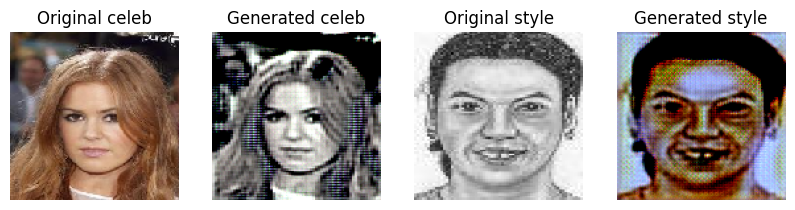

1/1 [==============================] - 0s 22ms/step


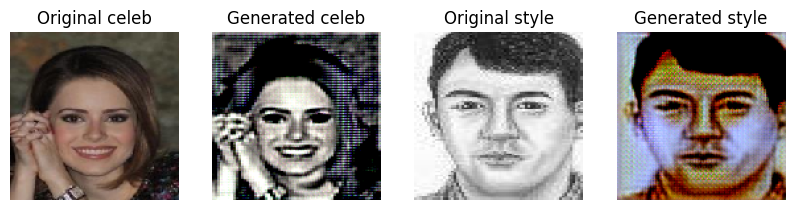

1/1 [==============================] - 0s 25ms/step


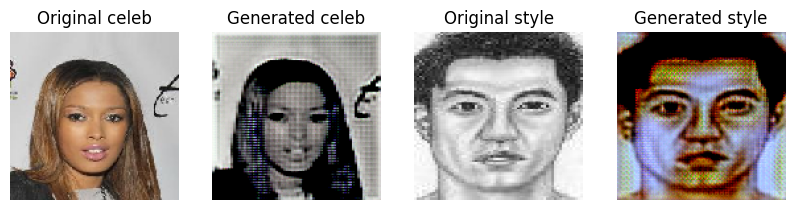

1/1 [==============================] - 0s 24ms/step


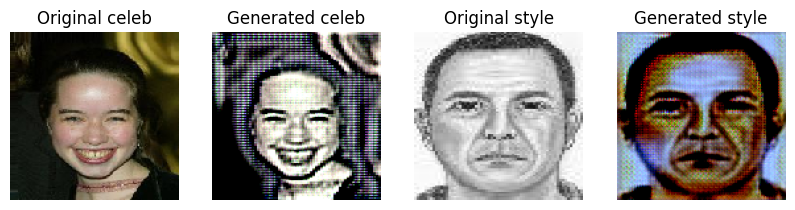

1/1 [==============================] - 0s 21ms/step


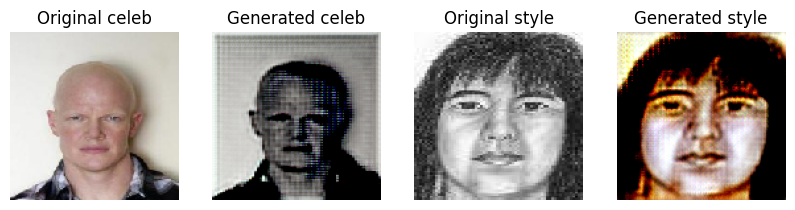

In [92]:
show_preds(CelebtoStyle_gen,StyletoCeleb_gen ,n_images=5)

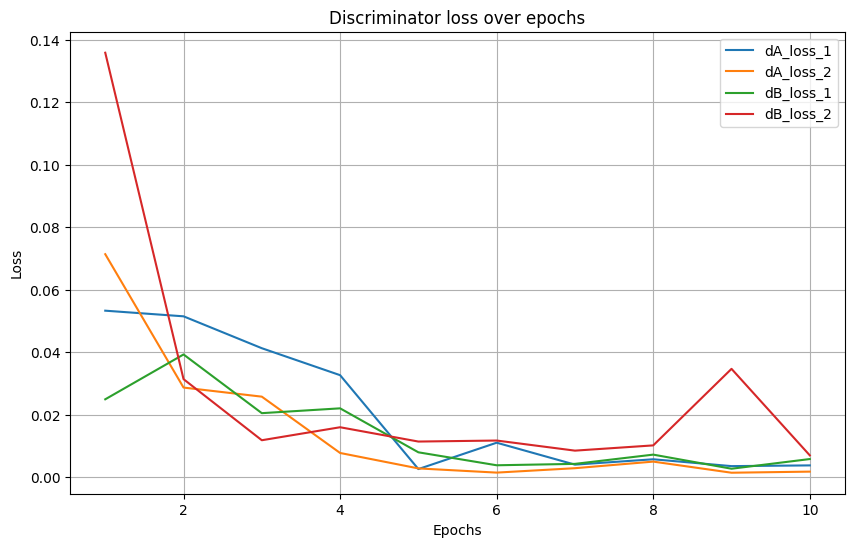

In [93]:
import matplotlib.pyplot as plt

# Extracting individual losses for plotting
dA_loss_1 = [epoch[0] for epoch in loss_history]
dA_loss_2 = [epoch[1] for epoch in loss_history]
dB_loss_1 = [epoch[2] for epoch in loss_history]
dB_loss_2 = [epoch[3] for epoch in loss_history]
gen_loss1 = [epoch[4] for epoch in loss_history]
gen_loss2 = [epoch[5] for epoch in loss_history]

epochs = range(1, len(loss_history) + 1)

# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, dA_loss_1, label='dA_loss_1')
plt.plot(epochs, dA_loss_2, label='dA_loss_2')
plt.plot(epochs, dB_loss_1, label='dB_loss_1')
plt.plot(epochs, dB_loss_2, label='dB_loss_2')

plt.title('Discriminator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

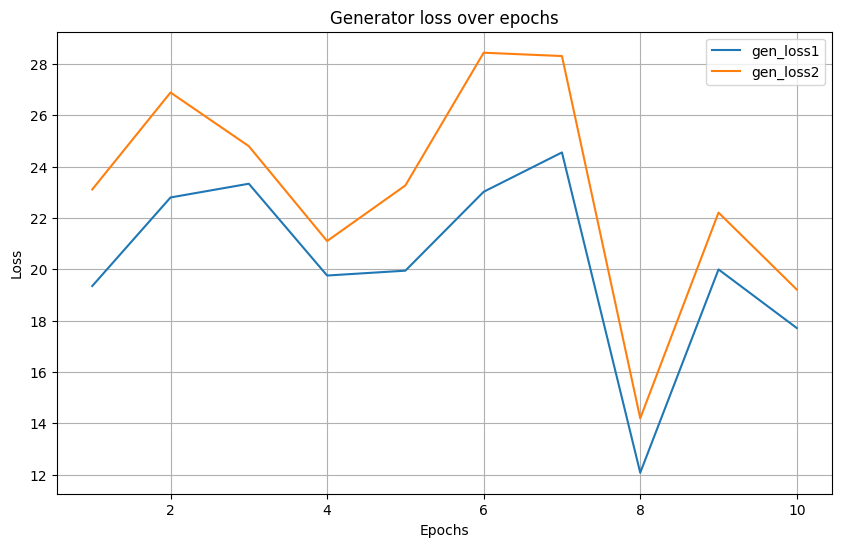

In [94]:
# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, gen_loss1, label='gen_loss1')
plt.plot(epochs, gen_loss2, label='gen_loss2')

plt.title('Generator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()